Training Variational Autoencoder with Multiple Lock-In Data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.Session(config = tf.ConfigProto(log_device_placement = True))

import keras
keras.backend.set_session(sess)
keras.backend.clear_session()

Using TensorFlow backend.


We wrap the machine learning process into functions:

1) DataPrep(filepath, test_ratio, z_cut) : takes the AFM measurement data in .npz format and returns rawdata, training set and the validation set

2) CreateVAE(** hyperparameters) : creates the VAE model given the hyperparameters of the model

3) SaveModel(savepath) : saves the training results in a suitable format

In [2]:
'''
** Dataprep(filepath, test_ratio) **
Inputs:
- filepath: path to the pre-processed AFM data file, in .npz format
- test_ratio: the ratio between the total number of approach curve data and the number of the approach curve data used in the validation set
- seed: seed for the random generator used in shuffling training and test sets

Outputs:
- train_dataset: dataset corresponding to the training set
- test_dataset: dataset corresponding to the test set
- train: training set
- test: test set
'''

def DataPrep(filepath, test_ratio = 0.1, seed = None): # the filepath must point to pre-processed AFM datafile, in .npz format
    # load the npz file
    dataset = np.load(filepath, allow_pickle = True)

    raw_dataset = dataset['raw'] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = dataset['mech'] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format
    imin_dataset = dataset['imin'] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = dataset['Q']
    w_dataset = dataset['w']
    w0_dataset = dataset['w0']
    I0_dataset = dataset['I0']
    C0C_dataset = dataset['C0C']

    E_dataset = dataset['E'] # Dissipated energy, normalized by kA0^2
    kint_dataset = dataset['kint'] # k_int, normalized by k
    bint_dataset = dataset['bint'] # b_int, normalized by k

    Fk_dataset = dataset['Fk'] # <F_k> = kA, normalized by kA0
    Fb_dataset = dataset['Fb'] # <F_b> = bwA, normalized by kA0

    filename_dataset = dataset['filename'] # filename

    N = Q_dataset.size
    N_test = int(N*test_ratio)

    print('Number of test samples : %d' %(N_test))
    print('Number of training samples : %d' %(N - N_test))

    sample_index = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(sample_index) # shuffle the input data
    
    seq_length = np.amin(imin_dataset) + 1
    
    #create data array : (trials, seq_length, 5)
    data = np.zeros((N, seq_length, 5))
    for i in range(N):
        data[i,:,0:3] = mech_dataset[i][imin_dataset[i]+1-seq_length:imin_dataset[i]+1, 0:3]
        data[i,:,3] = np.ones((1, seq_length))*Q_dataset[i]/w0_dataset[i] # 3rd channel is Q/w0
        data[i,:,4] = np.ones((1, seq_length))*w_dataset[i]/w0_dataset[i] # 4th channel is w/w0
    
    # create test and train datasets
    test_index = sample_index[0:N_test]
    train_index = sample_index[N_test:]
    
    test = data[test_index,:,:]
    train = data[train_index,:,:]
    
    keys = np.array(list(dataset.keys()))
    values = np.array(list(dataset.values()))
    print(values.shape)
    
    train_dataset = dict(zip(keys, values[:, train_index]))
    test_dataset = dict(zip(keys, values[:, test_index]))
    
    return [train_dataset, test_dataset, train, test]

Number of test samples : 31
Number of training samples : 279
(14, 310)


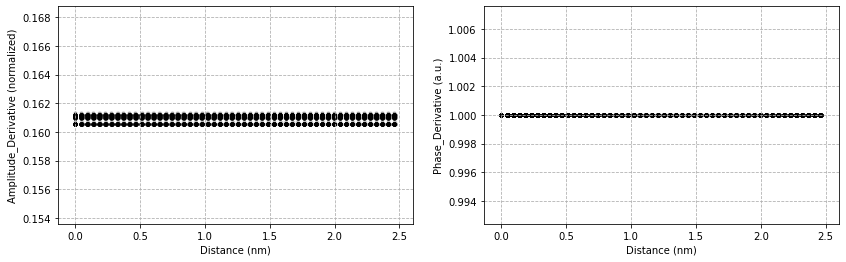

In [3]:
# filepath to the reformatted data file
filepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/DohyunBest_deriv3.npz'
test_ratio = 0.1

train_dataset, test_dataset, train, test = DataPrep(filepath, test_ratio)

# Graph the training set
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}

for i in range(train.shape[0]):
    ax1.scatter(train[i,:,0], train[i,:,3], **kwargs)
    ax2.scatter(train[i,:,0], train[i,:,4], **kwargs)

ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Amplitude_Derivative (normalized)')
ax1.grid(ls = '--')

ax2.set_xlabel('Distance (nm)')
ax2.set_ylabel('Phase_Derivative (a.u.)')
ax2.grid(ls = '--')



In [5]:
input_dim = (train.shape[1], train.shape[2]-1)
print(input_dim)
seq_length, n_channel = input_dim
print(seq_length)

(54, 4)
54


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 54, 32)       352         Sequence_Input[0][0]             
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 54, 32)       128         conv1d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 54, 32)       0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
dropout_21

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
Constant_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 54, 1)        31717       Sequence_Input[0][0]             
                                                                 Constant_Input[0][0]             
__________________________________________________________________________________________________
Decoder (Model)                 (None, 54, 2)        31594       Encoder[1][0]                    
          

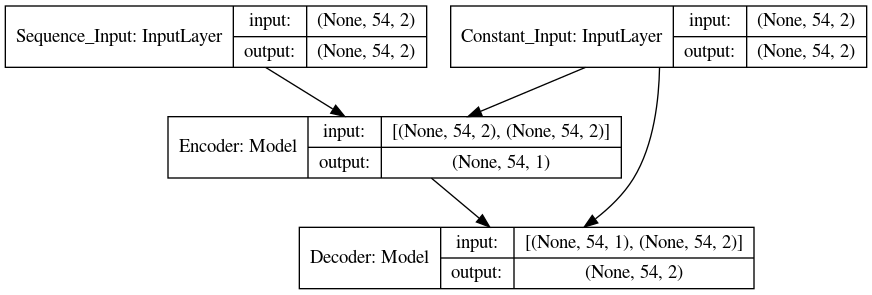

In [6]:
seq_length = train.shape[1]

from keras import optimizers
optimizer = optimizers.Adam(lr = 1e-4)

from Approach_ConvAE_ver2 import Conv1dAE

conv1d_ae = Conv1dAE(seq_length = seq_length, filters = 32, output_dim = 32, dropout_rate = 0.3, optimizer = optimizer)

#tensorboard = TensorBoard(log_dir = 'logs/{}'.format(time()))

model = conv1d_ae['autoencoder']
encoder = conv1d_ae['encoder']
batch_size = 32

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename='model_plot.png') 

In [7]:
from keras.callbacks import EarlyStopping
'''
Early stopping: stops the model if certain conditions are satisfied
References:
1) https://keras.io/callbacks/
2) https://stackoverflow.com/questions/53478622/stop-keras-training-when-the-network-has-fully-converge
'''
#stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 500, patience = 5) # loss change of under min_delta count as no improvement
#history = model.fit(x = train[:, 1:], epochs = 100, batch_size = batch_size, validation_data = (test[:, 1:], None), callbacks = [stop_callback])

history = model.fit(x = [train[:,:,1:3], train[:,:,3:]], epochs = 70000, batch_size = batch_size, validation_data = ([test[:,:,1:3], test[:,:,3:]], None))


Train on 279 samples, validate on 31 samples
Epoch 1/70000
279/279 [==============================] - 6s 20ms/step - loss: 1.4382 - val_loss: 0.5656
Epoch 2/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.3670 - val_loss: 0.4912
Epoch 3/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.2520 - val_loss: 0.4352
Epoch 4/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.1928 - val_loss: 0.4009
Epoch 5/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.1322 - val_loss: 0.3953
Epoch 6/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.0645 - val_loss: 0.3966
Epoch 7/70000
279/279 [==============================] - 0s 1ms/step - loss: 1.0273 - val_loss: 0.4008
Epoch 8/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.9883 - val_loss: 0.4070
Epoch 9/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.9827 - val_loss: 0.4088
Epoch 10/70000
279/279 [===

279/279 [==============================] - 0s 1ms/step - loss: 0.7075 - val_loss: 0.5406
Epoch 80/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.7117 - val_loss: 0.5436
Epoch 81/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.7069 - val_loss: 0.5428
Epoch 82/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.7092 - val_loss: 0.5431
Epoch 83/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.7027 - val_loss: 0.5440
Epoch 84/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.6979 - val_loss: 0.5440
Epoch 85/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.6973 - val_loss: 0.5438
Epoch 86/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.7028 - val_loss: 0.5450
Epoch 87/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.6983 - val_loss: 0.5444
Epoch 88/70000
279/279 [==============================] - 0s 1ms/step - loss: 0

279/279 [==============================] - 0s 1ms/step - loss: 0.5831 - val_loss: 0.5032
Epoch 158/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5750 - val_loss: 0.5027
Epoch 159/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5780 - val_loss: 0.5026
Epoch 160/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5720 - val_loss: 0.5024
Epoch 161/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5675 - val_loss: 0.5013
Epoch 162/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5717 - val_loss: 0.5030
Epoch 163/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5659 - val_loss: 0.5010
Epoch 164/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5691 - val_loss: 0.4992
Epoch 165/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.5697 - val_loss: 0.5001
Epoch 166/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.4901 - val_loss: 0.4445
Epoch 236/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4713 - val_loss: 0.4431
Epoch 237/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4779 - val_loss: 0.4433
Epoch 238/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4738 - val_loss: 0.4415
Epoch 239/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4823 - val_loss: 0.4415
Epoch 240/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4751 - val_loss: 0.4414
Epoch 241/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4795 - val_loss: 0.4417
Epoch 242/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4769 - val_loss: 0.4418
Epoch 243/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4776 - val_loss: 0.4415
Epoch 244/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.4044 - val_loss: 0.3969
Epoch 314/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4067 - val_loss: 0.3967
Epoch 315/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4075 - val_loss: 0.3972
Epoch 316/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4045 - val_loss: 0.3954
Epoch 317/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4059 - val_loss: 0.3959
Epoch 318/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4024 - val_loss: 0.3959
Epoch 319/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4080 - val_loss: 0.3959
Epoch 320/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4038 - val_loss: 0.3970
Epoch 321/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.4038 - val_loss: 0.3960
Epoch 322/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.3494 - val_loss: 0.3558
Epoch 392/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3443 - val_loss: 0.3553
Epoch 393/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3442 - val_loss: 0.3545
Epoch 394/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3429 - val_loss: 0.3534
Epoch 395/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3444 - val_loss: 0.3526
Epoch 396/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3439 - val_loss: 0.3514
Epoch 397/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3398 - val_loss: 0.3508
Epoch 398/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3378 - val_loss: 0.3499
Epoch 399/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.3404 - val_loss: 0.3492
Epoch 400/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.2903 - val_loss: 0.3147
Epoch 470/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2900 - val_loss: 0.3151
Epoch 471/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2948 - val_loss: 0.3154
Epoch 472/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2877 - val_loss: 0.3143
Epoch 473/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2820 - val_loss: 0.3141
Epoch 474/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2896 - val_loss: 0.3135
Epoch 475/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2853 - val_loss: 0.3126
Epoch 476/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2872 - val_loss: 0.3114
Epoch 477/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2842 - val_loss: 0.3116
Epoch 478/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.2399 - val_loss: 0.2802
Epoch 548/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2465 - val_loss: 0.2797
Epoch 549/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2449 - val_loss: 0.2785
Epoch 550/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2418 - val_loss: 0.2778
Epoch 551/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2428 - val_loss: 0.2766
Epoch 552/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2399 - val_loss: 0.2760
Epoch 553/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2390 - val_loss: 0.2752
Epoch 554/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2393 - val_loss: 0.2741
Epoch 555/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2404 - val_loss: 0.2729
Epoch 556/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.2055 - val_loss: 0.2304
Epoch 626/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2044 - val_loss: 0.2318
Epoch 627/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2043 - val_loss: 0.2322
Epoch 628/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2053 - val_loss: 0.2327
Epoch 629/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2018 - val_loss: 0.2322
Epoch 630/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2029 - val_loss: 0.2321
Epoch 631/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2025 - val_loss: 0.2329
Epoch 632/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2021 - val_loss: 0.2328
Epoch 633/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.2041 - val_loss: 0.2304
Epoch 634/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.1735 - val_loss: 0.2006
Epoch 704/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.1999
Epoch 705/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1723 - val_loss: 0.1995
Epoch 706/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1697 - val_loss: 0.1993
Epoch 707/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1681 - val_loss: 0.1989
Epoch 708/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1703 - val_loss: 0.1983
Epoch 709/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1688 - val_loss: 0.1972
Epoch 710/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.1962
Epoch 711/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1686 - val_loss: 0.1956
Epoch 712/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.1441 - val_loss: 0.1818
Epoch 782/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1448 - val_loss: 0.1813
Epoch 783/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1456 - val_loss: 0.1791
Epoch 784/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1435 - val_loss: 0.1807
Epoch 785/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1423 - val_loss: 0.1826
Epoch 786/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1450 - val_loss: 0.1845
Epoch 787/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1420 - val_loss: 0.1836
Epoch 788/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1422 - val_loss: 0.1830
Epoch 789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1410 - val_loss: 0.1824
Epoch 790/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.1227 - val_loss: 0.1639
Epoch 860/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1219 - val_loss: 0.1642
Epoch 861/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1201 - val_loss: 0.1635
Epoch 862/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1250 - val_loss: 0.1648
Epoch 863/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1203 - val_loss: 0.1652
Epoch 864/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1196 - val_loss: 0.1651
Epoch 865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1208 - val_loss: 0.1647
Epoch 866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1205 - val_loss: 0.1644
Epoch 867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1198 - val_loss: 0.1618
Epoch 868/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.1030 - val_loss: 0.1398
Epoch 938/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1017 - val_loss: 0.1383
Epoch 939/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1005 - val_loss: 0.1381
Epoch 940/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1008 - val_loss: 0.1375
Epoch 941/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1108 - val_loss: 0.1371
Epoch 942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1033 - val_loss: 0.1375
Epoch 943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1019 - val_loss: 0.1372
Epoch 944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1003 - val_loss: 0.1357
Epoch 945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.1012 - val_loss: 0.1345
Epoch 946/70000
279/279 [==============================] - 0s 1ms/step 

279/279 [==============================] - 0s 1ms/step - loss: 0.0862 - val_loss: 0.1188
Epoch 1016/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0876 - val_loss: 0.1189
Epoch 1017/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0862 - val_loss: 0.1191
Epoch 1018/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0842 - val_loss: 0.1205
Epoch 1019/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0871 - val_loss: 0.1185
Epoch 1020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0846 - val_loss: 0.1183
Epoch 1021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0842 - val_loss: 0.1176
Epoch 1022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0833 - val_loss: 0.1160
Epoch 1023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0828 - val_loss: 0.1157
Epoch 1024/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.1001
Epoch 1093/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0998
Epoch 1094/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0996
Epoch 1095/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0994
Epoch 1096/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0992
Epoch 1097/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0990
Epoch 1098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0988
Epoch 1099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0987
Epoch 1100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0988
Epoch 1101/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0867
Epoch 1170/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0863
Epoch 1171/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0861
Epoch 1172/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0865
Epoch 1173/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0864
Epoch 1174/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0860
Epoch 1175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0853
Epoch 1176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0850
Epoch 1177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0842
Epoch 1178/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0497 - val_loss: 0.0765
Epoch 1247/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0770
Epoch 1248/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0516 - val_loss: 0.0779
Epoch 1249/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0529 - val_loss: 0.0784
Epoch 1250/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0782
Epoch 1251/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0503 - val_loss: 0.0780
Epoch 1252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0507 - val_loss: 0.0772
Epoch 1253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0527 - val_loss: 0.0766
Epoch 1254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0508 - val_loss: 0.0760
Epoch 1255/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0682
Epoch 1324/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0681
Epoch 1325/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0439 - val_loss: 0.0681
Epoch 1326/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0461 - val_loss: 0.0696
Epoch 1327/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0697
Epoch 1328/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0435 - val_loss: 0.0696
Epoch 1329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0441 - val_loss: 0.0693
Epoch 1330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0422 - val_loss: 0.0690
Epoch 1331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0423 - val_loss: 0.0679
Epoch 1332/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0609
Epoch 1401/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0609
Epoch 1402/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0608
Epoch 1403/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0609
Epoch 1404/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0608
Epoch 1405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0608
Epoch 1406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0608
Epoch 1407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0609
Epoch 1408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0609
Epoch 1409/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0565
Epoch 1478/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0563
Epoch 1479/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0562
Epoch 1480/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0561
Epoch 1481/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0559
Epoch 1482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0557
Epoch 1483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0555
Epoch 1484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0554
Epoch 1485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0553
Epoch 1486/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0503
Epoch 1555/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0502
Epoch 1556/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0502
Epoch 1557/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0500
Epoch 1558/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0500
Epoch 1559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0500
Epoch 1560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0499
Epoch 1561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0493
Epoch 1562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0485
Epoch 1563/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0440
Epoch 1632/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0215 - val_loss: 0.0441
Epoch 1633/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0452
Epoch 1634/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0453
Epoch 1635/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0454
Epoch 1636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0453
Epoch 1637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0452
Epoch 1638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0451
Epoch 1639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0451
Epoch 1640/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0401
Epoch 1709/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0404
Epoch 1710/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 0.0405
Epoch 1711/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0186 - val_loss: 0.0405
Epoch 1712/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0191 - val_loss: 0.0404
Epoch 1713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.0404
Epoch 1714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0200 - val_loss: 0.0396
Epoch 1715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.0395
Epoch 1716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0385
Epoch 1717/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0180 - val_loss: 0.0370
Epoch 1786/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0383
Epoch 1787/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 0.0395
Epoch 1788/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0174 - val_loss: 0.0396
Epoch 1789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0395
Epoch 1790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 0.0394
Epoch 1791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 0.0392
Epoch 1792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0158 - val_loss: 0.0390
Epoch 1793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 0.0389
Epoch 1794/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0297
Epoch 1863/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0296
Epoch 1864/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0152 - val_loss: 0.0293
Epoch 1865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0285
Epoch 1866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 0.0285
Epoch 1867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 0.0285
Epoch 1868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0137 - val_loss: 0.0283
Epoch 1869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0283
Epoch 1870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0284
Epoch 1871/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0264
Epoch 1940/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0244
Epoch 1941/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0229
Epoch 1942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 1943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0200
Epoch 1944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 0.0200
Epoch 1945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0200
Epoch 1946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0200
Epoch 1947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0199
Epoch 1948/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0188
Epoch 2017/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0193
Epoch 2018/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0193
Epoch 2019/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0193
Epoch 2020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0193
Epoch 2021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0192
Epoch 2022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0192
Epoch 2023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0192
Epoch 2024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0192
Epoch 2025/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0191
Epoch 2094/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0190
Epoch 2095/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0190
Epoch 2096/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.0190
Epoch 2097/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0189
Epoch 2098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0189
Epoch 2099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0189
Epoch 2100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0189
Epoch 2101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0188
Epoch 2102/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0181
Epoch 2171/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0181
Epoch 2172/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0181
Epoch 2173/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0181
Epoch 2174/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0181
Epoch 2175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0180
Epoch 2176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0180
Epoch 2177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0180
Epoch 2178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0181
Epoch 2179/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0182
Epoch 2248/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0182
Epoch 2249/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.0182
Epoch 2250/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0182
Epoch 2251/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0182
Epoch 2252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0182
Epoch 2253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0182
Epoch 2254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.0182
Epoch 2255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0181
Epoch 2256/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0185
Epoch 2325/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0185
Epoch 2326/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0185
Epoch 2327/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0184
Epoch 2328/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0183
Epoch 2329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0183
Epoch 2330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0183
Epoch 2331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.0184
Epoch 2332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0183
Epoch 2333/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0178
Epoch 2402/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0178
Epoch 2403/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0178
Epoch 2404/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0178
Epoch 2405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0178
Epoch 2406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0178
Epoch 2407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0178
Epoch 2408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0178
Epoch 2409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0179
Epoch 2410/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0179
Epoch 2479/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0179
Epoch 2480/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0179
Epoch 2481/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0179
Epoch 2482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0179
Epoch 2483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0179
Epoch 2484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0179
Epoch 2485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0179
Epoch 2486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0178
Epoch 2487/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 2556/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0176
Epoch 2557/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0176
Epoch 2558/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0176
Epoch 2559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0176
Epoch 2560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0176
Epoch 2561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0171
Epoch 2562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0173
Epoch 2563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0173
Epoch 2564/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0176
Epoch 2633/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0176
Epoch 2634/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0175
Epoch 2635/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0175
Epoch 2636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0176
Epoch 2637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 2638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0175
Epoch 2639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0176
Epoch 2640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0175
Epoch 2641/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0173
Epoch 2710/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0179
Epoch 2711/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0181
Epoch 2712/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0181
Epoch 2713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0181
Epoch 2714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0181
Epoch 2715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0181
Epoch 2716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0181
Epoch 2717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0181
Epoch 2718/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0178
Epoch 2787/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0178
Epoch 2788/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0177
Epoch 2789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0178
Epoch 2790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0177
Epoch 2791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0177
Epoch 2792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0177
Epoch 2793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0176
Epoch 2794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0174
Epoch 2795/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0191
Epoch 2864/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0191
Epoch 2865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0189
Epoch 2866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0187
Epoch 2867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0187
Epoch 2868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0187
Epoch 2869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0185
Epoch 2870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0183
Epoch 2871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0182
Epoch 2872/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0177
Epoch 2941/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0176
Epoch 2942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0177
Epoch 2943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0178
Epoch 2944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0180
Epoch 2945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0181
Epoch 2946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0173 - val_loss: 0.0183
Epoch 2947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0183
Epoch 2948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0182
Epoch 2949/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0174
Epoch 3018/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0174
Epoch 3019/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0174
Epoch 3020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0173
Epoch 3021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0172
Epoch 3022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0172
Epoch 3023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0109 - val_loss: 0.0171
Epoch 3024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0182
Epoch 3025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0187
Epoch 3026/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0180
Epoch 3095/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0180
Epoch 3096/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0181
Epoch 3097/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0183
Epoch 3098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0184
Epoch 3099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0184
Epoch 3100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0184
Epoch 3101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0184
Epoch 3102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0184
Epoch 3103/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0176
Epoch 3172/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0177
Epoch 3173/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0177
Epoch 3174/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0177
Epoch 3175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0178
Epoch 3176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0177
Epoch 3177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0179
Epoch 3178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0178
Epoch 3179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0178
Epoch 3180/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0186
Epoch 3249/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0186
Epoch 3250/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0186
Epoch 3251/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0186
Epoch 3252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0186
Epoch 3253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0186
Epoch 3254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0186
Epoch 3255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0186
Epoch 3256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0186
Epoch 3257/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0184
Epoch 3326/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0184
Epoch 3327/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0184
Epoch 3328/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0184
Epoch 3329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0184
Epoch 3330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0183
Epoch 3331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0183
Epoch 3332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0183
Epoch 3333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0183
Epoch 3334/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0185
Epoch 3403/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0186
Epoch 3404/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0186
Epoch 3405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0186
Epoch 3406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0186
Epoch 3407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0186
Epoch 3408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0186
Epoch 3409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0186
Epoch 3410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0187
Epoch 3411/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0180
Epoch 3480/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0180
Epoch 3481/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0180
Epoch 3482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0180
Epoch 3483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0181
Epoch 3484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0181
Epoch 3485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 3486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0180
Epoch 3487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0181
Epoch 3488/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0178
Epoch 3557/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0178
Epoch 3558/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0179
Epoch 3559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0179
Epoch 3560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0179
Epoch 3561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0179
Epoch 3562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0179
Epoch 3563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0179
Epoch 3564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0178
Epoch 3565/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0174
Epoch 3634/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 3635/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0174
Epoch 3636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0174
Epoch 3637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 3638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0175
Epoch 3639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0176
Epoch 3640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0176
Epoch 3641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0175
Epoch 3642/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0170
Epoch 3711/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0170
Epoch 3712/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0170
Epoch 3713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0170
Epoch 3714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 3715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0170
Epoch 3716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0170
Epoch 3718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0170
Epoch 3719/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 3788/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 3789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0170
Epoch 3790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0170
Epoch 3792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0170
Epoch 3794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0170
Epoch 3796/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0171
Epoch 3865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 3866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0171
Epoch 3867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0171
Epoch 3868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 3869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0171
Epoch 3870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0170
Epoch 3871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 3872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0170
Epoch 3873/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0171
Epoch 3942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 3943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0171
Epoch 3944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0170
Epoch 3945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0170
Epoch 3946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0169
Epoch 3947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0169
Epoch 3948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0169
Epoch 3949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0169
Epoch 3950/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0170
Epoch 4019/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0171
Epoch 4020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0171
Epoch 4021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0170
Epoch 4022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0169
Epoch 4023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0169
Epoch 4024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0169
Epoch 4025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0169
Epoch 4026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0169
Epoch 4027/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0160
Epoch 4096/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0160
Epoch 4097/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0160
Epoch 4098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0160
Epoch 4099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0160
Epoch 4100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0160
Epoch 4101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0160
Epoch 4102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0159
Epoch 4103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0159
Epoch 4104/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0161
Epoch 4173/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0161
Epoch 4174/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0162
Epoch 4175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0161
Epoch 4176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0161
Epoch 4177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0160
Epoch 4178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0161
Epoch 4179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0161
Epoch 4180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0160
Epoch 4181/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0165
Epoch 4250/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0165
Epoch 4251/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0164
Epoch 4252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 4253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0167
Epoch 4254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0168
Epoch 4255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 4256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0170
Epoch 4257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 4258/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 4327/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0165
Epoch 4328/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0168
Epoch 4329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0167
Epoch 4330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0166
Epoch 4331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0167
Epoch 4332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0167
Epoch 4333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0170
Epoch 4334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0171
Epoch 4335/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0170
Epoch 4404/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0171
Epoch 4405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0171
Epoch 4406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0172
Epoch 4407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0174
Epoch 4408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0173
Epoch 4409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0173
Epoch 4410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0171
Epoch 4411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0169
Epoch 4412/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0173
Epoch 4481/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0171
Epoch 4482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0171
Epoch 4483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0172
Epoch 4484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0172
Epoch 4485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0171
Epoch 4486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0169
Epoch 4487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0170
Epoch 4488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0170
Epoch 4489/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0181
Epoch 4558/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0183
Epoch 4559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0183
Epoch 4560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0182
Epoch 4561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0183
Epoch 4562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0186
Epoch 4563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0190
Epoch 4564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0191
Epoch 4565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0190
Epoch 4566/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 4635/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0187
Epoch 4636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 4637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0187
Epoch 4638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0188
Epoch 4639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 4640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0187
Epoch 4641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 4642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 4643/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0196
Epoch 4712/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0196
Epoch 4713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0196
Epoch 4714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0195
Epoch 4715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0194
Epoch 4716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0192
Epoch 4717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0193
Epoch 4718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0192
Epoch 4719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0193
Epoch 4720/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0193
Epoch 4789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0193
Epoch 4790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0191
Epoch 4791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0190
Epoch 4792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0190
Epoch 4793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0190
Epoch 4794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0188
Epoch 4795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0188
Epoch 4796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0188
Epoch 4797/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 4866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 4867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0176
Epoch 4868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0176
Epoch 4869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 4870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0174
Epoch 4871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 4872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0177
Epoch 4873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0178
Epoch 4874/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0166
Epoch 4943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0167
Epoch 4944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0164
Epoch 4945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0163
Epoch 4946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0162
Epoch 4947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 4948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0168
Epoch 4949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0167
Epoch 4950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0167
Epoch 4951/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0174
Epoch 5020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0175
Epoch 5021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0176
Epoch 5022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0176
Epoch 5023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0175
Epoch 5024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0173
Epoch 5025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0172
Epoch 5026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0172
Epoch 5027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0173
Epoch 5028/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0164
Epoch 5097/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0164
Epoch 5098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 5099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0169
Epoch 5100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0171
Epoch 5101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0172
Epoch 5102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0177
Epoch 5103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0179
Epoch 5104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0180
Epoch 5105/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0165
Epoch 5174/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0167
Epoch 5175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0168
Epoch 5176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0168
Epoch 5177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0167
Epoch 5178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0165
Epoch 5179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0164
Epoch 5180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0165
Epoch 5181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0167
Epoch 5182/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0178
Epoch 5251/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0176
Epoch 5252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0178
Epoch 5253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0180
Epoch 5254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0181
Epoch 5255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0177
Epoch 5256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0179
Epoch 5257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0177
Epoch 5258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0175
Epoch 5259/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 5328/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0186
Epoch 5329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0186
Epoch 5330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0187
Epoch 5331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0188
Epoch 5332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0188
Epoch 5333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0189
Epoch 5334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0188
Epoch 5335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0188
Epoch 5336/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0161
Epoch 5405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0157
Epoch 5406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0153
Epoch 5407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0155
Epoch 5408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0153
Epoch 5409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0153
Epoch 5410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0154
Epoch 5411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0152
Epoch 5412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0150
Epoch 5413/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0151
Epoch 5482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0151
Epoch 5483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0149
Epoch 5484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0154
Epoch 5485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0155
Epoch 5486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0154
Epoch 5487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0157
Epoch 5488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0157
Epoch 5489/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0160
Epoch 5490/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0154
Epoch 5559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0155
Epoch 5560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0154
Epoch 5561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0154
Epoch 5562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0154
Epoch 5563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0150
Epoch 5564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0147
Epoch 5565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 5566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0146
Epoch 5567/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0147
Epoch 5636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0146
Epoch 5637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0145
Epoch 5638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0145
Epoch 5639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0146
Epoch 5640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0147
Epoch 5641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0146
Epoch 5642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0146
Epoch 5643/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0147
Epoch 5644/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0139
Epoch 5713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 5714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0144
Epoch 5715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0140
Epoch 5716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 5717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0141
Epoch 5718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0142
Epoch 5719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0141
Epoch 5720/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0141
Epoch 5721/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0161
Epoch 5790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0158
Epoch 5791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0157
Epoch 5792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0155
Epoch 5793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0161
Epoch 5794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 5795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0176
Epoch 5796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0182
Epoch 5797/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0191
Epoch 5798/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0134
Epoch 5867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0133
Epoch 5868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0133
Epoch 5869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0135
Epoch 5870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0135
Epoch 5871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0133
Epoch 5872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0135
Epoch 5873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 5874/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0139
Epoch 5875/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0147
Epoch 5944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0146
Epoch 5945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0143
Epoch 5946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0146
Epoch 5947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0150
Epoch 5948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0150
Epoch 5949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0156
Epoch 5950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0155
Epoch 5951/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0158
Epoch 5952/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 6021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 6022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0149
Epoch 6023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0149
Epoch 6024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0148
Epoch 6025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0148
Epoch 6026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0148
Epoch 6027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0150
Epoch 6028/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0149
Epoch 6029/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0138
Epoch 6098/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0139
Epoch 6099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0140
Epoch 6100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0142
Epoch 6101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0149
Epoch 6102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0148
Epoch 6103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 6104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0148
Epoch 6105/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0145
Epoch 6106/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0151
Epoch 6175/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 6176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 6177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0149
Epoch 6178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0152
Epoch 6179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0153
Epoch 6180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0154
Epoch 6181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0153
Epoch 6182/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0153
Epoch 6183/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0143
Epoch 6252/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0143
Epoch 6253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0143
Epoch 6254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0144
Epoch 6255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0145
Epoch 6256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0146
Epoch 6257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0147
Epoch 6258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0147
Epoch 6259/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0149
Epoch 6260/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0143
Epoch 6329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0143
Epoch 6330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0143
Epoch 6331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 6332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0144
Epoch 6333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0147
Epoch 6334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0146
Epoch 6335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0145
Epoch 6336/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0146
Epoch 6337/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0136
Epoch 6406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0138
Epoch 6407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0140
Epoch 6408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0141
Epoch 6409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0140
Epoch 6410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0138
Epoch 6411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0139
Epoch 6412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0140
Epoch 6413/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0140
Epoch 6414/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0139
Epoch 6483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0138
Epoch 6484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 6485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0141
Epoch 6486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0136
Epoch 6487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0135
Epoch 6488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0133
Epoch 6489/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0132
Epoch 6490/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0133
Epoch 6491/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0126
Epoch 6560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0125
Epoch 6561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 6562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 6563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 6564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0128
Epoch 6565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0129
Epoch 6566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0129
Epoch 6567/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0127
Epoch 6568/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 6637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0125
Epoch 6638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0126
Epoch 6639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0126
Epoch 6640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 6641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0126
Epoch 6642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 6643/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0125
Epoch 6644/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 6645/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0129
Epoch 6714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0128
Epoch 6715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0129
Epoch 6716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 6717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 6718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0127
Epoch 6719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0128
Epoch 6720/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0129
Epoch 6721/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0130
Epoch 6722/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0140
Epoch 6791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0140
Epoch 6792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0140
Epoch 6793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0137
Epoch 6794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0137
Epoch 6795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0136
Epoch 6796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0137
Epoch 6797/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0138
Epoch 6798/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0139
Epoch 6799/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0142
Epoch 6868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0143
Epoch 6869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0144
Epoch 6870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0144
Epoch 6871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0144
Epoch 6872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0144
Epoch 6873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0144
Epoch 6874/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0143
Epoch 6875/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0144
Epoch 6876/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0147
Epoch 6945/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0147
Epoch 6946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0146
Epoch 6947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0147
Epoch 6948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0146
Epoch 6949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0147
Epoch 6950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0145
Epoch 6951/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0145
Epoch 6952/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0145
Epoch 6953/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0149
Epoch 7022/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0149
Epoch 7023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0149
Epoch 7024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0149
Epoch 7025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0148
Epoch 7026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0147
Epoch 7027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0147
Epoch 7028/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0147
Epoch 7029/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0147
Epoch 7030/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0141
Epoch 7099/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0140
Epoch 7100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0139
Epoch 7101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0139
Epoch 7102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0138
Epoch 7103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0138
Epoch 7104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0138
Epoch 7105/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0138
Epoch 7106/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0137
Epoch 7107/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0127
Epoch 7176/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 7177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 7178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0126
Epoch 7179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0126
Epoch 7180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 7181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0125
Epoch 7182/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0128
Epoch 7183/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0128
Epoch 7184/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0116
Epoch 7253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0116
Epoch 7254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0115
Epoch 7255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 7256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0114
Epoch 7257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0113
Epoch 7258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 7259/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 7260/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0115
Epoch 7261/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0108
Epoch 7330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 7331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0108
Epoch 7332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0109
Epoch 7333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 7334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 7335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0111
Epoch 7336/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0111
Epoch 7337/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0110
Epoch 7338/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 7407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 7408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0097
Epoch 7409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0097
Epoch 7410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 7411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0098
Epoch 7412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 7413/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 7414/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0100
Epoch 7415/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 7484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 7485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 7486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 7487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 7488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 7489/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0097
Epoch 7490/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 7491/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 7492/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 7561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0103
Epoch 7562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 7563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0100
Epoch 7564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 7565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 7566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 7567/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0102
Epoch 7568/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 7569/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0091
Epoch 7638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 7639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 7640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 7641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 7642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 7643/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0094
Epoch 7644/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 7645/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 7646/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 7715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0089
Epoch 7716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 7717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 7718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0092
Epoch 7719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0092
Epoch 7720/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0089
Epoch 7721/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 7722/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 7723/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 7792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 7793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 7794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0084
Epoch 7795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 7796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 7797/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 7798/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0088
Epoch 7799/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 7800/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 7869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 7870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0093
Epoch 7871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 7872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 7873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 7874/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 7875/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0092
Epoch 7876/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0093
Epoch 7877/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 7946/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 7947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0073
Epoch 7948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 7949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0074
Epoch 7950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 7951/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 7952/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0075
Epoch 7953/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0073
Epoch 7954/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 8023/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 8024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 8025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 8026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 8027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 8028/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 8029/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 8030/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 8031/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 8100/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 8101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 8102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 8103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 8104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 8105/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 8106/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 8107/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 8108/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 8177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 8178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0061
Epoch 8179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 8180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 8181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 8182/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 8183/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 8184/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0069
Epoch 8185/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 8254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 8256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 8257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 8258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 8259/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 8260/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 8261/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 8262/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 8331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 8332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 8333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 8334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 8335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 8336/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8337/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 8338/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 8339/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 8408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 8409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 8410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 8411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 8412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 8413/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 8414/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 8415/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 8416/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 8485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 8486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 8487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 8488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 8489/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 8490/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 8491/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 8492/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 8493/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 8562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 8563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 8564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 8565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0061
Epoch 8566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0061
Epoch 8567/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 8568/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8569/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 8570/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 8640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 8641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 8642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 8643/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 8644/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 8645/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 8646/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 8647/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 8716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 8717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 8718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 8720/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 8721/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 8722/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 8723/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 8724/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 8795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 8796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 8797/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 8798/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 8799/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 8800/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 8801/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 8870/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 8871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 8872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 8873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 8874/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 8875/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 8876/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 8877/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8878/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 8947/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 8948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 8949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 8950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 8951/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 8952/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 8953/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8954/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8955/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 9024/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 9025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 9028/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 9029/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 9030/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 9031/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 9032/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 9102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 9104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9105/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9106/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 9107/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 9108/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 9109/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 9178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 9180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 9181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 9182/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 9183/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9184/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 9185/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 9186/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 9255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 9256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 9257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 9258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 9259/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9260/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 9261/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 9262/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9263/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 9332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 9335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 9336/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 9337/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 9338/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 9339/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 9340/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 9409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 9410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 9412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 9413/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9414/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9415/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 9416/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 9417/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 9486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 9487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 9488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 9489/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9490/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 9491/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9492/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9493/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 9494/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 9563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 9564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 9565/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 9566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9567/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9568/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 9569/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9570/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 9571/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 9641/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 9642/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 9643/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 9644/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 9645/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 9646/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 9647/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 9648/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 9717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 9718/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 9719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 9720/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 9721/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9722/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 9723/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 9724/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 9725/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 9794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 9795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 9796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 9797/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9798/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9799/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 9800/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 9801/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 9802/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 9871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 9873/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 9874/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9875/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9876/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9877/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9878/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9879/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 9948/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 9949/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 9950/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 9951/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 9952/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9953/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 9954/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 9955/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9956/70000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 10025/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10026/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 10027/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 10028/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10029/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 10030/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10031/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 10032/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10033/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10101/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10102/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10103/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 10104/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 10105/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 10106/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 10107/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 10108/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 10109/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 10177/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10178/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 10179/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10180/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10181/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10182/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10183/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10184/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10185/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 10253/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10254/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 10255/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10256/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 10257/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10258/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10259/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10260/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10261/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 10329/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 10330/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 10331/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 10332/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10333/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10334/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10335/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 10336/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10337/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10405/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10406/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 10407/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10408/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10409/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10410/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10411/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 10412/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10413/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 10481/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 10482/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 10483/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10484/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10485/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 10486/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10487/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10488/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10489/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 10557/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10558/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10559/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10560/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10561/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10562/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 10563/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 10564/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 10565/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 10633/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10634/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10635/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10636/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10637/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10638/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10639/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10640/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10641/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 10709/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 10710/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 10711/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 10712/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 10713/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 10714/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 10715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 10716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10717/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10785/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 10786/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10787/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 10788/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10789/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 10790/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10791/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10792/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10793/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10861/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10862/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 10863/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 10864/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 10865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 10866/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 10867/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10868/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 10869/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 10937/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10938/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 10939/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 10940/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10941/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 10942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 10943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 10944/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 10945/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 11013/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 11014/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 11015/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11016/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 11017/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11018/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11019/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 11020/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11021/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 11089/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 11090/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11091/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11092/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 11093/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 11094/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11095/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11096/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11097/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11165/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 11166/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 11167/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 11168/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 11169/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11170/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11171/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 11172/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 11173/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 11241/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 11242/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 11243/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 11244/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 11245/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 11246/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 11247/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11248/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11249/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11317/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11318/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11319/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 11320/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11321/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11322/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 11323/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11324/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 11325/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 11393/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11394/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11395/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11396/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 11397/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11398/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 11399/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 11400/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 11401/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 11469/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11470/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11471/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11472/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 11473/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11474/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11475/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11476/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11477/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11545/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11546/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 11547/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11548/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11549/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11550/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 11551/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11552/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11553/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11621/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 11622/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 11623/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 11624/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 11625/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 11626/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 11627/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11628/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 11629/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 11697/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 11698/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 11699/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 11700/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11701/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11702/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11703/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11704/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 11705/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11773/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 11774/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 11775/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11776/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 11777/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 11778/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 11779/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11780/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11781/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11849/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11850/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11851/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11852/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11853/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11854/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 11855/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11856/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 11857/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 11925/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11926/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 11927/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 11928/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 11929/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 11930/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11931/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 11932/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11933/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12001/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 12002/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 12003/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 12004/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 12005/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 12006/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 12007/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 12008/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12009/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12077/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 12078/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 12079/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12080/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 12081/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 12082/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 12083/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12084/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12085/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 12153/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 12154/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 12155/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 12156/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 12157/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12158/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12159/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12160/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12161/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 12229/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 12230/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 12231/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12232/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 12233/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12234/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12235/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 12236/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12237/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 12305/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 12306/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 12307/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 12308/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 12309/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 12310/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12311/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12312/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 12313/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12381/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 12382/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 12383/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 12384/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 12385/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12386/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 12387/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12388/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 12389/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12457/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12458/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 12459/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 12460/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 12461/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12462/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12463/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12464/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12465/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 12533/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12534/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 12535/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12536/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 12537/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12538/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12539/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12540/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 12541/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12609/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12610/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12611/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 12612/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12613/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 12614/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12615/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 12616/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 12617/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 12685/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 12686/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 12687/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 12688/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 12689/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 12690/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12691/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 12692/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12693/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 12761/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 12762/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12763/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 12764/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12765/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12766/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12767/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 12768/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 12769/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 12837/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12838/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12839/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12840/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 12841/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 12842/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 12843/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 12844/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 12845/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12913/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12914/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 12915/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 12916/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 12917/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12918/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12919/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 12920/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12921/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 12989/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12990/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12991/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12992/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 12993/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 12994/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 12995/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 12996/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 12997/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 13065/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 13066/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13067/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13068/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13069/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13070/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13071/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13072/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13073/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13141/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 13142/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13143/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13144/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13145/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 13146/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 13147/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 13148/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13149/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 13217/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 13218/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13219/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 13220/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13221/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 13222/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13223/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13224/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 13225/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13293/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13294/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13295/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13296/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13297/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 13298/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13299/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 13300/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13301/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 13369/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13370/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13371/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13372/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8007e-04 - val_loss: 0.0048
Epoch 13373/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 13374/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 13375/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13376/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 13377/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 13445/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 13446/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 13447/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13448/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13449/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 13450/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 13451/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13452/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 13453/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13521/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9574e-04 - val_loss: 0.0044
Epoch 13522/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13523/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13524/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13525/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13526/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13527/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13528/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 13529/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 13597/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13598/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13599/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 13600/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13601/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13602/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 13603/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 13604/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 13605/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 13673/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 13674/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13675/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13676/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13677/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13678/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 13679/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13680/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 13681/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 9.4970e-04 - val_loss: 0.0059
Epoch 13749/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 13750/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 13751/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 13752/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 13753/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13754/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 13755/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 13756/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 13757/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13825/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 13826/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7010e-04 - val_loss: 0.0047
Epoch 13827/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13828/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13829/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13830/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 13831/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 13832/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 13833/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 9.9339e-04 - val_loss: 0.0045
Epoch 13901/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 13902/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 13903/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9906e-04 - val_loss: 0.0048
Epoch 13904/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9272e-04 - val_loss: 0.0047
Epoch 13905/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 13906/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 13907/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 13908/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 13909/70000
279/279 [================

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 13977/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 13978/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 13979/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 13980/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13981/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 13982/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 13983/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8861e-04 - val_loss: 0.0047
Epoch 13984/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 13985/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 14053/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14054/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 14055/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 14056/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 14057/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14058/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 14059/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 14060/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 14061/70000
279/279 [============================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 14129/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 14130/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 14131/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9883e-04 - val_loss: 0.0051
Epoch 14132/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 14133/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14134/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 14135/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 14136/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 14137/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14205/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 14206/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14207/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 14208/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6866e-04 - val_loss: 0.0047
Epoch 14209/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14210/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6395e-04 - val_loss: 0.0047
Epoch 14211/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 14212/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 14213/70000
279/279 [====================

279/279 [==============================] - 0s 1ms/step - loss: 9.9832e-04 - val_loss: 0.0048
Epoch 14281/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14282/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14283/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6379e-04 - val_loss: 0.0046
Epoch 14284/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 14285/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 14286/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8819e-04 - val_loss: 0.0054
Epoch 14287/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 14288/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 14289/70000
279/279 [================

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14357/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 14358/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14359/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 14360/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 14361/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4409e-04 - val_loss: 0.0043
Epoch 14362/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14363/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14364/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0049
Epoch 14365/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 9.9609e-04 - val_loss: 0.0050
Epoch 14433/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 14434/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14435/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14436/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 14437/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 14438/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 14439/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9080e-04 - val_loss: 0.0055
Epoch 14440/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 14441/70000
279/279 [====================

279/279 [==============================] - 0s 1ms/step - loss: 9.7565e-04 - val_loss: 0.0060
Epoch 14509/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 14510/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 14511/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8508e-04 - val_loss: 0.0055
Epoch 14512/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 14513/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 14514/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 14515/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 14516/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 14517/70000
279/279 [====================

Epoch 14584/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 14585/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14586/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14587/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 14588/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14589/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0046
Epoch 14590/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 14591/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6465e-04 - val_loss: 0.0046
Epoch 14592/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 14593/70000
279/279 [======

279/279 [==============================] - 0s 1ms/step - loss: 9.3954e-04 - val_loss: 0.0045
Epoch 14660/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 14661/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6726e-04 - val_loss: 0.0046
Epoch 14662/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 14663/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 14664/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14665/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6186e-04 - val_loss: 0.0050
Epoch 14666/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5598e-04 - val_loss: 0.0051
Epoch 14667/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 14668/70000
279/279 [============

Epoch 14735/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9420e-04 - val_loss: 0.0047
Epoch 14736/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 14737/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9367e-04 - val_loss: 0.0048
Epoch 14738/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 14739/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8405e-04 - val_loss: 0.0049
Epoch 14740/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14741/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14742/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 14743/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9890e-04 - val_loss: 0.0047
Epoch 14744/70000
279

Epoch 14811/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 14812/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14813/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14814/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14815/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2240e-04 - val_loss: 0.0050
Epoch 14816/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 14817/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 14818/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3346e-04 - val_loss: 0.0052
Epoch 14819/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 14820/70000
279/279 [==

Epoch 14887/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8520e-04 - val_loss: 0.0049
Epoch 14888/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9507e-04 - val_loss: 0.0049
Epoch 14889/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14890/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14891/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 14892/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 14893/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6560e-04 - val_loss: 0.0047
Epoch 14894/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14895/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9193e-04 - val_loss: 0.0046
Epoch 14896/70000
279

Epoch 14963/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5867e-04 - val_loss: 0.0047
Epoch 14964/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7704e-04 - val_loss: 0.0046
Epoch 14965/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 14966/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8936e-04 - val_loss: 0.0048
Epoch 14967/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 14968/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7632e-04 - val_loss: 0.0049
Epoch 14969/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 14970/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5304e-04 - val_loss: 0.0049
Epoch 14971/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 14972/70000

Epoch 15039/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 15040/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5666e-04 - val_loss: 0.0053
Epoch 15041/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 15042/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 15043/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8348e-04 - val_loss: 0.0051
Epoch 15044/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 15045/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7798e-04 - val_loss: 0.0050
Epoch 15046/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 15047/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 15048/70000
279/279

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 15115/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7570e-04 - val_loss: 0.0050
Epoch 15116/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 15117/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15118/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6724e-04 - val_loss: 0.0052
Epoch 15119/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2341e-04 - val_loss: 0.0052
Epoch 15120/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15121/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 15122/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 15123/70000
279/279 [================

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 15190/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9188e-04 - val_loss: 0.0055
Epoch 15191/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15192/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4985e-04 - val_loss: 0.0055
Epoch 15193/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6306e-04 - val_loss: 0.0052
Epoch 15194/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5040e-04 - val_loss: 0.0051
Epoch 15195/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15196/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9769e-04 - val_loss: 0.0052
Epoch 15197/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8934e-04 - val_loss: 0.0051
Epoch 15198/70000
279/279 [====

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 15265/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 15266/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 15267/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 15268/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15269/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 15270/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6138e-04 - val_loss: 0.0058
Epoch 15271/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 15272/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 15273/70000
279/279 [========================

279/279 [==============================] - 0s 1ms/step - loss: 9.5344e-04 - val_loss: 0.0057
Epoch 15340/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 15341/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 15342/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9968e-04 - val_loss: 0.0059
Epoch 15343/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 15344/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7580e-04 - val_loss: 0.0057
Epoch 15345/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15346/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8165e-04 - val_loss: 0.0053
Epoch 15347/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8077e-04 - val_loss: 0.0052
Epoch 15348/70000
279/279 [========

279/279 [==============================] - 0s 1ms/step - loss: 9.9100e-04 - val_loss: 0.0054
Epoch 15415/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15416/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15417/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15418/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 15419/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8247e-04 - val_loss: 0.0052
Epoch 15420/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15421/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5727e-04 - val_loss: 0.0057
Epoch 15422/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 15423/70000
279/279 [================

279/279 [==============================] - 0s 1ms/step - loss: 9.8403e-04 - val_loss: 0.0053
Epoch 15490/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4614e-04 - val_loss: 0.0053
Epoch 15491/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15492/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15493/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5789e-04 - val_loss: 0.0051
Epoch 15494/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8371e-04 - val_loss: 0.0052
Epoch 15495/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15496/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0052
Epoch 15497/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 15498/70000
279/279 [============

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 15565/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9610e-04 - val_loss: 0.0052
Epoch 15566/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 15567/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15568/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5823e-04 - val_loss: 0.0057
Epoch 15569/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4207e-04 - val_loss: 0.0058
Epoch 15570/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 15571/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 15572/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 15573/70000
279/279 [================

279/279 [==============================] - 0s 1ms/step - loss: 9.7640e-04 - val_loss: 0.0055
Epoch 15640/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7521e-04 - val_loss: 0.0057
Epoch 15641/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2868e-04 - val_loss: 0.0058
Epoch 15642/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2872e-04 - val_loss: 0.0058
Epoch 15643/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2673e-04 - val_loss: 0.0057
Epoch 15644/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6777e-04 - val_loss: 0.0057
Epoch 15645/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1876e-04 - val_loss: 0.0058
Epoch 15646/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9352e-04 - val_loss: 0.0060
Epoch 15647/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8875e-04 - val_loss: 0.0061
Epoch 15648/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.3096e-04 - val_loss: 0.0063
Epoch 15715/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 15716/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 15717/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 15718/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7973e-04 - val_loss: 0.0055
Epoch 15719/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 15720/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7532e-04 - val_loss: 0.0054
Epoch 15721/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15722/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9916e-04 - val_loss: 0.0056
Epoch 15723/70000
279/279 [============

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 15790/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9302e-04 - val_loss: 0.0057
Epoch 15791/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6494e-04 - val_loss: 0.0058
Epoch 15792/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5972e-04 - val_loss: 0.0058
Epoch 15793/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 15794/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15795/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15796/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 15797/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2414e-04 - val_loss: 0.0062
Epoch 15798/70000
279/279 [============

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 15865/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 15866/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4969e-04 - val_loss: 0.0055
Epoch 15867/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9583e-04 - val_loss: 0.0055
Epoch 15868/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3499e-04 - val_loss: 0.0057
Epoch 15869/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 15870/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3051e-04 - val_loss: 0.0062
Epoch 15871/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 15872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0059
Epoch 15873/70000
279/279 [============

279/279 [==============================] - 0s 1ms/step - loss: 9.5473e-04 - val_loss: 0.0058
Epoch 15940/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 15941/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9574e-04 - val_loss: 0.0061
Epoch 15942/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 15943/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 15944/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7292e-04 - val_loss: 0.0055
Epoch 15945/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5803e-04 - val_loss: 0.0056
Epoch 15946/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4398e-04 - val_loss: 0.0058
Epoch 15947/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4838e-04 - val_loss: 0.0061
Epoch 15948/70000
279/279 [====

Epoch 16014/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2307e-04 - val_loss: 0.0062
Epoch 16015/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9803e-04 - val_loss: 0.0059
Epoch 16016/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 16017/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 16018/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4323e-04 - val_loss: 0.0056
Epoch 16019/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7227e-04 - val_loss: 0.0055
Epoch 16020/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5152e-04 - val_loss: 0.0057
Epoch 16021/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3745e-04 - val_loss: 0.0059
Epoch 16022/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2277e-04 - val_loss: 0.0059
Epoch 160

279/279 [==============================] - 0s 1ms/step - loss: 9.8675e-04 - val_loss: 0.0056
Epoch 16089/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2940e-04 - val_loss: 0.0055
Epoch 16090/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6790e-04 - val_loss: 0.0056
Epoch 16091/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 16092/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9319e-04 - val_loss: 0.0056
Epoch 16093/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 16094/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 16095/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3425e-04 - val_loss: 0.0055
Epoch 16096/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9497e-04 - val_loss: 0.0056
Epoch 16097/70000
279/279 [====

279/279 [==============================] - 0s 1ms/step - loss: 9.1334e-04 - val_loss: 0.0063
Epoch 16163/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6455e-04 - val_loss: 0.0062
Epoch 16164/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9821e-04 - val_loss: 0.0057
Epoch 16165/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5685e-04 - val_loss: 0.0056
Epoch 16166/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8124e-04 - val_loss: 0.0055
Epoch 16167/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5786e-04 - val_loss: 0.0055
Epoch 16168/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6436e-04 - val_loss: 0.0057
Epoch 16169/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3390e-04 - val_loss: 0.0058
Epoch 16170/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6503e-04 - val_loss: 0.0056
Epoch 16171/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 16237/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4482e-04 - val_loss: 0.0060
Epoch 16238/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5629e-04 - val_loss: 0.0058
Epoch 16239/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 16240/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 16241/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0164e-04 - val_loss: 0.0055
Epoch 16242/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4142e-04 - val_loss: 0.0056
Epoch 16243/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1728e-04 - val_loss: 0.0057
Epoch 16244/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3073e-04 - val_loss: 0.0060
Epoch 16245/70000
279/279 [====

Epoch 16311/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9179e-04 - val_loss: 0.0053
Epoch 16312/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2672e-04 - val_loss: 0.0056
Epoch 16313/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5386e-04 - val_loss: 0.0057
Epoch 16314/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7555e-04 - val_loss: 0.0055
Epoch 16315/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5792e-04 - val_loss: 0.0051
Epoch 16316/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3475e-04 - val_loss: 0.0050
Epoch 16317/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 16318/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4736e-04 - val_loss: 0.0060
Epoch 16319/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8867e-04 - val_loss: 0.0060
Epoch

279/279 [==============================] - 0s 1ms/step - loss: 9.3403e-04 - val_loss: 0.0058
Epoch 16386/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1049e-04 - val_loss: 0.0057
Epoch 16387/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8038e-04 - val_loss: 0.0053
Epoch 16388/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4918e-04 - val_loss: 0.0050
Epoch 16389/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7255e-04 - val_loss: 0.0050
Epoch 16390/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1243e-04 - val_loss: 0.0052
Epoch 16391/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2003e-04 - val_loss: 0.0053
Epoch 16392/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8886e-04 - val_loss: 0.0054
Epoch 16393/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 16394/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 9.7332e-04 - val_loss: 0.0063
Epoch 16460/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 16461/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1353e-04 - val_loss: 0.0057
Epoch 16462/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 16463/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1882e-04 - val_loss: 0.0058
Epoch 16464/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3159e-04 - val_loss: 0.0059
Epoch 16465/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1272e-04 - val_loss: 0.0059
Epoch 16466/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 16467/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8885e-04 - val_loss: 0.0056
Epoch 16468/70000
279/279 [====

279/279 [==============================] - 0s 1ms/step - loss: 9.9024e-04 - val_loss: 0.0059
Epoch 16534/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3009e-04 - val_loss: 0.0057
Epoch 16535/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 16536/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3539e-04 - val_loss: 0.0058
Epoch 16537/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2653e-04 - val_loss: 0.0059
Epoch 16538/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1857e-04 - val_loss: 0.0060
Epoch 16539/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1835e-04 - val_loss: 0.0061
Epoch 16540/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8692e-04 - val_loss: 0.0061
Epoch 16541/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5039e-04 - val_loss: 0.0060
Epoch 16542/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.9136e-04 - val_loss: 0.0052
Epoch 16608/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9530e-04 - val_loss: 0.0051
Epoch 16609/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3581e-04 - val_loss: 0.0052
Epoch 16610/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 16611/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4336e-04 - val_loss: 0.0057
Epoch 16612/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 16613/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 16614/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1386e-04 - val_loss: 0.0059
Epoch 16615/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 16616/70000
279/279 [========

279/279 [==============================] - 0s 1ms/step - loss: 9.8573e-04 - val_loss: 0.0056
Epoch 16682/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7401e-04 - val_loss: 0.0056
Epoch 16683/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8643e-04 - val_loss: 0.0055
Epoch 16684/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2780e-04 - val_loss: 0.0056
Epoch 16685/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3509e-04 - val_loss: 0.0059
Epoch 16686/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9551e-04 - val_loss: 0.0059
Epoch 16687/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0367e-04 - val_loss: 0.0058
Epoch 16688/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5022e-04 - val_loss: 0.0057
Epoch 16689/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9823e-04 - val_loss: 0.0058
Epoch 16690/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.5588e-04 - val_loss: 0.0059
Epoch 16756/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3270e-04 - val_loss: 0.0059
Epoch 16757/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0889e-04 - val_loss: 0.0060
Epoch 16758/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6730e-04 - val_loss: 0.0057
Epoch 16759/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 16760/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9802e-04 - val_loss: 0.0058
Epoch 16761/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4766e-04 - val_loss: 0.0057
Epoch 16762/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0164e-04 - val_loss: 0.0057
Epoch 16763/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9248e-04 - val_loss: 0.0056
Epoch 16764/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.7645e-04 - val_loss: 0.0055
Epoch 16830/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9288e-04 - val_loss: 0.0054
Epoch 16831/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 16832/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0582e-04 - val_loss: 0.0053
Epoch 16833/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3072e-04 - val_loss: 0.0053
Epoch 16834/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1761e-04 - val_loss: 0.0053
Epoch 16835/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4690e-04 - val_loss: 0.0054
Epoch 16836/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8432e-04 - val_loss: 0.0054
Epoch 16837/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9198e-04 - val_loss: 0.0055
Epoch 16838/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.5416e-04 - val_loss: 0.0053
Epoch 16904/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0038e-04 - val_loss: 0.0053
Epoch 16905/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0345e-04 - val_loss: 0.0053
Epoch 16906/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1310e-04 - val_loss: 0.0054
Epoch 16907/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9556e-04 - val_loss: 0.0054
Epoch 16908/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1724e-04 - val_loss: 0.0055
Epoch 16909/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 16910/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4794e-04 - val_loss: 0.0052
Epoch 16911/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2025e-04 - val_loss: 0.0052
Epoch 16912/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.7216e-04 - val_loss: 0.0055
Epoch 16978/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9079e-04 - val_loss: 0.0054
Epoch 16979/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8418e-04 - val_loss: 0.0055
Epoch 16980/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0059
Epoch 16981/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6521e-04 - val_loss: 0.0058
Epoch 16982/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2767e-04 - val_loss: 0.0053
Epoch 16983/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7581e-04 - val_loss: 0.0051
Epoch 16984/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2512e-04 - val_loss: 0.0051
Epoch 16985/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2943e-04 - val_loss: 0.0052
Epoch 16986/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 17052/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8349e-04 - val_loss: 0.0051
Epoch 17053/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9646e-04 - val_loss: 0.0051
Epoch 17054/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9695e-04 - val_loss: 0.0049
Epoch 17055/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3726e-04 - val_loss: 0.0048
Epoch 17056/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6187e-04 - val_loss: 0.0051
Epoch 17057/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2727e-04 - val_loss: 0.0052
Epoch 17058/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3285e-04 - val_loss: 0.0051
Epoch 17059/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8627e-04 - val_loss: 0.0053
Epoch 17060/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 9.8536e-04 - val_loss: 0.0059
Epoch 17126/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3114e-04 - val_loss: 0.0058
Epoch 17127/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7768e-04 - val_loss: 0.0058
Epoch 17128/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 17129/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0063
Epoch 17130/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9623e-04 - val_loss: 0.0062
Epoch 17131/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2441e-04 - val_loss: 0.0060
Epoch 17132/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2543e-04 - val_loss: 0.0059
Epoch 17133/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9037e-04 - val_loss: 0.0059
Epoch 17134/70000
279/279 [

279/279 [==============================] - 0s 1ms/step - loss: 9.1863e-04 - val_loss: 0.0055
Epoch 17200/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4780e-04 - val_loss: 0.0055
Epoch 17201/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5280e-04 - val_loss: 0.0054
Epoch 17202/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7816e-04 - val_loss: 0.0054
Epoch 17203/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7233e-04 - val_loss: 0.0053
Epoch 17204/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9471e-04 - val_loss: 0.0050
Epoch 17205/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4963e-04 - val_loss: 0.0051
Epoch 17206/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2204e-04 - val_loss: 0.0053
Epoch 17207/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9672e-04 - val_loss: 0.0056
Epoch 17208/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.0295e-04 - val_loss: 0.0052
Epoch 17274/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5312e-04 - val_loss: 0.0052
Epoch 17275/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3183e-04 - val_loss: 0.0053
Epoch 17276/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 17277/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 17278/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1926e-04 - val_loss: 0.0060
Epoch 17279/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3157e-04 - val_loss: 0.0059
Epoch 17280/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7517e-04 - val_loss: 0.0058
Epoch 17281/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7474e-04 - val_loss: 0.0056
Epoch 17282/70000
279/279 [

279/279 [==============================] - 0s 1ms/step - loss: 8.6265e-04 - val_loss: 0.0056
Epoch 17348/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7853e-04 - val_loss: 0.0057
Epoch 17349/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5651e-04 - val_loss: 0.0058
Epoch 17350/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2032e-04 - val_loss: 0.0058
Epoch 17351/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5692e-04 - val_loss: 0.0058
Epoch 17352/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6014e-04 - val_loss: 0.0057
Epoch 17353/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3696e-04 - val_loss: 0.0057
Epoch 17354/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8890e-04 - val_loss: 0.0058
Epoch 17355/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7487e-04 - val_loss: 0.0058
Epoch 17356/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 8.6794e-04 - val_loss: 0.0062
Epoch 17422/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8563e-04 - val_loss: 0.0062
Epoch 17423/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9544e-04 - val_loss: 0.0061
Epoch 17424/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9888e-04 - val_loss: 0.0060
Epoch 17425/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5045e-04 - val_loss: 0.0059
Epoch 17426/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8745e-04 - val_loss: 0.0061
Epoch 17427/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 17428/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9701e-04 - val_loss: 0.0060
Epoch 17429/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8880e-04 - val_loss: 0.0060
Epoch 17430/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.9902e-04 - val_loss: 0.0050
Epoch 17496/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3299e-04 - val_loss: 0.0054
Epoch 17497/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 17498/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7828e-04 - val_loss: 0.0052
Epoch 17499/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9080e-04 - val_loss: 0.0051
Epoch 17500/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9269e-04 - val_loss: 0.0051
Epoch 17501/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3104e-04 - val_loss: 0.0053
Epoch 17502/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4926e-04 - val_loss: 0.0052
Epoch 17503/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4303e-04 - val_loss: 0.0053
Epoch 17504/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 17570/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8672e-04 - val_loss: 0.0057
Epoch 17571/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2375e-04 - val_loss: 0.0057
Epoch 17572/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2560e-04 - val_loss: 0.0057
Epoch 17573/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1343e-04 - val_loss: 0.0057
Epoch 17574/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5624e-04 - val_loss: 0.0057
Epoch 17575/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5154e-04 - val_loss: 0.0057
Epoch 17576/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6255e-04 - val_loss: 0.0057
Epoch 17577/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7530e-04 - val_loss: 0.0057
Epoch 17578/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.9738e-04 - val_loss: 0.0052
Epoch 17644/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3513e-04 - val_loss: 0.0053
Epoch 17645/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6515e-04 - val_loss: 0.0053
Epoch 17646/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2616e-04 - val_loss: 0.0052
Epoch 17647/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7349e-04 - val_loss: 0.0052
Epoch 17648/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3770e-04 - val_loss: 0.0054
Epoch 17649/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9972e-04 - val_loss: 0.0054
Epoch 17650/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0586e-04 - val_loss: 0.0055
Epoch 17651/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0350e-04 - val_loss: 0.0056
Epoch 17652/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.6705e-04 - val_loss: 0.0056
Epoch 17718/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4520e-04 - val_loss: 0.0059
Epoch 17719/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9866e-04 - val_loss: 0.0060
Epoch 17720/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5313e-04 - val_loss: 0.0058
Epoch 17721/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7635e-04 - val_loss: 0.0054
Epoch 17722/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5938e-04 - val_loss: 0.0055
Epoch 17723/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8866e-04 - val_loss: 0.0056
Epoch 17724/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7174e-04 - val_loss: 0.0055
Epoch 17725/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0082e-04 - val_loss: 0.0056
Epoch 17726/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 17792/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0391e-04 - val_loss: 0.0054
Epoch 17793/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2946e-04 - val_loss: 0.0053
Epoch 17794/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9166e-04 - val_loss: 0.0054
Epoch 17795/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9320e-04 - val_loss: 0.0053
Epoch 17796/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6587e-04 - val_loss: 0.0053
Epoch 17797/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1441e-04 - val_loss: 0.0055
Epoch 17798/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8691e-04 - val_loss: 0.0055
Epoch 17799/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0576e-04 - val_loss: 0.0055
Epoch 17800/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.8440e-04 - val_loss: 0.0052
Epoch 17866/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4005e-04 - val_loss: 0.0054
Epoch 17867/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2832e-04 - val_loss: 0.0054
Epoch 17868/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1189e-04 - val_loss: 0.0053
Epoch 17869/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8827e-04 - val_loss: 0.0053
Epoch 17870/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5780e-04 - val_loss: 0.0054
Epoch 17871/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6494e-04 - val_loss: 0.0054
Epoch 17872/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 17873/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9140e-04 - val_loss: 0.0056
Epoch 17874/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 9.4068e-04 - val_loss: 0.0057
Epoch 17940/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6309e-04 - val_loss: 0.0055
Epoch 17941/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2270e-04 - val_loss: 0.0053
Epoch 17942/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4844e-04 - val_loss: 0.0052
Epoch 17943/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9705e-04 - val_loss: 0.0052
Epoch 17944/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7349e-04 - val_loss: 0.0052
Epoch 17945/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6228e-04 - val_loss: 0.0056
Epoch 17946/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2047e-04 - val_loss: 0.0058
Epoch 17947/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2611e-04 - val_loss: 0.0056
Epoch 17948/70000
2

Epoch 18013/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6262e-04 - val_loss: 0.0052
Epoch 18014/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8076e-04 - val_loss: 0.0054
Epoch 18015/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8417e-04 - val_loss: 0.0056
Epoch 18016/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5728e-04 - val_loss: 0.0056
Epoch 18017/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8903e-04 - val_loss: 0.0055
Epoch 18018/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2178e-04 - val_loss: 0.0054
Epoch 18019/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5676e-04 - val_loss: 0.0057
Epoch 18020/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2176e-04 - val_loss: 0.0059
Epoch 18021/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch

279/279 [==============================] - 0s 1ms/step - loss: 9.0513e-04 - val_loss: 0.0051
Epoch 18088/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9653e-04 - val_loss: 0.0053
Epoch 18089/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 18090/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8671e-04 - val_loss: 0.0053
Epoch 18091/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5672e-04 - val_loss: 0.0052
Epoch 18092/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9904e-04 - val_loss: 0.0053
Epoch 18093/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5610e-04 - val_loss: 0.0053
Epoch 18094/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7337e-04 - val_loss: 0.0052
Epoch 18095/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4657e-04 - val_loss: 0.0052
Epoch 18096/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 9.9916e-04 - val_loss: 0.0053
Epoch 18162/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7223e-04 - val_loss: 0.0049
Epoch 18163/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7991e-04 - val_loss: 0.0050
Epoch 18164/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8207e-04 - val_loss: 0.0051
Epoch 18165/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7502e-04 - val_loss: 0.0052
Epoch 18166/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 18167/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6271e-04 - val_loss: 0.0057
Epoch 18168/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0891e-04 - val_loss: 0.0057
Epoch 18169/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1407e-04 - val_loss: 0.0055
Epoch 18170/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 9.3075e-04 - val_loss: 0.0053
Epoch 18236/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5472e-04 - val_loss: 0.0054
Epoch 18237/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1065e-04 - val_loss: 0.0054
Epoch 18238/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 18239/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3289e-04 - val_loss: 0.0053
Epoch 18240/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0885e-04 - val_loss: 0.0055
Epoch 18241/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1560e-04 - val_loss: 0.0054
Epoch 18242/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7141e-04 - val_loss: 0.0054
Epoch 18243/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5009e-04 - val_loss: 0.0056
Epoch 18244/70000
279/2

279/279 [==============================] - 0s 1ms/step - loss: 8.8334e-04 - val_loss: 0.0055
Epoch 18310/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2672e-04 - val_loss: 0.0058
Epoch 18311/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9768e-04 - val_loss: 0.0058
Epoch 18312/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0587e-04 - val_loss: 0.0058
Epoch 18313/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5773e-04 - val_loss: 0.0056
Epoch 18314/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7946e-04 - val_loss: 0.0055
Epoch 18315/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4539e-04 - val_loss: 0.0054
Epoch 18316/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0090e-04 - val_loss: 0.0056
Epoch 18317/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0274e-04 - val_loss: 0.0058
Epoch 18318/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 8.5282e-04 - val_loss: 0.0054
Epoch 18384/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5405e-04 - val_loss: 0.0053
Epoch 18385/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7987e-04 - val_loss: 0.0052
Epoch 18386/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6951e-04 - val_loss: 0.0053
Epoch 18387/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8347e-04 - val_loss: 0.0053
Epoch 18388/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8486e-04 - val_loss: 0.0055
Epoch 18389/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 18390/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9559e-04 - val_loss: 0.0053
Epoch 18391/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 18392/70000
279/279 [

279/279 [==============================] - 0s 1ms/step - loss: 9.4561e-04 - val_loss: 0.0053
Epoch 18458/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3974e-04 - val_loss: 0.0053
Epoch 18459/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1285e-04 - val_loss: 0.0052
Epoch 18460/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2795e-04 - val_loss: 0.0054
Epoch 18461/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6937e-04 - val_loss: 0.0055
Epoch 18462/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7695e-04 - val_loss: 0.0054
Epoch 18463/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4192e-04 - val_loss: 0.0051
Epoch 18464/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1658e-04 - val_loss: 0.0054
Epoch 18465/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0224e-04 - val_loss: 0.0053
Epoch 18466/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.1796e-04 - val_loss: 0.0056
Epoch 18532/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4526e-04 - val_loss: 0.0057
Epoch 18533/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9346e-04 - val_loss: 0.0057
Epoch 18534/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9954e-04 - val_loss: 0.0058
Epoch 18535/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6963e-04 - val_loss: 0.0060
Epoch 18536/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0503e-04 - val_loss: 0.0059
Epoch 18537/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7231e-04 - val_loss: 0.0059
Epoch 18538/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0016e-04 - val_loss: 0.0056
Epoch 18539/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9990e-04 - val_loss: 0.0058
Epoch 18540/70000
2

279/279 [==============================] - 0s 1ms/step - loss: 9.2759e-04 - val_loss: 0.0052
Epoch 18606/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1633e-04 - val_loss: 0.0051
Epoch 18607/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7972e-04 - val_loss: 0.0053
Epoch 18608/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6509e-04 - val_loss: 0.0057
Epoch 18609/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0290e-04 - val_loss: 0.0060
Epoch 18610/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4050e-04 - val_loss: 0.0062
Epoch 18611/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7413e-04 - val_loss: 0.0063
Epoch 18612/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1907e-04 - val_loss: 0.0061
Epoch 18613/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6320e-04 - val_loss: 0.0058
Epoch 18614/70000
2

Epoch 18679/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7539e-04 - val_loss: 0.0054
Epoch 18680/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9066e-04 - val_loss: 0.0053
Epoch 18681/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8280e-04 - val_loss: 0.0054
Epoch 18682/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0119e-04 - val_loss: 0.0056
Epoch 18683/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1287e-04 - val_loss: 0.0056
Epoch 18684/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1075e-04 - val_loss: 0.0054
Epoch 18685/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2593e-04 - val_loss: 0.0052
Epoch 18686/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1581e-04 - val_loss: 0.0055
Epoch 18687/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2678e-04 - val_loss: 0.0055
E

Epoch 18753/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8111e-04 - val_loss: 0.0056
Epoch 18754/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2266e-04 - val_loss: 0.0055
Epoch 18755/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5195e-04 - val_loss: 0.0054
Epoch 18756/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9738e-04 - val_loss: 0.0055
Epoch 18757/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0269e-04 - val_loss: 0.0055
Epoch 18758/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4872e-04 - val_loss: 0.0054
Epoch 18759/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9188e-04 - val_loss: 0.0053
Epoch 18760/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6491e-04 - val_loss: 0.0051
Epoch 18761/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0399e-04 - val_loss: 0.0052
E

Epoch 18827/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8963e-04 - val_loss: 0.0057
Epoch 18828/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4950e-04 - val_loss: 0.0059
Epoch 18829/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8701e-04 - val_loss: 0.0061
Epoch 18830/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7923e-04 - val_loss: 0.0061
Epoch 18831/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0030e-04 - val_loss: 0.0060
Epoch 18832/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1034e-04 - val_loss: 0.0057
Epoch 18833/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8685e-04 - val_loss: 0.0056
Epoch 18834/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7193e-04 - val_loss: 0.0055
Epoch 18835/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7350e-04 - val_loss: 0.0054
E

Epoch 18901/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0727e-04 - val_loss: 0.0057
Epoch 18902/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3831e-04 - val_loss: 0.0058
Epoch 18903/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6379e-04 - val_loss: 0.0058
Epoch 18904/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9223e-04 - val_loss: 0.0058
Epoch 18905/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4005e-04 - val_loss: 0.0057
Epoch 18906/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0233e-04 - val_loss: 0.0057
Epoch 18907/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3732e-04 - val_loss: 0.0057
Epoch 18908/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5581e-04 - val_loss: 0.0057
Epoch 18909/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1748e-04 - val_loss: 0.0058
E

Epoch 18975/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 18976/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8139e-04 - val_loss: 0.0054
Epoch 18977/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6158e-04 - val_loss: 0.0055
Epoch 18978/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4125e-04 - val_loss: 0.0057
Epoch 18979/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9249e-04 - val_loss: 0.0056
Epoch 18980/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6748e-04 - val_loss: 0.0054
Epoch 18981/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6548e-04 - val_loss: 0.0052
Epoch 18982/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0460e-04 - val_loss: 0.0054
Epoch 18983/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6833e-04 - val_loss: 0.0055
Epoch

Epoch 19049/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7738e-04 - val_loss: 0.0050
Epoch 19050/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2809e-04 - val_loss: 0.0049
Epoch 19051/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7959e-04 - val_loss: 0.0052
Epoch 19052/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7010e-04 - val_loss: 0.0054
Epoch 19053/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0146e-04 - val_loss: 0.0052
Epoch 19054/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8389e-04 - val_loss: 0.0050
Epoch 19055/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5535e-04 - val_loss: 0.0051
Epoch 19056/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8449e-04 - val_loss: 0.0053
Epoch 19057/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9564e-04 - val_loss: 0.0054
E

Epoch 19123/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9262e-04 - val_loss: 0.0055
Epoch 19124/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7478e-04 - val_loss: 0.0056
Epoch 19125/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3067e-04 - val_loss: 0.0057
Epoch 19126/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8041e-04 - val_loss: 0.0056
Epoch 19127/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8450e-04 - val_loss: 0.0051
Epoch 19128/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9712e-04 - val_loss: 0.0052
Epoch 19129/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2941e-04 - val_loss: 0.0056
Epoch 19130/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3757e-04 - val_loss: 0.0060
Epoch 19131/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch

Epoch 19197/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.8434e-04 - val_loss: 0.0051
Epoch 19198/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0570e-04 - val_loss: 0.0051
Epoch 19199/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0870e-04 - val_loss: 0.0048
Epoch 19200/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8590e-04 - val_loss: 0.0048
Epoch 19201/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4562e-04 - val_loss: 0.0050
Epoch 19202/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4725e-04 - val_loss: 0.0050
Epoch 19203/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6184e-04 - val_loss: 0.0051
Epoch 19204/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5918e-04 - val_loss: 0.0050
Epoch 19205/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9368e-04 - val_loss: 0.0047
E

Epoch 19271/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5938e-04 - val_loss: 0.0054
Epoch 19272/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1836e-04 - val_loss: 0.0057
Epoch 19273/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0745e-04 - val_loss: 0.0059
Epoch 19274/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1796e-04 - val_loss: 0.0057
Epoch 19275/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6980e-04 - val_loss: 0.0056
Epoch 19276/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8334e-04 - val_loss: 0.0055
Epoch 19277/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8625e-04 - val_loss: 0.0056
Epoch 19278/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4973e-04 - val_loss: 0.0056
Epoch 19279/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8338e-04 - val_loss: 0.0058
E

Epoch 19345/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6520e-04 - val_loss: 0.0056
Epoch 19346/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0732e-04 - val_loss: 0.0054
Epoch 19347/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0514e-04 - val_loss: 0.0052
Epoch 19348/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6476e-04 - val_loss: 0.0052
Epoch 19349/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4767e-04 - val_loss: 0.0053
Epoch 19350/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3485e-04 - val_loss: 0.0054
Epoch 19351/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5953e-04 - val_loss: 0.0052
Epoch 19352/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 19353/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5072e-04 - val_loss: 0.0057
Epoch

Epoch 19419/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5258e-04 - val_loss: 0.0058
Epoch 19420/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6756e-04 - val_loss: 0.0058
Epoch 19421/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9096e-04 - val_loss: 0.0056
Epoch 19422/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4940e-04 - val_loss: 0.0056
Epoch 19423/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9725e-04 - val_loss: 0.0055
Epoch 19424/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7646e-04 - val_loss: 0.0055
Epoch 19425/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6024e-04 - val_loss: 0.0053
Epoch 19426/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6984e-04 - val_loss: 0.0052
Epoch 19427/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4118e-04 - val_loss: 0.0052
E

Epoch 19493/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1179e-04 - val_loss: 0.0054
Epoch 19494/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7003e-04 - val_loss: 0.0052
Epoch 19495/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6207e-04 - val_loss: 0.0052
Epoch 19496/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5260e-04 - val_loss: 0.0050
Epoch 19497/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6821e-04 - val_loss: 0.0050
Epoch 19498/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6538e-04 - val_loss: 0.0049
Epoch 19499/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4339e-04 - val_loss: 0.0048
Epoch 19500/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0999e-04 - val_loss: 0.0048
Epoch 19501/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8954e-04 - val_loss: 0.0048
E

Epoch 19567/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7817e-04 - val_loss: 0.0054
Epoch 19568/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8366e-04 - val_loss: 0.0052
Epoch 19569/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7806e-04 - val_loss: 0.0054
Epoch 19570/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0200e-04 - val_loss: 0.0055
Epoch 19571/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3572e-04 - val_loss: 0.0053
Epoch 19572/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2524e-04 - val_loss: 0.0052
Epoch 19573/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8951e-04 - val_loss: 0.0052
Epoch 19574/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8131e-04 - val_loss: 0.0052
Epoch 19575/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1037e-04 - val_loss: 0.0052
E

Epoch 19641/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6008e-04 - val_loss: 0.0051
Epoch 19642/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7810e-04 - val_loss: 0.0053
Epoch 19643/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9253e-04 - val_loss: 0.0055
Epoch 19644/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6443e-04 - val_loss: 0.0054
Epoch 19645/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9346e-04 - val_loss: 0.0052
Epoch 19646/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8558e-04 - val_loss: 0.0048
Epoch 19647/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2875e-04 - val_loss: 0.0050
Epoch 19648/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2932e-04 - val_loss: 0.0054
Epoch 19649/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4622e-04 - val_loss: 0.0057
E

Epoch 19715/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9033e-04 - val_loss: 0.0053
Epoch 19716/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1637e-04 - val_loss: 0.0054
Epoch 19717/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1408e-04 - val_loss: 0.0058
Epoch 19718/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5232e-04 - val_loss: 0.0059
Epoch 19719/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4708e-04 - val_loss: 0.0058
Epoch 19720/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7096e-04 - val_loss: 0.0056
Epoch 19721/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2543e-04 - val_loss: 0.0053
Epoch 19722/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7231e-04 - val_loss: 0.0052
Epoch 19723/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3569e-04 - val_loss: 0.0051
E

Epoch 19789/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9086e-04 - val_loss: 0.0052
Epoch 19790/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4858e-04 - val_loss: 0.0051
Epoch 19791/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6188e-04 - val_loss: 0.0051
Epoch 19792/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4882e-04 - val_loss: 0.0050
Epoch 19793/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3812e-04 - val_loss: 0.0049
Epoch 19794/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8155e-04 - val_loss: 0.0049
Epoch 19795/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3672e-04 - val_loss: 0.0051
Epoch 19796/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3786e-04 - val_loss: 0.0052
Epoch 19797/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5376e-04 - val_loss: 0.0049
E

Epoch 19863/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4423e-04 - val_loss: 0.0058
Epoch 19864/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6445e-04 - val_loss: 0.0059
Epoch 19865/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9448e-04 - val_loss: 0.0058
Epoch 19866/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6943e-04 - val_loss: 0.0056
Epoch 19867/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2842e-04 - val_loss: 0.0056
Epoch 19868/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3733e-04 - val_loss: 0.0059
Epoch 19869/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3375e-04 - val_loss: 0.0059
Epoch 19870/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2239e-04 - val_loss: 0.0060
Epoch 19871/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4349e-04 - val_loss: 0.0059
E

Epoch 19937/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4752e-04 - val_loss: 0.0053
Epoch 19938/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1904e-04 - val_loss: 0.0052
Epoch 19939/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5353e-04 - val_loss: 0.0052
Epoch 19940/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4009e-04 - val_loss: 0.0053
Epoch 19941/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7656e-04 - val_loss: 0.0058
Epoch 19942/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6889e-04 - val_loss: 0.0059
Epoch 19943/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9092e-04 - val_loss: 0.0058
Epoch 19944/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4558e-04 - val_loss: 0.0056
Epoch 19945/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0129e-04 - val_loss: 0.0056
E

Epoch 20011/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6127e-04 - val_loss: 0.0052
Epoch 20012/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6604e-04 - val_loss: 0.0052
Epoch 20013/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2713e-04 - val_loss: 0.0053
Epoch 20014/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6186e-04 - val_loss: 0.0053
Epoch 20015/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5702e-04 - val_loss: 0.0051
Epoch 20016/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2421e-04 - val_loss: 0.0050
Epoch 20017/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4803e-04 - val_loss: 0.0051
Epoch 20018/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5145e-04 - val_loss: 0.0052
Epoch 20019/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7981e-04 - val_loss: 0.0050
E

Epoch 20085/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3975e-04 - val_loss: 0.0055
Epoch 20086/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4378e-04 - val_loss: 0.0056
Epoch 20087/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4722e-04 - val_loss: 0.0056
Epoch 20088/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6884e-04 - val_loss: 0.0055
Epoch 20089/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2834e-04 - val_loss: 0.0054
Epoch 20090/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1907e-04 - val_loss: 0.0052
Epoch 20091/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4529e-04 - val_loss: 0.0052
Epoch 20092/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3332e-04 - val_loss: 0.0054
Epoch 20093/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9958e-04 - val_loss: 0.0052
E

Epoch 20159/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5468e-04 - val_loss: 0.0055
Epoch 20160/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8140e-04 - val_loss: 0.0058
Epoch 20161/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5422e-04 - val_loss: 0.0061
Epoch 20162/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4258e-04 - val_loss: 0.0061
Epoch 20163/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6219e-04 - val_loss: 0.0061
Epoch 20164/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8468e-04 - val_loss: 0.0059
Epoch 20165/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1158e-04 - val_loss: 0.0058
Epoch 20166/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4824e-04 - val_loss: 0.0054
Epoch 20167/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3311e-04 - val_loss: 0.0052
E

Epoch 20233/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1965e-04 - val_loss: 0.0051
Epoch 20234/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7823e-04 - val_loss: 0.0052
Epoch 20235/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9423e-04 - val_loss: 0.0052
Epoch 20236/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0923e-04 - val_loss: 0.0053
Epoch 20237/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6347e-04 - val_loss: 0.0054
Epoch 20238/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7127e-04 - val_loss: 0.0053
Epoch 20239/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6778e-04 - val_loss: 0.0055
Epoch 20240/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0453e-04 - val_loss: 0.0056
Epoch 20241/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0389e-04 - val_loss: 0.0054
E

Epoch 20307/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5116e-04 - val_loss: 0.0054
Epoch 20308/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3275e-04 - val_loss: 0.0054
Epoch 20309/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8582e-04 - val_loss: 0.0054
Epoch 20310/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2441e-04 - val_loss: 0.0056
Epoch 20311/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2237e-04 - val_loss: 0.0057
Epoch 20312/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6569e-04 - val_loss: 0.0054
Epoch 20313/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9901e-04 - val_loss: 0.0054
Epoch 20314/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6299e-04 - val_loss: 0.0053
Epoch 20315/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4883e-04 - val_loss: 0.0054
E

Epoch 20381/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3742e-04 - val_loss: 0.0056
Epoch 20382/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1930e-04 - val_loss: 0.0056
Epoch 20383/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1779e-04 - val_loss: 0.0052
Epoch 20384/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6597e-04 - val_loss: 0.0050
Epoch 20385/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1886e-04 - val_loss: 0.0049
Epoch 20386/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2412e-04 - val_loss: 0.0048
Epoch 20387/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1107e-04 - val_loss: 0.0051
Epoch 20388/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2398e-04 - val_loss: 0.0051
Epoch 20389/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5698e-04 - val_loss: 0.0053
E

Epoch 20455/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7950e-04 - val_loss: 0.0055
Epoch 20456/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0609e-04 - val_loss: 0.0054
Epoch 20457/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0881e-04 - val_loss: 0.0055
Epoch 20458/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8080e-04 - val_loss: 0.0057
Epoch 20459/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5451e-04 - val_loss: 0.0056
Epoch 20460/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2206e-04 - val_loss: 0.0055
Epoch 20461/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6515e-04 - val_loss: 0.0053
Epoch 20462/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5070e-04 - val_loss: 0.0053
Epoch 20463/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6337e-04 - val_loss: 0.0053
E

Epoch 20529/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5164e-04 - val_loss: 0.0050
Epoch 20530/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3853e-04 - val_loss: 0.0051
Epoch 20531/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5686e-04 - val_loss: 0.0053
Epoch 20532/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6666e-04 - val_loss: 0.0053
Epoch 20533/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0385e-04 - val_loss: 0.0052
Epoch 20534/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7924e-04 - val_loss: 0.0048
Epoch 20535/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4142e-04 - val_loss: 0.0048
Epoch 20536/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2724e-04 - val_loss: 0.0051
Epoch 20537/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9215e-04 - val_loss: 0.0051
E

Epoch 20603/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3655e-04 - val_loss: 0.0050
Epoch 20604/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3192e-04 - val_loss: 0.0052
Epoch 20605/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8831e-04 - val_loss: 0.0051
Epoch 20606/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5335e-04 - val_loss: 0.0050
Epoch 20607/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1539e-04 - val_loss: 0.0049
Epoch 20608/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3449e-04 - val_loss: 0.0048
Epoch 20609/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7507e-04 - val_loss: 0.0049
Epoch 20610/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9816e-04 - val_loss: 0.0052
Epoch 20611/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6995e-04 - val_loss: 0.0054
E

Epoch 20677/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3021e-04 - val_loss: 0.0053
Epoch 20678/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4270e-04 - val_loss: 0.0051
Epoch 20679/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1373e-04 - val_loss: 0.0054
Epoch 20680/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1748e-04 - val_loss: 0.0056
Epoch 20681/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5546e-04 - val_loss: 0.0057
Epoch 20682/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6320e-04 - val_loss: 0.0056
Epoch 20683/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2069e-04 - val_loss: 0.0054
Epoch 20684/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4872e-04 - val_loss: 0.0055
Epoch 20685/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6730e-04 - val_loss: 0.0055
E

Epoch 20751/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7259e-04 - val_loss: 0.0059
Epoch 20752/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8625e-04 - val_loss: 0.0057
Epoch 20753/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2940e-04 - val_loss: 0.0056
Epoch 20754/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8875e-04 - val_loss: 0.0054
Epoch 20755/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3727e-04 - val_loss: 0.0051
Epoch 20756/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7267e-04 - val_loss: 0.0051
Epoch 20757/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2538e-04 - val_loss: 0.0053
Epoch 20758/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3413e-04 - val_loss: 0.0054
Epoch 20759/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4944e-04 - val_loss: 0.0052
E

Epoch 20825/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2466e-04 - val_loss: 0.0057
Epoch 20826/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7211e-04 - val_loss: 0.0058
Epoch 20827/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9124e-04 - val_loss: 0.0060
Epoch 20828/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4733e-04 - val_loss: 0.0059
Epoch 20829/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1124e-04 - val_loss: 0.0057
Epoch 20830/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7838e-04 - val_loss: 0.0054
Epoch 20831/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6624e-04 - val_loss: 0.0057
Epoch 20832/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4440e-04 - val_loss: 0.0058
Epoch 20833/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3384e-04 - val_loss: 0.0056
E

Epoch 20899/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2362e-04 - val_loss: 0.0053
Epoch 20900/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2202e-04 - val_loss: 0.0053
Epoch 20901/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2880e-04 - val_loss: 0.0054
Epoch 20902/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9252e-04 - val_loss: 0.0053
Epoch 20903/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5311e-04 - val_loss: 0.0051
Epoch 20904/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6205e-04 - val_loss: 0.0051
Epoch 20905/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7075e-04 - val_loss: 0.0053
Epoch 20906/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0984e-04 - val_loss: 0.0054
Epoch 20907/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7315e-04 - val_loss: 0.0054
E

Epoch 20973/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3687e-04 - val_loss: 0.0052
Epoch 20974/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2608e-04 - val_loss: 0.0052
Epoch 20975/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4979e-04 - val_loss: 0.0053
Epoch 20976/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1151e-04 - val_loss: 0.0053
Epoch 20977/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6336e-04 - val_loss: 0.0053
Epoch 20978/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3790e-04 - val_loss: 0.0053
Epoch 20979/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0037e-04 - val_loss: 0.0052
Epoch 20980/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2783e-04 - val_loss: 0.0052
Epoch 20981/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8188e-04 - val_loss: 0.0053
E

Epoch 21047/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1917e-04 - val_loss: 0.0051
Epoch 21048/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0679e-04 - val_loss: 0.0051
Epoch 21049/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1054e-04 - val_loss: 0.0052
Epoch 21050/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7968e-04 - val_loss: 0.0051
Epoch 21051/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6311e-04 - val_loss: 0.0050
Epoch 21052/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5649e-04 - val_loss: 0.0051
Epoch 21053/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1494e-04 - val_loss: 0.0050
Epoch 21054/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0598e-04 - val_loss: 0.0049
Epoch 21055/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2503e-04 - val_loss: 0.0052
E

Epoch 21121/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5599e-04 - val_loss: 0.0056
Epoch 21122/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6990e-04 - val_loss: 0.0057
Epoch 21123/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6993e-04 - val_loss: 0.0059
Epoch 21124/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6368e-04 - val_loss: 0.0060
Epoch 21125/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2490e-04 - val_loss: 0.0057
Epoch 21126/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4597e-04 - val_loss: 0.0055
Epoch 21127/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7106e-04 - val_loss: 0.0057
Epoch 21128/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.5230e-04 - val_loss: 0.0063
Epoch 21129/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7934e-04 - val_loss: 0.0065
E

Epoch 21195/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3071e-04 - val_loss: 0.0054
Epoch 21196/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7224e-04 - val_loss: 0.0055
Epoch 21197/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2056e-04 - val_loss: 0.0057
Epoch 21198/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2542e-04 - val_loss: 0.0058
Epoch 21199/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8513e-04 - val_loss: 0.0055
Epoch 21200/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3478e-04 - val_loss: 0.0054
Epoch 21201/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1781e-04 - val_loss: 0.0056
Epoch 21202/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5380e-04 - val_loss: 0.0057
Epoch 21203/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2049e-04 - val_loss: 0.0056
E

Epoch 21269/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9118e-04 - val_loss: 0.0056
Epoch 21270/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2950e-04 - val_loss: 0.0055
Epoch 21271/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6201e-04 - val_loss: 0.0054
Epoch 21272/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8542e-04 - val_loss: 0.0052
Epoch 21273/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7671e-04 - val_loss: 0.0053
Epoch 21274/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5747e-04 - val_loss: 0.0057
Epoch 21275/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5845e-04 - val_loss: 0.0059
Epoch 21276/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9812e-04 - val_loss: 0.0056
Epoch 21277/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9365e-04 - val_loss: 0.0053
E

Epoch 21343/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2074e-04 - val_loss: 0.0059
Epoch 21344/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8572e-04 - val_loss: 0.0061
Epoch 21345/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4472e-04 - val_loss: 0.0062
Epoch 21346/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3310e-04 - val_loss: 0.0058
Epoch 21347/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2659e-04 - val_loss: 0.0057
Epoch 21348/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4215e-04 - val_loss: 0.0056
Epoch 21349/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6908e-04 - val_loss: 0.0056
Epoch 21350/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3212e-04 - val_loss: 0.0054
Epoch 21351/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2309e-04 - val_loss: 0.0054
E

Epoch 21417/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4610e-04 - val_loss: 0.0054
Epoch 21418/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.6499e-04 - val_loss: 0.0054
Epoch 21419/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0934e-04 - val_loss: 0.0055
Epoch 21420/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3481e-04 - val_loss: 0.0055
Epoch 21421/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9044e-04 - val_loss: 0.0054
Epoch 21422/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1876e-04 - val_loss: 0.0052
Epoch 21423/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4036e-04 - val_loss: 0.0051
Epoch 21424/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0036e-04 - val_loss: 0.0051
Epoch 21425/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2299e-04 - val_loss: 0.0051
E

Epoch 21491/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1275e-04 - val_loss: 0.0054
Epoch 21492/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5549e-04 - val_loss: 0.0054
Epoch 21493/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2780e-04 - val_loss: 0.0057
Epoch 21494/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9919e-04 - val_loss: 0.0058
Epoch 21495/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1113e-04 - val_loss: 0.0058
Epoch 21496/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2110e-04 - val_loss: 0.0056
Epoch 21497/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7240e-04 - val_loss: 0.0054
Epoch 21498/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4169e-04 - val_loss: 0.0053
Epoch 21499/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0957e-04 - val_loss: 0.0050
E

Epoch 21565/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9270e-04 - val_loss: 0.0059
Epoch 21566/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5558e-04 - val_loss: 0.0056
Epoch 21567/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6867e-04 - val_loss: 0.0054
Epoch 21568/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2258e-04 - val_loss: 0.0054
Epoch 21569/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2505e-04 - val_loss: 0.0053
Epoch 21570/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3463e-04 - val_loss: 0.0055
Epoch 21571/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2507e-04 - val_loss: 0.0057
Epoch 21572/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0067e-04 - val_loss: 0.0058
Epoch 21573/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5459e-04 - val_loss: 0.0056
E

Epoch 21639/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4524e-04 - val_loss: 0.0055
Epoch 21640/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1433e-04 - val_loss: 0.0055
Epoch 21641/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1815e-04 - val_loss: 0.0058
Epoch 21642/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0116e-04 - val_loss: 0.0059
Epoch 21643/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4308e-04 - val_loss: 0.0060
Epoch 21644/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8633e-04 - val_loss: 0.0059
Epoch 21645/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9922e-04 - val_loss: 0.0057
Epoch 21646/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9051e-04 - val_loss: 0.0058
Epoch 21647/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6846e-04 - val_loss: 0.0058
E

Epoch 21713/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9994e-04 - val_loss: 0.0058
Epoch 21714/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6972e-04 - val_loss: 0.0057
Epoch 21715/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2854e-04 - val_loss: 0.0056
Epoch 21716/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9192e-04 - val_loss: 0.0057
Epoch 21717/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5292e-04 - val_loss: 0.0058
Epoch 21718/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1242e-04 - val_loss: 0.0059
Epoch 21719/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3441e-04 - val_loss: 0.0060
Epoch 21720/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2183e-04 - val_loss: 0.0061
Epoch 21721/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0030e-04 - val_loss: 0.0059
E

Epoch 21787/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9345e-04 - val_loss: 0.0057
Epoch 21788/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4409e-04 - val_loss: 0.0057
Epoch 21789/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6275e-04 - val_loss: 0.0056
Epoch 21790/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7948e-04 - val_loss: 0.0057
Epoch 21791/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6655e-04 - val_loss: 0.0058
Epoch 21792/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7109e-04 - val_loss: 0.0058
Epoch 21793/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3042e-04 - val_loss: 0.0057
Epoch 21794/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1945e-04 - val_loss: 0.0056
Epoch 21795/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1333e-04 - val_loss: 0.0055
E

Epoch 21861/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7334e-04 - val_loss: 0.0054
Epoch 21862/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4130e-04 - val_loss: 0.0056
Epoch 21863/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3704e-04 - val_loss: 0.0058
Epoch 21864/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4416e-04 - val_loss: 0.0057
Epoch 21865/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4063e-04 - val_loss: 0.0055
Epoch 21866/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9600e-04 - val_loss: 0.0053
Epoch 21867/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6746e-04 - val_loss: 0.0055
Epoch 21868/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0915e-04 - val_loss: 0.0056
Epoch 21869/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0976e-04 - val_loss: 0.0057
E

Epoch 21935/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3393e-04 - val_loss: 0.0062
Epoch 21936/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5596e-04 - val_loss: 0.0060
Epoch 21937/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9367e-04 - val_loss: 0.0058
Epoch 21938/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7015e-04 - val_loss: 0.0058
Epoch 21939/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1369e-04 - val_loss: 0.0060
Epoch 21940/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7870e-04 - val_loss: 0.0060
Epoch 21941/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5119e-04 - val_loss: 0.0059
Epoch 21942/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4085e-04 - val_loss: 0.0058
Epoch 21943/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4313e-04 - val_loss: 0.0057
E

Epoch 22009/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1072e-04 - val_loss: 0.0055
Epoch 22010/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9157e-04 - val_loss: 0.0056
Epoch 22011/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1954e-04 - val_loss: 0.0056
Epoch 22012/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2030e-04 - val_loss: 0.0058
Epoch 22013/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5206e-04 - val_loss: 0.0057
Epoch 22014/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3911e-04 - val_loss: 0.0057
Epoch 22015/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4382e-04 - val_loss: 0.0056
Epoch 22016/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0356e-04 - val_loss: 0.0057
Epoch 22017/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9450e-04 - val_loss: 0.0058
E

Epoch 22083/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1351e-04 - val_loss: 0.0057
Epoch 22084/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6858e-04 - val_loss: 0.0056
Epoch 22085/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4989e-04 - val_loss: 0.0055
Epoch 22086/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0882e-04 - val_loss: 0.0053
Epoch 22087/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3244e-04 - val_loss: 0.0054
Epoch 22088/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7649e-04 - val_loss: 0.0056
Epoch 22089/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9455e-04 - val_loss: 0.0056
Epoch 22090/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9139e-04 - val_loss: 0.0057
Epoch 22091/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2131e-04 - val_loss: 0.0058
E

Epoch 22157/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4719e-04 - val_loss: 0.0053
Epoch 22158/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3271e-04 - val_loss: 0.0053
Epoch 22159/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3844e-04 - val_loss: 0.0056
Epoch 22160/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0817e-04 - val_loss: 0.0057
Epoch 22161/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5146e-04 - val_loss: 0.0057
Epoch 22162/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7647e-04 - val_loss: 0.0057
Epoch 22163/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8780e-04 - val_loss: 0.0055
Epoch 22164/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9368e-04 - val_loss: 0.0054
Epoch 22165/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0174e-04 - val_loss: 0.0054
E

Epoch 22231/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2320e-04 - val_loss: 0.0056
Epoch 22232/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5246e-04 - val_loss: 0.0055
Epoch 22233/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9225e-04 - val_loss: 0.0055
Epoch 22234/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4837e-04 - val_loss: 0.0056
Epoch 22235/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3602e-04 - val_loss: 0.0058
Epoch 22236/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9435e-04 - val_loss: 0.0058
Epoch 22237/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2296e-04 - val_loss: 0.0058
Epoch 22238/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4704e-04 - val_loss: 0.0056
Epoch 22239/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0220e-04 - val_loss: 0.0055
E

Epoch 22305/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2691e-04 - val_loss: 0.0056
Epoch 22306/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6899e-04 - val_loss: 0.0056
Epoch 22307/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4474e-04 - val_loss: 0.0056
Epoch 22308/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5638e-04 - val_loss: 0.0057
Epoch 22309/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4826e-04 - val_loss: 0.0058
Epoch 22310/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1522e-04 - val_loss: 0.0057
Epoch 22311/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0117e-04 - val_loss: 0.0055
Epoch 22312/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2002e-04 - val_loss: 0.0054
Epoch 22313/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5033e-04 - val_loss: 0.0055
E

Epoch 22379/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3225e-04 - val_loss: 0.0057
Epoch 22380/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6318e-04 - val_loss: 0.0058
Epoch 22381/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4727e-04 - val_loss: 0.0057
Epoch 22382/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7909e-04 - val_loss: 0.0055
Epoch 22383/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7413e-04 - val_loss: 0.0053
Epoch 22384/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7681e-04 - val_loss: 0.0053
Epoch 22385/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9712e-04 - val_loss: 0.0056
Epoch 22386/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1175e-04 - val_loss: 0.0060
Epoch 22387/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2241e-04 - val_loss: 0.0061
E

Epoch 22453/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4890e-04 - val_loss: 0.0060
Epoch 22454/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6403e-04 - val_loss: 0.0060
Epoch 22455/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0069e-04 - val_loss: 0.0059
Epoch 22456/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2066e-04 - val_loss: 0.0057
Epoch 22457/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0206e-04 - val_loss: 0.0057
Epoch 22458/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4941e-04 - val_loss: 0.0060
Epoch 22459/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3650e-04 - val_loss: 0.0060
Epoch 22460/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2104e-04 - val_loss: 0.0058
Epoch 22461/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7907e-04 - val_loss: 0.0058
E

Epoch 22527/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3665e-04 - val_loss: 0.0063
Epoch 22528/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2687e-04 - val_loss: 0.0061
Epoch 22529/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8466e-04 - val_loss: 0.0059
Epoch 22530/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1709e-04 - val_loss: 0.0057
Epoch 22531/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1740e-04 - val_loss: 0.0056
Epoch 22532/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4655e-04 - val_loss: 0.0056
Epoch 22533/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2003e-04 - val_loss: 0.0056
Epoch 22534/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6030e-04 - val_loss: 0.0057
Epoch 22535/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6074e-04 - val_loss: 0.0058
E

Epoch 22601/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6372e-04 - val_loss: 0.0055
Epoch 22602/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2509e-04 - val_loss: 0.0054
Epoch 22603/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1450e-04 - val_loss: 0.0054
Epoch 22604/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.1569e-04 - val_loss: 0.0056
Epoch 22605/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1182e-04 - val_loss: 0.0056
Epoch 22606/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4299e-04 - val_loss: 0.0056
Epoch 22607/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3391e-04 - val_loss: 0.0056
Epoch 22608/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5664e-04 - val_loss: 0.0058
Epoch 22609/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3804e-04 - val_loss: 0.0057
E

Epoch 22675/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0370e-04 - val_loss: 0.0051
Epoch 22676/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9814e-04 - val_loss: 0.0052
Epoch 22677/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0498e-04 - val_loss: 0.0054
Epoch 22678/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3730e-04 - val_loss: 0.0054
Epoch 22679/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1552e-04 - val_loss: 0.0052
Epoch 22680/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8990e-04 - val_loss: 0.0050
Epoch 22681/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9661e-04 - val_loss: 0.0049
Epoch 22682/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0717e-04 - val_loss: 0.0053
Epoch 22683/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0476e-04 - val_loss: 0.0053
E

Epoch 22749/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6326e-04 - val_loss: 0.0057
Epoch 22750/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4236e-04 - val_loss: 0.0058
Epoch 22751/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0680e-04 - val_loss: 0.0058
Epoch 22752/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3961e-04 - val_loss: 0.0057
Epoch 22753/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7485e-04 - val_loss: 0.0057
Epoch 22754/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9621e-04 - val_loss: 0.0056
Epoch 22755/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2449e-04 - val_loss: 0.0054
Epoch 22756/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0083e-04 - val_loss: 0.0055
Epoch 22757/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4725e-04 - val_loss: 0.0059
E

Epoch 22823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9909e-04 - val_loss: 0.0057
Epoch 22824/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9460e-04 - val_loss: 0.0056
Epoch 22825/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1104e-04 - val_loss: 0.0056
Epoch 22826/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0755e-04 - val_loss: 0.0056
Epoch 22827/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8716e-04 - val_loss: 0.0055
Epoch 22828/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9048e-04 - val_loss: 0.0055
Epoch 22829/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6726e-04 - val_loss: 0.0055
Epoch 22830/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7677e-04 - val_loss: 0.0059
Epoch 22831/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3898e-04 - val_loss: 0.0059
E

Epoch 22897/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4930e-04 - val_loss: 0.0055
Epoch 22898/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.4132e-04 - val_loss: 0.0056
Epoch 22899/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4862e-04 - val_loss: 0.0055
Epoch 22900/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4196e-04 - val_loss: 0.0054
Epoch 22901/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4058e-04 - val_loss: 0.0057
Epoch 22902/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9458e-04 - val_loss: 0.0057
Epoch 22903/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1680e-04 - val_loss: 0.0056
Epoch 22904/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0714e-04 - val_loss: 0.0055
Epoch 22905/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9690e-04 - val_loss: 0.0052
E

Epoch 22971/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8802e-04 - val_loss: 0.0051
Epoch 22972/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0860e-04 - val_loss: 0.0051
Epoch 22973/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2719e-04 - val_loss: 0.0052
Epoch 22974/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2749e-04 - val_loss: 0.0052
Epoch 22975/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2924e-04 - val_loss: 0.0053
Epoch 22976/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4748e-04 - val_loss: 0.0056
Epoch 22977/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1260e-04 - val_loss: 0.0056
Epoch 22978/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9771e-04 - val_loss: 0.0056
Epoch 22979/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1900e-04 - val_loss: 0.0055
E

Epoch 23045/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2486e-04 - val_loss: 0.0056
Epoch 23046/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8926e-04 - val_loss: 0.0053
Epoch 23047/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0768e-04 - val_loss: 0.0052
Epoch 23048/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8528e-04 - val_loss: 0.0050
Epoch 23049/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4457e-04 - val_loss: 0.0049
Epoch 23050/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1642e-04 - val_loss: 0.0050
Epoch 23051/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4758e-04 - val_loss: 0.0052
Epoch 23052/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8043e-04 - val_loss: 0.0055
Epoch 23053/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0583e-04 - val_loss: 0.0054
E

Epoch 23119/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5050e-04 - val_loss: 0.0054
Epoch 23120/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6318e-04 - val_loss: 0.0053
Epoch 23121/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1441e-04 - val_loss: 0.0054
Epoch 23122/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9518e-04 - val_loss: 0.0055
Epoch 23123/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0763e-04 - val_loss: 0.0057
Epoch 23124/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4778e-04 - val_loss: 0.0056
Epoch 23125/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2197e-04 - val_loss: 0.0055
Epoch 23126/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0480e-04 - val_loss: 0.0055
Epoch 23127/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1969e-04 - val_loss: 0.0054
E

Epoch 23193/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2077e-04 - val_loss: 0.0059
Epoch 23194/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7076e-04 - val_loss: 0.0058
Epoch 23195/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5273e-04 - val_loss: 0.0057
Epoch 23196/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9405e-04 - val_loss: 0.0055
Epoch 23197/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6357e-04 - val_loss: 0.0055
Epoch 23198/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9413e-04 - val_loss: 0.0055
Epoch 23199/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0773e-04 - val_loss: 0.0056
Epoch 23200/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1675e-04 - val_loss: 0.0055
Epoch 23201/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1126e-04 - val_loss: 0.0055
E

Epoch 23267/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1430e-04 - val_loss: 0.0050
Epoch 23268/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0390e-04 - val_loss: 0.0050
Epoch 23269/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0534e-04 - val_loss: 0.0052
Epoch 23270/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7937e-04 - val_loss: 0.0053
Epoch 23271/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9422e-04 - val_loss: 0.0052
Epoch 23272/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5454e-04 - val_loss: 0.0049
Epoch 23273/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2163e-04 - val_loss: 0.0049
Epoch 23274/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9705e-04 - val_loss: 0.0051
Epoch 23275/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2239e-04 - val_loss: 0.0051
E

Epoch 23341/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4756e-04 - val_loss: 0.0059
Epoch 23342/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2221e-04 - val_loss: 0.0063
Epoch 23343/70000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 23344/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1950e-04 - val_loss: 0.0059
Epoch 23345/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4241e-04 - val_loss: 0.0056
Epoch 23346/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2138e-04 - val_loss: 0.0057
Epoch 23347/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6530e-04 - val_loss: 0.0058
Epoch 23348/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2403e-04 - val_loss: 0.0059
Epoch 23349/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0827e-04 - val_loss: 0.0059
Epoch

Epoch 23415/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0231e-04 - val_loss: 0.0055
Epoch 23416/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.2635e-04 - val_loss: 0.0057
Epoch 23417/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7948e-04 - val_loss: 0.0059
Epoch 23418/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0640e-04 - val_loss: 0.0060
Epoch 23419/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0057e-04 - val_loss: 0.0061
Epoch 23420/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8123e-04 - val_loss: 0.0061
Epoch 23421/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8424e-04 - val_loss: 0.0060
Epoch 23422/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9323e-04 - val_loss: 0.0056
Epoch 23423/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1428e-04 - val_loss: 0.0055
E

Epoch 23489/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7945e-04 - val_loss: 0.0055
Epoch 23490/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6771e-04 - val_loss: 0.0055
Epoch 23491/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2120e-04 - val_loss: 0.0058
Epoch 23492/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4596e-04 - val_loss: 0.0059
Epoch 23493/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0275e-04 - val_loss: 0.0058
Epoch 23494/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5781e-04 - val_loss: 0.0057
Epoch 23495/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0762e-04 - val_loss: 0.0058
Epoch 23496/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6593e-04 - val_loss: 0.0058
Epoch 23497/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3469e-04 - val_loss: 0.0056
E

Epoch 23563/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2800e-04 - val_loss: 0.0056
Epoch 23564/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0034e-04 - val_loss: 0.0053
Epoch 23565/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1232e-04 - val_loss: 0.0053
Epoch 23566/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9793e-04 - val_loss: 0.0052
Epoch 23567/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0902e-04 - val_loss: 0.0054
Epoch 23568/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1218e-04 - val_loss: 0.0054
Epoch 23569/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9770e-04 - val_loss: 0.0053
Epoch 23570/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3922e-04 - val_loss: 0.0054
Epoch 23571/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0474e-04 - val_loss: 0.0055
E

Epoch 23637/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3888e-04 - val_loss: 0.0058
Epoch 23638/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6643e-04 - val_loss: 0.0059
Epoch 23639/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1691e-04 - val_loss: 0.0060
Epoch 23640/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1616e-04 - val_loss: 0.0060
Epoch 23641/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5140e-04 - val_loss: 0.0061
Epoch 23642/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2034e-04 - val_loss: 0.0061
Epoch 23643/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1469e-04 - val_loss: 0.0060
Epoch 23644/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9864e-04 - val_loss: 0.0058
Epoch 23645/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0791e-04 - val_loss: 0.0058
E

Epoch 23711/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8136e-04 - val_loss: 0.0060
Epoch 23712/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2426e-04 - val_loss: 0.0060
Epoch 23713/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.7189e-04 - val_loss: 0.0058
Epoch 23714/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9614e-04 - val_loss: 0.0054
Epoch 23715/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0377e-04 - val_loss: 0.0053
Epoch 23716/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0456e-04 - val_loss: 0.0054
Epoch 23717/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8704e-04 - val_loss: 0.0053
Epoch 23718/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5230e-04 - val_loss: 0.0054
Epoch 23719/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6934e-04 - val_loss: 0.0057
E

Epoch 23785/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9755e-04 - val_loss: 0.0059
Epoch 23786/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7888e-04 - val_loss: 0.0060
Epoch 23787/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8327e-04 - val_loss: 0.0059
Epoch 23788/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7434e-04 - val_loss: 0.0059
Epoch 23789/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0948e-04 - val_loss: 0.0059
Epoch 23790/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8115e-04 - val_loss: 0.0059
Epoch 23791/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0419e-04 - val_loss: 0.0057
Epoch 23792/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7453e-04 - val_loss: 0.0056
Epoch 23793/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0419e-04 - val_loss: 0.0056
E

Epoch 23859/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5857e-04 - val_loss: 0.0060
Epoch 23860/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0021e-04 - val_loss: 0.0060
Epoch 23861/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7740e-04 - val_loss: 0.0059
Epoch 23862/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1736e-04 - val_loss: 0.0058
Epoch 23863/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7193e-04 - val_loss: 0.0056
Epoch 23864/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3275e-04 - val_loss: 0.0054
Epoch 23865/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9894e-04 - val_loss: 0.0055
Epoch 23866/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8067e-04 - val_loss: 0.0055
Epoch 23867/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2338e-04 - val_loss: 0.0056
E

Epoch 23933/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1225e-04 - val_loss: 0.0058
Epoch 23934/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7782e-04 - val_loss: 0.0057
Epoch 23935/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0627e-04 - val_loss: 0.0059
Epoch 23936/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7848e-04 - val_loss: 0.0062
Epoch 23937/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6041e-04 - val_loss: 0.0063
Epoch 23938/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3058e-04 - val_loss: 0.0062
Epoch 23939/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9557e-04 - val_loss: 0.0059
Epoch 23940/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4823e-04 - val_loss: 0.0058
Epoch 23941/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6746e-04 - val_loss: 0.0058
E

Epoch 24007/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8403e-04 - val_loss: 0.0062
Epoch 24008/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5315e-04 - val_loss: 0.0061
Epoch 24009/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0317e-04 - val_loss: 0.0060
Epoch 24010/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2995e-04 - val_loss: 0.0058
Epoch 24011/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9923e-04 - val_loss: 0.0056
Epoch 24012/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1792e-04 - val_loss: 0.0056
Epoch 24013/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1092e-04 - val_loss: 0.0056
Epoch 24014/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9832e-04 - val_loss: 0.0056
Epoch 24015/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9426e-04 - val_loss: 0.0057
E

Epoch 24081/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6691e-04 - val_loss: 0.0053
Epoch 24082/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1637e-04 - val_loss: 0.0052
Epoch 24083/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6565e-04 - val_loss: 0.0056
Epoch 24084/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3693e-04 - val_loss: 0.0057
Epoch 24085/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6783e-04 - val_loss: 0.0057
Epoch 24086/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1482e-04 - val_loss: 0.0055
Epoch 24087/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0033e-04 - val_loss: 0.0056
Epoch 24088/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5185e-04 - val_loss: 0.0057
Epoch 24089/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1678e-04 - val_loss: 0.0058
E

Epoch 24155/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2486e-04 - val_loss: 0.0058
Epoch 24156/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6932e-04 - val_loss: 0.0060
Epoch 24157/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1358e-04 - val_loss: 0.0060
Epoch 24158/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6232e-04 - val_loss: 0.0058
Epoch 24159/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1012e-04 - val_loss: 0.0056
Epoch 24160/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7303e-04 - val_loss: 0.0060
Epoch 24161/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6970e-04 - val_loss: 0.0061
Epoch 24162/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9943e-04 - val_loss: 0.0060
Epoch 24163/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1291e-04 - val_loss: 0.0061
E

Epoch 24229/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7558e-04 - val_loss: 0.0059
Epoch 24230/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1866e-04 - val_loss: 0.0060
Epoch 24231/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7502e-04 - val_loss: 0.0060
Epoch 24232/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7594e-04 - val_loss: 0.0059
Epoch 24233/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9138e-04 - val_loss: 0.0059
Epoch 24234/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4112e-04 - val_loss: 0.0059
Epoch 24235/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3251e-04 - val_loss: 0.0058
Epoch 24236/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6264e-04 - val_loss: 0.0058
Epoch 24237/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8922e-04 - val_loss: 0.0060
E

Epoch 24303/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4918e-04 - val_loss: 0.0055
Epoch 24304/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5844e-04 - val_loss: 0.0059
Epoch 24305/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9313e-04 - val_loss: 0.0059
Epoch 24306/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3531e-04 - val_loss: 0.0058
Epoch 24307/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0560e-04 - val_loss: 0.0058
Epoch 24308/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6689e-04 - val_loss: 0.0061
Epoch 24309/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0658e-04 - val_loss: 0.0061
Epoch 24310/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2875e-04 - val_loss: 0.0060
Epoch 24311/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6513e-04 - val_loss: 0.0060
E

Epoch 24377/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4663e-04 - val_loss: 0.0060
Epoch 24378/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8668e-04 - val_loss: 0.0059
Epoch 24379/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0511e-04 - val_loss: 0.0056
Epoch 24380/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0062e-04 - val_loss: 0.0054
Epoch 24381/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9928e-04 - val_loss: 0.0054
Epoch 24382/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9311e-04 - val_loss: 0.0054
Epoch 24383/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9824e-04 - val_loss: 0.0056
Epoch 24384/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7401e-04 - val_loss: 0.0058
Epoch 24385/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4574e-04 - val_loss: 0.0058
E

Epoch 24451/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9318e-04 - val_loss: 0.0054
Epoch 24452/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3555e-04 - val_loss: 0.0057
Epoch 24453/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9569e-04 - val_loss: 0.0060
Epoch 24454/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3279e-04 - val_loss: 0.0060
Epoch 24455/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9425e-04 - val_loss: 0.0058
Epoch 24456/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7621e-04 - val_loss: 0.0056
Epoch 24457/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0555e-04 - val_loss: 0.0056
Epoch 24458/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7009e-04 - val_loss: 0.0059
Epoch 24459/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2582e-04 - val_loss: 0.0059
E

Epoch 24525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8296e-04 - val_loss: 0.0060
Epoch 24526/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1486e-04 - val_loss: 0.0061
Epoch 24527/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3478e-04 - val_loss: 0.0061
Epoch 24528/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0252e-04 - val_loss: 0.0059
Epoch 24529/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1498e-04 - val_loss: 0.0061
Epoch 24530/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4657e-04 - val_loss: 0.0063
Epoch 24531/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1019e-04 - val_loss: 0.0063
Epoch 24532/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0321e-04 - val_loss: 0.0061
Epoch 24533/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8102e-04 - val_loss: 0.0059
E

Epoch 24599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8163e-04 - val_loss: 0.0059
Epoch 24600/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4965e-04 - val_loss: 0.0060
Epoch 24601/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6157e-04 - val_loss: 0.0058
Epoch 24602/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8310e-04 - val_loss: 0.0054
Epoch 24603/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9881e-04 - val_loss: 0.0052
Epoch 24604/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1861e-04 - val_loss: 0.0054
Epoch 24605/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1829e-04 - val_loss: 0.0055
Epoch 24606/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4254e-04 - val_loss: 0.0058
Epoch 24607/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9747e-04 - val_loss: 0.0059
E

Epoch 24673/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7006e-04 - val_loss: 0.0059
Epoch 24674/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4289e-04 - val_loss: 0.0059
Epoch 24675/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7399e-04 - val_loss: 0.0058
Epoch 24676/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2830e-04 - val_loss: 0.0055
Epoch 24677/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9741e-04 - val_loss: 0.0055
Epoch 24678/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7358e-04 - val_loss: 0.0056
Epoch 24679/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0622e-04 - val_loss: 0.0058
Epoch 24680/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5986e-04 - val_loss: 0.0058
Epoch 24681/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7594e-04 - val_loss: 0.0058
E

Epoch 24747/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2090e-04 - val_loss: 0.0058
Epoch 24748/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9431e-04 - val_loss: 0.0058
Epoch 24749/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9221e-04 - val_loss: 0.0060
Epoch 24750/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8840e-04 - val_loss: 0.0060
Epoch 24751/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7569e-04 - val_loss: 0.0059
Epoch 24752/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9794e-04 - val_loss: 0.0059
Epoch 24753/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7756e-04 - val_loss: 0.0059
Epoch 24754/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4225e-04 - val_loss: 0.0058
Epoch 24755/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0858e-04 - val_loss: 0.0057
E

Epoch 24821/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9608e-04 - val_loss: 0.0058
Epoch 24822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6843e-04 - val_loss: 0.0060
Epoch 24823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6031e-04 - val_loss: 0.0060
Epoch 24824/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5362e-04 - val_loss: 0.0059
Epoch 24825/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4299e-04 - val_loss: 0.0058
Epoch 24826/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5142e-04 - val_loss: 0.0058
Epoch 24827/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5697e-04 - val_loss: 0.0058
Epoch 24828/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8651e-04 - val_loss: 0.0058
Epoch 24829/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6481e-04 - val_loss: 0.0059
E

Epoch 24895/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6163e-04 - val_loss: 0.0058
Epoch 24896/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9578e-04 - val_loss: 0.0059
Epoch 24897/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8486e-04 - val_loss: 0.0060
Epoch 24898/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5438e-04 - val_loss: 0.0060
Epoch 24899/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1343e-04 - val_loss: 0.0058
Epoch 24900/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6014e-04 - val_loss: 0.0057
Epoch 24901/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5855e-04 - val_loss: 0.0057
Epoch 24902/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9273e-04 - val_loss: 0.0058
Epoch 24903/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7757e-04 - val_loss: 0.0058
E

Epoch 24969/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1181e-04 - val_loss: 0.0056
Epoch 24970/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2485e-04 - val_loss: 0.0058
Epoch 24971/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9602e-04 - val_loss: 0.0057
Epoch 24972/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1491e-04 - val_loss: 0.0056
Epoch 24973/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9996e-04 - val_loss: 0.0055
Epoch 24974/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7677e-04 - val_loss: 0.0056
Epoch 24975/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9447e-04 - val_loss: 0.0057
Epoch 24976/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7500e-04 - val_loss: 0.0057
Epoch 24977/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5903e-04 - val_loss: 0.0059
E

Epoch 25043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6134e-04 - val_loss: 0.0060
Epoch 25044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7991e-04 - val_loss: 0.0062
Epoch 25045/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8670e-04 - val_loss: 0.0061
Epoch 25046/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5495e-04 - val_loss: 0.0060
Epoch 25047/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7478e-04 - val_loss: 0.0059
Epoch 25048/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9656e-04 - val_loss: 0.0059
Epoch 25049/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5107e-04 - val_loss: 0.0058
Epoch 25050/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2165e-04 - val_loss: 0.0058
Epoch 25051/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7309e-04 - val_loss: 0.0058
E

Epoch 25117/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4875e-04 - val_loss: 0.0059
Epoch 25118/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5240e-04 - val_loss: 0.0058
Epoch 25119/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7588e-04 - val_loss: 0.0058
Epoch 25120/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1195e-04 - val_loss: 0.0056
Epoch 25121/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1196e-04 - val_loss: 0.0059
Epoch 25122/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1452e-04 - val_loss: 0.0059
Epoch 25123/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6679e-04 - val_loss: 0.0056
Epoch 25124/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9722e-04 - val_loss: 0.0056
Epoch 25125/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7316e-04 - val_loss: 0.0059
E

Epoch 25191/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6620e-04 - val_loss: 0.0057
Epoch 25192/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9827e-04 - val_loss: 0.0054
Epoch 25193/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9232e-04 - val_loss: 0.0052
Epoch 25194/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4476e-04 - val_loss: 0.0051
Epoch 25195/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9093e-04 - val_loss: 0.0056
Epoch 25196/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9134e-04 - val_loss: 0.0061
Epoch 25197/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2590e-04 - val_loss: 0.0061
Epoch 25198/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5272e-04 - val_loss: 0.0059
Epoch 25199/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6675e-04 - val_loss: 0.0056
E

Epoch 25265/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3293e-04 - val_loss: 0.0060
Epoch 25266/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3834e-04 - val_loss: 0.0062
Epoch 25267/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9557e-04 - val_loss: 0.0059
Epoch 25268/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0255e-04 - val_loss: 0.0057
Epoch 25269/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8907e-04 - val_loss: 0.0057
Epoch 25270/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7029e-04 - val_loss: 0.0056
Epoch 25271/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9214e-04 - val_loss: 0.0056
Epoch 25272/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2635e-04 - val_loss: 0.0057
Epoch 25273/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4504e-04 - val_loss: 0.0059
E

Epoch 25339/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8098e-04 - val_loss: 0.0061
Epoch 25340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9868e-04 - val_loss: 0.0061
Epoch 25341/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8635e-04 - val_loss: 0.0061
Epoch 25342/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7598e-04 - val_loss: 0.0059
Epoch 25343/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9237e-04 - val_loss: 0.0058
Epoch 25344/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7050e-04 - val_loss: 0.0059
Epoch 25345/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0166e-04 - val_loss: 0.0061
Epoch 25346/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9628e-04 - val_loss: 0.0062
Epoch 25347/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.9286e-04 - val_loss: 0.0062
E

Epoch 25413/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6409e-04 - val_loss: 0.0067
Epoch 25414/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8542e-04 - val_loss: 0.0066
Epoch 25415/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9073e-04 - val_loss: 0.0064
Epoch 25416/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7751e-04 - val_loss: 0.0063
Epoch 25417/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7196e-04 - val_loss: 0.0062
Epoch 25418/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7254e-04 - val_loss: 0.0061
Epoch 25419/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9162e-04 - val_loss: 0.0061
Epoch 25420/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2976e-04 - val_loss: 0.0061
Epoch 25421/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7441e-04 - val_loss: 0.0062
E

Epoch 25487/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7931e-04 - val_loss: 0.0061
Epoch 25488/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6132e-04 - val_loss: 0.0061
Epoch 25489/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3681e-04 - val_loss: 0.0062
Epoch 25490/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0982e-04 - val_loss: 0.0059
Epoch 25491/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5839e-04 - val_loss: 0.0058
Epoch 25492/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7945e-04 - val_loss: 0.0059
Epoch 25493/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9526e-04 - val_loss: 0.0060
Epoch 25494/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4978e-04 - val_loss: 0.0059
Epoch 25495/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4053e-04 - val_loss: 0.0059
E

Epoch 25561/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5891e-04 - val_loss: 0.0061
Epoch 25562/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9191e-04 - val_loss: 0.0062
Epoch 25563/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4604e-04 - val_loss: 0.0062
Epoch 25564/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6707e-04 - val_loss: 0.0061
Epoch 25565/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3366e-04 - val_loss: 0.0060
Epoch 25566/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3395e-04 - val_loss: 0.0064
Epoch 25567/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2217e-04 - val_loss: 0.0063
Epoch 25568/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5891e-04 - val_loss: 0.0062
Epoch 25569/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9928e-04 - val_loss: 0.0060
E

Epoch 25635/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7077e-04 - val_loss: 0.0064
Epoch 25636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7672e-04 - val_loss: 0.0063
Epoch 25637/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5308e-04 - val_loss: 0.0062
Epoch 25638/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8273e-04 - val_loss: 0.0061
Epoch 25639/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5202e-04 - val_loss: 0.0060
Epoch 25640/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8236e-04 - val_loss: 0.0063
Epoch 25641/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3169e-04 - val_loss: 0.0064
Epoch 25642/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6723e-04 - val_loss: 0.0061
Epoch 25643/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4863e-04 - val_loss: 0.0060
E

Epoch 25709/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1745e-04 - val_loss: 0.0060
Epoch 25710/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0376e-04 - val_loss: 0.0059
Epoch 25711/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7052e-04 - val_loss: 0.0058
Epoch 25712/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0237e-04 - val_loss: 0.0057
Epoch 25713/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2256e-04 - val_loss: 0.0057
Epoch 25714/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2067e-04 - val_loss: 0.0061
Epoch 25715/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5671e-04 - val_loss: 0.0062
Epoch 25716/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2223e-04 - val_loss: 0.0060
Epoch 25717/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7174e-04 - val_loss: 0.0060
E

Epoch 25783/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3104e-04 - val_loss: 0.0056
Epoch 25784/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8569e-04 - val_loss: 0.0056
Epoch 25785/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9157e-04 - val_loss: 0.0053
Epoch 25786/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1605e-04 - val_loss: 0.0056
Epoch 25787/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2336e-04 - val_loss: 0.0060
Epoch 25788/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7195e-04 - val_loss: 0.0065
Epoch 25789/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8085e-04 - val_loss: 0.0065
Epoch 25790/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0100e-04 - val_loss: 0.0063
Epoch 25791/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6820e-04 - val_loss: 0.0061
E

Epoch 25857/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7197e-04 - val_loss: 0.0061
Epoch 25858/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7229e-04 - val_loss: 0.0061
Epoch 25859/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9656e-04 - val_loss: 0.0060
Epoch 25860/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9568e-04 - val_loss: 0.0060
Epoch 25861/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9839e-04 - val_loss: 0.0059
Epoch 25862/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2904e-04 - val_loss: 0.0058
Epoch 25863/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0167e-04 - val_loss: 0.0060
Epoch 25864/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0214e-04 - val_loss: 0.0063
Epoch 25865/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7657e-04 - val_loss: 0.0062
E

Epoch 25931/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8169e-04 - val_loss: 0.0056
Epoch 25932/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0041e-04 - val_loss: 0.0056
Epoch 25933/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8063e-04 - val_loss: 0.0056
Epoch 25934/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6648e-04 - val_loss: 0.0059
Epoch 25935/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4211e-04 - val_loss: 0.0060
Epoch 25936/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0217e-04 - val_loss: 0.0059
Epoch 25937/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9891e-04 - val_loss: 0.0059
Epoch 25938/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8257e-04 - val_loss: 0.0058
Epoch 25939/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0148e-04 - val_loss: 0.0061
E

Epoch 26005/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4750e-04 - val_loss: 0.0062
Epoch 26006/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8126e-04 - val_loss: 0.0062
Epoch 26007/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9068e-04 - val_loss: 0.0060
Epoch 26008/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8192e-04 - val_loss: 0.0060
Epoch 26009/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2888e-04 - val_loss: 0.0059
Epoch 26010/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1804e-04 - val_loss: 0.0059
Epoch 26011/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7457e-04 - val_loss: 0.0061
Epoch 26012/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5624e-04 - val_loss: 0.0062
Epoch 26013/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6606e-04 - val_loss: 0.0062
E

Epoch 26079/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5087e-04 - val_loss: 0.0062
Epoch 26080/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3154e-04 - val_loss: 0.0063
Epoch 26081/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7972e-04 - val_loss: 0.0063
Epoch 26082/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8399e-04 - val_loss: 0.0063
Epoch 26083/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6215e-04 - val_loss: 0.0062
Epoch 26084/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7179e-04 - val_loss: 0.0063
Epoch 26085/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6126e-04 - val_loss: 0.0063
Epoch 26086/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9536e-04 - val_loss: 0.0062
Epoch 26087/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5827e-04 - val_loss: 0.0061
E

Epoch 26153/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5864e-04 - val_loss: 0.0059
Epoch 26154/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9401e-04 - val_loss: 0.0058
Epoch 26155/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8576e-04 - val_loss: 0.0059
Epoch 26156/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5069e-04 - val_loss: 0.0061
Epoch 26157/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0486e-04 - val_loss: 0.0061
Epoch 26158/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9106e-04 - val_loss: 0.0060
Epoch 26159/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5703e-04 - val_loss: 0.0060
Epoch 26160/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8986e-04 - val_loss: 0.0060
Epoch 26161/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6438e-04 - val_loss: 0.0060
E

Epoch 26227/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1325e-04 - val_loss: 0.0059
Epoch 26228/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4910e-04 - val_loss: 0.0062
Epoch 26229/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0412e-04 - val_loss: 0.0065
Epoch 26230/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6413e-04 - val_loss: 0.0066
Epoch 26231/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6741e-04 - val_loss: 0.0064
Epoch 26232/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7111e-04 - val_loss: 0.0062
Epoch 26233/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0723e-04 - val_loss: 0.0063
Epoch 26234/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8593e-04 - val_loss: 0.0063
Epoch 26235/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0320e-04 - val_loss: 0.0061
E

Epoch 26301/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0745e-04 - val_loss: 0.0063
Epoch 26302/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6564e-04 - val_loss: 0.0064
Epoch 26303/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0298e-04 - val_loss: 0.0065
Epoch 26304/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5724e-04 - val_loss: 0.0064
Epoch 26305/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6213e-04 - val_loss: 0.0063
Epoch 26306/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5114e-04 - val_loss: 0.0063
Epoch 26307/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0040e-04 - val_loss: 0.0064
Epoch 26308/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1676e-04 - val_loss: 0.0063
Epoch 26309/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9294e-04 - val_loss: 0.0063
E

Epoch 26375/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5811e-04 - val_loss: 0.0062
Epoch 26376/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3713e-04 - val_loss: 0.0061
Epoch 26377/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6818e-04 - val_loss: 0.0061
Epoch 26378/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1981e-04 - val_loss: 0.0061
Epoch 26379/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6574e-04 - val_loss: 0.0062
Epoch 26380/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7843e-04 - val_loss: 0.0063
Epoch 26381/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0773e-04 - val_loss: 0.0063
Epoch 26382/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6391e-04 - val_loss: 0.0063
Epoch 26383/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2908e-04 - val_loss: 0.0061
E

Epoch 26449/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6406e-04 - val_loss: 0.0059
Epoch 26450/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9884e-04 - val_loss: 0.0059
Epoch 26451/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6150e-04 - val_loss: 0.0060
Epoch 26452/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7073e-04 - val_loss: 0.0061
Epoch 26453/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6616e-04 - val_loss: 0.0058
Epoch 26454/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7064e-04 - val_loss: 0.0056
Epoch 26455/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7607e-04 - val_loss: 0.0055
Epoch 26456/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5533e-04 - val_loss: 0.0056
Epoch 26457/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8331e-04 - val_loss: 0.0058
E

Epoch 26523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5244e-04 - val_loss: 0.0060
Epoch 26524/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5628e-04 - val_loss: 0.0060
Epoch 26525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7942e-04 - val_loss: 0.0061
Epoch 26526/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7575e-04 - val_loss: 0.0061
Epoch 26527/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5803e-04 - val_loss: 0.0061
Epoch 26528/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8447e-04 - val_loss: 0.0060
Epoch 26529/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4826e-04 - val_loss: 0.0060
Epoch 26530/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0942e-04 - val_loss: 0.0060
Epoch 26531/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8715e-04 - val_loss: 0.0059
E

Epoch 26597/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8194e-04 - val_loss: 0.0059
Epoch 26598/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7078e-04 - val_loss: 0.0060
Epoch 26599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6707e-04 - val_loss: 0.0060
Epoch 26600/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8941e-04 - val_loss: 0.0058
Epoch 26601/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4376e-04 - val_loss: 0.0058
Epoch 26602/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8696e-04 - val_loss: 0.0059
Epoch 26603/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5436e-04 - val_loss: 0.0059
Epoch 26604/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8597e-04 - val_loss: 0.0057
Epoch 26605/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5130e-04 - val_loss: 0.0056
E

Epoch 26671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6009e-04 - val_loss: 0.0062
Epoch 26672/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3179e-04 - val_loss: 0.0063
Epoch 26673/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6935e-04 - val_loss: 0.0063
Epoch 26674/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6917e-04 - val_loss: 0.0060
Epoch 26675/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6779e-04 - val_loss: 0.0058
Epoch 26676/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5798e-04 - val_loss: 0.0057
Epoch 26677/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7742e-04 - val_loss: 0.0059
Epoch 26678/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7760e-04 - val_loss: 0.0062
Epoch 26679/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7235e-04 - val_loss: 0.0063
E

Epoch 26745/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5151e-04 - val_loss: 0.0060
Epoch 26746/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9026e-04 - val_loss: 0.0060
Epoch 26747/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5838e-04 - val_loss: 0.0057
Epoch 26748/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9976e-04 - val_loss: 0.0056
Epoch 26749/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4890e-04 - val_loss: 0.0056
Epoch 26750/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3521e-04 - val_loss: 0.0056
Epoch 26751/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4048e-04 - val_loss: 0.0057
Epoch 26752/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5857e-04 - val_loss: 0.0058
Epoch 26753/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.9074e-04 - val_loss: 0.0056
E

Epoch 26819/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7083e-04 - val_loss: 0.0061
Epoch 26820/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4431e-04 - val_loss: 0.0061
Epoch 26821/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5199e-04 - val_loss: 0.0060
Epoch 26822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9123e-04 - val_loss: 0.0057
Epoch 26823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9090e-04 - val_loss: 0.0056
Epoch 26824/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5197e-04 - val_loss: 0.0058
Epoch 26825/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7404e-04 - val_loss: 0.0060
Epoch 26826/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6477e-04 - val_loss: 0.0061
Epoch 26827/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5865e-04 - val_loss: 0.0061
E

Epoch 26893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8980e-04 - val_loss: 0.0062
Epoch 26894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6381e-04 - val_loss: 0.0064
Epoch 26895/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2801e-04 - val_loss: 0.0064
Epoch 26896/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2996e-04 - val_loss: 0.0064
Epoch 26897/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9065e-04 - val_loss: 0.0063
Epoch 26898/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8558e-04 - val_loss: 0.0063
Epoch 26899/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8106e-04 - val_loss: 0.0063
Epoch 26900/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8016e-04 - val_loss: 0.0061
Epoch 26901/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6297e-04 - val_loss: 0.0061
E

Epoch 26967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6231e-04 - val_loss: 0.0063
Epoch 26968/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7342e-04 - val_loss: 0.0065
Epoch 26969/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6348e-04 - val_loss: 0.0065
Epoch 26970/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5949e-04 - val_loss: 0.0064
Epoch 26971/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8449e-04 - val_loss: 0.0060
Epoch 26972/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0713e-04 - val_loss: 0.0059
Epoch 26973/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1010e-04 - val_loss: 0.0061
Epoch 26974/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1939e-04 - val_loss: 0.0063
Epoch 26975/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0019e-04 - val_loss: 0.0064
E

Epoch 27041/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9551e-04 - val_loss: 0.0062
Epoch 27042/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6108e-04 - val_loss: 0.0061
Epoch 27043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9733e-04 - val_loss: 0.0064
Epoch 27044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7066e-04 - val_loss: 0.0064
Epoch 27045/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2854e-04 - val_loss: 0.0063
Epoch 27046/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6530e-04 - val_loss: 0.0062
Epoch 27047/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4643e-04 - val_loss: 0.0060
Epoch 27048/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5535e-04 - val_loss: 0.0060
Epoch 27049/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6185e-04 - val_loss: 0.0061
E

Epoch 27115/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3889e-04 - val_loss: 0.0058
Epoch 27116/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6095e-04 - val_loss: 0.0059
Epoch 27117/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4408e-04 - val_loss: 0.0060
Epoch 27118/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9688e-04 - val_loss: 0.0058
Epoch 27119/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7209e-04 - val_loss: 0.0058
Epoch 27120/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7003e-04 - val_loss: 0.0059
Epoch 27121/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5827e-04 - val_loss: 0.0060
Epoch 27122/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7604e-04 - val_loss: 0.0059
Epoch 27123/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4562e-04 - val_loss: 0.0059
E

Epoch 27189/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0128e-04 - val_loss: 0.0060
Epoch 27190/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8963e-04 - val_loss: 0.0060
Epoch 27191/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8534e-04 - val_loss: 0.0061
Epoch 27192/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4613e-04 - val_loss: 0.0060
Epoch 27193/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3303e-04 - val_loss: 0.0059
Epoch 27194/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6307e-04 - val_loss: 0.0058
Epoch 27195/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5713e-04 - val_loss: 0.0060
Epoch 27196/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5364e-04 - val_loss: 0.0062
Epoch 27197/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6125e-04 - val_loss: 0.0063
E

Epoch 27263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4832e-04 - val_loss: 0.0060
Epoch 27264/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4575e-04 - val_loss: 0.0058
Epoch 27265/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6689e-04 - val_loss: 0.0058
Epoch 27266/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4892e-04 - val_loss: 0.0059
Epoch 27267/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3107e-04 - val_loss: 0.0061
Epoch 27268/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1197e-04 - val_loss: 0.0061
Epoch 27269/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4789e-04 - val_loss: 0.0060
Epoch 27270/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3583e-04 - val_loss: 0.0059
Epoch 27271/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7851e-04 - val_loss: 0.0057
E

Epoch 27337/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7191e-04 - val_loss: 0.0062
Epoch 27338/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4703e-04 - val_loss: 0.0063
Epoch 27339/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8005e-04 - val_loss: 0.0065
Epoch 27340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9522e-04 - val_loss: 0.0065
Epoch 27341/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8425e-04 - val_loss: 0.0063
Epoch 27342/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4220e-04 - val_loss: 0.0062
Epoch 27343/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5550e-04 - val_loss: 0.0060
Epoch 27344/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4624e-04 - val_loss: 0.0061
Epoch 27345/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5156e-04 - val_loss: 0.0062
E

Epoch 27411/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4328e-04 - val_loss: 0.0066
Epoch 27412/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7715e-04 - val_loss: 0.0063
Epoch 27413/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5574e-04 - val_loss: 0.0060
Epoch 27414/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5660e-04 - val_loss: 0.0059
Epoch 27415/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3151e-04 - val_loss: 0.0059
Epoch 27416/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2441e-04 - val_loss: 0.0059
Epoch 27417/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6782e-04 - val_loss: 0.0058
Epoch 27418/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8632e-04 - val_loss: 0.0060
Epoch 27419/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6449e-04 - val_loss: 0.0060
E

Epoch 27485/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7881e-04 - val_loss: 0.0060
Epoch 27486/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5223e-04 - val_loss: 0.0058
Epoch 27487/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1937e-04 - val_loss: 0.0060
Epoch 27488/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6936e-04 - val_loss: 0.0065
Epoch 27489/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7979e-04 - val_loss: 0.0064
Epoch 27490/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6387e-04 - val_loss: 0.0064
Epoch 27491/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3703e-04 - val_loss: 0.0064
Epoch 27492/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5879e-04 - val_loss: 0.0063
Epoch 27493/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7330e-04 - val_loss: 0.0061
E

Epoch 27559/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3410e-04 - val_loss: 0.0060
Epoch 27560/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4892e-04 - val_loss: 0.0060
Epoch 27561/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3125e-04 - val_loss: 0.0061
Epoch 27562/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5093e-04 - val_loss: 0.0061
Epoch 27563/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9549e-04 - val_loss: 0.0060
Epoch 27564/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5895e-04 - val_loss: 0.0059
Epoch 27565/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3734e-04 - val_loss: 0.0060
Epoch 27566/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1039e-04 - val_loss: 0.0059
Epoch 27567/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9278e-04 - val_loss: 0.0060
E

Epoch 27633/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6280e-04 - val_loss: 0.0062
Epoch 27634/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7705e-04 - val_loss: 0.0063
Epoch 27635/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9242e-04 - val_loss: 0.0063
Epoch 27636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4026e-04 - val_loss: 0.0064
Epoch 27637/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7122e-04 - val_loss: 0.0063
Epoch 27638/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3292e-04 - val_loss: 0.0062
Epoch 27639/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2593e-04 - val_loss: 0.0060
Epoch 27640/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7637e-04 - val_loss: 0.0061
Epoch 27641/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9994e-04 - val_loss: 0.0065
E

Epoch 27707/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7084e-04 - val_loss: 0.0064
Epoch 27708/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5862e-04 - val_loss: 0.0064
Epoch 27709/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5301e-04 - val_loss: 0.0064
Epoch 27710/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8370e-04 - val_loss: 0.0064
Epoch 27711/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9653e-04 - val_loss: 0.0064
Epoch 27712/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8631e-04 - val_loss: 0.0061
Epoch 27713/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6223e-04 - val_loss: 0.0062
Epoch 27714/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1766e-04 - val_loss: 0.0062
Epoch 27715/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4450e-04 - val_loss: 0.0063
E

Epoch 27781/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4823e-04 - val_loss: 0.0064
Epoch 27782/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6159e-04 - val_loss: 0.0064
Epoch 27783/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7882e-04 - val_loss: 0.0063
Epoch 27784/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4835e-04 - val_loss: 0.0061
Epoch 27785/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4702e-04 - val_loss: 0.0060
Epoch 27786/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9728e-04 - val_loss: 0.0061
Epoch 27787/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2527e-04 - val_loss: 0.0061
Epoch 27788/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5418e-04 - val_loss: 0.0061
Epoch 27789/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4060e-04 - val_loss: 0.0062
E

Epoch 27855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5677e-04 - val_loss: 0.0066
Epoch 27856/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8892e-04 - val_loss: 0.0066
Epoch 27857/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2068e-04 - val_loss: 0.0066
Epoch 27858/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3015e-04 - val_loss: 0.0064
Epoch 27859/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7987e-04 - val_loss: 0.0063
Epoch 27860/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6092e-04 - val_loss: 0.0062
Epoch 27861/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4022e-04 - val_loss: 0.0061
Epoch 27862/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7673e-04 - val_loss: 0.0058
Epoch 27863/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0790e-04 - val_loss: 0.0061
E

Epoch 27929/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2842e-04 - val_loss: 0.0063
Epoch 27930/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2898e-04 - val_loss: 0.0062
Epoch 27931/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8407e-04 - val_loss: 0.0063
Epoch 27932/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5548e-04 - val_loss: 0.0064
Epoch 27933/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3730e-04 - val_loss: 0.0065
Epoch 27934/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5587e-04 - val_loss: 0.0065
Epoch 27935/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5870e-04 - val_loss: 0.0065
Epoch 27936/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4204e-04 - val_loss: 0.0065
Epoch 27937/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2629e-04 - val_loss: 0.0065
E

Epoch 28003/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4388e-04 - val_loss: 0.0062
Epoch 28004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4459e-04 - val_loss: 0.0063
Epoch 28005/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3636e-04 - val_loss: 0.0061
Epoch 28006/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2632e-04 - val_loss: 0.0060
Epoch 28007/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3850e-04 - val_loss: 0.0059
Epoch 28008/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6415e-04 - val_loss: 0.0060
Epoch 28009/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4066e-04 - val_loss: 0.0061
Epoch 28010/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0390e-04 - val_loss: 0.0061
Epoch 28011/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6668e-04 - val_loss: 0.0062
E

Epoch 28077/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4663e-04 - val_loss: 0.0060
Epoch 28078/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6513e-04 - val_loss: 0.0062
Epoch 28079/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7129e-04 - val_loss: 0.0066
Epoch 28080/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0048e-04 - val_loss: 0.0065
Epoch 28081/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3911e-04 - val_loss: 0.0065
Epoch 28082/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3424e-04 - val_loss: 0.0065
Epoch 28083/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7028e-04 - val_loss: 0.0066
Epoch 28084/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4954e-04 - val_loss: 0.0064
Epoch 28085/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7219e-04 - val_loss: 0.0067
E

Epoch 28151/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5273e-04 - val_loss: 0.0063
Epoch 28152/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6866e-04 - val_loss: 0.0062
Epoch 28153/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8990e-04 - val_loss: 0.0062
Epoch 28154/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4076e-04 - val_loss: 0.0060
Epoch 28155/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3043e-04 - val_loss: 0.0061
Epoch 28156/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3460e-04 - val_loss: 0.0062
Epoch 28157/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5339e-04 - val_loss: 0.0062
Epoch 28158/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7182e-04 - val_loss: 0.0063
Epoch 28159/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3806e-04 - val_loss: 0.0062
E

Epoch 28225/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4834e-04 - val_loss: 0.0061
Epoch 28226/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8215e-04 - val_loss: 0.0060
Epoch 28227/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6148e-04 - val_loss: 0.0060
Epoch 28228/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7528e-04 - val_loss: 0.0061
Epoch 28229/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6851e-04 - val_loss: 0.0062
Epoch 28230/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3442e-04 - val_loss: 0.0064
Epoch 28231/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6428e-04 - val_loss: 0.0065
Epoch 28232/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5552e-04 - val_loss: 0.0063
Epoch 28233/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0511e-04 - val_loss: 0.0065
E

Epoch 28299/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5560e-04 - val_loss: 0.0063
Epoch 28300/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4072e-04 - val_loss: 0.0062
Epoch 28301/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3551e-04 - val_loss: 0.0061
Epoch 28302/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6445e-04 - val_loss: 0.0060
Epoch 28303/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5213e-04 - val_loss: 0.0058
Epoch 28304/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4358e-04 - val_loss: 0.0058
Epoch 28305/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2828e-04 - val_loss: 0.0058
Epoch 28306/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0774e-04 - val_loss: 0.0058
Epoch 28307/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8034e-04 - val_loss: 0.0058
E

Epoch 28373/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2764e-04 - val_loss: 0.0060
Epoch 28374/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3094e-04 - val_loss: 0.0061
Epoch 28375/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2537e-04 - val_loss: 0.0060
Epoch 28376/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2870e-04 - val_loss: 0.0059
Epoch 28377/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7904e-04 - val_loss: 0.0059
Epoch 28378/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6379e-04 - val_loss: 0.0059
Epoch 28379/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4171e-04 - val_loss: 0.0061
Epoch 28380/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5156e-04 - val_loss: 0.0061
Epoch 28381/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5610e-04 - val_loss: 0.0061
E

Epoch 28447/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6001e-04 - val_loss: 0.0063
Epoch 28448/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6595e-04 - val_loss: 0.0062
Epoch 28449/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2832e-04 - val_loss: 0.0061
Epoch 28450/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2655e-04 - val_loss: 0.0061
Epoch 28451/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3115e-04 - val_loss: 0.0061
Epoch 28452/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6385e-04 - val_loss: 0.0060
Epoch 28453/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6896e-04 - val_loss: 0.0058
Epoch 28454/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4006e-04 - val_loss: 0.0058
Epoch 28455/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9327e-04 - val_loss: 0.0059
E

Epoch 28521/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7191e-04 - val_loss: 0.0057
Epoch 28522/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9267e-04 - val_loss: 0.0058
Epoch 28523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4636e-04 - val_loss: 0.0060
Epoch 28524/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6313e-04 - val_loss: 0.0059
Epoch 28525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1734e-04 - val_loss: 0.0058
Epoch 28526/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0326e-04 - val_loss: 0.0060
Epoch 28527/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3968e-04 - val_loss: 0.0061
Epoch 28528/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5497e-04 - val_loss: 0.0061
Epoch 28529/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9609e-04 - val_loss: 0.0060
E

Epoch 28595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5354e-04 - val_loss: 0.0060
Epoch 28596/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3889e-04 - val_loss: 0.0059
Epoch 28597/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3285e-04 - val_loss: 0.0059
Epoch 28598/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7303e-04 - val_loss: 0.0058
Epoch 28599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5006e-04 - val_loss: 0.0058
Epoch 28600/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4749e-04 - val_loss: 0.0059
Epoch 28601/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4271e-04 - val_loss: 0.0061
Epoch 28602/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4632e-04 - val_loss: 0.0060
Epoch 28603/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4242e-04 - val_loss: 0.0060
E

Epoch 28669/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5331e-04 - val_loss: 0.0059
Epoch 28670/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5911e-04 - val_loss: 0.0060
Epoch 28671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5381e-04 - val_loss: 0.0060
Epoch 28672/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9720e-04 - val_loss: 0.0060
Epoch 28673/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8287e-04 - val_loss: 0.0059
Epoch 28674/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1277e-04 - val_loss: 0.0061
Epoch 28675/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3429e-04 - val_loss: 0.0063
Epoch 28676/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5777e-04 - val_loss: 0.0063
Epoch 28677/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5567e-04 - val_loss: 0.0062
E

Epoch 28743/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8227e-04 - val_loss: 0.0061
Epoch 28744/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4923e-04 - val_loss: 0.0061
Epoch 28745/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3511e-04 - val_loss: 0.0060
Epoch 28746/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7022e-04 - val_loss: 0.0059
Epoch 28747/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6949e-04 - val_loss: 0.0058
Epoch 28748/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9776e-04 - val_loss: 0.0058
Epoch 28749/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7885e-04 - val_loss: 0.0060
Epoch 28750/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7044e-04 - val_loss: 0.0060
Epoch 28751/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2643e-04 - val_loss: 0.0060
E

Epoch 28817/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3797e-04 - val_loss: 0.0059
Epoch 28818/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5614e-04 - val_loss: 0.0060
Epoch 28819/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3687e-04 - val_loss: 0.0059
Epoch 28820/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6993e-04 - val_loss: 0.0059
Epoch 28821/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2837e-04 - val_loss: 0.0059
Epoch 28822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4525e-04 - val_loss: 0.0059
Epoch 28823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6186e-04 - val_loss: 0.0060
Epoch 28824/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4125e-04 - val_loss: 0.0061
Epoch 28825/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7408e-04 - val_loss: 0.0062
E

Epoch 28891/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1931e-04 - val_loss: 0.0058
Epoch 28892/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6078e-04 - val_loss: 0.0058
Epoch 28893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5641e-04 - val_loss: 0.0059
Epoch 28894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8431e-04 - val_loss: 0.0061
Epoch 28895/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5386e-04 - val_loss: 0.0063
Epoch 28896/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4612e-04 - val_loss: 0.0063
Epoch 28897/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8869e-04 - val_loss: 0.0061
Epoch 28898/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7488e-04 - val_loss: 0.0060
Epoch 28899/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5776e-04 - val_loss: 0.0059
E

Epoch 28965/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2276e-04 - val_loss: 0.0062
Epoch 28966/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4907e-04 - val_loss: 0.0062
Epoch 28967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4749e-04 - val_loss: 0.0062
Epoch 28968/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0342e-04 - val_loss: 0.0061
Epoch 28969/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6296e-04 - val_loss: 0.0059
Epoch 28970/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3712e-04 - val_loss: 0.0059
Epoch 28971/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1836e-04 - val_loss: 0.0060
Epoch 28972/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4949e-04 - val_loss: 0.0060
Epoch 28973/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2775e-04 - val_loss: 0.0058
E

Epoch 29039/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0412e-04 - val_loss: 0.0058
Epoch 29040/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4407e-04 - val_loss: 0.0058
Epoch 29041/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.8566e-04 - val_loss: 0.0056
Epoch 29042/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0519e-04 - val_loss: 0.0055
Epoch 29043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5030e-04 - val_loss: 0.0055
Epoch 29044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4553e-04 - val_loss: 0.0058
Epoch 29045/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4190e-04 - val_loss: 0.0059
Epoch 29046/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4786e-04 - val_loss: 0.0059
Epoch 29047/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6213e-04 - val_loss: 0.0059
E

Epoch 29113/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2360e-04 - val_loss: 0.0062
Epoch 29114/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6238e-04 - val_loss: 0.0062
Epoch 29115/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5761e-04 - val_loss: 0.0060
Epoch 29116/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8360e-04 - val_loss: 0.0060
Epoch 29117/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4941e-04 - val_loss: 0.0060
Epoch 29118/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7419e-04 - val_loss: 0.0061
Epoch 29119/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8942e-04 - val_loss: 0.0062
Epoch 29120/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4538e-04 - val_loss: 0.0061
Epoch 29121/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0164e-04 - val_loss: 0.0059
E

Epoch 29187/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1794e-04 - val_loss: 0.0054
Epoch 29188/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8756e-04 - val_loss: 0.0058
Epoch 29189/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5292e-04 - val_loss: 0.0058
Epoch 29190/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5932e-04 - val_loss: 0.0059
Epoch 29191/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4768e-04 - val_loss: 0.0060
Epoch 29192/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2041e-04 - val_loss: 0.0060
Epoch 29193/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6201e-04 - val_loss: 0.0059
Epoch 29194/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8021e-04 - val_loss: 0.0059
Epoch 29195/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2917e-04 - val_loss: 0.0060
E

Epoch 29261/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7525e-04 - val_loss: 0.0060
Epoch 29262/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7220e-04 - val_loss: 0.0059
Epoch 29263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3001e-04 - val_loss: 0.0058
Epoch 29264/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3476e-04 - val_loss: 0.0055
Epoch 29265/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3903e-04 - val_loss: 0.0056
Epoch 29266/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5639e-04 - val_loss: 0.0057
Epoch 29267/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5396e-04 - val_loss: 0.0057
Epoch 29268/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4911e-04 - val_loss: 0.0057
Epoch 29269/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6089e-04 - val_loss: 0.0058
E

Epoch 29335/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1295e-04 - val_loss: 0.0056
Epoch 29336/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4179e-04 - val_loss: 0.0057
Epoch 29337/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5084e-04 - val_loss: 0.0056
Epoch 29338/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6757e-04 - val_loss: 0.0055
Epoch 29339/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5249e-04 - val_loss: 0.0056
Epoch 29340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3300e-04 - val_loss: 0.0059
Epoch 29341/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3192e-04 - val_loss: 0.0060
Epoch 29342/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2163e-04 - val_loss: 0.0058
Epoch 29343/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1717e-04 - val_loss: 0.0059
E

Epoch 29409/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8511e-04 - val_loss: 0.0061
Epoch 29410/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3963e-04 - val_loss: 0.0060
Epoch 29411/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2517e-04 - val_loss: 0.0059
Epoch 29412/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4219e-04 - val_loss: 0.0059
Epoch 29413/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4030e-04 - val_loss: 0.0060
Epoch 29414/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2876e-04 - val_loss: 0.0060
Epoch 29415/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1887e-04 - val_loss: 0.0060
Epoch 29416/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5675e-04 - val_loss: 0.0060
Epoch 29417/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1275e-04 - val_loss: 0.0061
E

Epoch 29483/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3417e-04 - val_loss: 0.0058
Epoch 29484/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3371e-04 - val_loss: 0.0059
Epoch 29485/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0530e-04 - val_loss: 0.0058
Epoch 29486/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4055e-04 - val_loss: 0.0057
Epoch 29487/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8328e-04 - val_loss: 0.0056
Epoch 29488/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8019e-04 - val_loss: 0.0054
Epoch 29489/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7483e-04 - val_loss: 0.0056
Epoch 29490/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6759e-04 - val_loss: 0.0057
Epoch 29491/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3499e-04 - val_loss: 0.0059
E

Epoch 29557/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7212e-04 - val_loss: 0.0058
Epoch 29558/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5373e-04 - val_loss: 0.0058
Epoch 29559/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4781e-04 - val_loss: 0.0058
Epoch 29560/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3431e-04 - val_loss: 0.0056
Epoch 29561/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4177e-04 - val_loss: 0.0057
Epoch 29562/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2779e-04 - val_loss: 0.0060
Epoch 29563/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3710e-04 - val_loss: 0.0059
Epoch 29564/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3720e-04 - val_loss: 0.0058
Epoch 29565/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2914e-04 - val_loss: 0.0057
E

Epoch 29631/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3750e-04 - val_loss: 0.0058
Epoch 29632/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0306e-04 - val_loss: 0.0058
Epoch 29633/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3808e-04 - val_loss: 0.0059
Epoch 29634/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5221e-04 - val_loss: 0.0061
Epoch 29635/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6856e-04 - val_loss: 0.0059
Epoch 29636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1777e-04 - val_loss: 0.0058
Epoch 29637/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4285e-04 - val_loss: 0.0059
Epoch 29638/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4590e-04 - val_loss: 0.0061
Epoch 29639/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3424e-04 - val_loss: 0.0061
E

Epoch 29705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4965e-04 - val_loss: 0.0060
Epoch 29706/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1843e-04 - val_loss: 0.0060
Epoch 29707/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2985e-04 - val_loss: 0.0061
Epoch 29708/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2499e-04 - val_loss: 0.0061
Epoch 29709/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2360e-04 - val_loss: 0.0061
Epoch 29710/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7042e-04 - val_loss: 0.0059
Epoch 29711/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2829e-04 - val_loss: 0.0058
Epoch 29712/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5938e-04 - val_loss: 0.0058
Epoch 29713/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1548e-04 - val_loss: 0.0059
E

Epoch 29779/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2644e-04 - val_loss: 0.0056
Epoch 29780/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5487e-04 - val_loss: 0.0053
Epoch 29781/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6536e-04 - val_loss: 0.0056
Epoch 29782/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7747e-04 - val_loss: 0.0062
Epoch 29783/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6247e-04 - val_loss: 0.0064
Epoch 29784/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5185e-04 - val_loss: 0.0061
Epoch 29785/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4863e-04 - val_loss: 0.0059
Epoch 29786/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0859e-04 - val_loss: 0.0058
Epoch 29787/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9615e-04 - val_loss: 0.0058
E

Epoch 29853/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3494e-04 - val_loss: 0.0055
Epoch 29854/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5218e-04 - val_loss: 0.0057
Epoch 29855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4872e-04 - val_loss: 0.0058
Epoch 29856/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3588e-04 - val_loss: 0.0059
Epoch 29857/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4797e-04 - val_loss: 0.0059
Epoch 29858/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0757e-04 - val_loss: 0.0059
Epoch 29859/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6962e-04 - val_loss: 0.0059
Epoch 29860/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1761e-04 - val_loss: 0.0059
Epoch 29861/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5145e-04 - val_loss: 0.0061
E

Epoch 29927/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5408e-04 - val_loss: 0.0057
Epoch 29928/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5758e-04 - val_loss: 0.0058
Epoch 29929/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2960e-04 - val_loss: 0.0061
Epoch 29930/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7300e-04 - val_loss: 0.0061
Epoch 29931/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3700e-04 - val_loss: 0.0058
Epoch 29932/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2851e-04 - val_loss: 0.0057
Epoch 29933/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4122e-04 - val_loss: 0.0058
Epoch 29934/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9665e-04 - val_loss: 0.0058
Epoch 29935/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4227e-04 - val_loss: 0.0057
E

Epoch 30001/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0801e-04 - val_loss: 0.0055
Epoch 30002/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3922e-04 - val_loss: 0.0054
Epoch 30003/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2561e-04 - val_loss: 0.0056
Epoch 30004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0368e-04 - val_loss: 0.0057
Epoch 30005/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2533e-04 - val_loss: 0.0057
Epoch 30006/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4068e-04 - val_loss: 0.0055
Epoch 30007/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0352e-04 - val_loss: 0.0054
Epoch 30008/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0968e-04 - val_loss: 0.0053
Epoch 30009/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8092e-04 - val_loss: 0.0055
E

Epoch 30075/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8512e-04 - val_loss: 0.0060
Epoch 30076/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8480e-04 - val_loss: 0.0059
Epoch 30077/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7195e-04 - val_loss: 0.0057
Epoch 30078/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1712e-04 - val_loss: 0.0057
Epoch 30079/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2968e-04 - val_loss: 0.0059
Epoch 30080/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3704e-04 - val_loss: 0.0059
Epoch 30081/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5068e-04 - val_loss: 0.0060
Epoch 30082/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0961e-04 - val_loss: 0.0061
Epoch 30083/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1609e-04 - val_loss: 0.0060
E

Epoch 30149/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4253e-04 - val_loss: 0.0054
Epoch 30150/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5108e-04 - val_loss: 0.0056
Epoch 30151/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5948e-04 - val_loss: 0.0060
Epoch 30152/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3799e-04 - val_loss: 0.0061
Epoch 30153/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3891e-04 - val_loss: 0.0060
Epoch 30154/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4395e-04 - val_loss: 0.0057
Epoch 30155/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0821e-04 - val_loss: 0.0055
Epoch 30156/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7185e-04 - val_loss: 0.0055
Epoch 30157/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8965e-04 - val_loss: 0.0054
E

Epoch 30223/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1427e-04 - val_loss: 0.0056
Epoch 30224/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6791e-04 - val_loss: 0.0056
Epoch 30225/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7098e-04 - val_loss: 0.0055
Epoch 30226/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5215e-04 - val_loss: 0.0054
Epoch 30227/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4615e-04 - val_loss: 0.0055
Epoch 30228/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4505e-04 - val_loss: 0.0057
Epoch 30229/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6651e-04 - val_loss: 0.0057
Epoch 30230/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5058e-04 - val_loss: 0.0055
Epoch 30231/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1585e-04 - val_loss: 0.0054
E

Epoch 30297/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8692e-04 - val_loss: 0.0058
Epoch 30298/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1077e-04 - val_loss: 0.0059
Epoch 30299/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6750e-04 - val_loss: 0.0059
Epoch 30300/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8706e-04 - val_loss: 0.0059
Epoch 30301/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4590e-04 - val_loss: 0.0059
Epoch 30302/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6176e-04 - val_loss: 0.0057
Epoch 30303/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1438e-04 - val_loss: 0.0060
Epoch 30304/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5440e-04 - val_loss: 0.0061
Epoch 30305/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0713e-04 - val_loss: 0.0059
E

Epoch 30371/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3080e-04 - val_loss: 0.0060
Epoch 30372/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2669e-04 - val_loss: 0.0058
Epoch 30373/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6497e-04 - val_loss: 0.0059
Epoch 30374/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5701e-04 - val_loss: 0.0062
Epoch 30375/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2082e-04 - val_loss: 0.0063
Epoch 30376/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5385e-04 - val_loss: 0.0061
Epoch 30377/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4491e-04 - val_loss: 0.0059
Epoch 30378/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3544e-04 - val_loss: 0.0061
Epoch 30379/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3297e-04 - val_loss: 0.0062
E

Epoch 30445/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6885e-04 - val_loss: 0.0056
Epoch 30446/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1029e-04 - val_loss: 0.0055
Epoch 30447/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3615e-04 - val_loss: 0.0056
Epoch 30448/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3832e-04 - val_loss: 0.0059
Epoch 30449/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3806e-04 - val_loss: 0.0060
Epoch 30450/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6391e-04 - val_loss: 0.0060
Epoch 30451/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1929e-04 - val_loss: 0.0060
Epoch 30452/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4915e-04 - val_loss: 0.0058
Epoch 30453/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4281e-04 - val_loss: 0.0058
E

Epoch 30519/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5540e-04 - val_loss: 0.0057
Epoch 30520/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1980e-04 - val_loss: 0.0056
Epoch 30521/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0445e-04 - val_loss: 0.0055
Epoch 30522/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8419e-04 - val_loss: 0.0054
Epoch 30523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2857e-04 - val_loss: 0.0054
Epoch 30524/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4528e-04 - val_loss: 0.0055
Epoch 30525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5078e-04 - val_loss: 0.0059
Epoch 30526/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4630e-04 - val_loss: 0.0059
Epoch 30527/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3012e-04 - val_loss: 0.0058
E

Epoch 30593/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3718e-04 - val_loss: 0.0056
Epoch 30594/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3572e-04 - val_loss: 0.0058
Epoch 30595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7624e-04 - val_loss: 0.0059
Epoch 30596/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6160e-04 - val_loss: 0.0059
Epoch 30597/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6975e-04 - val_loss: 0.0060
Epoch 30598/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7840e-04 - val_loss: 0.0058
Epoch 30599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4397e-04 - val_loss: 0.0057
Epoch 30600/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4422e-04 - val_loss: 0.0057
Epoch 30601/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1660e-04 - val_loss: 0.0058
E

Epoch 30667/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5635e-04 - val_loss: 0.0053
Epoch 30668/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6692e-04 - val_loss: 0.0053
Epoch 30669/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7720e-04 - val_loss: 0.0054
Epoch 30670/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1330e-04 - val_loss: 0.0055
Epoch 30671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4694e-04 - val_loss: 0.0056
Epoch 30672/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1665e-04 - val_loss: 0.0057
Epoch 30673/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5180e-04 - val_loss: 0.0058
Epoch 30674/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7159e-04 - val_loss: 0.0056
Epoch 30675/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4271e-04 - val_loss: 0.0056
E

Epoch 30741/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8655e-04 - val_loss: 0.0053
Epoch 30742/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7658e-04 - val_loss: 0.0056
Epoch 30743/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5125e-04 - val_loss: 0.0059
Epoch 30744/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6431e-04 - val_loss: 0.0060
Epoch 30745/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4315e-04 - val_loss: 0.0057
Epoch 30746/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1893e-04 - val_loss: 0.0055
Epoch 30747/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0500e-04 - val_loss: 0.0055
Epoch 30748/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5199e-04 - val_loss: 0.0055
Epoch 30749/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4600e-04 - val_loss: 0.0056
E

Epoch 30815/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4049e-04 - val_loss: 0.0057
Epoch 30816/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4036e-04 - val_loss: 0.0056
Epoch 30817/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3324e-04 - val_loss: 0.0054
Epoch 30818/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9043e-04 - val_loss: 0.0054
Epoch 30819/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2861e-04 - val_loss: 0.0055
Epoch 30820/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9631e-04 - val_loss: 0.0058
Epoch 30821/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4955e-04 - val_loss: 0.0059
Epoch 30822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7056e-04 - val_loss: 0.0058
Epoch 30823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4135e-04 - val_loss: 0.0057
E

Epoch 30889/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6053e-04 - val_loss: 0.0058
Epoch 30890/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3534e-04 - val_loss: 0.0060
Epoch 30891/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0798e-04 - val_loss: 0.0061
Epoch 30892/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7630e-04 - val_loss: 0.0058
Epoch 30893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0614e-04 - val_loss: 0.0057
Epoch 30894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8515e-04 - val_loss: 0.0057
Epoch 30895/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4731e-04 - val_loss: 0.0058
Epoch 30896/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2913e-04 - val_loss: 0.0058
Epoch 30897/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0034e-04 - val_loss: 0.0057
E

Epoch 30963/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5395e-04 - val_loss: 0.0056
Epoch 30964/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2712e-04 - val_loss: 0.0056
Epoch 30965/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3982e-04 - val_loss: 0.0056
Epoch 30966/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8931e-04 - val_loss: 0.0056
Epoch 30967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5989e-04 - val_loss: 0.0057
Epoch 30968/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4400e-04 - val_loss: 0.0059
Epoch 30969/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1867e-04 - val_loss: 0.0059
Epoch 30970/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9495e-04 - val_loss: 0.0058
Epoch 30971/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5647e-04 - val_loss: 0.0058
E

Epoch 31037/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0030e-04 - val_loss: 0.0058
Epoch 31038/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1727e-04 - val_loss: 0.0056
Epoch 31039/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2009e-04 - val_loss: 0.0055
Epoch 31040/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3771e-04 - val_loss: 0.0057
Epoch 31041/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3267e-04 - val_loss: 0.0058
Epoch 31042/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5285e-04 - val_loss: 0.0058
Epoch 31043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4559e-04 - val_loss: 0.0058
Epoch 31044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3205e-04 - val_loss: 0.0058
Epoch 31045/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0902e-04 - val_loss: 0.0057
E

Epoch 31111/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0629e-04 - val_loss: 0.0059
Epoch 31112/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2581e-04 - val_loss: 0.0058
Epoch 31113/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2172e-04 - val_loss: 0.0058
Epoch 31114/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1314e-04 - val_loss: 0.0058
Epoch 31115/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5413e-04 - val_loss: 0.0056
Epoch 31116/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5974e-04 - val_loss: 0.0054
Epoch 31117/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3520e-04 - val_loss: 0.0055
Epoch 31118/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6580e-04 - val_loss: 0.0056
Epoch 31119/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5034e-04 - val_loss: 0.0058
E

Epoch 31185/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2344e-04 - val_loss: 0.0054
Epoch 31186/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6103e-04 - val_loss: 0.0055
Epoch 31187/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5690e-04 - val_loss: 0.0056
Epoch 31188/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8844e-04 - val_loss: 0.0057
Epoch 31189/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4792e-04 - val_loss: 0.0057
Epoch 31190/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3540e-04 - val_loss: 0.0057
Epoch 31191/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4151e-04 - val_loss: 0.0056
Epoch 31192/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3974e-04 - val_loss: 0.0057
Epoch 31193/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1896e-04 - val_loss: 0.0057
E

Epoch 31259/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5559e-04 - val_loss: 0.0055
Epoch 31260/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9442e-04 - val_loss: 0.0055
Epoch 31261/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4282e-04 - val_loss: 0.0057
Epoch 31262/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3575e-04 - val_loss: 0.0061
Epoch 31263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5484e-04 - val_loss: 0.0061
Epoch 31264/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6621e-04 - val_loss: 0.0058
Epoch 31265/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6709e-04 - val_loss: 0.0058
Epoch 31266/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.0151e-04 - val_loss: 0.0057
Epoch 31267/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8242e-04 - val_loss: 0.0056
E

Epoch 31333/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2424e-04 - val_loss: 0.0057
Epoch 31334/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2847e-04 - val_loss: 0.0057
Epoch 31335/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5805e-04 - val_loss: 0.0056
Epoch 31336/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2521e-04 - val_loss: 0.0057
Epoch 31337/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9658e-04 - val_loss: 0.0056
Epoch 31338/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4484e-04 - val_loss: 0.0057
Epoch 31339/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4214e-04 - val_loss: 0.0058
Epoch 31340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4418e-04 - val_loss: 0.0057
Epoch 31341/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3132e-04 - val_loss: 0.0056
E

Epoch 31407/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3390e-04 - val_loss: 0.0059
Epoch 31408/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6115e-04 - val_loss: 0.0058
Epoch 31409/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1697e-04 - val_loss: 0.0057
Epoch 31410/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1946e-04 - val_loss: 0.0058
Epoch 31411/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3395e-04 - val_loss: 0.0059
Epoch 31412/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5215e-04 - val_loss: 0.0058
Epoch 31413/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2043e-04 - val_loss: 0.0057
Epoch 31414/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8325e-04 - val_loss: 0.0056
Epoch 31415/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2955e-04 - val_loss: 0.0056
E

Epoch 31481/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6801e-04 - val_loss: 0.0056
Epoch 31482/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9068e-04 - val_loss: 0.0056
Epoch 31483/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0940e-04 - val_loss: 0.0053
Epoch 31484/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0953e-04 - val_loss: 0.0055
Epoch 31485/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8004e-04 - val_loss: 0.0060
Epoch 31486/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3266e-04 - val_loss: 0.0060
Epoch 31487/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2804e-04 - val_loss: 0.0059
Epoch 31488/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1831e-04 - val_loss: 0.0056
Epoch 31489/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3070e-04 - val_loss: 0.0054
E

Epoch 31555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7647e-04 - val_loss: 0.0057
Epoch 31556/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4807e-04 - val_loss: 0.0057
Epoch 31557/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3380e-04 - val_loss: 0.0057
Epoch 31558/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3068e-04 - val_loss: 0.0053
Epoch 31559/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5686e-04 - val_loss: 0.0053
Epoch 31560/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8103e-04 - val_loss: 0.0054
Epoch 31561/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3440e-04 - val_loss: 0.0056
Epoch 31562/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4932e-04 - val_loss: 0.0056
Epoch 31563/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0875e-04 - val_loss: 0.0054
E

Epoch 31629/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2065e-04 - val_loss: 0.0055
Epoch 31630/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2292e-04 - val_loss: 0.0057
Epoch 31631/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7682e-04 - val_loss: 0.0058
Epoch 31632/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1764e-04 - val_loss: 0.0058
Epoch 31633/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2544e-04 - val_loss: 0.0058
Epoch 31634/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7602e-04 - val_loss: 0.0056
Epoch 31635/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9765e-04 - val_loss: 0.0055
Epoch 31636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2826e-04 - val_loss: 0.0055
Epoch 31637/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7764e-04 - val_loss: 0.0057
E

Epoch 31703/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3288e-04 - val_loss: 0.0058
Epoch 31704/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0139e-04 - val_loss: 0.0059
Epoch 31705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7207e-04 - val_loss: 0.0057
Epoch 31706/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1997e-04 - val_loss: 0.0057
Epoch 31707/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3301e-04 - val_loss: 0.0056
Epoch 31708/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4744e-04 - val_loss: 0.0055
Epoch 31709/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6129e-04 - val_loss: 0.0054
Epoch 31710/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1610e-04 - val_loss: 0.0056
Epoch 31711/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4112e-04 - val_loss: 0.0058
E

Epoch 31777/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7124e-04 - val_loss: 0.0057
Epoch 31778/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4989e-04 - val_loss: 0.0057
Epoch 31779/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0789e-04 - val_loss: 0.0057
Epoch 31780/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1102e-04 - val_loss: 0.0059
Epoch 31781/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5186e-04 - val_loss: 0.0060
Epoch 31782/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5186e-04 - val_loss: 0.0058
Epoch 31783/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4681e-04 - val_loss: 0.0061
Epoch 31784/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0143e-04 - val_loss: 0.0061
Epoch 31785/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2220e-04 - val_loss: 0.0062
E

Epoch 31851/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7795e-04 - val_loss: 0.0058
Epoch 31852/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8937e-04 - val_loss: 0.0056
Epoch 31853/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4727e-04 - val_loss: 0.0057
Epoch 31854/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2505e-04 - val_loss: 0.0055
Epoch 31855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6956e-04 - val_loss: 0.0058
Epoch 31856/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5410e-04 - val_loss: 0.0058
Epoch 31857/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1057e-04 - val_loss: 0.0057
Epoch 31858/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3593e-04 - val_loss: 0.0055
Epoch 31859/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2703e-04 - val_loss: 0.0055
E

Epoch 31925/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5403e-04 - val_loss: 0.0054
Epoch 31926/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2360e-04 - val_loss: 0.0054
Epoch 31927/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5668e-04 - val_loss: 0.0055
Epoch 31928/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7398e-04 - val_loss: 0.0056
Epoch 31929/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5202e-04 - val_loss: 0.0056
Epoch 31930/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2398e-04 - val_loss: 0.0055
Epoch 31931/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0897e-04 - val_loss: 0.0054
Epoch 31932/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9338e-04 - val_loss: 0.0055
Epoch 31933/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4262e-04 - val_loss: 0.0056
E

Epoch 31999/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4159e-04 - val_loss: 0.0056
Epoch 32000/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1143e-04 - val_loss: 0.0056
Epoch 32001/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1017e-04 - val_loss: 0.0057
Epoch 32002/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1005e-04 - val_loss: 0.0056
Epoch 32003/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9480e-04 - val_loss: 0.0055
Epoch 32004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5840e-04 - val_loss: 0.0056
Epoch 32005/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3142e-04 - val_loss: 0.0059
Epoch 32006/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9595e-04 - val_loss: 0.0060
Epoch 32007/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3163e-04 - val_loss: 0.0059
E

Epoch 32073/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4420e-04 - val_loss: 0.0056
Epoch 32074/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4455e-04 - val_loss: 0.0056
Epoch 32075/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3105e-04 - val_loss: 0.0057
Epoch 32076/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2502e-04 - val_loss: 0.0057
Epoch 32077/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8064e-04 - val_loss: 0.0057
Epoch 32078/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0091e-04 - val_loss: 0.0057
Epoch 32079/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8675e-04 - val_loss: 0.0059
Epoch 32080/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5026e-04 - val_loss: 0.0059
Epoch 32081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9413e-04 - val_loss: 0.0061
E

Epoch 32147/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3694e-04 - val_loss: 0.0055
Epoch 32148/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2656e-04 - val_loss: 0.0055
Epoch 32149/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1749e-04 - val_loss: 0.0054
Epoch 32150/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5093e-04 - val_loss: 0.0054
Epoch 32151/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3156e-04 - val_loss: 0.0056
Epoch 32152/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3923e-04 - val_loss: 0.0057
Epoch 32153/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4162e-04 - val_loss: 0.0056
Epoch 32154/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0599e-04 - val_loss: 0.0054
Epoch 32155/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9078e-04 - val_loss: 0.0053
E

Epoch 32221/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3183e-04 - val_loss: 0.0055
Epoch 32222/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1110e-04 - val_loss: 0.0055
Epoch 32223/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5077e-04 - val_loss: 0.0056
Epoch 32224/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5075e-04 - val_loss: 0.0057
Epoch 32225/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9098e-04 - val_loss: 0.0057
Epoch 32226/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1098e-04 - val_loss: 0.0058
Epoch 32227/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5735e-04 - val_loss: 0.0058
Epoch 32228/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1543e-04 - val_loss: 0.0057
Epoch 32229/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0601e-04 - val_loss: 0.0057
E

Epoch 32295/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5098e-04 - val_loss: 0.0056
Epoch 32296/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5873e-04 - val_loss: 0.0055
Epoch 32297/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6707e-04 - val_loss: 0.0057
Epoch 32298/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1513e-04 - val_loss: 0.0058
Epoch 32299/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5602e-04 - val_loss: 0.0060
Epoch 32300/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1152e-04 - val_loss: 0.0060
Epoch 32301/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3679e-04 - val_loss: 0.0058
Epoch 32302/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3434e-04 - val_loss: 0.0058
Epoch 32303/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2184e-04 - val_loss: 0.0057
E

Epoch 32369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0839e-04 - val_loss: 0.0055
Epoch 32370/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4738e-04 - val_loss: 0.0056
Epoch 32371/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3735e-04 - val_loss: 0.0057
Epoch 32372/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2715e-04 - val_loss: 0.0056
Epoch 32373/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3764e-04 - val_loss: 0.0054
Epoch 32374/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4980e-04 - val_loss: 0.0057
Epoch 32375/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2571e-04 - val_loss: 0.0058
Epoch 32376/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0817e-04 - val_loss: 0.0058
Epoch 32377/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3107e-04 - val_loss: 0.0058
E

Epoch 32443/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2787e-04 - val_loss: 0.0057
Epoch 32444/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2395e-04 - val_loss: 0.0058
Epoch 32445/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3791e-04 - val_loss: 0.0058
Epoch 32446/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2795e-04 - val_loss: 0.0057
Epoch 32447/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4569e-04 - val_loss: 0.0055
Epoch 32448/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1036e-04 - val_loss: 0.0054
Epoch 32449/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5170e-04 - val_loss: 0.0056
Epoch 32450/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8850e-04 - val_loss: 0.0058
Epoch 32451/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3199e-04 - val_loss: 0.0055
E

Epoch 32517/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0911e-04 - val_loss: 0.0060
Epoch 32518/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1609e-04 - val_loss: 0.0060
Epoch 32519/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8225e-04 - val_loss: 0.0060
Epoch 32520/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3301e-04 - val_loss: 0.0058
Epoch 32521/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3337e-04 - val_loss: 0.0057
Epoch 32522/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3492e-04 - val_loss: 0.0054
Epoch 32523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2986e-04 - val_loss: 0.0054
Epoch 32524/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0099e-04 - val_loss: 0.0056
Epoch 32525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5070e-04 - val_loss: 0.0057
E

Epoch 32591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5942e-04 - val_loss: 0.0062
Epoch 32592/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4816e-04 - val_loss: 0.0063
Epoch 32593/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6109e-04 - val_loss: 0.0061
Epoch 32594/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7862e-04 - val_loss: 0.0058
Epoch 32595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2774e-04 - val_loss: 0.0057
Epoch 32596/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3088e-04 - val_loss: 0.0056
Epoch 32597/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5320e-04 - val_loss: 0.0057
Epoch 32598/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2939e-04 - val_loss: 0.0056
Epoch 32599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3449e-04 - val_loss: 0.0055
E

Epoch 32665/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2990e-04 - val_loss: 0.0053
Epoch 32666/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3969e-04 - val_loss: 0.0056
Epoch 32667/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5493e-04 - val_loss: 0.0058
Epoch 32668/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8152e-04 - val_loss: 0.0058
Epoch 32669/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1992e-04 - val_loss: 0.0059
Epoch 32670/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3734e-04 - val_loss: 0.0058
Epoch 32671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4662e-04 - val_loss: 0.0058
Epoch 32672/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2162e-04 - val_loss: 0.0058
Epoch 32673/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3293e-04 - val_loss: 0.0061
E

Epoch 32739/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8912e-04 - val_loss: 0.0058
Epoch 32740/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2306e-04 - val_loss: 0.0058
Epoch 32741/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1625e-04 - val_loss: 0.0058
Epoch 32742/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3489e-04 - val_loss: 0.0057
Epoch 32743/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0040e-04 - val_loss: 0.0056
Epoch 32744/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4068e-04 - val_loss: 0.0057
Epoch 32745/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3368e-04 - val_loss: 0.0057
Epoch 32746/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1534e-04 - val_loss: 0.0055
Epoch 32747/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2735e-04 - val_loss: 0.0053
E

Epoch 32813/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1651e-04 - val_loss: 0.0056
Epoch 32814/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3063e-04 - val_loss: 0.0054
Epoch 32815/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9783e-04 - val_loss: 0.0054
Epoch 32816/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4219e-04 - val_loss: 0.0053
Epoch 32817/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0290e-04 - val_loss: 0.0054
Epoch 32818/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2767e-04 - val_loss: 0.0055
Epoch 32819/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1193e-04 - val_loss: 0.0055
Epoch 32820/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9546e-04 - val_loss: 0.0055
Epoch 32821/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2461e-04 - val_loss: 0.0054
E

Epoch 32887/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6350e-04 - val_loss: 0.0060
Epoch 32888/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9852e-04 - val_loss: 0.0058
Epoch 32889/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8865e-04 - val_loss: 0.0058
Epoch 32890/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9739e-04 - val_loss: 0.0056
Epoch 32891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9420e-04 - val_loss: 0.0057
Epoch 32892/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4516e-04 - val_loss: 0.0057
Epoch 32893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2149e-04 - val_loss: 0.0056
Epoch 32894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0349e-04 - val_loss: 0.0054
Epoch 32895/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5934e-04 - val_loss: 0.0054
E

Epoch 32961/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5354e-04 - val_loss: 0.0058
Epoch 32962/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1828e-04 - val_loss: 0.0057
Epoch 32963/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8517e-04 - val_loss: 0.0056
Epoch 32964/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8079e-04 - val_loss: 0.0056
Epoch 32965/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8819e-04 - val_loss: 0.0056
Epoch 32966/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2871e-04 - val_loss: 0.0058
Epoch 32967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1661e-04 - val_loss: 0.0058
Epoch 32968/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9776e-04 - val_loss: 0.0057
Epoch 32969/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2994e-04 - val_loss: 0.0057
E

Epoch 33035/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3340e-04 - val_loss: 0.0055
Epoch 33036/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0059e-04 - val_loss: 0.0056
Epoch 33037/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2833e-04 - val_loss: 0.0056
Epoch 33038/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0304e-04 - val_loss: 0.0056
Epoch 33039/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8577e-04 - val_loss: 0.0056
Epoch 33040/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8856e-04 - val_loss: 0.0055
Epoch 33041/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1309e-04 - val_loss: 0.0055
Epoch 33042/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9426e-04 - val_loss: 0.0058
Epoch 33043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1403e-04 - val_loss: 0.0059
E

Epoch 33109/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8827e-04 - val_loss: 0.0057
Epoch 33110/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1124e-04 - val_loss: 0.0056
Epoch 33111/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1008e-04 - val_loss: 0.0056
Epoch 33112/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5305e-04 - val_loss: 0.0057
Epoch 33113/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1183e-04 - val_loss: 0.0059
Epoch 33114/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5038e-04 - val_loss: 0.0059
Epoch 33115/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0356e-04 - val_loss: 0.0059
Epoch 33116/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2364e-04 - val_loss: 0.0062
Epoch 33117/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1020e-04 - val_loss: 0.0061
E

Epoch 33183/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4877e-04 - val_loss: 0.0060
Epoch 33184/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0067e-04 - val_loss: 0.0059
Epoch 33185/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2983e-04 - val_loss: 0.0058
Epoch 33186/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0956e-04 - val_loss: 0.0058
Epoch 33187/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2918e-04 - val_loss: 0.0058
Epoch 33188/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5347e-04 - val_loss: 0.0059
Epoch 33189/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2055e-04 - val_loss: 0.0060
Epoch 33190/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0166e-04 - val_loss: 0.0060
Epoch 33191/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4290e-04 - val_loss: 0.0059
E

Epoch 33257/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2930e-04 - val_loss: 0.0061
Epoch 33258/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3369e-04 - val_loss: 0.0060
Epoch 33259/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1655e-04 - val_loss: 0.0058
Epoch 33260/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1167e-04 - val_loss: 0.0058
Epoch 33261/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1506e-04 - val_loss: 0.0059
Epoch 33262/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6323e-04 - val_loss: 0.0058
Epoch 33263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3826e-04 - val_loss: 0.0056
Epoch 33264/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1361e-04 - val_loss: 0.0055
Epoch 33265/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2888e-04 - val_loss: 0.0056
E

Epoch 33331/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2342e-04 - val_loss: 0.0055
Epoch 33332/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0703e-04 - val_loss: 0.0056
Epoch 33333/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3227e-04 - val_loss: 0.0056
Epoch 33334/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9948e-04 - val_loss: 0.0056
Epoch 33335/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4429e-04 - val_loss: 0.0055
Epoch 33336/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3700e-04 - val_loss: 0.0057
Epoch 33337/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2919e-04 - val_loss: 0.0056
Epoch 33338/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3096e-04 - val_loss: 0.0055
Epoch 33339/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9949e-04 - val_loss: 0.0056
E

Epoch 33405/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9957e-04 - val_loss: 0.0058
Epoch 33406/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4513e-04 - val_loss: 0.0059
Epoch 33407/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3346e-04 - val_loss: 0.0059
Epoch 33408/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4735e-04 - val_loss: 0.0058
Epoch 33409/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3248e-04 - val_loss: 0.0057
Epoch 33410/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0406e-04 - val_loss: 0.0059
Epoch 33411/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2278e-04 - val_loss: 0.0060
Epoch 33412/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4817e-04 - val_loss: 0.0061
Epoch 33413/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2862e-04 - val_loss: 0.0058
E

Epoch 33479/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3260e-04 - val_loss: 0.0056
Epoch 33480/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3301e-04 - val_loss: 0.0057
Epoch 33481/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0684e-04 - val_loss: 0.0057
Epoch 33482/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0609e-04 - val_loss: 0.0058
Epoch 33483/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1387e-04 - val_loss: 0.0058
Epoch 33484/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0778e-04 - val_loss: 0.0057
Epoch 33485/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3155e-04 - val_loss: 0.0055
Epoch 33486/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1641e-04 - val_loss: 0.0054
Epoch 33487/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0670e-04 - val_loss: 0.0052
E

Epoch 33553/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0122e-04 - val_loss: 0.0056
Epoch 33554/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0430e-04 - val_loss: 0.0056
Epoch 33555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5394e-04 - val_loss: 0.0055
Epoch 33556/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9043e-04 - val_loss: 0.0053
Epoch 33557/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4320e-04 - val_loss: 0.0053
Epoch 33558/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2234e-04 - val_loss: 0.0053
Epoch 33559/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8881e-04 - val_loss: 0.0053
Epoch 33560/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1441e-04 - val_loss: 0.0054
Epoch 33561/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1139e-04 - val_loss: 0.0056
E

Epoch 33627/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6404e-04 - val_loss: 0.0051
Epoch 33628/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3117e-04 - val_loss: 0.0049
Epoch 33629/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1137e-04 - val_loss: 0.0055
Epoch 33630/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2823e-04 - val_loss: 0.0059
Epoch 33631/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4748e-04 - val_loss: 0.0059
Epoch 33632/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4516e-04 - val_loss: 0.0056
Epoch 33633/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9084e-04 - val_loss: 0.0055
Epoch 33634/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8939e-04 - val_loss: 0.0055
Epoch 33635/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0049e-04 - val_loss: 0.0056
E

Epoch 33701/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1943e-04 - val_loss: 0.0057
Epoch 33702/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8904e-04 - val_loss: 0.0056
Epoch 33703/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4391e-04 - val_loss: 0.0056
Epoch 33704/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1647e-04 - val_loss: 0.0057
Epoch 33705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2646e-04 - val_loss: 0.0057
Epoch 33706/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0928e-04 - val_loss: 0.0059
Epoch 33707/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1909e-04 - val_loss: 0.0059
Epoch 33708/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2196e-04 - val_loss: 0.0059
Epoch 33709/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6188e-04 - val_loss: 0.0061
E

Epoch 33775/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1599e-04 - val_loss: 0.0060
Epoch 33776/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0672e-04 - val_loss: 0.0058
Epoch 33777/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8940e-04 - val_loss: 0.0057
Epoch 33778/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0729e-04 - val_loss: 0.0057
Epoch 33779/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9781e-04 - val_loss: 0.0058
Epoch 33780/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4189e-04 - val_loss: 0.0057
Epoch 33781/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2920e-04 - val_loss: 0.0056
Epoch 33782/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2565e-04 - val_loss: 0.0057
Epoch 33783/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1211e-04 - val_loss: 0.0059
E

Epoch 33849/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2243e-04 - val_loss: 0.0056
Epoch 33850/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0076e-04 - val_loss: 0.0056
Epoch 33851/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6143e-04 - val_loss: 0.0056
Epoch 33852/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1479e-04 - val_loss: 0.0057
Epoch 33853/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0186e-04 - val_loss: 0.0058
Epoch 33854/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9293e-04 - val_loss: 0.0057
Epoch 33855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2127e-04 - val_loss: 0.0058
Epoch 33856/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1373e-04 - val_loss: 0.0060
Epoch 33857/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7124e-04 - val_loss: 0.0060
E

Epoch 33923/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5584e-04 - val_loss: 0.0056
Epoch 33924/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6492e-04 - val_loss: 0.0059
Epoch 33925/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3354e-04 - val_loss: 0.0059
Epoch 33926/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9069e-04 - val_loss: 0.0057
Epoch 33927/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8352e-04 - val_loss: 0.0059
Epoch 33928/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2748e-04 - val_loss: 0.0059
Epoch 33929/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0645e-04 - val_loss: 0.0055
Epoch 33930/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5481e-04 - val_loss: 0.0052
Epoch 33931/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9616e-04 - val_loss: 0.0053
E

Epoch 33997/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1559e-04 - val_loss: 0.0055
Epoch 33998/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3998e-04 - val_loss: 0.0052
Epoch 33999/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1436e-04 - val_loss: 0.0051
Epoch 34000/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9284e-04 - val_loss: 0.0052
Epoch 34001/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5212e-04 - val_loss: 0.0055
Epoch 34002/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0086e-04 - val_loss: 0.0056
Epoch 34003/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0757e-04 - val_loss: 0.0055
Epoch 34004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4190e-04 - val_loss: 0.0054
Epoch 34005/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0398e-04 - val_loss: 0.0052
E

Epoch 34071/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5108e-04 - val_loss: 0.0054
Epoch 34072/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1531e-04 - val_loss: 0.0055
Epoch 34073/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4325e-04 - val_loss: 0.0056
Epoch 34074/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5554e-04 - val_loss: 0.0058
Epoch 34075/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5246e-04 - val_loss: 0.0058
Epoch 34076/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2085e-04 - val_loss: 0.0061
Epoch 34077/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4722e-04 - val_loss: 0.0061
Epoch 34078/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9908e-04 - val_loss: 0.0060
Epoch 34079/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1351e-04 - val_loss: 0.0059
E

Epoch 34145/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1154e-04 - val_loss: 0.0055
Epoch 34146/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1966e-04 - val_loss: 0.0054
Epoch 34147/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3849e-04 - val_loss: 0.0055
Epoch 34148/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2852e-04 - val_loss: 0.0056
Epoch 34149/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8546e-04 - val_loss: 0.0057
Epoch 34150/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0229e-04 - val_loss: 0.0057
Epoch 34151/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4867e-04 - val_loss: 0.0057
Epoch 34152/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3640e-04 - val_loss: 0.0058
Epoch 34153/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0404e-04 - val_loss: 0.0058
E

Epoch 34219/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7629e-04 - val_loss: 0.0058
Epoch 34220/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1883e-04 - val_loss: 0.0057
Epoch 34221/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3446e-04 - val_loss: 0.0058
Epoch 34222/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5305e-04 - val_loss: 0.0060
Epoch 34223/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3660e-04 - val_loss: 0.0061
Epoch 34224/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8365e-04 - val_loss: 0.0060
Epoch 34225/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3901e-04 - val_loss: 0.0058
Epoch 34226/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3011e-04 - val_loss: 0.0057
Epoch 34227/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2471e-04 - val_loss: 0.0056
E

Epoch 34293/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1824e-04 - val_loss: 0.0059
Epoch 34294/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0835e-04 - val_loss: 0.0057
Epoch 34295/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1762e-04 - val_loss: 0.0057
Epoch 34296/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0725e-04 - val_loss: 0.0059
Epoch 34297/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2710e-04 - val_loss: 0.0059
Epoch 34298/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0879e-04 - val_loss: 0.0060
Epoch 34299/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1752e-04 - val_loss: 0.0059
Epoch 34300/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9381e-04 - val_loss: 0.0057
Epoch 34301/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8258e-04 - val_loss: 0.0060
E

Epoch 34367/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9730e-04 - val_loss: 0.0058
Epoch 34368/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9311e-04 - val_loss: 0.0059
Epoch 34369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2290e-04 - val_loss: 0.0060
Epoch 34370/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0377e-04 - val_loss: 0.0058
Epoch 34371/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1839e-04 - val_loss: 0.0059
Epoch 34372/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9228e-04 - val_loss: 0.0059
Epoch 34373/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3435e-04 - val_loss: 0.0058
Epoch 34374/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1030e-04 - val_loss: 0.0058
Epoch 34375/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1403e-04 - val_loss: 0.0060
E

Epoch 34441/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0892e-04 - val_loss: 0.0058
Epoch 34442/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9722e-04 - val_loss: 0.0060
Epoch 34443/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0352e-04 - val_loss: 0.0061
Epoch 34444/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0996e-04 - val_loss: 0.0060
Epoch 34445/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0791e-04 - val_loss: 0.0060
Epoch 34446/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4762e-04 - val_loss: 0.0062
Epoch 34447/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1317e-04 - val_loss: 0.0064
Epoch 34448/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5097e-04 - val_loss: 0.0061
Epoch 34449/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5003e-04 - val_loss: 0.0059
E

Epoch 34515/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9712e-04 - val_loss: 0.0059
Epoch 34516/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1245e-04 - val_loss: 0.0059
Epoch 34517/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0870e-04 - val_loss: 0.0059
Epoch 34518/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1116e-04 - val_loss: 0.0057
Epoch 34519/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1166e-04 - val_loss: 0.0056
Epoch 34520/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6439e-04 - val_loss: 0.0058
Epoch 34521/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2284e-04 - val_loss: 0.0059
Epoch 34522/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2289e-04 - val_loss: 0.0058
Epoch 34523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1231e-04 - val_loss: 0.0058
E

Epoch 34589/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0934e-04 - val_loss: 0.0056
Epoch 34590/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1988e-04 - val_loss: 0.0056
Epoch 34591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6984e-04 - val_loss: 0.0060
Epoch 34592/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4592e-04 - val_loss: 0.0061
Epoch 34593/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1118e-04 - val_loss: 0.0060
Epoch 34594/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1913e-04 - val_loss: 0.0060
Epoch 34595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1514e-04 - val_loss: 0.0058
Epoch 34596/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2180e-04 - val_loss: 0.0058
Epoch 34597/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7858e-04 - val_loss: 0.0060
E

Epoch 34663/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0439e-04 - val_loss: 0.0058
Epoch 34664/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7650e-04 - val_loss: 0.0057
Epoch 34665/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4415e-04 - val_loss: 0.0059
Epoch 34666/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4491e-04 - val_loss: 0.0059
Epoch 34667/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0709e-04 - val_loss: 0.0058
Epoch 34668/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7153e-04 - val_loss: 0.0060
Epoch 34669/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4974e-04 - val_loss: 0.0060
Epoch 34670/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9283e-04 - val_loss: 0.0058
Epoch 34671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3738e-04 - val_loss: 0.0056
E

Epoch 34737/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8152e-04 - val_loss: 0.0057
Epoch 34738/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2819e-04 - val_loss: 0.0056
Epoch 34739/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9484e-04 - val_loss: 0.0057
Epoch 34740/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1787e-04 - val_loss: 0.0058
Epoch 34741/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8002e-04 - val_loss: 0.0059
Epoch 34742/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9605e-04 - val_loss: 0.0060
Epoch 34743/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1861e-04 - val_loss: 0.0059
Epoch 34744/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2493e-04 - val_loss: 0.0058
Epoch 34745/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2464e-04 - val_loss: 0.0056
E

Epoch 34811/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1011e-04 - val_loss: 0.0056
Epoch 34812/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9544e-04 - val_loss: 0.0055
Epoch 34813/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3311e-04 - val_loss: 0.0056
Epoch 34814/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0006e-04 - val_loss: 0.0058
Epoch 34815/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0559e-04 - val_loss: 0.0058
Epoch 34816/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0830e-04 - val_loss: 0.0058
Epoch 34817/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9811e-04 - val_loss: 0.0058
Epoch 34818/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9940e-04 - val_loss: 0.0058
Epoch 34819/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4760e-04 - val_loss: 0.0058
E

Epoch 34885/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1133e-04 - val_loss: 0.0061
Epoch 34886/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0308e-04 - val_loss: 0.0062
Epoch 34887/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1664e-04 - val_loss: 0.0061
Epoch 34888/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2739e-04 - val_loss: 0.0060
Epoch 34889/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0226e-04 - val_loss: 0.0059
Epoch 34890/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4022e-04 - val_loss: 0.0057
Epoch 34891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9857e-04 - val_loss: 0.0058
Epoch 34892/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9175e-04 - val_loss: 0.0060
Epoch 34893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3290e-04 - val_loss: 0.0061
E

Epoch 34959/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7435e-04 - val_loss: 0.0060
Epoch 34960/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5487e-04 - val_loss: 0.0058
Epoch 34961/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7343e-04 - val_loss: 0.0058
Epoch 34962/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7094e-04 - val_loss: 0.0058
Epoch 34963/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1518e-04 - val_loss: 0.0057
Epoch 34964/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0463e-04 - val_loss: 0.0057
Epoch 34965/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6549e-04 - val_loss: 0.0062
Epoch 34966/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3714e-04 - val_loss: 0.0063
Epoch 34967/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8520e-04 - val_loss: 0.0062
E

Epoch 35033/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1132e-04 - val_loss: 0.0057
Epoch 35034/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0505e-04 - val_loss: 0.0057
Epoch 35035/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5165e-04 - val_loss: 0.0059
Epoch 35036/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1512e-04 - val_loss: 0.0060
Epoch 35037/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7647e-04 - val_loss: 0.0059
Epoch 35038/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0526e-04 - val_loss: 0.0058
Epoch 35039/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2850e-04 - val_loss: 0.0056
Epoch 35040/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0069e-04 - val_loss: 0.0055
Epoch 35041/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0522e-04 - val_loss: 0.0056
E

Epoch 35107/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6016e-04 - val_loss: 0.0058
Epoch 35108/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1416e-04 - val_loss: 0.0057
Epoch 35109/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5877e-04 - val_loss: 0.0058
Epoch 35110/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0700e-04 - val_loss: 0.0058
Epoch 35111/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0275e-04 - val_loss: 0.0057
Epoch 35112/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4696e-04 - val_loss: 0.0056
Epoch 35113/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8446e-04 - val_loss: 0.0057
Epoch 35114/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5515e-04 - val_loss: 0.0058
Epoch 35115/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1622e-04 - val_loss: 0.0061
E

Epoch 35181/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1801e-04 - val_loss: 0.0055
Epoch 35182/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4203e-04 - val_loss: 0.0055
Epoch 35183/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1357e-04 - val_loss: 0.0055
Epoch 35184/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2839e-04 - val_loss: 0.0056
Epoch 35185/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6642e-04 - val_loss: 0.0058
Epoch 35186/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5105e-04 - val_loss: 0.0059
Epoch 35187/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0405e-04 - val_loss: 0.0059
Epoch 35188/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4110e-04 - val_loss: 0.0060
Epoch 35189/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8499e-04 - val_loss: 0.0061
E

Epoch 35255/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6942e-04 - val_loss: 0.0059
Epoch 35256/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9053e-04 - val_loss: 0.0060
Epoch 35257/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8395e-04 - val_loss: 0.0061
Epoch 35258/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7086e-04 - val_loss: 0.0060
Epoch 35259/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4858e-04 - val_loss: 0.0059
Epoch 35260/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1650e-04 - val_loss: 0.0058
Epoch 35261/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3793e-04 - val_loss: 0.0062
Epoch 35262/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2875e-04 - val_loss: 0.0062
Epoch 35263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2704e-04 - val_loss: 0.0062
E

Epoch 35329/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1476e-04 - val_loss: 0.0058
Epoch 35330/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0240e-04 - val_loss: 0.0058
Epoch 35331/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8970e-04 - val_loss: 0.0058
Epoch 35332/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7830e-04 - val_loss: 0.0057
Epoch 35333/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7598e-04 - val_loss: 0.0057
Epoch 35334/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0617e-04 - val_loss: 0.0056
Epoch 35335/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5954e-04 - val_loss: 0.0058
Epoch 35336/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1119e-04 - val_loss: 0.0060
Epoch 35337/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7657e-04 - val_loss: 0.0058
E

Epoch 35403/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8109e-04 - val_loss: 0.0059
Epoch 35404/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9245e-04 - val_loss: 0.0058
Epoch 35405/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7652e-04 - val_loss: 0.0058
Epoch 35406/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3100e-04 - val_loss: 0.0059
Epoch 35407/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1914e-04 - val_loss: 0.0057
Epoch 35408/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9277e-04 - val_loss: 0.0055
Epoch 35409/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5597e-04 - val_loss: 0.0057
Epoch 35410/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8764e-04 - val_loss: 0.0058
Epoch 35411/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9165e-04 - val_loss: 0.0058
E

Epoch 35477/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2682e-04 - val_loss: 0.0059
Epoch 35478/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7993e-04 - val_loss: 0.0057
Epoch 35479/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2793e-04 - val_loss: 0.0058
Epoch 35480/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3280e-04 - val_loss: 0.0060
Epoch 35481/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1817e-04 - val_loss: 0.0060
Epoch 35482/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1588e-04 - val_loss: 0.0060
Epoch 35483/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0332e-04 - val_loss: 0.0059
Epoch 35484/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6470e-04 - val_loss: 0.0059
Epoch 35485/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9528e-04 - val_loss: 0.0061
E

Epoch 35551/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1824e-04 - val_loss: 0.0063
Epoch 35552/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0748e-04 - val_loss: 0.0062
Epoch 35553/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1352e-04 - val_loss: 0.0061
Epoch 35554/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5129e-04 - val_loss: 0.0061
Epoch 35555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1817e-04 - val_loss: 0.0063
Epoch 35556/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5190e-04 - val_loss: 0.0061
Epoch 35557/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0816e-04 - val_loss: 0.0061
Epoch 35558/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9698e-04 - val_loss: 0.0061
Epoch 35559/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4432e-04 - val_loss: 0.0061
E

Epoch 35625/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2526e-04 - val_loss: 0.0058
Epoch 35626/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9450e-04 - val_loss: 0.0059
Epoch 35627/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1254e-04 - val_loss: 0.0058
Epoch 35628/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8903e-04 - val_loss: 0.0057
Epoch 35629/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8643e-04 - val_loss: 0.0056
Epoch 35630/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3156e-04 - val_loss: 0.0057
Epoch 35631/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2745e-04 - val_loss: 0.0058
Epoch 35632/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9568e-04 - val_loss: 0.0057
Epoch 35633/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3638e-04 - val_loss: 0.0058
E

Epoch 35699/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9006e-04 - val_loss: 0.0060
Epoch 35700/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1857e-04 - val_loss: 0.0060
Epoch 35701/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3420e-04 - val_loss: 0.0059
Epoch 35702/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1144e-04 - val_loss: 0.0059
Epoch 35703/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9536e-04 - val_loss: 0.0059
Epoch 35704/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7588e-04 - val_loss: 0.0059
Epoch 35705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1667e-04 - val_loss: 0.0061
Epoch 35706/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0441e-04 - val_loss: 0.0062
Epoch 35707/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6658e-04 - val_loss: 0.0061
E

Epoch 35773/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1090e-04 - val_loss: 0.0058
Epoch 35774/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2463e-04 - val_loss: 0.0058
Epoch 35775/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8374e-04 - val_loss: 0.0058
Epoch 35776/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2520e-04 - val_loss: 0.0059
Epoch 35777/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0159e-04 - val_loss: 0.0059
Epoch 35778/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2732e-04 - val_loss: 0.0059
Epoch 35779/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5809e-04 - val_loss: 0.0059
Epoch 35780/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3775e-04 - val_loss: 0.0057
Epoch 35781/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1326e-04 - val_loss: 0.0057
E

Epoch 35847/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3230e-04 - val_loss: 0.0059
Epoch 35848/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9160e-04 - val_loss: 0.0059
Epoch 35849/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7420e-04 - val_loss: 0.0058
Epoch 35850/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0868e-04 - val_loss: 0.0057
Epoch 35851/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3480e-04 - val_loss: 0.0057
Epoch 35852/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0723e-04 - val_loss: 0.0058
Epoch 35853/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8471e-04 - val_loss: 0.0058
Epoch 35854/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0831e-04 - val_loss: 0.0058
Epoch 35855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1443e-04 - val_loss: 0.0058
E

Epoch 35921/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1979e-04 - val_loss: 0.0055
Epoch 35922/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4036e-04 - val_loss: 0.0057
Epoch 35923/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3247e-04 - val_loss: 0.0060
Epoch 35924/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9213e-04 - val_loss: 0.0061
Epoch 35925/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0781e-04 - val_loss: 0.0060
Epoch 35926/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0808e-04 - val_loss: 0.0058
Epoch 35927/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1411e-04 - val_loss: 0.0058
Epoch 35928/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1120e-04 - val_loss: 0.0057
Epoch 35929/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0455e-04 - val_loss: 0.0057
E

Epoch 35995/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2726e-04 - val_loss: 0.0059
Epoch 35996/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9363e-04 - val_loss: 0.0059
Epoch 35997/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9078e-04 - val_loss: 0.0057
Epoch 35998/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9403e-04 - val_loss: 0.0056
Epoch 35999/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8565e-04 - val_loss: 0.0056
Epoch 36000/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0462e-04 - val_loss: 0.0056
Epoch 36001/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8736e-04 - val_loss: 0.0055
Epoch 36002/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9123e-04 - val_loss: 0.0054
Epoch 36003/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9421e-04 - val_loss: 0.0056
E

Epoch 36069/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2573e-04 - val_loss: 0.0057
Epoch 36070/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7322e-04 - val_loss: 0.0057
Epoch 36071/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8900e-04 - val_loss: 0.0056
Epoch 36072/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1428e-04 - val_loss: 0.0056
Epoch 36073/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1861e-04 - val_loss: 0.0058
Epoch 36074/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0844e-04 - val_loss: 0.0059
Epoch 36075/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1605e-04 - val_loss: 0.0057
Epoch 36076/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0048e-04 - val_loss: 0.0057
Epoch 36077/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1959e-04 - val_loss: 0.0057
E

Epoch 36143/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9260e-04 - val_loss: 0.0057
Epoch 36144/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5055e-04 - val_loss: 0.0057
Epoch 36145/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0850e-04 - val_loss: 0.0056
Epoch 36146/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9745e-04 - val_loss: 0.0056
Epoch 36147/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9661e-04 - val_loss: 0.0056
Epoch 36148/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8531e-04 - val_loss: 0.0056
Epoch 36149/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1252e-04 - val_loss: 0.0055
Epoch 36150/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0916e-04 - val_loss: 0.0054
Epoch 36151/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8073e-04 - val_loss: 0.0055
E

Epoch 36217/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5311e-04 - val_loss: 0.0055
Epoch 36218/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0493e-04 - val_loss: 0.0054
Epoch 36219/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9742e-04 - val_loss: 0.0055
Epoch 36220/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6821e-04 - val_loss: 0.0056
Epoch 36221/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2786e-04 - val_loss: 0.0057
Epoch 36222/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0410e-04 - val_loss: 0.0057
Epoch 36223/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9258e-04 - val_loss: 0.0057
Epoch 36224/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6720e-04 - val_loss: 0.0057
Epoch 36225/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3130e-04 - val_loss: 0.0057
E

Epoch 36291/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6715e-04 - val_loss: 0.0061
Epoch 36292/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7693e-04 - val_loss: 0.0062
Epoch 36293/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2011e-04 - val_loss: 0.0062
Epoch 36294/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9890e-04 - val_loss: 0.0062
Epoch 36295/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2241e-04 - val_loss: 0.0060
Epoch 36296/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0084e-04 - val_loss: 0.0059
Epoch 36297/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0862e-04 - val_loss: 0.0057
Epoch 36298/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0964e-04 - val_loss: 0.0057
Epoch 36299/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2847e-04 - val_loss: 0.0059
E

Epoch 36365/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0638e-04 - val_loss: 0.0056
Epoch 36366/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9769e-04 - val_loss: 0.0055
Epoch 36367/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1645e-04 - val_loss: 0.0056
Epoch 36368/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8218e-04 - val_loss: 0.0056
Epoch 36369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2435e-04 - val_loss: 0.0055
Epoch 36370/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2690e-04 - val_loss: 0.0056
Epoch 36371/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0719e-04 - val_loss: 0.0055
Epoch 36372/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9338e-04 - val_loss: 0.0056
Epoch 36373/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0689e-04 - val_loss: 0.0056
E

Epoch 36439/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9353e-04 - val_loss: 0.0059
Epoch 36440/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4425e-04 - val_loss: 0.0062
Epoch 36441/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0079e-04 - val_loss: 0.0063
Epoch 36442/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3347e-04 - val_loss: 0.0063
Epoch 36443/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1352e-04 - val_loss: 0.0061
Epoch 36444/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4191e-04 - val_loss: 0.0060
Epoch 36445/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0850e-04 - val_loss: 0.0060
Epoch 36446/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0525e-04 - val_loss: 0.0059
Epoch 36447/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9124e-04 - val_loss: 0.0057
E

Epoch 36513/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8461e-04 - val_loss: 0.0057
Epoch 36514/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8517e-04 - val_loss: 0.0058
Epoch 36515/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9841e-04 - val_loss: 0.0059
Epoch 36516/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8640e-04 - val_loss: 0.0061
Epoch 36517/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3051e-04 - val_loss: 0.0060
Epoch 36518/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3590e-04 - val_loss: 0.0058
Epoch 36519/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0994e-04 - val_loss: 0.0059
Epoch 36520/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1229e-04 - val_loss: 0.0059
Epoch 36521/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8571e-04 - val_loss: 0.0059
E

Epoch 36587/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8984e-04 - val_loss: 0.0055
Epoch 36588/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9965e-04 - val_loss: 0.0055
Epoch 36589/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5147e-04 - val_loss: 0.0056
Epoch 36590/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6366e-04 - val_loss: 0.0056
Epoch 36591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4886e-04 - val_loss: 0.0060
Epoch 36592/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2184e-04 - val_loss: 0.0060
Epoch 36593/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7967e-04 - val_loss: 0.0060
Epoch 36594/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0781e-04 - val_loss: 0.0059
Epoch 36595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2383e-04 - val_loss: 0.0059
E

Epoch 36661/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8863e-04 - val_loss: 0.0057
Epoch 36662/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0055e-04 - val_loss: 0.0057
Epoch 36663/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9985e-04 - val_loss: 0.0059
Epoch 36664/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4440e-04 - val_loss: 0.0060
Epoch 36665/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9589e-04 - val_loss: 0.0057
Epoch 36666/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3146e-04 - val_loss: 0.0057
Epoch 36667/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9795e-04 - val_loss: 0.0061
Epoch 36668/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0537e-04 - val_loss: 0.0062
Epoch 36669/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8288e-04 - val_loss: 0.0062
E

Epoch 36735/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8097e-04 - val_loss: 0.0057
Epoch 36736/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2458e-04 - val_loss: 0.0056
Epoch 36737/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8176e-04 - val_loss: 0.0056
Epoch 36738/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6783e-04 - val_loss: 0.0057
Epoch 36739/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2682e-04 - val_loss: 0.0057
Epoch 36740/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8608e-04 - val_loss: 0.0059
Epoch 36741/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0951e-04 - val_loss: 0.0059
Epoch 36742/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1253e-04 - val_loss: 0.0060
Epoch 36743/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8023e-04 - val_loss: 0.0061
E

Epoch 36809/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0652e-04 - val_loss: 0.0059
Epoch 36810/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0478e-04 - val_loss: 0.0059
Epoch 36811/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8338e-04 - val_loss: 0.0058
Epoch 36812/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8094e-04 - val_loss: 0.0058
Epoch 36813/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4257e-04 - val_loss: 0.0058
Epoch 36814/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9579e-04 - val_loss: 0.0057
Epoch 36815/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0618e-04 - val_loss: 0.0057
Epoch 36816/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0979e-04 - val_loss: 0.0057
Epoch 36817/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2888e-04 - val_loss: 0.0057
E

Epoch 36883/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0020e-04 - val_loss: 0.0055
Epoch 36884/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0099e-04 - val_loss: 0.0054
Epoch 36885/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1446e-04 - val_loss: 0.0056
Epoch 36886/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7400e-04 - val_loss: 0.0057
Epoch 36887/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9939e-04 - val_loss: 0.0058
Epoch 36888/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2338e-04 - val_loss: 0.0057
Epoch 36889/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9833e-04 - val_loss: 0.0057
Epoch 36890/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6497e-04 - val_loss: 0.0057
Epoch 36891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7749e-04 - val_loss: 0.0057
E

Epoch 36957/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1143e-04 - val_loss: 0.0058
Epoch 36958/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0966e-04 - val_loss: 0.0057
Epoch 36959/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2229e-04 - val_loss: 0.0056
Epoch 36960/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8397e-04 - val_loss: 0.0055
Epoch 36961/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9280e-04 - val_loss: 0.0057
Epoch 36962/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1594e-04 - val_loss: 0.0057
Epoch 36963/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6267e-04 - val_loss: 0.0056
Epoch 36964/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0275e-04 - val_loss: 0.0056
Epoch 36965/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1224e-04 - val_loss: 0.0058
E

Epoch 37031/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0328e-04 - val_loss: 0.0057
Epoch 37032/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0412e-04 - val_loss: 0.0057
Epoch 37033/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0870e-04 - val_loss: 0.0057
Epoch 37034/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9974e-04 - val_loss: 0.0056
Epoch 37035/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9572e-04 - val_loss: 0.0055
Epoch 37036/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7219e-04 - val_loss: 0.0057
Epoch 37037/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2797e-04 - val_loss: 0.0057
Epoch 37038/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0235e-04 - val_loss: 0.0055
Epoch 37039/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0387e-04 - val_loss: 0.0055
E

Epoch 37105/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9942e-04 - val_loss: 0.0058
Epoch 37106/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8321e-04 - val_loss: 0.0060
Epoch 37107/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7637e-04 - val_loss: 0.0060
Epoch 37108/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8295e-04 - val_loss: 0.0060
Epoch 37109/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1263e-04 - val_loss: 0.0060
Epoch 37110/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3155e-04 - val_loss: 0.0061
Epoch 37111/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9760e-04 - val_loss: 0.0059
Epoch 37112/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3230e-04 - val_loss: 0.0056
Epoch 37113/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4111e-04 - val_loss: 0.0056
E

Epoch 37179/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2643e-04 - val_loss: 0.0060
Epoch 37180/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9601e-04 - val_loss: 0.0058
Epoch 37181/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9429e-04 - val_loss: 0.0058
Epoch 37182/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0899e-04 - val_loss: 0.0059
Epoch 37183/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7406e-04 - val_loss: 0.0060
Epoch 37184/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3322e-04 - val_loss: 0.0059
Epoch 37185/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1343e-04 - val_loss: 0.0059
Epoch 37186/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8231e-04 - val_loss: 0.0059
Epoch 37187/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2541e-04 - val_loss: 0.0058
E

Epoch 37253/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9587e-04 - val_loss: 0.0056
Epoch 37254/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3049e-04 - val_loss: 0.0054
Epoch 37255/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7502e-04 - val_loss: 0.0055
Epoch 37256/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4559e-04 - val_loss: 0.0056
Epoch 37257/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2833e-04 - val_loss: 0.0056
Epoch 37258/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0419e-04 - val_loss: 0.0056
Epoch 37259/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7638e-04 - val_loss: 0.0057
Epoch 37260/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8743e-04 - val_loss: 0.0056
Epoch 37261/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0666e-04 - val_loss: 0.0056
E

Epoch 37327/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0057e-04 - val_loss: 0.0062
Epoch 37328/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9667e-04 - val_loss: 0.0061
Epoch 37329/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2779e-04 - val_loss: 0.0062
Epoch 37330/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0129e-04 - val_loss: 0.0062
Epoch 37331/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1354e-04 - val_loss: 0.0061
Epoch 37332/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8826e-04 - val_loss: 0.0061
Epoch 37333/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6694e-04 - val_loss: 0.0060
Epoch 37334/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8582e-04 - val_loss: 0.0061
Epoch 37335/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3422e-04 - val_loss: 0.0061
E

Epoch 37401/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4047e-04 - val_loss: 0.0058
Epoch 37402/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0362e-04 - val_loss: 0.0056
Epoch 37403/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8407e-04 - val_loss: 0.0056
Epoch 37404/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0218e-04 - val_loss: 0.0058
Epoch 37405/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7582e-04 - val_loss: 0.0059
Epoch 37406/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.4680e-04 - val_loss: 0.0056
Epoch 37407/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9331e-04 - val_loss: 0.0056
Epoch 37408/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3323e-04 - val_loss: 0.0058
Epoch 37409/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9422e-04 - val_loss: 0.0058
E

Epoch 37475/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9917e-04 - val_loss: 0.0058
Epoch 37476/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1518e-04 - val_loss: 0.0058
Epoch 37477/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0997e-04 - val_loss: 0.0058
Epoch 37478/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0293e-04 - val_loss: 0.0057
Epoch 37479/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8798e-04 - val_loss: 0.0061
Epoch 37480/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0087e-04 - val_loss: 0.0062
Epoch 37481/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1608e-04 - val_loss: 0.0061
Epoch 37482/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8981e-04 - val_loss: 0.0061
Epoch 37483/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9936e-04 - val_loss: 0.0061
E

Epoch 37549/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1951e-04 - val_loss: 0.0062
Epoch 37550/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9204e-04 - val_loss: 0.0060
Epoch 37551/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6756e-04 - val_loss: 0.0059
Epoch 37552/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0894e-04 - val_loss: 0.0060
Epoch 37553/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9149e-04 - val_loss: 0.0059
Epoch 37554/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1776e-04 - val_loss: 0.0059
Epoch 37555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0115e-04 - val_loss: 0.0060
Epoch 37556/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0801e-04 - val_loss: 0.0060
Epoch 37557/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0867e-04 - val_loss: 0.0059
E

Epoch 37623/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8647e-04 - val_loss: 0.0051
Epoch 37624/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2370e-04 - val_loss: 0.0051
Epoch 37625/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2447e-04 - val_loss: 0.0053
Epoch 37626/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0306e-04 - val_loss: 0.0054
Epoch 37627/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1147e-04 - val_loss: 0.0053
Epoch 37628/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0377e-04 - val_loss: 0.0054
Epoch 37629/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8028e-04 - val_loss: 0.0055
Epoch 37630/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4923e-04 - val_loss: 0.0056
Epoch 37631/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8015e-04 - val_loss: 0.0055
E

Epoch 37697/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1976e-04 - val_loss: 0.0060
Epoch 37698/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7946e-04 - val_loss: 0.0061
Epoch 37699/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9741e-04 - val_loss: 0.0060
Epoch 37700/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9503e-04 - val_loss: 0.0060
Epoch 37701/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2110e-04 - val_loss: 0.0060
Epoch 37702/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9936e-04 - val_loss: 0.0060
Epoch 37703/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9953e-04 - val_loss: 0.0059
Epoch 37704/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8965e-04 - val_loss: 0.0058
Epoch 37705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7286e-04 - val_loss: 0.0057
E

Epoch 37771/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1608e-04 - val_loss: 0.0060
Epoch 37772/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0113e-04 - val_loss: 0.0057
Epoch 37773/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3941e-04 - val_loss: 0.0057
Epoch 37774/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8302e-04 - val_loss: 0.0057
Epoch 37775/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9412e-04 - val_loss: 0.0056
Epoch 37776/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0199e-04 - val_loss: 0.0056
Epoch 37777/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2307e-04 - val_loss: 0.0058
Epoch 37778/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0236e-04 - val_loss: 0.0060
Epoch 37779/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8308e-04 - val_loss: 0.0058
E

Epoch 37845/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7554e-04 - val_loss: 0.0058
Epoch 37846/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9685e-04 - val_loss: 0.0058
Epoch 37847/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9214e-04 - val_loss: 0.0056
Epoch 37848/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1669e-04 - val_loss: 0.0057
Epoch 37849/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7661e-04 - val_loss: 0.0059
Epoch 37850/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8398e-04 - val_loss: 0.0059
Epoch 37851/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6681e-04 - val_loss: 0.0057
Epoch 37852/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7075e-04 - val_loss: 0.0057
Epoch 37853/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9004e-04 - val_loss: 0.0058
E

Epoch 37919/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9658e-04 - val_loss: 0.0055
Epoch 37920/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6791e-04 - val_loss: 0.0057
Epoch 37921/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6467e-04 - val_loss: 0.0059
Epoch 37922/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1985e-04 - val_loss: 0.0057
Epoch 37923/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0744e-04 - val_loss: 0.0055
Epoch 37924/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1957e-04 - val_loss: 0.0058
Epoch 37925/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0367e-04 - val_loss: 0.0058
Epoch 37926/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7448e-04 - val_loss: 0.0057
Epoch 37927/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8557e-04 - val_loss: 0.0056
E

Epoch 37993/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2331e-04 - val_loss: 0.0057
Epoch 37994/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9868e-04 - val_loss: 0.0057
Epoch 37995/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0896e-04 - val_loss: 0.0058
Epoch 37996/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8658e-04 - val_loss: 0.0060
Epoch 37997/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9672e-04 - val_loss: 0.0061
Epoch 37998/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9317e-04 - val_loss: 0.0061
Epoch 37999/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0945e-04 - val_loss: 0.0058
Epoch 38000/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7616e-04 - val_loss: 0.0056
Epoch 38001/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9077e-04 - val_loss: 0.0058
E

Epoch 38067/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1933e-04 - val_loss: 0.0058
Epoch 38068/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1525e-04 - val_loss: 0.0058
Epoch 38069/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6709e-04 - val_loss: 0.0057
Epoch 38070/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9659e-04 - val_loss: 0.0058
Epoch 38071/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0717e-04 - val_loss: 0.0060
Epoch 38072/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9671e-04 - val_loss: 0.0061
Epoch 38073/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9432e-04 - val_loss: 0.0061
Epoch 38074/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9630e-04 - val_loss: 0.0061
Epoch 38075/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3400e-04 - val_loss: 0.0061
E

Epoch 38141/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9250e-04 - val_loss: 0.0056
Epoch 38142/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2884e-04 - val_loss: 0.0057
Epoch 38143/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7025e-04 - val_loss: 0.0058
Epoch 38144/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0216e-04 - val_loss: 0.0059
Epoch 38145/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3284e-04 - val_loss: 0.0058
Epoch 38146/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3727e-04 - val_loss: 0.0058
Epoch 38147/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0472e-04 - val_loss: 0.0057
Epoch 38148/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9016e-04 - val_loss: 0.0057
Epoch 38149/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1989e-04 - val_loss: 0.0056
E

Epoch 38215/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1201e-04 - val_loss: 0.0060
Epoch 38216/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2953e-04 - val_loss: 0.0061
Epoch 38217/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9954e-04 - val_loss: 0.0061
Epoch 38218/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8040e-04 - val_loss: 0.0060
Epoch 38219/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7436e-04 - val_loss: 0.0059
Epoch 38220/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0132e-04 - val_loss: 0.0059
Epoch 38221/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7912e-04 - val_loss: 0.0060
Epoch 38222/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0779e-04 - val_loss: 0.0061
Epoch 38223/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1747e-04 - val_loss: 0.0059
E

Epoch 38289/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8476e-04 - val_loss: 0.0058
Epoch 38290/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9275e-04 - val_loss: 0.0059
Epoch 38291/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9360e-04 - val_loss: 0.0059
Epoch 38292/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9801e-04 - val_loss: 0.0060
Epoch 38293/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9216e-04 - val_loss: 0.0059
Epoch 38294/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0708e-04 - val_loss: 0.0058
Epoch 38295/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9819e-04 - val_loss: 0.0057
Epoch 38296/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0616e-04 - val_loss: 0.0058
Epoch 38297/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0623e-04 - val_loss: 0.0058
E

Epoch 38363/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5356e-04 - val_loss: 0.0062
Epoch 38364/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3406e-04 - val_loss: 0.0063
Epoch 38365/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3493e-04 - val_loss: 0.0063
Epoch 38366/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7295e-04 - val_loss: 0.0060
Epoch 38367/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0211e-04 - val_loss: 0.0059
Epoch 38368/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1753e-04 - val_loss: 0.0059
Epoch 38369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8889e-04 - val_loss: 0.0061
Epoch 38370/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1156e-04 - val_loss: 0.0061
Epoch 38371/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0125e-04 - val_loss: 0.0060
E

Epoch 38437/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3032e-04 - val_loss: 0.0058
Epoch 38438/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1680e-04 - val_loss: 0.0058
Epoch 38439/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3962e-04 - val_loss: 0.0058
Epoch 38440/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0595e-04 - val_loss: 0.0057
Epoch 38441/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0561e-04 - val_loss: 0.0057
Epoch 38442/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1575e-04 - val_loss: 0.0059
Epoch 38443/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7773e-04 - val_loss: 0.0060
Epoch 38444/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9829e-04 - val_loss: 0.0060
Epoch 38445/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9175e-04 - val_loss: 0.0059
E

Epoch 38511/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7293e-04 - val_loss: 0.0058
Epoch 38512/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8168e-04 - val_loss: 0.0058
Epoch 38513/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0382e-04 - val_loss: 0.0058
Epoch 38514/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9546e-04 - val_loss: 0.0056
Epoch 38515/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1205e-04 - val_loss: 0.0055
Epoch 38516/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0064e-04 - val_loss: 0.0055
Epoch 38517/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1160e-04 - val_loss: 0.0055
Epoch 38518/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1792e-04 - val_loss: 0.0055
Epoch 38519/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1383e-04 - val_loss: 0.0056
E

Epoch 38585/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9142e-04 - val_loss: 0.0058
Epoch 38586/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2892e-04 - val_loss: 0.0058
Epoch 38587/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9446e-04 - val_loss: 0.0057
Epoch 38588/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1111e-04 - val_loss: 0.0056
Epoch 38589/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9010e-04 - val_loss: 0.0056
Epoch 38590/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8106e-04 - val_loss: 0.0057
Epoch 38591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0502e-04 - val_loss: 0.0058
Epoch 38592/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2222e-04 - val_loss: 0.0061
Epoch 38593/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0833e-04 - val_loss: 0.0062
E

Epoch 38659/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0793e-04 - val_loss: 0.0056
Epoch 38660/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1670e-04 - val_loss: 0.0057
Epoch 38661/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6810e-04 - val_loss: 0.0056
Epoch 38662/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8574e-04 - val_loss: 0.0057
Epoch 38663/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0360e-04 - val_loss: 0.0057
Epoch 38664/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3361e-04 - val_loss: 0.0055
Epoch 38665/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6326e-04 - val_loss: 0.0055
Epoch 38666/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9255e-04 - val_loss: 0.0054
Epoch 38667/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1988e-04 - val_loss: 0.0054
E

Epoch 38733/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1255e-04 - val_loss: 0.0061
Epoch 38734/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1695e-04 - val_loss: 0.0063
Epoch 38735/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3870e-04 - val_loss: 0.0063
Epoch 38736/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1251e-04 - val_loss: 0.0061
Epoch 38737/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0269e-04 - val_loss: 0.0061
Epoch 38738/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6060e-04 - val_loss: 0.0059
Epoch 38739/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9643e-04 - val_loss: 0.0058
Epoch 38740/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2009e-04 - val_loss: 0.0059
Epoch 38741/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0241e-04 - val_loss: 0.0061
E

Epoch 38807/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0333e-04 - val_loss: 0.0060
Epoch 38808/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9451e-04 - val_loss: 0.0060
Epoch 38809/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8758e-04 - val_loss: 0.0059
Epoch 38810/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2941e-04 - val_loss: 0.0059
Epoch 38811/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1516e-04 - val_loss: 0.0057
Epoch 38812/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1664e-04 - val_loss: 0.0059
Epoch 38813/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0821e-04 - val_loss: 0.0061
Epoch 38814/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1680e-04 - val_loss: 0.0061
Epoch 38815/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1197e-04 - val_loss: 0.0062
E

Epoch 38881/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0918e-04 - val_loss: 0.0059
Epoch 38882/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9363e-04 - val_loss: 0.0058
Epoch 38883/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7068e-04 - val_loss: 0.0058
Epoch 38884/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0624e-04 - val_loss: 0.0057
Epoch 38885/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0025e-04 - val_loss: 0.0057
Epoch 38886/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0948e-04 - val_loss: 0.0057
Epoch 38887/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8033e-04 - val_loss: 0.0056
Epoch 38888/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8567e-04 - val_loss: 0.0054
Epoch 38889/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9402e-04 - val_loss: 0.0056
E

Epoch 38955/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6967e-04 - val_loss: 0.0060
Epoch 38956/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5608e-04 - val_loss: 0.0060
Epoch 38957/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3890e-04 - val_loss: 0.0059
Epoch 38958/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8420e-04 - val_loss: 0.0059
Epoch 38959/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9562e-04 - val_loss: 0.0060
Epoch 38960/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0463e-04 - val_loss: 0.0060
Epoch 38961/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0040e-04 - val_loss: 0.0058
Epoch 38962/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0921e-04 - val_loss: 0.0057
Epoch 38963/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8395e-04 - val_loss: 0.0057
E

Epoch 39029/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3465e-04 - val_loss: 0.0056
Epoch 39030/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4206e-04 - val_loss: 0.0056
Epoch 39031/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9006e-04 - val_loss: 0.0057
Epoch 39032/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8314e-04 - val_loss: 0.0059
Epoch 39033/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1091e-04 - val_loss: 0.0059
Epoch 39034/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1370e-04 - val_loss: 0.0059
Epoch 39035/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7921e-04 - val_loss: 0.0058
Epoch 39036/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1391e-04 - val_loss: 0.0058
Epoch 39037/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9364e-04 - val_loss: 0.0058
E

Epoch 39103/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1791e-04 - val_loss: 0.0059
Epoch 39104/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7035e-04 - val_loss: 0.0060
Epoch 39105/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6557e-04 - val_loss: 0.0061
Epoch 39106/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6617e-04 - val_loss: 0.0062
Epoch 39107/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9540e-04 - val_loss: 0.0061
Epoch 39108/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1401e-04 - val_loss: 0.0059
Epoch 39109/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7703e-04 - val_loss: 0.0061
Epoch 39110/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8026e-04 - val_loss: 0.0061
Epoch 39111/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9168e-04 - val_loss: 0.0061
E

Epoch 39177/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2130e-04 - val_loss: 0.0059
Epoch 39178/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7280e-04 - val_loss: 0.0060
Epoch 39179/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9806e-04 - val_loss: 0.0059
Epoch 39180/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5414e-04 - val_loss: 0.0059
Epoch 39181/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9015e-04 - val_loss: 0.0059
Epoch 39182/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8129e-04 - val_loss: 0.0059
Epoch 39183/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6967e-04 - val_loss: 0.0059
Epoch 39184/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0903e-04 - val_loss: 0.0058
Epoch 39185/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8358e-04 - val_loss: 0.0059
E

Epoch 39251/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1071e-04 - val_loss: 0.0057
Epoch 39252/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9499e-04 - val_loss: 0.0057
Epoch 39253/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3462e-04 - val_loss: 0.0059
Epoch 39254/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7912e-04 - val_loss: 0.0062
Epoch 39255/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2862e-04 - val_loss: 0.0061
Epoch 39256/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6298e-04 - val_loss: 0.0059
Epoch 39257/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5727e-04 - val_loss: 0.0059
Epoch 39258/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9929e-04 - val_loss: 0.0062
Epoch 39259/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2864e-04 - val_loss: 0.0060
E

Epoch 39325/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2505e-04 - val_loss: 0.0058
Epoch 39326/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2437e-04 - val_loss: 0.0059
Epoch 39327/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9385e-04 - val_loss: 0.0060
Epoch 39328/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7930e-04 - val_loss: 0.0059
Epoch 39329/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7936e-04 - val_loss: 0.0059
Epoch 39330/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8298e-04 - val_loss: 0.0058
Epoch 39331/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8986e-04 - val_loss: 0.0058
Epoch 39332/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1272e-04 - val_loss: 0.0056
Epoch 39333/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6682e-04 - val_loss: 0.0056
E

Epoch 39399/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7174e-04 - val_loss: 0.0056
Epoch 39400/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9591e-04 - val_loss: 0.0056
Epoch 39401/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9432e-04 - val_loss: 0.0057
Epoch 39402/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8594e-04 - val_loss: 0.0057
Epoch 39403/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4463e-04 - val_loss: 0.0057
Epoch 39404/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8109e-04 - val_loss: 0.0058
Epoch 39405/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8807e-04 - val_loss: 0.0059
Epoch 39406/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8226e-04 - val_loss: 0.0060
Epoch 39407/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9957e-04 - val_loss: 0.0059
E

Epoch 39473/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6903e-04 - val_loss: 0.0056
Epoch 39474/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9273e-04 - val_loss: 0.0058
Epoch 39475/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1730e-04 - val_loss: 0.0060
Epoch 39476/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9581e-04 - val_loss: 0.0061
Epoch 39477/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1849e-04 - val_loss: 0.0060
Epoch 39478/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.6303e-04 - val_loss: 0.0059
Epoch 39479/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2207e-04 - val_loss: 0.0057
Epoch 39480/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7612e-04 - val_loss: 0.0057
Epoch 39481/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9979e-04 - val_loss: 0.0058
E

Epoch 39547/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6429e-04 - val_loss: 0.0059
Epoch 39548/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0725e-04 - val_loss: 0.0058
Epoch 39549/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7920e-04 - val_loss: 0.0059
Epoch 39550/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1139e-04 - val_loss: 0.0060
Epoch 39551/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1170e-04 - val_loss: 0.0061
Epoch 39552/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0585e-04 - val_loss: 0.0063
Epoch 39553/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3609e-04 - val_loss: 0.0062
Epoch 39554/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3025e-04 - val_loss: 0.0059
Epoch 39555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0193e-04 - val_loss: 0.0058
E

Epoch 39621/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8419e-04 - val_loss: 0.0059
Epoch 39622/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7376e-04 - val_loss: 0.0059
Epoch 39623/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9743e-04 - val_loss: 0.0059
Epoch 39624/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0386e-04 - val_loss: 0.0058
Epoch 39625/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2475e-04 - val_loss: 0.0059
Epoch 39626/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9895e-04 - val_loss: 0.0059
Epoch 39627/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7777e-04 - val_loss: 0.0060
Epoch 39628/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6263e-04 - val_loss: 0.0061
Epoch 39629/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7200e-04 - val_loss: 0.0059
E

Epoch 39695/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1285e-04 - val_loss: 0.0062
Epoch 39696/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9315e-04 - val_loss: 0.0063
Epoch 39697/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3649e-04 - val_loss: 0.0062
Epoch 39698/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8565e-04 - val_loss: 0.0060
Epoch 39699/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2452e-04 - val_loss: 0.0060
Epoch 39700/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7637e-04 - val_loss: 0.0059
Epoch 39701/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6903e-04 - val_loss: 0.0061
Epoch 39702/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6310e-04 - val_loss: 0.0062
Epoch 39703/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8996e-04 - val_loss: 0.0062
E

Epoch 39769/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4170e-04 - val_loss: 0.0057
Epoch 39770/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2527e-04 - val_loss: 0.0059
Epoch 39771/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2825e-04 - val_loss: 0.0057
Epoch 39772/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6639e-04 - val_loss: 0.0057
Epoch 39773/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0401e-04 - val_loss: 0.0060
Epoch 39774/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2104e-04 - val_loss: 0.0061
Epoch 39775/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8278e-04 - val_loss: 0.0061
Epoch 39776/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8152e-04 - val_loss: 0.0060
Epoch 39777/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6683e-04 - val_loss: 0.0059
E

Epoch 39843/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9080e-04 - val_loss: 0.0058
Epoch 39844/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0929e-04 - val_loss: 0.0060
Epoch 39845/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5092e-04 - val_loss: 0.0060
Epoch 39846/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7955e-04 - val_loss: 0.0058
Epoch 39847/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8273e-04 - val_loss: 0.0057
Epoch 39848/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9031e-04 - val_loss: 0.0058
Epoch 39849/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1360e-04 - val_loss: 0.0059
Epoch 39850/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8366e-04 - val_loss: 0.0057
Epoch 39851/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7838e-04 - val_loss: 0.0058
E

Epoch 39917/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8395e-04 - val_loss: 0.0057
Epoch 39918/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1046e-04 - val_loss: 0.0058
Epoch 39919/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8858e-04 - val_loss: 0.0060
Epoch 39920/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1483e-04 - val_loss: 0.0061
Epoch 39921/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0647e-04 - val_loss: 0.0060
Epoch 39922/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6905e-04 - val_loss: 0.0059
Epoch 39923/70000
279/279 [==============================] - 0s 1ms/step - loss: 9.3093e-04 - val_loss: 0.0057
Epoch 39924/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9591e-04 - val_loss: 0.0055
Epoch 39925/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7362e-04 - val_loss: 0.0056
E

Epoch 39991/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1561e-04 - val_loss: 0.0060
Epoch 39992/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6681e-04 - val_loss: 0.0061
Epoch 39993/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3678e-04 - val_loss: 0.0062
Epoch 39994/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9596e-04 - val_loss: 0.0060
Epoch 39995/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1481e-04 - val_loss: 0.0060
Epoch 39996/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7479e-04 - val_loss: 0.0062
Epoch 39997/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6219e-04 - val_loss: 0.0060
Epoch 39998/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9823e-04 - val_loss: 0.0060
Epoch 39999/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4239e-04 - val_loss: 0.0060
E

Epoch 40065/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0795e-04 - val_loss: 0.0061
Epoch 40066/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0783e-04 - val_loss: 0.0061
Epoch 40067/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7076e-04 - val_loss: 0.0059
Epoch 40068/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1612e-04 - val_loss: 0.0059
Epoch 40069/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0290e-04 - val_loss: 0.0060
Epoch 40070/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3094e-04 - val_loss: 0.0060
Epoch 40071/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7588e-04 - val_loss: 0.0059
Epoch 40072/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6739e-04 - val_loss: 0.0058
Epoch 40073/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9517e-04 - val_loss: 0.0058
E

Epoch 40139/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1282e-04 - val_loss: 0.0058
Epoch 40140/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8918e-04 - val_loss: 0.0059
Epoch 40141/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9054e-04 - val_loss: 0.0060
Epoch 40142/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9255e-04 - val_loss: 0.0059
Epoch 40143/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8366e-04 - val_loss: 0.0059
Epoch 40144/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1089e-04 - val_loss: 0.0059
Epoch 40145/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9074e-04 - val_loss: 0.0059
Epoch 40146/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0485e-04 - val_loss: 0.0058
Epoch 40147/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9832e-04 - val_loss: 0.0057
E

Epoch 40213/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8421e-04 - val_loss: 0.0056
Epoch 40214/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0123e-04 - val_loss: 0.0058
Epoch 40215/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6072e-04 - val_loss: 0.0059
Epoch 40216/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7332e-04 - val_loss: 0.0058
Epoch 40217/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1550e-04 - val_loss: 0.0058
Epoch 40218/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9265e-04 - val_loss: 0.0058
Epoch 40219/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1406e-04 - val_loss: 0.0059
Epoch 40220/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1202e-04 - val_loss: 0.0059
Epoch 40221/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9864e-04 - val_loss: 0.0058
E

Epoch 40287/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7573e-04 - val_loss: 0.0059
Epoch 40288/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7304e-04 - val_loss: 0.0059
Epoch 40289/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0038e-04 - val_loss: 0.0059
Epoch 40290/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9758e-04 - val_loss: 0.0058
Epoch 40291/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7934e-04 - val_loss: 0.0058
Epoch 40292/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0587e-04 - val_loss: 0.0059
Epoch 40293/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9313e-04 - val_loss: 0.0059
Epoch 40294/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8556e-04 - val_loss: 0.0057
Epoch 40295/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0975e-04 - val_loss: 0.0056
E

Epoch 40361/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1815e-04 - val_loss: 0.0059
Epoch 40362/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0496e-04 - val_loss: 0.0058
Epoch 40363/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9821e-04 - val_loss: 0.0058
Epoch 40364/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3115e-04 - val_loss: 0.0059
Epoch 40365/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1674e-04 - val_loss: 0.0059
Epoch 40366/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0844e-04 - val_loss: 0.0060
Epoch 40367/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8034e-04 - val_loss: 0.0060
Epoch 40368/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7521e-04 - val_loss: 0.0059
Epoch 40369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1286e-04 - val_loss: 0.0056
E

Epoch 40435/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6587e-04 - val_loss: 0.0060
Epoch 40436/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7117e-04 - val_loss: 0.0061
Epoch 40437/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7729e-04 - val_loss: 0.0064
Epoch 40438/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6336e-04 - val_loss: 0.0064
Epoch 40439/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9955e-04 - val_loss: 0.0064
Epoch 40440/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5333e-04 - val_loss: 0.0062
Epoch 40441/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9905e-04 - val_loss: 0.0060
Epoch 40442/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9344e-04 - val_loss: 0.0059
Epoch 40443/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6522e-04 - val_loss: 0.0060
E

Epoch 40509/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0691e-04 - val_loss: 0.0059
Epoch 40510/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0089e-04 - val_loss: 0.0058
Epoch 40511/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9022e-04 - val_loss: 0.0059
Epoch 40512/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2341e-04 - val_loss: 0.0059
Epoch 40513/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9940e-04 - val_loss: 0.0060
Epoch 40514/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6720e-04 - val_loss: 0.0059
Epoch 40515/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0337e-04 - val_loss: 0.0058
Epoch 40516/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7983e-04 - val_loss: 0.0057
Epoch 40517/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9830e-04 - val_loss: 0.0057
E

Epoch 40583/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1146e-04 - val_loss: 0.0058
Epoch 40584/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3143e-04 - val_loss: 0.0058
Epoch 40585/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0016e-04 - val_loss: 0.0058
Epoch 40586/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0549e-04 - val_loss: 0.0058
Epoch 40587/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1365e-04 - val_loss: 0.0057
Epoch 40588/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6372e-04 - val_loss: 0.0058
Epoch 40589/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7092e-04 - val_loss: 0.0057
Epoch 40590/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9150e-04 - val_loss: 0.0057
Epoch 40591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0192e-04 - val_loss: 0.0056
E

Epoch 40657/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9411e-04 - val_loss: 0.0056
Epoch 40658/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8508e-04 - val_loss: 0.0057
Epoch 40659/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9104e-04 - val_loss: 0.0058
Epoch 40660/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1724e-04 - val_loss: 0.0060
Epoch 40661/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8649e-04 - val_loss: 0.0060
Epoch 40662/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9505e-04 - val_loss: 0.0060
Epoch 40663/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2118e-04 - val_loss: 0.0060
Epoch 40664/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0995e-04 - val_loss: 0.0062
Epoch 40665/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4900e-04 - val_loss: 0.0062
E

Epoch 40731/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8106e-04 - val_loss: 0.0059
Epoch 40732/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3761e-04 - val_loss: 0.0059
Epoch 40733/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0092e-04 - val_loss: 0.0060
Epoch 40734/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7150e-04 - val_loss: 0.0060
Epoch 40735/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6721e-04 - val_loss: 0.0060
Epoch 40736/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6320e-04 - val_loss: 0.0060
Epoch 40737/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9402e-04 - val_loss: 0.0060
Epoch 40738/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7845e-04 - val_loss: 0.0060
Epoch 40739/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4971e-04 - val_loss: 0.0058
E

Epoch 40805/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3437e-04 - val_loss: 0.0061
Epoch 40806/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2082e-04 - val_loss: 0.0062
Epoch 40807/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9603e-04 - val_loss: 0.0060
Epoch 40808/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8509e-04 - val_loss: 0.0058
Epoch 40809/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6940e-04 - val_loss: 0.0057
Epoch 40810/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7163e-04 - val_loss: 0.0057
Epoch 40811/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0828e-04 - val_loss: 0.0058
Epoch 40812/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0310e-04 - val_loss: 0.0059
Epoch 40813/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8444e-04 - val_loss: 0.0058
E

Epoch 40879/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0243e-04 - val_loss: 0.0061
Epoch 40880/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2314e-04 - val_loss: 0.0060
Epoch 40881/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5826e-04 - val_loss: 0.0058
Epoch 40882/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3023e-04 - val_loss: 0.0058
Epoch 40883/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9242e-04 - val_loss: 0.0060
Epoch 40884/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4580e-04 - val_loss: 0.0061
Epoch 40885/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6346e-04 - val_loss: 0.0060
Epoch 40886/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7158e-04 - val_loss: 0.0061
Epoch 40887/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0518e-04 - val_loss: 0.0061
E

Epoch 40953/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8578e-04 - val_loss: 0.0059
Epoch 40954/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1804e-04 - val_loss: 0.0059
Epoch 40955/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0082e-04 - val_loss: 0.0059
Epoch 40956/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8222e-04 - val_loss: 0.0058
Epoch 40957/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8516e-04 - val_loss: 0.0058
Epoch 40958/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0755e-04 - val_loss: 0.0058
Epoch 40959/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0332e-04 - val_loss: 0.0059
Epoch 40960/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2968e-04 - val_loss: 0.0057
Epoch 40961/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8154e-04 - val_loss: 0.0056
E

Epoch 41027/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7575e-04 - val_loss: 0.0060
Epoch 41028/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9962e-04 - val_loss: 0.0060
Epoch 41029/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9781e-04 - val_loss: 0.0060
Epoch 41030/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7928e-04 - val_loss: 0.0060
Epoch 41031/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1053e-04 - val_loss: 0.0059
Epoch 41032/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9224e-04 - val_loss: 0.0057
Epoch 41033/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2283e-04 - val_loss: 0.0059
Epoch 41034/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1414e-04 - val_loss: 0.0062
Epoch 41035/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8199e-04 - val_loss: 0.0065
E

Epoch 41101/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9841e-04 - val_loss: 0.0058
Epoch 41102/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8407e-04 - val_loss: 0.0058
Epoch 41103/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0293e-04 - val_loss: 0.0058
Epoch 41104/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2791e-04 - val_loss: 0.0057
Epoch 41105/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0811e-04 - val_loss: 0.0053
Epoch 41106/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8472e-04 - val_loss: 0.0052
Epoch 41107/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0034e-04 - val_loss: 0.0053
Epoch 41108/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8350e-04 - val_loss: 0.0053
Epoch 41109/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8827e-04 - val_loss: 0.0055
E

Epoch 41175/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6936e-04 - val_loss: 0.0057
Epoch 41176/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1575e-04 - val_loss: 0.0056
Epoch 41177/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9929e-04 - val_loss: 0.0055
Epoch 41178/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5717e-04 - val_loss: 0.0055
Epoch 41179/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9472e-04 - val_loss: 0.0055
Epoch 41180/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8432e-04 - val_loss: 0.0055
Epoch 41181/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0575e-04 - val_loss: 0.0055
Epoch 41182/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2444e-04 - val_loss: 0.0053
Epoch 41183/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1212e-04 - val_loss: 0.0055
E

Epoch 41249/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0025e-04 - val_loss: 0.0060
Epoch 41250/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9653e-04 - val_loss: 0.0059
Epoch 41251/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2332e-04 - val_loss: 0.0059
Epoch 41252/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8386e-04 - val_loss: 0.0058
Epoch 41253/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6725e-04 - val_loss: 0.0058
Epoch 41254/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0451e-04 - val_loss: 0.0058
Epoch 41255/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6847e-04 - val_loss: 0.0058
Epoch 41256/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7181e-04 - val_loss: 0.0059
Epoch 41257/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8001e-04 - val_loss: 0.0059
E

Epoch 41323/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5938e-04 - val_loss: 0.0059
Epoch 41324/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0426e-04 - val_loss: 0.0059
Epoch 41325/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9574e-04 - val_loss: 0.0059
Epoch 41326/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7199e-04 - val_loss: 0.0058
Epoch 41327/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6633e-04 - val_loss: 0.0058
Epoch 41328/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0069e-04 - val_loss: 0.0058
Epoch 41329/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9349e-04 - val_loss: 0.0058
Epoch 41330/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0890e-04 - val_loss: 0.0057
Epoch 41331/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8015e-04 - val_loss: 0.0057
E

Epoch 41397/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8789e-04 - val_loss: 0.0062
Epoch 41398/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8629e-04 - val_loss: 0.0062
Epoch 41399/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1094e-04 - val_loss: 0.0062
Epoch 41400/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5953e-04 - val_loss: 0.0059
Epoch 41401/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6921e-04 - val_loss: 0.0058
Epoch 41402/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2395e-04 - val_loss: 0.0058
Epoch 41403/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0489e-04 - val_loss: 0.0057
Epoch 41404/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8671e-04 - val_loss: 0.0055
Epoch 41405/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6518e-04 - val_loss: 0.0055
E

Epoch 41471/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8457e-04 - val_loss: 0.0059
Epoch 41472/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9775e-04 - val_loss: 0.0058
Epoch 41473/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8616e-04 - val_loss: 0.0057
Epoch 41474/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9029e-04 - val_loss: 0.0057
Epoch 41475/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6766e-04 - val_loss: 0.0058
Epoch 41476/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1016e-04 - val_loss: 0.0058
Epoch 41477/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8675e-04 - val_loss: 0.0059
Epoch 41478/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9547e-04 - val_loss: 0.0060
Epoch 41479/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9557e-04 - val_loss: 0.0058
E

Epoch 41545/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8661e-04 - val_loss: 0.0061
Epoch 41546/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7177e-04 - val_loss: 0.0060
Epoch 41547/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7167e-04 - val_loss: 0.0062
Epoch 41548/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7242e-04 - val_loss: 0.0062
Epoch 41549/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7200e-04 - val_loss: 0.0061
Epoch 41550/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1903e-04 - val_loss: 0.0061
Epoch 41551/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8640e-04 - val_loss: 0.0060
Epoch 41552/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6995e-04 - val_loss: 0.0060
Epoch 41553/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9591e-04 - val_loss: 0.0060
E

Epoch 41619/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0878e-04 - val_loss: 0.0062
Epoch 41620/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7775e-04 - val_loss: 0.0061
Epoch 41621/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0959e-04 - val_loss: 0.0059
Epoch 41622/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1624e-04 - val_loss: 0.0058
Epoch 41623/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6319e-04 - val_loss: 0.0056
Epoch 41624/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8127e-04 - val_loss: 0.0056
Epoch 41625/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4300e-04 - val_loss: 0.0057
Epoch 41626/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9074e-04 - val_loss: 0.0058
Epoch 41627/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7964e-04 - val_loss: 0.0057
E

Epoch 41693/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7084e-04 - val_loss: 0.0059
Epoch 41694/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9152e-04 - val_loss: 0.0058
Epoch 41695/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8089e-04 - val_loss: 0.0058
Epoch 41696/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2648e-04 - val_loss: 0.0059
Epoch 41697/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9724e-04 - val_loss: 0.0060
Epoch 41698/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1032e-04 - val_loss: 0.0059
Epoch 41699/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0938e-04 - val_loss: 0.0058
Epoch 41700/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8400e-04 - val_loss: 0.0057
Epoch 41701/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8180e-04 - val_loss: 0.0057
E

Epoch 41767/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7887e-04 - val_loss: 0.0063
Epoch 41768/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2751e-04 - val_loss: 0.0062
Epoch 41769/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5983e-04 - val_loss: 0.0061
Epoch 41770/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9131e-04 - val_loss: 0.0059
Epoch 41771/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7492e-04 - val_loss: 0.0059
Epoch 41772/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0072e-04 - val_loss: 0.0058
Epoch 41773/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9677e-04 - val_loss: 0.0060
Epoch 41774/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1643e-04 - val_loss: 0.0060
Epoch 41775/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4540e-04 - val_loss: 0.0060
E

Epoch 41841/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6979e-04 - val_loss: 0.0058
Epoch 41842/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9737e-04 - val_loss: 0.0056
Epoch 41843/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7184e-04 - val_loss: 0.0055
Epoch 41844/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8932e-04 - val_loss: 0.0055
Epoch 41845/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3800e-04 - val_loss: 0.0056
Epoch 41846/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2369e-04 - val_loss: 0.0060
Epoch 41847/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5061e-04 - val_loss: 0.0062
Epoch 41848/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7627e-04 - val_loss: 0.0062
Epoch 41849/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1352e-04 - val_loss: 0.0058
E

Epoch 41915/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8518e-04 - val_loss: 0.0057
Epoch 41916/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6195e-04 - val_loss: 0.0056
Epoch 41917/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1265e-04 - val_loss: 0.0057
Epoch 41918/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5466e-04 - val_loss: 0.0060
Epoch 41919/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8636e-04 - val_loss: 0.0058
Epoch 41920/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6769e-04 - val_loss: 0.0057
Epoch 41921/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6592e-04 - val_loss: 0.0057
Epoch 41922/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6277e-04 - val_loss: 0.0059
Epoch 41923/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7589e-04 - val_loss: 0.0060
E

Epoch 41989/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5280e-04 - val_loss: 0.0061
Epoch 41990/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1073e-04 - val_loss: 0.0061
Epoch 41991/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8076e-04 - val_loss: 0.0061
Epoch 41992/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7529e-04 - val_loss: 0.0061
Epoch 41993/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1432e-04 - val_loss: 0.0060
Epoch 41994/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0882e-04 - val_loss: 0.0059
Epoch 41995/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7008e-04 - val_loss: 0.0059
Epoch 41996/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4975e-04 - val_loss: 0.0060
Epoch 41997/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9931e-04 - val_loss: 0.0060
E

Epoch 42063/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1302e-04 - val_loss: 0.0059
Epoch 42064/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9050e-04 - val_loss: 0.0058
Epoch 42065/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5745e-04 - val_loss: 0.0059
Epoch 42066/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8770e-04 - val_loss: 0.0059
Epoch 42067/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1360e-04 - val_loss: 0.0060
Epoch 42068/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0480e-04 - val_loss: 0.0058
Epoch 42069/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2865e-04 - val_loss: 0.0058
Epoch 42070/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3201e-04 - val_loss: 0.0060
Epoch 42071/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7820e-04 - val_loss: 0.0058
E

Epoch 42137/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0119e-04 - val_loss: 0.0056
Epoch 42138/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9516e-04 - val_loss: 0.0056
Epoch 42139/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0323e-04 - val_loss: 0.0058
Epoch 42140/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9909e-04 - val_loss: 0.0061
Epoch 42141/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8572e-04 - val_loss: 0.0061
Epoch 42142/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0802e-04 - val_loss: 0.0061
Epoch 42143/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8497e-04 - val_loss: 0.0061
Epoch 42144/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9665e-04 - val_loss: 0.0061
Epoch 42145/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0333e-04 - val_loss: 0.0060
E

Epoch 42211/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7659e-04 - val_loss: 0.0059
Epoch 42212/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0376e-04 - val_loss: 0.0059
Epoch 42213/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7450e-04 - val_loss: 0.0058
Epoch 42214/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3302e-04 - val_loss: 0.0060
Epoch 42215/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0799e-04 - val_loss: 0.0060
Epoch 42216/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5927e-04 - val_loss: 0.0059
Epoch 42217/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8654e-04 - val_loss: 0.0058
Epoch 42218/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7249e-04 - val_loss: 0.0058
Epoch 42219/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9603e-04 - val_loss: 0.0060
E

Epoch 42285/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1876e-04 - val_loss: 0.0058
Epoch 42286/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9284e-04 - val_loss: 0.0055
Epoch 42287/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2751e-04 - val_loss: 0.0056
Epoch 42288/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9322e-04 - val_loss: 0.0058
Epoch 42289/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5234e-04 - val_loss: 0.0058
Epoch 42290/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4071e-04 - val_loss: 0.0056
Epoch 42291/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0334e-04 - val_loss: 0.0055
Epoch 42292/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9431e-04 - val_loss: 0.0055
Epoch 42293/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1364e-04 - val_loss: 0.0055
E

Epoch 42359/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7700e-04 - val_loss: 0.0061
Epoch 42360/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7238e-04 - val_loss: 0.0062
Epoch 42361/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7385e-04 - val_loss: 0.0062
Epoch 42362/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0075e-04 - val_loss: 0.0062
Epoch 42363/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8862e-04 - val_loss: 0.0061
Epoch 42364/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6802e-04 - val_loss: 0.0061
Epoch 42365/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9037e-04 - val_loss: 0.0062
Epoch 42366/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9955e-04 - val_loss: 0.0063
Epoch 42367/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5616e-04 - val_loss: 0.0062
E

Epoch 42433/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1630e-04 - val_loss: 0.0055
Epoch 42434/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2099e-04 - val_loss: 0.0056
Epoch 42435/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9158e-04 - val_loss: 0.0055
Epoch 42436/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0950e-04 - val_loss: 0.0056
Epoch 42437/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7811e-04 - val_loss: 0.0057
Epoch 42438/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1298e-04 - val_loss: 0.0057
Epoch 42439/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8936e-04 - val_loss: 0.0057
Epoch 42440/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8483e-04 - val_loss: 0.0057
Epoch 42441/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1351e-04 - val_loss: 0.0057
E

Epoch 42507/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2663e-04 - val_loss: 0.0055
Epoch 42508/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2160e-04 - val_loss: 0.0053
Epoch 42509/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8037e-04 - val_loss: 0.0053
Epoch 42510/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9220e-04 - val_loss: 0.0053
Epoch 42511/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0502e-04 - val_loss: 0.0054
Epoch 42512/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8881e-04 - val_loss: 0.0055
Epoch 42513/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0859e-04 - val_loss: 0.0056
Epoch 42514/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0215e-04 - val_loss: 0.0057
Epoch 42515/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6786e-04 - val_loss: 0.0056
E

Epoch 42581/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7453e-04 - val_loss: 0.0059
Epoch 42582/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5861e-04 - val_loss: 0.0059
Epoch 42583/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6977e-04 - val_loss: 0.0060
Epoch 42584/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7590e-04 - val_loss: 0.0060
Epoch 42585/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5771e-04 - val_loss: 0.0060
Epoch 42586/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7995e-04 - val_loss: 0.0061
Epoch 42587/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7127e-04 - val_loss: 0.0060
Epoch 42588/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2860e-04 - val_loss: 0.0057
Epoch 42589/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2879e-04 - val_loss: 0.0054
E

Epoch 42655/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0149e-04 - val_loss: 0.0060
Epoch 42656/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5588e-04 - val_loss: 0.0059
Epoch 42657/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9713e-04 - val_loss: 0.0060
Epoch 42658/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8899e-04 - val_loss: 0.0060
Epoch 42659/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4320e-04 - val_loss: 0.0059
Epoch 42660/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2700e-04 - val_loss: 0.0060
Epoch 42661/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0136e-04 - val_loss: 0.0062
Epoch 42662/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7571e-04 - val_loss: 0.0065
Epoch 42663/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1944e-04 - val_loss: 0.0066
E

Epoch 42729/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7512e-04 - val_loss: 0.0061
Epoch 42730/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8835e-04 - val_loss: 0.0061
Epoch 42731/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0581e-04 - val_loss: 0.0062
Epoch 42732/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8092e-04 - val_loss: 0.0062
Epoch 42733/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6238e-04 - val_loss: 0.0062
Epoch 42734/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9226e-04 - val_loss: 0.0064
Epoch 42735/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6819e-04 - val_loss: 0.0066
Epoch 42736/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0697e-04 - val_loss: 0.0065
Epoch 42737/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9386e-04 - val_loss: 0.0061
E

Epoch 42803/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8894e-04 - val_loss: 0.0063
Epoch 42804/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0688e-04 - val_loss: 0.0060
Epoch 42805/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9696e-04 - val_loss: 0.0060
Epoch 42806/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7127e-04 - val_loss: 0.0060
Epoch 42807/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7557e-04 - val_loss: 0.0060
Epoch 42808/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9788e-04 - val_loss: 0.0059
Epoch 42809/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6573e-04 - val_loss: 0.0058
Epoch 42810/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4979e-04 - val_loss: 0.0057
Epoch 42811/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1340e-04 - val_loss: 0.0057
E

Epoch 42877/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7735e-04 - val_loss: 0.0060
Epoch 42878/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8707e-04 - val_loss: 0.0059
Epoch 42879/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6283e-04 - val_loss: 0.0058
Epoch 42880/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9239e-04 - val_loss: 0.0059
Epoch 42881/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0797e-04 - val_loss: 0.0060
Epoch 42882/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7845e-04 - val_loss: 0.0060
Epoch 42883/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7745e-04 - val_loss: 0.0059
Epoch 42884/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0994e-04 - val_loss: 0.0061
Epoch 42885/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0217e-04 - val_loss: 0.0062
E

Epoch 42951/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8169e-04 - val_loss: 0.0057
Epoch 42952/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0642e-04 - val_loss: 0.0058
Epoch 42953/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0285e-04 - val_loss: 0.0061
Epoch 42954/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8816e-04 - val_loss: 0.0063
Epoch 42955/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0570e-04 - val_loss: 0.0062
Epoch 42956/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1218e-04 - val_loss: 0.0062
Epoch 42957/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6010e-04 - val_loss: 0.0059
Epoch 42958/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0462e-04 - val_loss: 0.0057
Epoch 42959/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6564e-04 - val_loss: 0.0056
E

Epoch 43025/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9131e-04 - val_loss: 0.0059
Epoch 43026/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7222e-04 - val_loss: 0.0059
Epoch 43027/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9489e-04 - val_loss: 0.0060
Epoch 43028/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2568e-04 - val_loss: 0.0061
Epoch 43029/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1111e-04 - val_loss: 0.0060
Epoch 43030/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5685e-04 - val_loss: 0.0061
Epoch 43031/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0634e-04 - val_loss: 0.0060
Epoch 43032/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7201e-04 - val_loss: 0.0060
Epoch 43033/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8580e-04 - val_loss: 0.0060
E

Epoch 43099/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0675e-04 - val_loss: 0.0062
Epoch 43100/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7245e-04 - val_loss: 0.0064
Epoch 43101/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0202e-04 - val_loss: 0.0064
Epoch 43102/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8125e-04 - val_loss: 0.0064
Epoch 43103/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2599e-04 - val_loss: 0.0063
Epoch 43104/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9342e-04 - val_loss: 0.0061
Epoch 43105/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8167e-04 - val_loss: 0.0061
Epoch 43106/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5246e-04 - val_loss: 0.0059
Epoch 43107/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7595e-04 - val_loss: 0.0059
E

Epoch 43173/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4129e-04 - val_loss: 0.0060
Epoch 43174/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5241e-04 - val_loss: 0.0059
Epoch 43175/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0745e-04 - val_loss: 0.0059
Epoch 43176/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0004e-04 - val_loss: 0.0061
Epoch 43177/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0466e-04 - val_loss: 0.0060
Epoch 43178/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7165e-04 - val_loss: 0.0058
Epoch 43179/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0164e-04 - val_loss: 0.0056
Epoch 43180/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9451e-04 - val_loss: 0.0055
Epoch 43181/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8125e-04 - val_loss: 0.0055
E

Epoch 43247/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6664e-04 - val_loss: 0.0061
Epoch 43248/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8239e-04 - val_loss: 0.0062
Epoch 43249/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6132e-04 - val_loss: 0.0063
Epoch 43250/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8706e-04 - val_loss: 0.0062
Epoch 43251/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9038e-04 - val_loss: 0.0060
Epoch 43252/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0128e-04 - val_loss: 0.0059
Epoch 43253/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9001e-04 - val_loss: 0.0059
Epoch 43254/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7269e-04 - val_loss: 0.0059
Epoch 43255/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8632e-04 - val_loss: 0.0059
E

Epoch 43321/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9968e-04 - val_loss: 0.0058
Epoch 43322/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0573e-04 - val_loss: 0.0058
Epoch 43323/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9340e-04 - val_loss: 0.0060
Epoch 43324/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9233e-04 - val_loss: 0.0061
Epoch 43325/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8018e-04 - val_loss: 0.0063
Epoch 43326/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6051e-04 - val_loss: 0.0060
Epoch 43327/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0518e-04 - val_loss: 0.0061
Epoch 43328/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6033e-04 - val_loss: 0.0061
Epoch 43329/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8649e-04 - val_loss: 0.0062
E

Epoch 43395/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5296e-04 - val_loss: 0.0058
Epoch 43396/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6705e-04 - val_loss: 0.0057
Epoch 43397/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8034e-04 - val_loss: 0.0057
Epoch 43398/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2498e-04 - val_loss: 0.0057
Epoch 43399/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9866e-04 - val_loss: 0.0058
Epoch 43400/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0196e-04 - val_loss: 0.0059
Epoch 43401/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7807e-04 - val_loss: 0.0059
Epoch 43402/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9282e-04 - val_loss: 0.0058
Epoch 43403/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0449e-04 - val_loss: 0.0058
E

Epoch 43469/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2114e-04 - val_loss: 0.0058
Epoch 43470/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6030e-04 - val_loss: 0.0059
Epoch 43471/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8379e-04 - val_loss: 0.0060
Epoch 43472/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9347e-04 - val_loss: 0.0061
Epoch 43473/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2774e-04 - val_loss: 0.0061
Epoch 43474/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8707e-04 - val_loss: 0.0060
Epoch 43475/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9214e-04 - val_loss: 0.0061
Epoch 43476/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6064e-04 - val_loss: 0.0061
Epoch 43477/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4088e-04 - val_loss: 0.0061
E

Epoch 43543/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8290e-04 - val_loss: 0.0061
Epoch 43544/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9348e-04 - val_loss: 0.0062
Epoch 43545/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9068e-04 - val_loss: 0.0060
Epoch 43546/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5958e-04 - val_loss: 0.0060
Epoch 43547/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6226e-04 - val_loss: 0.0060
Epoch 43548/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9117e-04 - val_loss: 0.0063
Epoch 43549/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9116e-04 - val_loss: 0.0064
Epoch 43550/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0436e-04 - val_loss: 0.0062
Epoch 43551/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6015e-04 - val_loss: 0.0061
E

Epoch 43617/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7667e-04 - val_loss: 0.0062
Epoch 43618/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8490e-04 - val_loss: 0.0062
Epoch 43619/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6666e-04 - val_loss: 0.0061
Epoch 43620/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6371e-04 - val_loss: 0.0061
Epoch 43621/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7000e-04 - val_loss: 0.0061
Epoch 43622/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0013e-04 - val_loss: 0.0059
Epoch 43623/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6967e-04 - val_loss: 0.0060
Epoch 43624/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7232e-04 - val_loss: 0.0061
Epoch 43625/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7796e-04 - val_loss: 0.0062
E

Epoch 43691/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7239e-04 - val_loss: 0.0060
Epoch 43692/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8393e-04 - val_loss: 0.0062
Epoch 43693/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9509e-04 - val_loss: 0.0063
Epoch 43694/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8965e-04 - val_loss: 0.0062
Epoch 43695/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8482e-04 - val_loss: 0.0060
Epoch 43696/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3317e-04 - val_loss: 0.0061
Epoch 43697/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0262e-04 - val_loss: 0.0063
Epoch 43698/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1188e-04 - val_loss: 0.0063
Epoch 43699/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7154e-04 - val_loss: 0.0063
E

Epoch 43765/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8818e-04 - val_loss: 0.0058
Epoch 43766/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1365e-04 - val_loss: 0.0058
Epoch 43767/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2840e-04 - val_loss: 0.0059
Epoch 43768/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5734e-04 - val_loss: 0.0062
Epoch 43769/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6618e-04 - val_loss: 0.0061
Epoch 43770/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8559e-04 - val_loss: 0.0060
Epoch 43771/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9395e-04 - val_loss: 0.0059
Epoch 43772/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5680e-04 - val_loss: 0.0059
Epoch 43773/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9296e-04 - val_loss: 0.0060
E

Epoch 43839/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9125e-04 - val_loss: 0.0055
Epoch 43840/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7831e-04 - val_loss: 0.0057
Epoch 43841/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8601e-04 - val_loss: 0.0057
Epoch 43842/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7027e-04 - val_loss: 0.0057
Epoch 43843/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9878e-04 - val_loss: 0.0059
Epoch 43844/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8157e-04 - val_loss: 0.0058
Epoch 43845/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6356e-04 - val_loss: 0.0056
Epoch 43846/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8969e-04 - val_loss: 0.0056
Epoch 43847/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8033e-04 - val_loss: 0.0056
E

Epoch 43913/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7145e-04 - val_loss: 0.0059
Epoch 43914/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0355e-04 - val_loss: 0.0058
Epoch 43915/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7803e-04 - val_loss: 0.0059
Epoch 43916/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7657e-04 - val_loss: 0.0060
Epoch 43917/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6816e-04 - val_loss: 0.0058
Epoch 43918/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9622e-04 - val_loss: 0.0058
Epoch 43919/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7760e-04 - val_loss: 0.0058
Epoch 43920/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9693e-04 - val_loss: 0.0056
Epoch 43921/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9981e-04 - val_loss: 0.0057
E

Epoch 43987/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8903e-04 - val_loss: 0.0058
Epoch 43988/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7577e-04 - val_loss: 0.0057
Epoch 43989/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0547e-04 - val_loss: 0.0058
Epoch 43990/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9191e-04 - val_loss: 0.0059
Epoch 43991/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6597e-04 - val_loss: 0.0059
Epoch 43992/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8179e-04 - val_loss: 0.0059
Epoch 43993/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7829e-04 - val_loss: 0.0059
Epoch 43994/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6632e-04 - val_loss: 0.0057
Epoch 43995/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5876e-04 - val_loss: 0.0056
E

Epoch 44061/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9704e-04 - val_loss: 0.0059
Epoch 44062/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0611e-04 - val_loss: 0.0059
Epoch 44063/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9287e-04 - val_loss: 0.0059
Epoch 44064/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7547e-04 - val_loss: 0.0057
Epoch 44065/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.7371e-04 - val_loss: 0.0057
Epoch 44066/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9104e-04 - val_loss: 0.0057
Epoch 44067/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6612e-04 - val_loss: 0.0059
Epoch 44068/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6308e-04 - val_loss: 0.0062
Epoch 44069/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9443e-04 - val_loss: 0.0064
E

Epoch 44135/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6457e-04 - val_loss: 0.0062
Epoch 44136/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7533e-04 - val_loss: 0.0061
Epoch 44137/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7916e-04 - val_loss: 0.0061
Epoch 44138/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0845e-04 - val_loss: 0.0062
Epoch 44139/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8099e-04 - val_loss: 0.0062
Epoch 44140/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6196e-04 - val_loss: 0.0061
Epoch 44141/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5327e-04 - val_loss: 0.0061
Epoch 44142/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8763e-04 - val_loss: 0.0060
Epoch 44143/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0705e-04 - val_loss: 0.0059
E

Epoch 44209/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7735e-04 - val_loss: 0.0061
Epoch 44210/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7300e-04 - val_loss: 0.0061
Epoch 44211/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8220e-04 - val_loss: 0.0062
Epoch 44212/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7691e-04 - val_loss: 0.0063
Epoch 44213/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5052e-04 - val_loss: 0.0063
Epoch 44214/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5808e-04 - val_loss: 0.0062
Epoch 44215/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7830e-04 - val_loss: 0.0060
Epoch 44216/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5367e-04 - val_loss: 0.0058
Epoch 44217/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8764e-04 - val_loss: 0.0058
E

Epoch 44283/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5795e-04 - val_loss: 0.0059
Epoch 44284/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9461e-04 - val_loss: 0.0058
Epoch 44285/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6017e-04 - val_loss: 0.0059
Epoch 44286/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1142e-04 - val_loss: 0.0059
Epoch 44287/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5229e-04 - val_loss: 0.0057
Epoch 44288/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0663e-04 - val_loss: 0.0056
Epoch 44289/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7229e-04 - val_loss: 0.0056
Epoch 44290/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6350e-04 - val_loss: 0.0056
Epoch 44291/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8153e-04 - val_loss: 0.0059
E

Epoch 44357/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7912e-04 - val_loss: 0.0056
Epoch 44358/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8561e-04 - val_loss: 0.0055
Epoch 44359/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6538e-04 - val_loss: 0.0055
Epoch 44360/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7476e-04 - val_loss: 0.0054
Epoch 44361/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3061e-04 - val_loss: 0.0054
Epoch 44362/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0897e-04 - val_loss: 0.0055
Epoch 44363/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8095e-04 - val_loss: 0.0056
Epoch 44364/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1417e-04 - val_loss: 0.0057
Epoch 44365/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3854e-04 - val_loss: 0.0060
E

Epoch 44431/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7969e-04 - val_loss: 0.0055
Epoch 44432/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8070e-04 - val_loss: 0.0054
Epoch 44433/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9818e-04 - val_loss: 0.0058
Epoch 44434/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8213e-04 - val_loss: 0.0059
Epoch 44435/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6329e-04 - val_loss: 0.0059
Epoch 44436/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7048e-04 - val_loss: 0.0057
Epoch 44437/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4005e-04 - val_loss: 0.0058
Epoch 44438/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6257e-04 - val_loss: 0.0061
Epoch 44439/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5026e-04 - val_loss: 0.0063
E

Epoch 44505/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9868e-04 - val_loss: 0.0058
Epoch 44506/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9069e-04 - val_loss: 0.0059
Epoch 44507/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6760e-04 - val_loss: 0.0059
Epoch 44508/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8710e-04 - val_loss: 0.0058
Epoch 44509/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5094e-04 - val_loss: 0.0058
Epoch 44510/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2648e-04 - val_loss: 0.0060
Epoch 44511/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8078e-04 - val_loss: 0.0060
Epoch 44512/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4928e-04 - val_loss: 0.0059
Epoch 44513/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8216e-04 - val_loss: 0.0056
E

Epoch 44579/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8965e-04 - val_loss: 0.0057
Epoch 44580/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4600e-04 - val_loss: 0.0057
Epoch 44581/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8383e-04 - val_loss: 0.0059
Epoch 44582/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9661e-04 - val_loss: 0.0059
Epoch 44583/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6745e-04 - val_loss: 0.0059
Epoch 44584/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9617e-04 - val_loss: 0.0059
Epoch 44585/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8544e-04 - val_loss: 0.0059
Epoch 44586/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0252e-04 - val_loss: 0.0061
Epoch 44587/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8133e-04 - val_loss: 0.0063
E

Epoch 44653/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4425e-04 - val_loss: 0.0062
Epoch 44654/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2530e-04 - val_loss: 0.0060
Epoch 44655/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6886e-04 - val_loss: 0.0058
Epoch 44656/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7105e-04 - val_loss: 0.0058
Epoch 44657/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4182e-04 - val_loss: 0.0057
Epoch 44658/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8715e-04 - val_loss: 0.0056
Epoch 44659/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9200e-04 - val_loss: 0.0056
Epoch 44660/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5304e-04 - val_loss: 0.0057
Epoch 44661/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6026e-04 - val_loss: 0.0058
E

Epoch 44727/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1530e-04 - val_loss: 0.0062
Epoch 44728/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0198e-04 - val_loss: 0.0060
Epoch 44729/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0435e-04 - val_loss: 0.0060
Epoch 44730/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6405e-04 - val_loss: 0.0060
Epoch 44731/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7572e-04 - val_loss: 0.0060
Epoch 44732/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0636e-04 - val_loss: 0.0059
Epoch 44733/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6248e-04 - val_loss: 0.0059
Epoch 44734/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0448e-04 - val_loss: 0.0059
Epoch 44735/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8295e-04 - val_loss: 0.0060
E

Epoch 44801/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5993e-04 - val_loss: 0.0058
Epoch 44802/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9552e-04 - val_loss: 0.0058
Epoch 44803/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7264e-04 - val_loss: 0.0058
Epoch 44804/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8796e-04 - val_loss: 0.0057
Epoch 44805/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1155e-04 - val_loss: 0.0058
Epoch 44806/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4844e-04 - val_loss: 0.0062
Epoch 44807/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7880e-04 - val_loss: 0.0062
Epoch 44808/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8448e-04 - val_loss: 0.0060
Epoch 44809/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8795e-04 - val_loss: 0.0059
E

Epoch 44875/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7736e-04 - val_loss: 0.0058
Epoch 44876/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6175e-04 - val_loss: 0.0060
Epoch 44877/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4061e-04 - val_loss: 0.0060
Epoch 44878/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6401e-04 - val_loss: 0.0059
Epoch 44879/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0796e-04 - val_loss: 0.0058
Epoch 44880/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2546e-04 - val_loss: 0.0059
Epoch 44881/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8137e-04 - val_loss: 0.0058
Epoch 44882/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2023e-04 - val_loss: 0.0059
Epoch 44883/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9624e-04 - val_loss: 0.0058
E

Epoch 44949/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9986e-04 - val_loss: 0.0060
Epoch 44950/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6297e-04 - val_loss: 0.0059
Epoch 44951/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7506e-04 - val_loss: 0.0058
Epoch 44952/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2112e-04 - val_loss: 0.0058
Epoch 44953/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8204e-04 - val_loss: 0.0060
Epoch 44954/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9086e-04 - val_loss: 0.0061
Epoch 44955/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5981e-04 - val_loss: 0.0063
Epoch 44956/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7235e-04 - val_loss: 0.0064
Epoch 44957/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5787e-04 - val_loss: 0.0064
E

Epoch 45023/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8487e-04 - val_loss: 0.0060
Epoch 45024/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1738e-04 - val_loss: 0.0059
Epoch 45025/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6398e-04 - val_loss: 0.0058
Epoch 45026/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2904e-04 - val_loss: 0.0058
Epoch 45027/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7129e-04 - val_loss: 0.0058
Epoch 45028/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6001e-04 - val_loss: 0.0059
Epoch 45029/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9231e-04 - val_loss: 0.0059
Epoch 45030/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7710e-04 - val_loss: 0.0061
Epoch 45031/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8504e-04 - val_loss: 0.0062
E

Epoch 45097/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6935e-04 - val_loss: 0.0055
Epoch 45098/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8418e-04 - val_loss: 0.0056
Epoch 45099/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7559e-04 - val_loss: 0.0057
Epoch 45100/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7658e-04 - val_loss: 0.0058
Epoch 45101/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8370e-04 - val_loss: 0.0058
Epoch 45102/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0369e-04 - val_loss: 0.0058
Epoch 45103/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7448e-04 - val_loss: 0.0058
Epoch 45104/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9825e-04 - val_loss: 0.0060
Epoch 45105/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7993e-04 - val_loss: 0.0060
E

Epoch 45171/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2729e-04 - val_loss: 0.0061
Epoch 45172/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6075e-04 - val_loss: 0.0059
Epoch 45173/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7839e-04 - val_loss: 0.0058
Epoch 45174/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7629e-04 - val_loss: 0.0057
Epoch 45175/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0228e-04 - val_loss: 0.0057
Epoch 45176/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8851e-04 - val_loss: 0.0057
Epoch 45177/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7925e-04 - val_loss: 0.0058
Epoch 45178/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7059e-04 - val_loss: 0.0058
Epoch 45179/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4827e-04 - val_loss: 0.0059
E

Epoch 45245/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9169e-04 - val_loss: 0.0059
Epoch 45246/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8208e-04 - val_loss: 0.0062
Epoch 45247/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9400e-04 - val_loss: 0.0062
Epoch 45248/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0542e-04 - val_loss: 0.0062
Epoch 45249/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6339e-04 - val_loss: 0.0062
Epoch 45250/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7465e-04 - val_loss: 0.0059
Epoch 45251/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0349e-04 - val_loss: 0.0059
Epoch 45252/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4929e-04 - val_loss: 0.0059
Epoch 45253/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7185e-04 - val_loss: 0.0060
E

Epoch 45319/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5979e-04 - val_loss: 0.0061
Epoch 45320/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8789e-04 - val_loss: 0.0061
Epoch 45321/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4866e-04 - val_loss: 0.0060
Epoch 45322/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6642e-04 - val_loss: 0.0060
Epoch 45323/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6990e-04 - val_loss: 0.0060
Epoch 45324/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8810e-04 - val_loss: 0.0060
Epoch 45325/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9249e-04 - val_loss: 0.0059
Epoch 45326/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7161e-04 - val_loss: 0.0059
Epoch 45327/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9335e-04 - val_loss: 0.0058
E

Epoch 45393/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8459e-04 - val_loss: 0.0062
Epoch 45394/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6256e-04 - val_loss: 0.0062
Epoch 45395/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9658e-04 - val_loss: 0.0062
Epoch 45396/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7792e-04 - val_loss: 0.0061
Epoch 45397/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6712e-04 - val_loss: 0.0061
Epoch 45398/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7717e-04 - val_loss: 0.0060
Epoch 45399/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8122e-04 - val_loss: 0.0059
Epoch 45400/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2429e-04 - val_loss: 0.0060
Epoch 45401/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0738e-04 - val_loss: 0.0062
E

Epoch 45467/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0466e-04 - val_loss: 0.0059
Epoch 45468/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0564e-04 - val_loss: 0.0061
Epoch 45469/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9168e-04 - val_loss: 0.0061
Epoch 45470/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6997e-04 - val_loss: 0.0062
Epoch 45471/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2886e-04 - val_loss: 0.0062
Epoch 45472/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0471e-04 - val_loss: 0.0059
Epoch 45473/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5922e-04 - val_loss: 0.0058
Epoch 45474/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7647e-04 - val_loss: 0.0058
Epoch 45475/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7054e-04 - val_loss: 0.0060
E

Epoch 45541/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8320e-04 - val_loss: 0.0063
Epoch 45542/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9756e-04 - val_loss: 0.0063
Epoch 45543/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9975e-04 - val_loss: 0.0063
Epoch 45544/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3643e-04 - val_loss: 0.0062
Epoch 45545/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1089e-04 - val_loss: 0.0062
Epoch 45546/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9172e-04 - val_loss: 0.0062
Epoch 45547/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8588e-04 - val_loss: 0.0061
Epoch 45548/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9306e-04 - val_loss: 0.0061
Epoch 45549/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8242e-04 - val_loss: 0.0062
E

Epoch 45615/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8177e-04 - val_loss: 0.0061
Epoch 45616/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8241e-04 - val_loss: 0.0060
Epoch 45617/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7913e-04 - val_loss: 0.0060
Epoch 45618/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6614e-04 - val_loss: 0.0061
Epoch 45619/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0855e-04 - val_loss: 0.0063
Epoch 45620/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5610e-04 - val_loss: 0.0063
Epoch 45621/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6367e-04 - val_loss: 0.0063
Epoch 45622/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8041e-04 - val_loss: 0.0062
Epoch 45623/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9750e-04 - val_loss: 0.0061
E

Epoch 45689/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8244e-04 - val_loss: 0.0060
Epoch 45690/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8656e-04 - val_loss: 0.0058
Epoch 45691/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7780e-04 - val_loss: 0.0057
Epoch 45692/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6149e-04 - val_loss: 0.0056
Epoch 45693/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7242e-04 - val_loss: 0.0057
Epoch 45694/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6435e-04 - val_loss: 0.0057
Epoch 45695/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9824e-04 - val_loss: 0.0057
Epoch 45696/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9492e-04 - val_loss: 0.0057
Epoch 45697/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7356e-04 - val_loss: 0.0058
E

Epoch 45763/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9088e-04 - val_loss: 0.0060
Epoch 45764/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0324e-04 - val_loss: 0.0061
Epoch 45765/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3958e-04 - val_loss: 0.0061
Epoch 45766/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9347e-04 - val_loss: 0.0063
Epoch 45767/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8082e-04 - val_loss: 0.0063
Epoch 45768/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7616e-04 - val_loss: 0.0062
Epoch 45769/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4886e-04 - val_loss: 0.0060
Epoch 45770/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7700e-04 - val_loss: 0.0060
Epoch 45771/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6815e-04 - val_loss: 0.0061
E

Epoch 45837/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9455e-04 - val_loss: 0.0060
Epoch 45838/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7058e-04 - val_loss: 0.0062
Epoch 45839/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2825e-04 - val_loss: 0.0062
Epoch 45840/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4609e-04 - val_loss: 0.0062
Epoch 45841/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6975e-04 - val_loss: 0.0061
Epoch 45842/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7005e-04 - val_loss: 0.0060
Epoch 45843/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6631e-04 - val_loss: 0.0060
Epoch 45844/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8806e-04 - val_loss: 0.0061
Epoch 45845/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3544e-04 - val_loss: 0.0061
E

Epoch 45911/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6824e-04 - val_loss: 0.0064
Epoch 45912/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7667e-04 - val_loss: 0.0064
Epoch 45913/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6706e-04 - val_loss: 0.0064
Epoch 45914/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7083e-04 - val_loss: 0.0063
Epoch 45915/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6198e-04 - val_loss: 0.0063
Epoch 45916/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6067e-04 - val_loss: 0.0063
Epoch 45917/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1552e-04 - val_loss: 0.0064
Epoch 45918/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2592e-04 - val_loss: 0.0063
Epoch 45919/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9394e-04 - val_loss: 0.0062
E

Epoch 45985/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2238e-04 - val_loss: 0.0060
Epoch 45986/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9899e-04 - val_loss: 0.0059
Epoch 45987/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4911e-04 - val_loss: 0.0059
Epoch 45988/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5119e-04 - val_loss: 0.0060
Epoch 45989/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0535e-04 - val_loss: 0.0060
Epoch 45990/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5287e-04 - val_loss: 0.0061
Epoch 45991/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8743e-04 - val_loss: 0.0061
Epoch 45992/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9953e-04 - val_loss: 0.0061
Epoch 45993/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6915e-04 - val_loss: 0.0063
E

Epoch 46059/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8231e-04 - val_loss: 0.0059
Epoch 46060/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0428e-04 - val_loss: 0.0059
Epoch 46061/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6096e-04 - val_loss: 0.0060
Epoch 46062/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7798e-04 - val_loss: 0.0061
Epoch 46063/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7003e-04 - val_loss: 0.0060
Epoch 46064/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4271e-04 - val_loss: 0.0059
Epoch 46065/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0604e-04 - val_loss: 0.0059
Epoch 46066/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1667e-04 - val_loss: 0.0061
Epoch 46067/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8489e-04 - val_loss: 0.0063
E

Epoch 46133/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6741e-04 - val_loss: 0.0059
Epoch 46134/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0207e-04 - val_loss: 0.0059
Epoch 46135/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9590e-04 - val_loss: 0.0059
Epoch 46136/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6267e-04 - val_loss: 0.0060
Epoch 46137/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0457e-04 - val_loss: 0.0062
Epoch 46138/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2033e-04 - val_loss: 0.0064
Epoch 46139/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9000e-04 - val_loss: 0.0064
Epoch 46140/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7743e-04 - val_loss: 0.0063
Epoch 46141/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0999e-04 - val_loss: 0.0059
E

Epoch 46207/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7794e-04 - val_loss: 0.0063
Epoch 46208/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9253e-04 - val_loss: 0.0064
Epoch 46209/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5883e-04 - val_loss: 0.0064
Epoch 46210/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0858e-04 - val_loss: 0.0063
Epoch 46211/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5550e-04 - val_loss: 0.0063
Epoch 46212/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6177e-04 - val_loss: 0.0062
Epoch 46213/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5907e-04 - val_loss: 0.0063
Epoch 46214/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6617e-04 - val_loss: 0.0063
Epoch 46215/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6290e-04 - val_loss: 0.0061
E

Epoch 46281/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5356e-04 - val_loss: 0.0061
Epoch 46282/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9013e-04 - val_loss: 0.0061
Epoch 46283/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2137e-04 - val_loss: 0.0061
Epoch 46284/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7984e-04 - val_loss: 0.0058
Epoch 46285/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5564e-04 - val_loss: 0.0057
Epoch 46286/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7031e-04 - val_loss: 0.0057
Epoch 46287/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1049e-04 - val_loss: 0.0058
Epoch 46288/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9859e-04 - val_loss: 0.0061
Epoch 46289/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5242e-04 - val_loss: 0.0061
E

Epoch 46355/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1020e-04 - val_loss: 0.0061
Epoch 46356/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4426e-04 - val_loss: 0.0062
Epoch 46357/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8558e-04 - val_loss: 0.0061
Epoch 46358/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7620e-04 - val_loss: 0.0060
Epoch 46359/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8978e-04 - val_loss: 0.0059
Epoch 46360/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4845e-04 - val_loss: 0.0059
Epoch 46361/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6833e-04 - val_loss: 0.0059
Epoch 46362/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9447e-04 - val_loss: 0.0061
Epoch 46363/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7430e-04 - val_loss: 0.0060
E

Epoch 46429/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6380e-04 - val_loss: 0.0059
Epoch 46430/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7348e-04 - val_loss: 0.0060
Epoch 46431/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7940e-04 - val_loss: 0.0061
Epoch 46432/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8161e-04 - val_loss: 0.0060
Epoch 46433/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5320e-04 - val_loss: 0.0060
Epoch 46434/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9018e-04 - val_loss: 0.0062
Epoch 46435/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6101e-04 - val_loss: 0.0063
Epoch 46436/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0633e-04 - val_loss: 0.0063
Epoch 46437/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8799e-04 - val_loss: 0.0062
E

Epoch 46503/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6210e-04 - val_loss: 0.0058
Epoch 46504/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8916e-04 - val_loss: 0.0056
Epoch 46505/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4909e-04 - val_loss: 0.0056
Epoch 46506/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5928e-04 - val_loss: 0.0059
Epoch 46507/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7354e-04 - val_loss: 0.0058
Epoch 46508/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6560e-04 - val_loss: 0.0058
Epoch 46509/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7430e-04 - val_loss: 0.0056
Epoch 46510/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7698e-04 - val_loss: 0.0056
Epoch 46511/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5828e-04 - val_loss: 0.0056
E

Epoch 46577/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3324e-04 - val_loss: 0.0060
Epoch 46578/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1167e-04 - val_loss: 0.0060
Epoch 46579/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1574e-04 - val_loss: 0.0058
Epoch 46580/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5969e-04 - val_loss: 0.0058
Epoch 46581/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6582e-04 - val_loss: 0.0059
Epoch 46582/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7043e-04 - val_loss: 0.0058
Epoch 46583/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8034e-04 - val_loss: 0.0058
Epoch 46584/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4225e-04 - val_loss: 0.0058
Epoch 46585/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9244e-04 - val_loss: 0.0059
E

Epoch 46651/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6063e-04 - val_loss: 0.0056
Epoch 46652/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6854e-04 - val_loss: 0.0055
Epoch 46653/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8543e-04 - val_loss: 0.0053
Epoch 46654/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6593e-04 - val_loss: 0.0052
Epoch 46655/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7101e-04 - val_loss: 0.0054
Epoch 46656/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7983e-04 - val_loss: 0.0056
Epoch 46657/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6892e-04 - val_loss: 0.0056
Epoch 46658/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1652e-04 - val_loss: 0.0057
Epoch 46659/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7992e-04 - val_loss: 0.0056
E

Epoch 46725/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7257e-04 - val_loss: 0.0057
Epoch 46726/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7809e-04 - val_loss: 0.0057
Epoch 46727/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9540e-04 - val_loss: 0.0060
Epoch 46728/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4226e-04 - val_loss: 0.0062
Epoch 46729/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5429e-04 - val_loss: 0.0062
Epoch 46730/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2957e-04 - val_loss: 0.0062
Epoch 46731/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0617e-04 - val_loss: 0.0058
Epoch 46732/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3574e-04 - val_loss: 0.0057
Epoch 46733/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0043e-04 - val_loss: 0.0059
E

Epoch 46799/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6697e-04 - val_loss: 0.0057
Epoch 46800/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7052e-04 - val_loss: 0.0056
Epoch 46801/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6424e-04 - val_loss: 0.0056
Epoch 46802/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6890e-04 - val_loss: 0.0056
Epoch 46803/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9453e-04 - val_loss: 0.0057
Epoch 46804/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8865e-04 - val_loss: 0.0058
Epoch 46805/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1165e-04 - val_loss: 0.0059
Epoch 46806/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2834e-04 - val_loss: 0.0061
Epoch 46807/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6635e-04 - val_loss: 0.0061
E

Epoch 46873/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7239e-04 - val_loss: 0.0060
Epoch 46874/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6890e-04 - val_loss: 0.0059
Epoch 46875/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7920e-04 - val_loss: 0.0060
Epoch 46876/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5394e-04 - val_loss: 0.0062
Epoch 46877/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9885e-04 - val_loss: 0.0062
Epoch 46878/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9734e-04 - val_loss: 0.0061
Epoch 46879/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7041e-04 - val_loss: 0.0060
Epoch 46880/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9910e-04 - val_loss: 0.0060
Epoch 46881/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2543e-04 - val_loss: 0.0059
E

Epoch 46947/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8106e-04 - val_loss: 0.0059
Epoch 46948/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7616e-04 - val_loss: 0.0060
Epoch 46949/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8391e-04 - val_loss: 0.0060
Epoch 46950/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5843e-04 - val_loss: 0.0059
Epoch 46951/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0932e-04 - val_loss: 0.0058
Epoch 46952/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4595e-04 - val_loss: 0.0060
Epoch 46953/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6767e-04 - val_loss: 0.0060
Epoch 46954/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8988e-04 - val_loss: 0.0059
Epoch 46955/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5100e-04 - val_loss: 0.0058
E

Epoch 47021/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0759e-04 - val_loss: 0.0066
Epoch 47022/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1107e-04 - val_loss: 0.0066
Epoch 47023/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6132e-04 - val_loss: 0.0065
Epoch 47024/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8559e-04 - val_loss: 0.0061
Epoch 47025/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9940e-04 - val_loss: 0.0061
Epoch 47026/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5688e-04 - val_loss: 0.0061
Epoch 47027/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8370e-04 - val_loss: 0.0062
Epoch 47028/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6024e-04 - val_loss: 0.0061
Epoch 47029/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6865e-04 - val_loss: 0.0062
E

Epoch 47095/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9741e-04 - val_loss: 0.0058
Epoch 47096/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8450e-04 - val_loss: 0.0058
Epoch 47097/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6695e-04 - val_loss: 0.0059
Epoch 47098/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0340e-04 - val_loss: 0.0058
Epoch 47099/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6771e-04 - val_loss: 0.0056
Epoch 47100/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9894e-04 - val_loss: 0.0057
Epoch 47101/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9198e-04 - val_loss: 0.0058
Epoch 47102/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4282e-04 - val_loss: 0.0057
Epoch 47103/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5857e-04 - val_loss: 0.0058
E

Epoch 47169/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8173e-04 - val_loss: 0.0061
Epoch 47170/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7031e-04 - val_loss: 0.0059
Epoch 47171/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8161e-04 - val_loss: 0.0059
Epoch 47172/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9300e-04 - val_loss: 0.0059
Epoch 47173/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7135e-04 - val_loss: 0.0059
Epoch 47174/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8836e-04 - val_loss: 0.0058
Epoch 47175/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5737e-04 - val_loss: 0.0060
Epoch 47176/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7749e-04 - val_loss: 0.0060
Epoch 47177/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6600e-04 - val_loss: 0.0060
E

Epoch 47243/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0797e-04 - val_loss: 0.0058
Epoch 47244/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0526e-04 - val_loss: 0.0057
Epoch 47245/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4506e-04 - val_loss: 0.0056
Epoch 47246/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7232e-04 - val_loss: 0.0058
Epoch 47247/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7451e-04 - val_loss: 0.0059
Epoch 47248/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7053e-04 - val_loss: 0.0058
Epoch 47249/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7409e-04 - val_loss: 0.0059
Epoch 47250/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5815e-04 - val_loss: 0.0059
Epoch 47251/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2470e-04 - val_loss: 0.0061
E

Epoch 47317/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5999e-04 - val_loss: 0.0062
Epoch 47318/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5484e-04 - val_loss: 0.0061
Epoch 47319/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8276e-04 - val_loss: 0.0060
Epoch 47320/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6197e-04 - val_loss: 0.0061
Epoch 47321/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5922e-04 - val_loss: 0.0062
Epoch 47322/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9289e-04 - val_loss: 0.0062
Epoch 47323/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4614e-04 - val_loss: 0.0060
Epoch 47324/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4871e-04 - val_loss: 0.0060
Epoch 47325/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9231e-04 - val_loss: 0.0061
E

Epoch 47391/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5144e-04 - val_loss: 0.0059
Epoch 47392/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7780e-04 - val_loss: 0.0058
Epoch 47393/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7859e-04 - val_loss: 0.0058
Epoch 47394/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0731e-04 - val_loss: 0.0057
Epoch 47395/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8089e-04 - val_loss: 0.0056
Epoch 47396/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8077e-04 - val_loss: 0.0057
Epoch 47397/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0016e-04 - val_loss: 0.0058
Epoch 47398/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6137e-04 - val_loss: 0.0058
Epoch 47399/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8833e-04 - val_loss: 0.0058
E

Epoch 47465/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3766e-04 - val_loss: 0.0061
Epoch 47466/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8386e-04 - val_loss: 0.0061
Epoch 47467/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1934e-04 - val_loss: 0.0063
Epoch 47468/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7127e-04 - val_loss: 0.0061
Epoch 47469/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5395e-04 - val_loss: 0.0060
Epoch 47470/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0566e-04 - val_loss: 0.0061
Epoch 47471/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7293e-04 - val_loss: 0.0062
Epoch 47472/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8279e-04 - val_loss: 0.0061
Epoch 47473/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5160e-04 - val_loss: 0.0061
E

Epoch 47539/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0443e-04 - val_loss: 0.0062
Epoch 47540/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6956e-04 - val_loss: 0.0060
Epoch 47541/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8725e-04 - val_loss: 0.0060
Epoch 47542/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4030e-04 - val_loss: 0.0060
Epoch 47543/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8499e-04 - val_loss: 0.0062
Epoch 47544/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5934e-04 - val_loss: 0.0063
Epoch 47545/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9137e-04 - val_loss: 0.0063
Epoch 47546/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8775e-04 - val_loss: 0.0061
Epoch 47547/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9290e-04 - val_loss: 0.0061
E

Epoch 47613/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9750e-04 - val_loss: 0.0061
Epoch 47614/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5483e-04 - val_loss: 0.0059
Epoch 47615/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8429e-04 - val_loss: 0.0058
Epoch 47616/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5491e-04 - val_loss: 0.0058
Epoch 47617/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7216e-04 - val_loss: 0.0058
Epoch 47618/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8138e-04 - val_loss: 0.0059
Epoch 47619/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7034e-04 - val_loss: 0.0059
Epoch 47620/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0117e-04 - val_loss: 0.0059
Epoch 47621/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7490e-04 - val_loss: 0.0059
E

Epoch 47687/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0358e-04 - val_loss: 0.0060
Epoch 47688/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7271e-04 - val_loss: 0.0061
Epoch 47689/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0892e-04 - val_loss: 0.0061
Epoch 47690/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6060e-04 - val_loss: 0.0058
Epoch 47691/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5917e-04 - val_loss: 0.0059
Epoch 47692/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8990e-04 - val_loss: 0.0060
Epoch 47693/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6530e-04 - val_loss: 0.0061
Epoch 47694/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6405e-04 - val_loss: 0.0061
Epoch 47695/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8078e-04 - val_loss: 0.0061
E

Epoch 47761/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4022e-04 - val_loss: 0.0064
Epoch 47762/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5895e-04 - val_loss: 0.0064
Epoch 47763/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9366e-04 - val_loss: 0.0063
Epoch 47764/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6087e-04 - val_loss: 0.0061
Epoch 47765/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9970e-04 - val_loss: 0.0060
Epoch 47766/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5437e-04 - val_loss: 0.0059
Epoch 47767/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6881e-04 - val_loss: 0.0059
Epoch 47768/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7578e-04 - val_loss: 0.0059
Epoch 47769/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7721e-04 - val_loss: 0.0059
E

Epoch 47835/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9874e-04 - val_loss: 0.0063
Epoch 47836/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9258e-04 - val_loss: 0.0062
Epoch 47837/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6444e-04 - val_loss: 0.0062
Epoch 47838/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8121e-04 - val_loss: 0.0062
Epoch 47839/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7631e-04 - val_loss: 0.0061
Epoch 47840/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7052e-04 - val_loss: 0.0061
Epoch 47841/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8948e-04 - val_loss: 0.0061
Epoch 47842/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9819e-04 - val_loss: 0.0060
Epoch 47843/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7208e-04 - val_loss: 0.0060
E

Epoch 47909/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9556e-04 - val_loss: 0.0058
Epoch 47910/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7870e-04 - val_loss: 0.0059
Epoch 47911/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1564e-04 - val_loss: 0.0060
Epoch 47912/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3807e-04 - val_loss: 0.0060
Epoch 47913/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5426e-04 - val_loss: 0.0060
Epoch 47914/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8398e-04 - val_loss: 0.0060
Epoch 47915/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6576e-04 - val_loss: 0.0060
Epoch 47916/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8146e-04 - val_loss: 0.0061
Epoch 47917/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4781e-04 - val_loss: 0.0062
E

Epoch 47983/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6078e-04 - val_loss: 0.0061
Epoch 47984/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4081e-04 - val_loss: 0.0059
Epoch 47985/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5185e-04 - val_loss: 0.0059
Epoch 47986/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8073e-04 - val_loss: 0.0060
Epoch 47987/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4968e-04 - val_loss: 0.0060
Epoch 47988/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5229e-04 - val_loss: 0.0058
Epoch 47989/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8134e-04 - val_loss: 0.0059
Epoch 47990/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4982e-04 - val_loss: 0.0058
Epoch 47991/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5216e-04 - val_loss: 0.0055
E

Epoch 48057/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4147e-04 - val_loss: 0.0057
Epoch 48058/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6114e-04 - val_loss: 0.0056
Epoch 48059/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8384e-04 - val_loss: 0.0056
Epoch 48060/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7382e-04 - val_loss: 0.0057
Epoch 48061/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9193e-04 - val_loss: 0.0055
Epoch 48062/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5768e-04 - val_loss: 0.0054
Epoch 48063/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7937e-04 - val_loss: 0.0056
Epoch 48064/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5323e-04 - val_loss: 0.0057
Epoch 48065/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6946e-04 - val_loss: 0.0060
E

Epoch 48131/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8284e-04 - val_loss: 0.0063
Epoch 48132/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3046e-04 - val_loss: 0.0063
Epoch 48133/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9010e-04 - val_loss: 0.0063
Epoch 48134/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0074e-04 - val_loss: 0.0062
Epoch 48135/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6703e-04 - val_loss: 0.0062
Epoch 48136/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5367e-04 - val_loss: 0.0062
Epoch 48137/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5787e-04 - val_loss: 0.0061
Epoch 48138/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9041e-04 - val_loss: 0.0059
Epoch 48139/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7521e-04 - val_loss: 0.0059
E

Epoch 48205/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6036e-04 - val_loss: 0.0060
Epoch 48206/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9770e-04 - val_loss: 0.0061
Epoch 48207/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8828e-04 - val_loss: 0.0060
Epoch 48208/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0684e-04 - val_loss: 0.0059
Epoch 48209/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7206e-04 - val_loss: 0.0061
Epoch 48210/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7894e-04 - val_loss: 0.0061
Epoch 48211/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0833e-04 - val_loss: 0.0062
Epoch 48212/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7312e-04 - val_loss: 0.0061
Epoch 48213/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9103e-04 - val_loss: 0.0060
E

Epoch 48279/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6763e-04 - val_loss: 0.0062
Epoch 48280/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5473e-04 - val_loss: 0.0062
Epoch 48281/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7713e-04 - val_loss: 0.0062
Epoch 48282/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7721e-04 - val_loss: 0.0061
Epoch 48283/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6221e-04 - val_loss: 0.0061
Epoch 48284/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1053e-04 - val_loss: 0.0061
Epoch 48285/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7759e-04 - val_loss: 0.0061
Epoch 48286/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6818e-04 - val_loss: 0.0061
Epoch 48287/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9310e-04 - val_loss: 0.0060
E

Epoch 48353/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5761e-04 - val_loss: 0.0057
Epoch 48354/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5133e-04 - val_loss: 0.0058
Epoch 48355/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7533e-04 - val_loss: 0.0058
Epoch 48356/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9440e-04 - val_loss: 0.0057
Epoch 48357/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8196e-04 - val_loss: 0.0059
Epoch 48358/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7221e-04 - val_loss: 0.0061
Epoch 48359/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5303e-04 - val_loss: 0.0061
Epoch 48360/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6685e-04 - val_loss: 0.0060
Epoch 48361/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5598e-04 - val_loss: 0.0060
E

Epoch 48427/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9995e-04 - val_loss: 0.0059
Epoch 48428/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2953e-04 - val_loss: 0.0061
Epoch 48429/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4986e-04 - val_loss: 0.0063
Epoch 48430/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6268e-04 - val_loss: 0.0064
Epoch 48431/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7200e-04 - val_loss: 0.0065
Epoch 48432/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8670e-04 - val_loss: 0.0063
Epoch 48433/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2617e-04 - val_loss: 0.0062
Epoch 48434/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9279e-04 - val_loss: 0.0060
Epoch 48435/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0024e-04 - val_loss: 0.0062
E

Epoch 48501/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7667e-04 - val_loss: 0.0058
Epoch 48502/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2233e-04 - val_loss: 0.0059
Epoch 48503/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9847e-04 - val_loss: 0.0060
Epoch 48504/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8475e-04 - val_loss: 0.0060
Epoch 48505/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9044e-04 - val_loss: 0.0060
Epoch 48506/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8063e-04 - val_loss: 0.0059
Epoch 48507/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6452e-04 - val_loss: 0.0059
Epoch 48508/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7803e-04 - val_loss: 0.0059
Epoch 48509/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8864e-04 - val_loss: 0.0060
E

Epoch 48575/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9528e-04 - val_loss: 0.0059
Epoch 48576/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6400e-04 - val_loss: 0.0060
Epoch 48577/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6966e-04 - val_loss: 0.0059
Epoch 48578/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9106e-04 - val_loss: 0.0058
Epoch 48579/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6219e-04 - val_loss: 0.0058
Epoch 48580/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7321e-04 - val_loss: 0.0058
Epoch 48581/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0151e-04 - val_loss: 0.0059
Epoch 48582/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7665e-04 - val_loss: 0.0060
Epoch 48583/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8680e-04 - val_loss: 0.0060
E

Epoch 48649/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6491e-04 - val_loss: 0.0063
Epoch 48650/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0554e-04 - val_loss: 0.0063
Epoch 48651/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8910e-04 - val_loss: 0.0060
Epoch 48652/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8164e-04 - val_loss: 0.0059
Epoch 48653/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5162e-04 - val_loss: 0.0057
Epoch 48654/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7119e-04 - val_loss: 0.0060
Epoch 48655/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7614e-04 - val_loss: 0.0061
Epoch 48656/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5359e-04 - val_loss: 0.0060
Epoch 48657/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8882e-04 - val_loss: 0.0061
E

Epoch 48723/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8181e-04 - val_loss: 0.0058
Epoch 48724/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9648e-04 - val_loss: 0.0059
Epoch 48725/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4599e-04 - val_loss: 0.0060
Epoch 48726/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8522e-04 - val_loss: 0.0059
Epoch 48727/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7949e-04 - val_loss: 0.0058
Epoch 48728/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1398e-04 - val_loss: 0.0057
Epoch 48729/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7253e-04 - val_loss: 0.0059
Epoch 48730/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6565e-04 - val_loss: 0.0058
Epoch 48731/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9359e-04 - val_loss: 0.0059
E

Epoch 48797/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6041e-04 - val_loss: 0.0061
Epoch 48798/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8235e-04 - val_loss: 0.0062
Epoch 48799/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9750e-04 - val_loss: 0.0064
Epoch 48800/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8704e-04 - val_loss: 0.0063
Epoch 48801/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5243e-04 - val_loss: 0.0062
Epoch 48802/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7553e-04 - val_loss: 0.0061
Epoch 48803/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9759e-04 - val_loss: 0.0061
Epoch 48804/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5971e-04 - val_loss: 0.0061
Epoch 48805/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6077e-04 - val_loss: 0.0061
E

Epoch 48871/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0618e-04 - val_loss: 0.0061
Epoch 48872/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4816e-04 - val_loss: 0.0060
Epoch 48873/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5678e-04 - val_loss: 0.0059
Epoch 48874/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8452e-04 - val_loss: 0.0059
Epoch 48875/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5466e-04 - val_loss: 0.0060
Epoch 48876/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5735e-04 - val_loss: 0.0061
Epoch 48877/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7387e-04 - val_loss: 0.0061
Epoch 48878/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8224e-04 - val_loss: 0.0060
Epoch 48879/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7656e-04 - val_loss: 0.0061
E

Epoch 48945/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7542e-04 - val_loss: 0.0057
Epoch 48946/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5054e-04 - val_loss: 0.0057
Epoch 48947/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6484e-04 - val_loss: 0.0056
Epoch 48948/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5348e-04 - val_loss: 0.0057
Epoch 48949/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0220e-04 - val_loss: 0.0058
Epoch 48950/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7438e-04 - val_loss: 0.0058
Epoch 48951/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5843e-04 - val_loss: 0.0059
Epoch 48952/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9854e-04 - val_loss: 0.0060
Epoch 48953/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0011e-04 - val_loss: 0.0060
E

Epoch 49019/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5136e-04 - val_loss: 0.0061
Epoch 49020/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9599e-04 - val_loss: 0.0060
Epoch 49021/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7503e-04 - val_loss: 0.0060
Epoch 49022/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6340e-04 - val_loss: 0.0060
Epoch 49023/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1627e-04 - val_loss: 0.0064
Epoch 49024/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8951e-04 - val_loss: 0.0066
Epoch 49025/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7730e-04 - val_loss: 0.0066
Epoch 49026/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0216e-04 - val_loss: 0.0064
Epoch 49027/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9857e-04 - val_loss: 0.0063
E

Epoch 49093/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6114e-04 - val_loss: 0.0059
Epoch 49094/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8255e-04 - val_loss: 0.0061
Epoch 49095/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8883e-04 - val_loss: 0.0061
Epoch 49096/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6681e-04 - val_loss: 0.0060
Epoch 49097/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7818e-04 - val_loss: 0.0059
Epoch 49098/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9614e-04 - val_loss: 0.0060
Epoch 49099/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6478e-04 - val_loss: 0.0060
Epoch 49100/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6549e-04 - val_loss: 0.0061
Epoch 49101/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6210e-04 - val_loss: 0.0060
E

Epoch 49167/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7228e-04 - val_loss: 0.0059
Epoch 49168/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3926e-04 - val_loss: 0.0061
Epoch 49169/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9594e-04 - val_loss: 0.0062
Epoch 49170/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8403e-04 - val_loss: 0.0062
Epoch 49171/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7068e-04 - val_loss: 0.0061
Epoch 49172/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7049e-04 - val_loss: 0.0060
Epoch 49173/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9512e-04 - val_loss: 0.0060
Epoch 49174/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0178e-04 - val_loss: 0.0059
Epoch 49175/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4482e-04 - val_loss: 0.0058
E

Epoch 49241/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9774e-04 - val_loss: 0.0059
Epoch 49242/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0634e-04 - val_loss: 0.0061
Epoch 49243/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8575e-04 - val_loss: 0.0058
Epoch 49244/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7887e-04 - val_loss: 0.0058
Epoch 49245/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7651e-04 - val_loss: 0.0058
Epoch 49246/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6893e-04 - val_loss: 0.0058
Epoch 49247/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4630e-04 - val_loss: 0.0059
Epoch 49248/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7890e-04 - val_loss: 0.0061
Epoch 49249/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8179e-04 - val_loss: 0.0062
E

Epoch 49315/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5701e-04 - val_loss: 0.0058
Epoch 49316/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7095e-04 - val_loss: 0.0058
Epoch 49317/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7002e-04 - val_loss: 0.0058
Epoch 49318/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0899e-04 - val_loss: 0.0057
Epoch 49319/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4790e-04 - val_loss: 0.0057
Epoch 49320/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5964e-04 - val_loss: 0.0056
Epoch 49321/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8185e-04 - val_loss: 0.0055
Epoch 49322/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3171e-04 - val_loss: 0.0055
Epoch 49323/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6646e-04 - val_loss: 0.0055
E

Epoch 49389/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5204e-04 - val_loss: 0.0063
Epoch 49390/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6232e-04 - val_loss: 0.0063
Epoch 49391/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5148e-04 - val_loss: 0.0064
Epoch 49392/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7224e-04 - val_loss: 0.0064
Epoch 49393/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7095e-04 - val_loss: 0.0063
Epoch 49394/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5838e-04 - val_loss: 0.0063
Epoch 49395/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9253e-04 - val_loss: 0.0062
Epoch 49396/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8552e-04 - val_loss: 0.0061
Epoch 49397/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1856e-04 - val_loss: 0.0061
E

Epoch 49463/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8734e-04 - val_loss: 0.0061
Epoch 49464/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5696e-04 - val_loss: 0.0060
Epoch 49465/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6497e-04 - val_loss: 0.0061
Epoch 49466/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5365e-04 - val_loss: 0.0062
Epoch 49467/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4359e-04 - val_loss: 0.0062
Epoch 49468/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4380e-04 - val_loss: 0.0062
Epoch 49469/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7418e-04 - val_loss: 0.0061
Epoch 49470/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9011e-04 - val_loss: 0.0061
Epoch 49471/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5746e-04 - val_loss: 0.0060
E

Epoch 49537/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6601e-04 - val_loss: 0.0063
Epoch 49538/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6875e-04 - val_loss: 0.0063
Epoch 49539/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9459e-04 - val_loss: 0.0062
Epoch 49540/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5677e-04 - val_loss: 0.0061
Epoch 49541/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8529e-04 - val_loss: 0.0060
Epoch 49542/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5668e-04 - val_loss: 0.0059
Epoch 49543/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6423e-04 - val_loss: 0.0059
Epoch 49544/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8018e-04 - val_loss: 0.0061
Epoch 49545/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1658e-04 - val_loss: 0.0062
E

Epoch 49611/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0141e-04 - val_loss: 0.0060
Epoch 49612/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6926e-04 - val_loss: 0.0062
Epoch 49613/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8550e-04 - val_loss: 0.0063
Epoch 49614/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8729e-04 - val_loss: 0.0064
Epoch 49615/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3528e-04 - val_loss: 0.0063
Epoch 49616/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8190e-04 - val_loss: 0.0060
Epoch 49617/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0610e-04 - val_loss: 0.0062
Epoch 49618/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6473e-04 - val_loss: 0.0062
Epoch 49619/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6293e-04 - val_loss: 0.0062
E

Epoch 49685/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6048e-04 - val_loss: 0.0057
Epoch 49686/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7566e-04 - val_loss: 0.0059
Epoch 49687/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0314e-04 - val_loss: 0.0060
Epoch 49688/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5301e-04 - val_loss: 0.0061
Epoch 49689/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6849e-04 - val_loss: 0.0061
Epoch 49690/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5676e-04 - val_loss: 0.0059
Epoch 49691/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8696e-04 - val_loss: 0.0057
Epoch 49692/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7394e-04 - val_loss: 0.0059
Epoch 49693/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7634e-04 - val_loss: 0.0062
E

Epoch 49759/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7109e-04 - val_loss: 0.0062
Epoch 49760/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8441e-04 - val_loss: 0.0062
Epoch 49761/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8540e-04 - val_loss: 0.0061
Epoch 49762/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5978e-04 - val_loss: 0.0061
Epoch 49763/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5389e-04 - val_loss: 0.0061
Epoch 49764/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7324e-04 - val_loss: 0.0060
Epoch 49765/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6819e-04 - val_loss: 0.0059
Epoch 49766/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7909e-04 - val_loss: 0.0062
Epoch 49767/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6334e-04 - val_loss: 0.0063
E

Epoch 49833/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6839e-04 - val_loss: 0.0057
Epoch 49834/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7621e-04 - val_loss: 0.0057
Epoch 49835/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5499e-04 - val_loss: 0.0057
Epoch 49836/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3988e-04 - val_loss: 0.0057
Epoch 49837/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8805e-04 - val_loss: 0.0061
Epoch 49838/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6361e-04 - val_loss: 0.0063
Epoch 49839/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7903e-04 - val_loss: 0.0061
Epoch 49840/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7491e-04 - val_loss: 0.0061
Epoch 49841/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6665e-04 - val_loss: 0.0060
E

Epoch 49907/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0763e-04 - val_loss: 0.0061
Epoch 49908/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7538e-04 - val_loss: 0.0062
Epoch 49909/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6453e-04 - val_loss: 0.0061
Epoch 49910/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1056e-04 - val_loss: 0.0062
Epoch 49911/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5722e-04 - val_loss: 0.0064
Epoch 49912/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8685e-04 - val_loss: 0.0064
Epoch 49913/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5262e-04 - val_loss: 0.0061
Epoch 49914/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8016e-04 - val_loss: 0.0060
Epoch 49915/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6511e-04 - val_loss: 0.0059
E

Epoch 49981/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3383e-04 - val_loss: 0.0062
Epoch 49982/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2915e-04 - val_loss: 0.0063
Epoch 49983/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2040e-04 - val_loss: 0.0063
Epoch 49984/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4292e-04 - val_loss: 0.0061
Epoch 49985/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6113e-04 - val_loss: 0.0062
Epoch 49986/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1701e-04 - val_loss: 0.0062
Epoch 49987/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6981e-04 - val_loss: 0.0060
Epoch 49988/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8737e-04 - val_loss: 0.0060
Epoch 49989/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6881e-04 - val_loss: 0.0059
E

Epoch 50055/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8553e-04 - val_loss: 0.0064
Epoch 50056/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1965e-04 - val_loss: 0.0064
Epoch 50057/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7412e-04 - val_loss: 0.0062
Epoch 50058/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9278e-04 - val_loss: 0.0061
Epoch 50059/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7057e-04 - val_loss: 0.0061
Epoch 50060/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0139e-04 - val_loss: 0.0062
Epoch 50061/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9029e-04 - val_loss: 0.0060
Epoch 50062/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6272e-04 - val_loss: 0.0058
Epoch 50063/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5032e-04 - val_loss: 0.0057
E

Epoch 50129/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7775e-04 - val_loss: 0.0063
Epoch 50130/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6432e-04 - val_loss: 0.0063
Epoch 50131/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5330e-04 - val_loss: 0.0063
Epoch 50132/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7158e-04 - val_loss: 0.0061
Epoch 50133/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7784e-04 - val_loss: 0.0059
Epoch 50134/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1756e-04 - val_loss: 0.0059
Epoch 50135/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6874e-04 - val_loss: 0.0062
Epoch 50136/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0264e-04 - val_loss: 0.0063
Epoch 50137/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9144e-04 - val_loss: 0.0062
E

Epoch 50203/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6946e-04 - val_loss: 0.0058
Epoch 50204/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5214e-04 - val_loss: 0.0058
Epoch 50205/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6058e-04 - val_loss: 0.0058
Epoch 50206/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5614e-04 - val_loss: 0.0058
Epoch 50207/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2370e-04 - val_loss: 0.0057
Epoch 50208/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8666e-04 - val_loss: 0.0059
Epoch 50209/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7028e-04 - val_loss: 0.0059
Epoch 50210/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6664e-04 - val_loss: 0.0059
Epoch 50211/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2049e-04 - val_loss: 0.0059
E

Epoch 50277/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6389e-04 - val_loss: 0.0059
Epoch 50278/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8317e-04 - val_loss: 0.0058
Epoch 50279/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3316e-04 - val_loss: 0.0059
Epoch 50280/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1918e-04 - val_loss: 0.0060
Epoch 50281/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5899e-04 - val_loss: 0.0061
Epoch 50282/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8560e-04 - val_loss: 0.0061
Epoch 50283/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0125e-04 - val_loss: 0.0060
Epoch 50284/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7991e-04 - val_loss: 0.0062
Epoch 50285/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7145e-04 - val_loss: 0.0063
E

Epoch 50351/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6520e-04 - val_loss: 0.0061
Epoch 50352/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7216e-04 - val_loss: 0.0061
Epoch 50353/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4077e-04 - val_loss: 0.0062
Epoch 50354/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6581e-04 - val_loss: 0.0063
Epoch 50355/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4185e-04 - val_loss: 0.0063
Epoch 50356/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7913e-04 - val_loss: 0.0063
Epoch 50357/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6584e-04 - val_loss: 0.0064
Epoch 50358/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7300e-04 - val_loss: 0.0064
Epoch 50359/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8123e-04 - val_loss: 0.0063
E

Epoch 50425/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2333e-04 - val_loss: 0.0059
Epoch 50426/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5726e-04 - val_loss: 0.0059
Epoch 50427/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0091e-04 - val_loss: 0.0059
Epoch 50428/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6521e-04 - val_loss: 0.0059
Epoch 50429/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5158e-04 - val_loss: 0.0061
Epoch 50430/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1160e-04 - val_loss: 0.0061
Epoch 50431/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2919e-04 - val_loss: 0.0058
Epoch 50432/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5101e-04 - val_loss: 0.0058
Epoch 50433/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5257e-04 - val_loss: 0.0059
E

Epoch 50499/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5992e-04 - val_loss: 0.0063
Epoch 50500/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5038e-04 - val_loss: 0.0061
Epoch 50501/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6578e-04 - val_loss: 0.0061
Epoch 50502/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0246e-04 - val_loss: 0.0063
Epoch 50503/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7079e-04 - val_loss: 0.0063
Epoch 50504/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6022e-04 - val_loss: 0.0063
Epoch 50505/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8114e-04 - val_loss: 0.0063
Epoch 50506/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5805e-04 - val_loss: 0.0063
Epoch 50507/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9851e-04 - val_loss: 0.0062
E

Epoch 50573/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3578e-04 - val_loss: 0.0062
Epoch 50574/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6606e-04 - val_loss: 0.0062
Epoch 50575/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8582e-04 - val_loss: 0.0062
Epoch 50576/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5695e-04 - val_loss: 0.0063
Epoch 50577/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9421e-04 - val_loss: 0.0063
Epoch 50578/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4861e-04 - val_loss: 0.0062
Epoch 50579/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3809e-04 - val_loss: 0.0062
Epoch 50580/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4127e-04 - val_loss: 0.0062
Epoch 50581/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8998e-04 - val_loss: 0.0062
E

Epoch 50647/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5535e-04 - val_loss: 0.0060
Epoch 50648/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8571e-04 - val_loss: 0.0060
Epoch 50649/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8137e-04 - val_loss: 0.0060
Epoch 50650/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6896e-04 - val_loss: 0.0060
Epoch 50651/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8386e-04 - val_loss: 0.0059
Epoch 50652/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7232e-04 - val_loss: 0.0061
Epoch 50653/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6271e-04 - val_loss: 0.0062
Epoch 50654/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9232e-04 - val_loss: 0.0063
Epoch 50655/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1957e-04 - val_loss: 0.0063
E

Epoch 50721/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5772e-04 - val_loss: 0.0060
Epoch 50722/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9782e-04 - val_loss: 0.0062
Epoch 50723/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6243e-04 - val_loss: 0.0062
Epoch 50724/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6430e-04 - val_loss: 0.0062
Epoch 50725/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7333e-04 - val_loss: 0.0062
Epoch 50726/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7243e-04 - val_loss: 0.0066
Epoch 50727/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6671e-04 - val_loss: 0.0067
Epoch 50728/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8189e-04 - val_loss: 0.0065
Epoch 50729/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4308e-04 - val_loss: 0.0065
E

Epoch 50795/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6889e-04 - val_loss: 0.0060
Epoch 50796/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6699e-04 - val_loss: 0.0060
Epoch 50797/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2856e-04 - val_loss: 0.0060
Epoch 50798/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5717e-04 - val_loss: 0.0060
Epoch 50799/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0853e-04 - val_loss: 0.0060
Epoch 50800/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6395e-04 - val_loss: 0.0060
Epoch 50801/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5558e-04 - val_loss: 0.0059
Epoch 50802/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3758e-04 - val_loss: 0.0062
Epoch 50803/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0708e-04 - val_loss: 0.0064
E

Epoch 50869/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6335e-04 - val_loss: 0.0063
Epoch 50870/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5111e-04 - val_loss: 0.0063
Epoch 50871/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8285e-04 - val_loss: 0.0062
Epoch 50872/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4133e-04 - val_loss: 0.0063
Epoch 50873/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7328e-04 - val_loss: 0.0063
Epoch 50874/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7835e-04 - val_loss: 0.0063
Epoch 50875/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5698e-04 - val_loss: 0.0064
Epoch 50876/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5735e-04 - val_loss: 0.0065
Epoch 50877/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7935e-04 - val_loss: 0.0065
E

Epoch 50943/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9286e-04 - val_loss: 0.0063
Epoch 50944/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6095e-04 - val_loss: 0.0063
Epoch 50945/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7060e-04 - val_loss: 0.0062
Epoch 50946/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8251e-04 - val_loss: 0.0061
Epoch 50947/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6097e-04 - val_loss: 0.0061
Epoch 50948/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0636e-04 - val_loss: 0.0061
Epoch 50949/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6698e-04 - val_loss: 0.0062
Epoch 50950/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2365e-04 - val_loss: 0.0063
Epoch 50951/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6071e-04 - val_loss: 0.0062
E

Epoch 51017/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8603e-04 - val_loss: 0.0063
Epoch 51018/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7573e-04 - val_loss: 0.0063
Epoch 51019/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4803e-04 - val_loss: 0.0062
Epoch 51020/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8519e-04 - val_loss: 0.0061
Epoch 51021/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7911e-04 - val_loss: 0.0061
Epoch 51022/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8586e-04 - val_loss: 0.0063
Epoch 51023/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3963e-04 - val_loss: 0.0066
Epoch 51024/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7624e-04 - val_loss: 0.0066
Epoch 51025/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0012e-04 - val_loss: 0.0065
E

Epoch 51091/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3189e-04 - val_loss: 0.0063
Epoch 51092/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9199e-04 - val_loss: 0.0066
Epoch 51093/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8103e-04 - val_loss: 0.0066
Epoch 51094/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3744e-04 - val_loss: 0.0064
Epoch 51095/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1485e-04 - val_loss: 0.0061
Epoch 51096/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4375e-04 - val_loss: 0.0060
Epoch 51097/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1778e-04 - val_loss: 0.0062
Epoch 51098/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6089e-04 - val_loss: 0.0064
Epoch 51099/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9142e-04 - val_loss: 0.0064
E

Epoch 51165/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8459e-04 - val_loss: 0.0061
Epoch 51166/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4035e-04 - val_loss: 0.0061
Epoch 51167/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8298e-04 - val_loss: 0.0061
Epoch 51168/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2588e-04 - val_loss: 0.0061
Epoch 51169/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1452e-04 - val_loss: 0.0060
Epoch 51170/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4414e-04 - val_loss: 0.0058
Epoch 51171/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5962e-04 - val_loss: 0.0058
Epoch 51172/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9031e-04 - val_loss: 0.0059
Epoch 51173/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8655e-04 - val_loss: 0.0062
E

Epoch 51239/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4638e-04 - val_loss: 0.0063
Epoch 51240/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7612e-04 - val_loss: 0.0063
Epoch 51241/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7996e-04 - val_loss: 0.0063
Epoch 51242/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6676e-04 - val_loss: 0.0063
Epoch 51243/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7236e-04 - val_loss: 0.0062
Epoch 51244/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7536e-04 - val_loss: 0.0061
Epoch 51245/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1466e-04 - val_loss: 0.0061
Epoch 51246/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7086e-04 - val_loss: 0.0062
Epoch 51247/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5872e-04 - val_loss: 0.0062
E

Epoch 51313/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0184e-04 - val_loss: 0.0059
Epoch 51314/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7979e-04 - val_loss: 0.0061
Epoch 51315/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6255e-04 - val_loss: 0.0063
Epoch 51316/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7757e-04 - val_loss: 0.0064
Epoch 51317/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4547e-04 - val_loss: 0.0063
Epoch 51318/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6513e-04 - val_loss: 0.0063
Epoch 51319/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4809e-04 - val_loss: 0.0063
Epoch 51320/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5256e-04 - val_loss: 0.0062
Epoch 51321/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5446e-04 - val_loss: 0.0062
E

Epoch 51387/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8058e-04 - val_loss: 0.0062
Epoch 51388/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8701e-04 - val_loss: 0.0059
Epoch 51389/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6617e-04 - val_loss: 0.0058
Epoch 51390/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7376e-04 - val_loss: 0.0059
Epoch 51391/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9401e-04 - val_loss: 0.0061
Epoch 51392/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8035e-04 - val_loss: 0.0062
Epoch 51393/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5055e-04 - val_loss: 0.0062
Epoch 51394/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8453e-04 - val_loss: 0.0061
Epoch 51395/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9357e-04 - val_loss: 0.0060
E

Epoch 51461/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6812e-04 - val_loss: 0.0060
Epoch 51462/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4468e-04 - val_loss: 0.0059
Epoch 51463/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7673e-04 - val_loss: 0.0058
Epoch 51464/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7437e-04 - val_loss: 0.0058
Epoch 51465/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8792e-04 - val_loss: 0.0059
Epoch 51466/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6368e-04 - val_loss: 0.0062
Epoch 51467/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8219e-04 - val_loss: 0.0063
Epoch 51468/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7763e-04 - val_loss: 0.0061
Epoch 51469/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4117e-04 - val_loss: 0.0061
E

Epoch 51535/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6470e-04 - val_loss: 0.0060
Epoch 51536/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7775e-04 - val_loss: 0.0061
Epoch 51537/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6829e-04 - val_loss: 0.0062
Epoch 51538/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6022e-04 - val_loss: 0.0062
Epoch 51539/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5041e-04 - val_loss: 0.0061
Epoch 51540/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5832e-04 - val_loss: 0.0061
Epoch 51541/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8546e-04 - val_loss: 0.0062
Epoch 51542/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6003e-04 - val_loss: 0.0061
Epoch 51543/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1196e-04 - val_loss: 0.0062
E

Epoch 51609/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8045e-04 - val_loss: 0.0062
Epoch 51610/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7636e-04 - val_loss: 0.0063
Epoch 51611/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7208e-04 - val_loss: 0.0063
Epoch 51612/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3810e-04 - val_loss: 0.0063
Epoch 51613/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5490e-04 - val_loss: 0.0063
Epoch 51614/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5515e-04 - val_loss: 0.0063
Epoch 51615/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6066e-04 - val_loss: 0.0062
Epoch 51616/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6747e-04 - val_loss: 0.0062
Epoch 51617/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6125e-04 - val_loss: 0.0062
E

Epoch 51683/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6304e-04 - val_loss: 0.0059
Epoch 51684/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7931e-04 - val_loss: 0.0059
Epoch 51685/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9328e-04 - val_loss: 0.0059
Epoch 51686/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7424e-04 - val_loss: 0.0058
Epoch 51687/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6786e-04 - val_loss: 0.0059
Epoch 51688/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7074e-04 - val_loss: 0.0058
Epoch 51689/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6834e-04 - val_loss: 0.0057
Epoch 51690/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4921e-04 - val_loss: 0.0058
Epoch 51691/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8927e-04 - val_loss: 0.0060
E

Epoch 51757/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6504e-04 - val_loss: 0.0062
Epoch 51758/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5663e-04 - val_loss: 0.0063
Epoch 51759/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1297e-04 - val_loss: 0.0063
Epoch 51760/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8556e-04 - val_loss: 0.0061
Epoch 51761/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6435e-04 - val_loss: 0.0060
Epoch 51762/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5906e-04 - val_loss: 0.0061
Epoch 51763/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5347e-04 - val_loss: 0.0061
Epoch 51764/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2616e-04 - val_loss: 0.0061
Epoch 51765/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1871e-04 - val_loss: 0.0060
E

Epoch 51831/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5383e-04 - val_loss: 0.0058
Epoch 51832/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8518e-04 - val_loss: 0.0058
Epoch 51833/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9803e-04 - val_loss: 0.0059
Epoch 51834/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6301e-04 - val_loss: 0.0056
Epoch 51835/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6392e-04 - val_loss: 0.0055
Epoch 51836/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7239e-04 - val_loss: 0.0057
Epoch 51837/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7387e-04 - val_loss: 0.0059
Epoch 51838/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4552e-04 - val_loss: 0.0059
Epoch 51839/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4926e-04 - val_loss: 0.0059
E

Epoch 51905/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7354e-04 - val_loss: 0.0061
Epoch 51906/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7304e-04 - val_loss: 0.0061
Epoch 51907/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6469e-04 - val_loss: 0.0062
Epoch 51908/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7381e-04 - val_loss: 0.0062
Epoch 51909/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5922e-04 - val_loss: 0.0062
Epoch 51910/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7807e-04 - val_loss: 0.0061
Epoch 51911/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9975e-04 - val_loss: 0.0059
Epoch 51912/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7219e-04 - val_loss: 0.0059
Epoch 51913/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3735e-04 - val_loss: 0.0061
E

Epoch 51979/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7550e-04 - val_loss: 0.0062
Epoch 51980/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7029e-04 - val_loss: 0.0061
Epoch 51981/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5876e-04 - val_loss: 0.0062
Epoch 51982/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9970e-04 - val_loss: 0.0063
Epoch 51983/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6086e-04 - val_loss: 0.0062
Epoch 51984/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5575e-04 - val_loss: 0.0062
Epoch 51985/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8323e-04 - val_loss: 0.0061
Epoch 51986/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7324e-04 - val_loss: 0.0061
Epoch 51987/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5366e-04 - val_loss: 0.0061
E

Epoch 52053/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3477e-04 - val_loss: 0.0061
Epoch 52054/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8375e-04 - val_loss: 0.0062
Epoch 52055/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1059e-04 - val_loss: 0.0063
Epoch 52056/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8063e-04 - val_loss: 0.0061
Epoch 52057/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6999e-04 - val_loss: 0.0059
Epoch 52058/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6421e-04 - val_loss: 0.0059
Epoch 52059/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4196e-04 - val_loss: 0.0059
Epoch 52060/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6012e-04 - val_loss: 0.0060
Epoch 52061/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0332e-04 - val_loss: 0.0060
E

Epoch 52127/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8700e-04 - val_loss: 0.0060
Epoch 52128/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0151e-04 - val_loss: 0.0061
Epoch 52129/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8902e-04 - val_loss: 0.0061
Epoch 52130/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7465e-04 - val_loss: 0.0062
Epoch 52131/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3414e-04 - val_loss: 0.0060
Epoch 52132/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5913e-04 - val_loss: 0.0061
Epoch 52133/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4588e-04 - val_loss: 0.0062
Epoch 52134/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4342e-04 - val_loss: 0.0062
Epoch 52135/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6245e-04 - val_loss: 0.0061
E

Epoch 52201/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7033e-04 - val_loss: 0.0059
Epoch 52202/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7097e-04 - val_loss: 0.0060
Epoch 52203/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6605e-04 - val_loss: 0.0061
Epoch 52204/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7179e-04 - val_loss: 0.0063
Epoch 52205/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2688e-04 - val_loss: 0.0064
Epoch 52206/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1282e-04 - val_loss: 0.0061
Epoch 52207/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6163e-04 - val_loss: 0.0063
Epoch 52208/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8349e-04 - val_loss: 0.0064
Epoch 52209/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6790e-04 - val_loss: 0.0063
E

Epoch 52275/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4273e-04 - val_loss: 0.0062
Epoch 52276/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4845e-04 - val_loss: 0.0062
Epoch 52277/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3959e-04 - val_loss: 0.0064
Epoch 52278/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7046e-04 - val_loss: 0.0062
Epoch 52279/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1842e-04 - val_loss: 0.0062
Epoch 52280/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7180e-04 - val_loss: 0.0066
Epoch 52281/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1035e-04 - val_loss: 0.0067
Epoch 52282/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1407e-04 - val_loss: 0.0064
Epoch 52283/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8137e-04 - val_loss: 0.0063
E

Epoch 52349/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8705e-04 - val_loss: 0.0063
Epoch 52350/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6723e-04 - val_loss: 0.0062
Epoch 52351/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8369e-04 - val_loss: 0.0062
Epoch 52352/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8582e-04 - val_loss: 0.0061
Epoch 52353/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8119e-04 - val_loss: 0.0060
Epoch 52354/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8511e-04 - val_loss: 0.0060
Epoch 52355/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0528e-04 - val_loss: 0.0060
Epoch 52356/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4137e-04 - val_loss: 0.0062
Epoch 52357/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5976e-04 - val_loss: 0.0062
E

Epoch 52423/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.5182e-04 - val_loss: 0.0061
Epoch 52424/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2344e-04 - val_loss: 0.0063
Epoch 52425/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6293e-04 - val_loss: 0.0065
Epoch 52426/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6132e-04 - val_loss: 0.0066
Epoch 52427/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5438e-04 - val_loss: 0.0065
Epoch 52428/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2800e-04 - val_loss: 0.0065
Epoch 52429/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1876e-04 - val_loss: 0.0064
Epoch 52430/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7044e-04 - val_loss: 0.0064
Epoch 52431/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9283e-04 - val_loss: 0.0065
E

Epoch 52497/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8410e-04 - val_loss: 0.0062
Epoch 52498/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6780e-04 - val_loss: 0.0063
Epoch 52499/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8104e-04 - val_loss: 0.0065
Epoch 52500/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7937e-04 - val_loss: 0.0064
Epoch 52501/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5070e-04 - val_loss: 0.0063
Epoch 52502/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7835e-04 - val_loss: 0.0063
Epoch 52503/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5110e-04 - val_loss: 0.0063
Epoch 52504/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5944e-04 - val_loss: 0.0063
Epoch 52505/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6987e-04 - val_loss: 0.0063
E

Epoch 52571/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3966e-04 - val_loss: 0.0059
Epoch 52572/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7073e-04 - val_loss: 0.0061
Epoch 52573/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7143e-04 - val_loss: 0.0062
Epoch 52574/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6734e-04 - val_loss: 0.0062
Epoch 52575/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9430e-04 - val_loss: 0.0062
Epoch 52576/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6717e-04 - val_loss: 0.0060
Epoch 52577/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7279e-04 - val_loss: 0.0059
Epoch 52578/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3548e-04 - val_loss: 0.0059
Epoch 52579/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5538e-04 - val_loss: 0.0058
E

Epoch 52645/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5333e-04 - val_loss: 0.0065
Epoch 52646/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9076e-04 - val_loss: 0.0065
Epoch 52647/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6858e-04 - val_loss: 0.0063
Epoch 52648/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0389e-04 - val_loss: 0.0062
Epoch 52649/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3463e-04 - val_loss: 0.0064
Epoch 52650/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8591e-04 - val_loss: 0.0064
Epoch 52651/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6110e-04 - val_loss: 0.0065
Epoch 52652/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2830e-04 - val_loss: 0.0065
Epoch 52653/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9003e-04 - val_loss: 0.0064
E

Epoch 52719/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5673e-04 - val_loss: 0.0064
Epoch 52720/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6588e-04 - val_loss: 0.0063
Epoch 52721/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9241e-04 - val_loss: 0.0064
Epoch 52722/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7495e-04 - val_loss: 0.0067
Epoch 52723/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9730e-04 - val_loss: 0.0067
Epoch 52724/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9670e-04 - val_loss: 0.0065
Epoch 52725/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8295e-04 - val_loss: 0.0063
Epoch 52726/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6963e-04 - val_loss: 0.0064
Epoch 52727/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6123e-04 - val_loss: 0.0064
E

Epoch 52793/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3774e-04 - val_loss: 0.0064
Epoch 52794/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7386e-04 - val_loss: 0.0065
Epoch 52795/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6212e-04 - val_loss: 0.0064
Epoch 52796/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0764e-04 - val_loss: 0.0063
Epoch 52797/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6160e-04 - val_loss: 0.0061
Epoch 52798/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8172e-04 - val_loss: 0.0062
Epoch 52799/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7945e-04 - val_loss: 0.0061
Epoch 52800/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9785e-04 - val_loss: 0.0063
Epoch 52801/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6401e-04 - val_loss: 0.0064
E

Epoch 52867/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7487e-04 - val_loss: 0.0064
Epoch 52868/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3862e-04 - val_loss: 0.0063
Epoch 52869/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6355e-04 - val_loss: 0.0062
Epoch 52870/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6758e-04 - val_loss: 0.0063
Epoch 52871/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8892e-04 - val_loss: 0.0063
Epoch 52872/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5637e-04 - val_loss: 0.0063
Epoch 52873/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9209e-04 - val_loss: 0.0064
Epoch 52874/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7258e-04 - val_loss: 0.0064
Epoch 52875/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5748e-04 - val_loss: 0.0063
E

Epoch 52941/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8710e-04 - val_loss: 0.0064
Epoch 52942/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5392e-04 - val_loss: 0.0064
Epoch 52943/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5642e-04 - val_loss: 0.0065
Epoch 52944/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7204e-04 - val_loss: 0.0065
Epoch 52945/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7891e-04 - val_loss: 0.0064
Epoch 52946/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8316e-04 - val_loss: 0.0065
Epoch 52947/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8782e-04 - val_loss: 0.0066
Epoch 52948/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5547e-04 - val_loss: 0.0064
Epoch 52949/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6086e-04 - val_loss: 0.0064
E

Epoch 53015/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7265e-04 - val_loss: 0.0060
Epoch 53016/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4749e-04 - val_loss: 0.0060
Epoch 53017/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5450e-04 - val_loss: 0.0060
Epoch 53018/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1047e-04 - val_loss: 0.0063
Epoch 53019/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7723e-04 - val_loss: 0.0063
Epoch 53020/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4282e-04 - val_loss: 0.0063
Epoch 53021/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5753e-04 - val_loss: 0.0063
Epoch 53022/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3321e-04 - val_loss: 0.0063
Epoch 53023/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6250e-04 - val_loss: 0.0063
E

Epoch 53089/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9716e-04 - val_loss: 0.0061
Epoch 53090/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5499e-04 - val_loss: 0.0062
Epoch 53091/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5065e-04 - val_loss: 0.0063
Epoch 53092/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5808e-04 - val_loss: 0.0063
Epoch 53093/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9767e-04 - val_loss: 0.0064
Epoch 53094/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5713e-04 - val_loss: 0.0064
Epoch 53095/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8786e-04 - val_loss: 0.0064
Epoch 53096/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2716e-04 - val_loss: 0.0064
Epoch 53097/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7283e-04 - val_loss: 0.0064
E

Epoch 53163/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7387e-04 - val_loss: 0.0062
Epoch 53164/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6873e-04 - val_loss: 0.0062
Epoch 53165/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4333e-04 - val_loss: 0.0063
Epoch 53166/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0520e-04 - val_loss: 0.0065
Epoch 53167/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6996e-04 - val_loss: 0.0064
Epoch 53168/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6354e-04 - val_loss: 0.0063
Epoch 53169/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4806e-04 - val_loss: 0.0065
Epoch 53170/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8274e-04 - val_loss: 0.0067
Epoch 53171/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9453e-04 - val_loss: 0.0067
E

Epoch 53237/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5163e-04 - val_loss: 0.0063
Epoch 53238/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5690e-04 - val_loss: 0.0064
Epoch 53239/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0377e-04 - val_loss: 0.0064
Epoch 53240/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9485e-04 - val_loss: 0.0063
Epoch 53241/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7394e-04 - val_loss: 0.0061
Epoch 53242/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4897e-04 - val_loss: 0.0060
Epoch 53243/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8546e-04 - val_loss: 0.0061
Epoch 53244/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4388e-04 - val_loss: 0.0062
Epoch 53245/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7774e-04 - val_loss: 0.0062
E

Epoch 53311/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6995e-04 - val_loss: 0.0063
Epoch 53312/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6308e-04 - val_loss: 0.0064
Epoch 53313/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9718e-04 - val_loss: 0.0063
Epoch 53314/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0190e-04 - val_loss: 0.0063
Epoch 53315/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5765e-04 - val_loss: 0.0065
Epoch 53316/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5734e-04 - val_loss: 0.0066
Epoch 53317/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7910e-04 - val_loss: 0.0065
Epoch 53318/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4745e-04 - val_loss: 0.0065
Epoch 53319/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6485e-04 - val_loss: 0.0066
E

Epoch 53385/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8232e-04 - val_loss: 0.0065
Epoch 53386/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8760e-04 - val_loss: 0.0064
Epoch 53387/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2177e-04 - val_loss: 0.0063
Epoch 53388/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6030e-04 - val_loss: 0.0063
Epoch 53389/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7084e-04 - val_loss: 0.0062
Epoch 53390/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4843e-04 - val_loss: 0.0062
Epoch 53391/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6177e-04 - val_loss: 0.0062
Epoch 53392/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7825e-04 - val_loss: 0.0062
Epoch 53393/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7190e-04 - val_loss: 0.0063
E

Epoch 53459/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6295e-04 - val_loss: 0.0060
Epoch 53460/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7174e-04 - val_loss: 0.0061
Epoch 53461/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6461e-04 - val_loss: 0.0062
Epoch 53462/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9253e-04 - val_loss: 0.0061
Epoch 53463/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7419e-04 - val_loss: 0.0061
Epoch 53464/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5646e-04 - val_loss: 0.0060
Epoch 53465/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7492e-04 - val_loss: 0.0060
Epoch 53466/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6048e-04 - val_loss: 0.0061
Epoch 53467/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8095e-04 - val_loss: 0.0059
E

Epoch 53533/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5655e-04 - val_loss: 0.0064
Epoch 53534/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7432e-04 - val_loss: 0.0065
Epoch 53535/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6576e-04 - val_loss: 0.0064
Epoch 53536/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4655e-04 - val_loss: 0.0064
Epoch 53537/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5435e-04 - val_loss: 0.0063
Epoch 53538/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9555e-04 - val_loss: 0.0061
Epoch 53539/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7417e-04 - val_loss: 0.0059
Epoch 53540/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7640e-04 - val_loss: 0.0059
Epoch 53541/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4204e-04 - val_loss: 0.0058
E

Epoch 53607/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4214e-04 - val_loss: 0.0064
Epoch 53608/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2641e-04 - val_loss: 0.0064
Epoch 53609/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0301e-04 - val_loss: 0.0062
Epoch 53610/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4591e-04 - val_loss: 0.0061
Epoch 53611/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8662e-04 - val_loss: 0.0063
Epoch 53612/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8255e-04 - val_loss: 0.0065
Epoch 53613/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4847e-04 - val_loss: 0.0065
Epoch 53614/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6171e-04 - val_loss: 0.0064
Epoch 53615/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6811e-04 - val_loss: 0.0063
E

Epoch 53681/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1263e-04 - val_loss: 0.0062
Epoch 53682/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8452e-04 - val_loss: 0.0061
Epoch 53683/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7243e-04 - val_loss: 0.0062
Epoch 53684/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5300e-04 - val_loss: 0.0062
Epoch 53685/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4972e-04 - val_loss: 0.0062
Epoch 53686/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6227e-04 - val_loss: 0.0062
Epoch 53687/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5000e-04 - val_loss: 0.0063
Epoch 53688/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9054e-04 - val_loss: 0.0064
Epoch 53689/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8387e-04 - val_loss: 0.0066
E

Epoch 53755/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6223e-04 - val_loss: 0.0061
Epoch 53756/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7530e-04 - val_loss: 0.0060
Epoch 53757/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5427e-04 - val_loss: 0.0061
Epoch 53758/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4067e-04 - val_loss: 0.0063
Epoch 53759/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5793e-04 - val_loss: 0.0064
Epoch 53760/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7099e-04 - val_loss: 0.0064
Epoch 53761/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9047e-04 - val_loss: 0.0063
Epoch 53762/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0577e-04 - val_loss: 0.0064
Epoch 53763/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7162e-04 - val_loss: 0.0063
E

Epoch 53829/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6546e-04 - val_loss: 0.0062
Epoch 53830/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5631e-04 - val_loss: 0.0061
Epoch 53831/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6881e-04 - val_loss: 0.0060
Epoch 53832/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8927e-04 - val_loss: 0.0062
Epoch 53833/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5655e-04 - val_loss: 0.0064
Epoch 53834/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7038e-04 - val_loss: 0.0064
Epoch 53835/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3579e-04 - val_loss: 0.0064
Epoch 53836/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7214e-04 - val_loss: 0.0063
Epoch 53837/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6585e-04 - val_loss: 0.0063
E

Epoch 53903/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4755e-04 - val_loss: 0.0063
Epoch 53904/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5350e-04 - val_loss: 0.0063
Epoch 53905/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4808e-04 - val_loss: 0.0063
Epoch 53906/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6657e-04 - val_loss: 0.0063
Epoch 53907/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5801e-04 - val_loss: 0.0064
Epoch 53908/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3269e-04 - val_loss: 0.0063
Epoch 53909/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4918e-04 - val_loss: 0.0062
Epoch 53910/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0403e-04 - val_loss: 0.0061
Epoch 53911/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6655e-04 - val_loss: 0.0060
E

Epoch 53977/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6126e-04 - val_loss: 0.0062
Epoch 53978/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5913e-04 - val_loss: 0.0062
Epoch 53979/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4336e-04 - val_loss: 0.0062
Epoch 53980/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8324e-04 - val_loss: 0.0061
Epoch 53981/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8387e-04 - val_loss: 0.0063
Epoch 53982/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5519e-04 - val_loss: 0.0063
Epoch 53983/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9346e-04 - val_loss: 0.0064
Epoch 53984/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9524e-04 - val_loss: 0.0061
Epoch 53985/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9867e-04 - val_loss: 0.0059
E

Epoch 54051/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5398e-04 - val_loss: 0.0064
Epoch 54052/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5057e-04 - val_loss: 0.0063
Epoch 54053/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8205e-04 - val_loss: 0.0064
Epoch 54054/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1461e-04 - val_loss: 0.0064
Epoch 54055/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7406e-04 - val_loss: 0.0063
Epoch 54056/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8669e-04 - val_loss: 0.0062
Epoch 54057/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3304e-04 - val_loss: 0.0063
Epoch 54058/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7990e-04 - val_loss: 0.0063
Epoch 54059/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4230e-04 - val_loss: 0.0062
E

Epoch 54125/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7386e-04 - val_loss: 0.0064
Epoch 54126/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4077e-04 - val_loss: 0.0063
Epoch 54127/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7005e-04 - val_loss: 0.0063
Epoch 54128/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5461e-04 - val_loss: 0.0063
Epoch 54129/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5679e-04 - val_loss: 0.0063
Epoch 54130/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6520e-04 - val_loss: 0.0062
Epoch 54131/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5757e-04 - val_loss: 0.0062
Epoch 54132/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6273e-04 - val_loss: 0.0063
Epoch 54133/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8918e-04 - val_loss: 0.0063
E

Epoch 54199/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4992e-04 - val_loss: 0.0061
Epoch 54200/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4386e-04 - val_loss: 0.0062
Epoch 54201/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8547e-04 - val_loss: 0.0062
Epoch 54202/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9493e-04 - val_loss: 0.0063
Epoch 54203/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8436e-04 - val_loss: 0.0061
Epoch 54204/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5496e-04 - val_loss: 0.0060
Epoch 54205/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5408e-04 - val_loss: 0.0061
Epoch 54206/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5552e-04 - val_loss: 0.0063
Epoch 54207/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8802e-04 - val_loss: 0.0063
E

Epoch 54273/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8110e-04 - val_loss: 0.0064
Epoch 54274/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6494e-04 - val_loss: 0.0064
Epoch 54275/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6528e-04 - val_loss: 0.0065
Epoch 54276/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4247e-04 - val_loss: 0.0065
Epoch 54277/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6985e-04 - val_loss: 0.0064
Epoch 54278/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6331e-04 - val_loss: 0.0064
Epoch 54279/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4174e-04 - val_loss: 0.0064
Epoch 54280/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1160e-04 - val_loss: 0.0064
Epoch 54281/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8530e-04 - val_loss: 0.0063
E

Epoch 54347/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4857e-04 - val_loss: 0.0065
Epoch 54348/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6871e-04 - val_loss: 0.0066
Epoch 54349/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4366e-04 - val_loss: 0.0065
Epoch 54350/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7096e-04 - val_loss: 0.0064
Epoch 54351/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3119e-04 - val_loss: 0.0063
Epoch 54352/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9750e-04 - val_loss: 0.0060
Epoch 54353/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4653e-04 - val_loss: 0.0059
Epoch 54354/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1434e-04 - val_loss: 0.0063
Epoch 54355/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6239e-04 - val_loss: 0.0064
E

Epoch 54421/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3000e-04 - val_loss: 0.0062
Epoch 54422/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8846e-04 - val_loss: 0.0060
Epoch 54423/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5752e-04 - val_loss: 0.0061
Epoch 54424/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5446e-04 - val_loss: 0.0062
Epoch 54425/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6065e-04 - val_loss: 0.0062
Epoch 54426/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6049e-04 - val_loss: 0.0062
Epoch 54427/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7870e-04 - val_loss: 0.0064
Epoch 54428/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4082e-04 - val_loss: 0.0064
Epoch 54429/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7672e-04 - val_loss: 0.0064
E

Epoch 54495/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7376e-04 - val_loss: 0.0066
Epoch 54496/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7316e-04 - val_loss: 0.0065
Epoch 54497/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7243e-04 - val_loss: 0.0066
Epoch 54498/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4158e-04 - val_loss: 0.0065
Epoch 54499/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9526e-04 - val_loss: 0.0065
Epoch 54500/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8075e-04 - val_loss: 0.0066
Epoch 54501/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6582e-04 - val_loss: 0.0066
Epoch 54502/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5263e-04 - val_loss: 0.0066
Epoch 54503/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1002e-04 - val_loss: 0.0066
E

Epoch 54569/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4355e-04 - val_loss: 0.0065
Epoch 54570/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6230e-04 - val_loss: 0.0065
Epoch 54571/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8411e-04 - val_loss: 0.0064
Epoch 54572/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6948e-04 - val_loss: 0.0062
Epoch 54573/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0401e-04 - val_loss: 0.0061
Epoch 54574/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6221e-04 - val_loss: 0.0064
Epoch 54575/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6575e-04 - val_loss: 0.0065
Epoch 54576/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6407e-04 - val_loss: 0.0066
Epoch 54577/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5919e-04 - val_loss: 0.0066
E

Epoch 54643/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8833e-04 - val_loss: 0.0061
Epoch 54644/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5174e-04 - val_loss: 0.0063
Epoch 54645/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9038e-04 - val_loss: 0.0065
Epoch 54646/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8533e-04 - val_loss: 0.0065
Epoch 54647/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8193e-04 - val_loss: 0.0066
Epoch 54648/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6950e-04 - val_loss: 0.0067
Epoch 54649/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7684e-04 - val_loss: 0.0066
Epoch 54650/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6441e-04 - val_loss: 0.0066
Epoch 54651/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4134e-04 - val_loss: 0.0066
E

Epoch 54717/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6773e-04 - val_loss: 0.0066
Epoch 54718/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5240e-04 - val_loss: 0.0066
Epoch 54719/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5377e-04 - val_loss: 0.0065
Epoch 54720/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2158e-04 - val_loss: 0.0062
Epoch 54721/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7883e-04 - val_loss: 0.0063
Epoch 54722/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3604e-04 - val_loss: 0.0063
Epoch 54723/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5420e-04 - val_loss: 0.0063
Epoch 54724/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5515e-04 - val_loss: 0.0062
Epoch 54725/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7932e-04 - val_loss: 0.0062
E

Epoch 54791/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1398e-04 - val_loss: 0.0063
Epoch 54792/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6884e-04 - val_loss: 0.0066
Epoch 54793/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8570e-04 - val_loss: 0.0065
Epoch 54794/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0128e-04 - val_loss: 0.0064
Epoch 54795/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7870e-04 - val_loss: 0.0061
Epoch 54796/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7501e-04 - val_loss: 0.0061
Epoch 54797/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9168e-04 - val_loss: 0.0064
Epoch 54798/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6383e-04 - val_loss: 0.0066
Epoch 54799/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6983e-04 - val_loss: 0.0066
E

Epoch 54865/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5842e-04 - val_loss: 0.0065
Epoch 54866/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8980e-04 - val_loss: 0.0066
Epoch 54867/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5265e-04 - val_loss: 0.0066
Epoch 54868/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5262e-04 - val_loss: 0.0065
Epoch 54869/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3504e-04 - val_loss: 0.0065
Epoch 54870/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5735e-04 - val_loss: 0.0064
Epoch 54871/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5177e-04 - val_loss: 0.0063
Epoch 54872/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7984e-04 - val_loss: 0.0063
Epoch 54873/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5980e-04 - val_loss: 0.0064
E

Epoch 54939/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5051e-04 - val_loss: 0.0060
Epoch 54940/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8395e-04 - val_loss: 0.0061
Epoch 54941/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6583e-04 - val_loss: 0.0061
Epoch 54942/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8458e-04 - val_loss: 0.0061
Epoch 54943/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4841e-04 - val_loss: 0.0062
Epoch 54944/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6902e-04 - val_loss: 0.0062
Epoch 54945/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7311e-04 - val_loss: 0.0062
Epoch 54946/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7056e-04 - val_loss: 0.0063
Epoch 54947/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7241e-04 - val_loss: 0.0063
E

Epoch 55013/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3496e-04 - val_loss: 0.0064
Epoch 55014/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5710e-04 - val_loss: 0.0064
Epoch 55015/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1669e-04 - val_loss: 0.0066
Epoch 55016/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6513e-04 - val_loss: 0.0065
Epoch 55017/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6201e-04 - val_loss: 0.0064
Epoch 55018/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1967e-04 - val_loss: 0.0064
Epoch 55019/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0131e-04 - val_loss: 0.0065
Epoch 55020/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8232e-04 - val_loss: 0.0068
Epoch 55021/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8128e-04 - val_loss: 0.0068
E

Epoch 55087/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8534e-04 - val_loss: 0.0065
Epoch 55088/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8261e-04 - val_loss: 0.0067
Epoch 55089/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9573e-04 - val_loss: 0.0065
Epoch 55090/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6721e-04 - val_loss: 0.0063
Epoch 55091/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7705e-04 - val_loss: 0.0063
Epoch 55092/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6055e-04 - val_loss: 0.0063
Epoch 55093/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6169e-04 - val_loss: 0.0062
Epoch 55094/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8033e-04 - val_loss: 0.0062
Epoch 55095/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9886e-04 - val_loss: 0.0062
E

Epoch 55161/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8501e-04 - val_loss: 0.0065
Epoch 55162/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7032e-04 - val_loss: 0.0066
Epoch 55163/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6302e-04 - val_loss: 0.0066
Epoch 55164/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6557e-04 - val_loss: 0.0065
Epoch 55165/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6421e-04 - val_loss: 0.0064
Epoch 55166/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6433e-04 - val_loss: 0.0064
Epoch 55167/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6827e-04 - val_loss: 0.0065
Epoch 55168/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7573e-04 - val_loss: 0.0066
Epoch 55169/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5337e-04 - val_loss: 0.0065
E

Epoch 55235/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7509e-04 - val_loss: 0.0066
Epoch 55236/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9106e-04 - val_loss: 0.0067
Epoch 55237/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7158e-04 - val_loss: 0.0067
Epoch 55238/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7854e-04 - val_loss: 0.0067
Epoch 55239/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8515e-04 - val_loss: 0.0067
Epoch 55240/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7203e-04 - val_loss: 0.0067
Epoch 55241/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6264e-04 - val_loss: 0.0067
Epoch 55242/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5422e-04 - val_loss: 0.0066
Epoch 55243/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2286e-04 - val_loss: 0.0065
E

Epoch 55309/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4872e-04 - val_loss: 0.0067
Epoch 55310/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6103e-04 - val_loss: 0.0067
Epoch 55311/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5279e-04 - val_loss: 0.0066
Epoch 55312/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4484e-04 - val_loss: 0.0066
Epoch 55313/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5484e-04 - val_loss: 0.0066
Epoch 55314/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7704e-04 - val_loss: 0.0066
Epoch 55315/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3184e-04 - val_loss: 0.0067
Epoch 55316/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4657e-04 - val_loss: 0.0067
Epoch 55317/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7133e-04 - val_loss: 0.0066
E

Epoch 55383/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6279e-04 - val_loss: 0.0064
Epoch 55384/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7479e-04 - val_loss: 0.0064
Epoch 55385/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9188e-04 - val_loss: 0.0065
Epoch 55386/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3302e-04 - val_loss: 0.0066
Epoch 55387/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5652e-04 - val_loss: 0.0066
Epoch 55388/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4026e-04 - val_loss: 0.0065
Epoch 55389/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4692e-04 - val_loss: 0.0065
Epoch 55390/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9777e-04 - val_loss: 0.0066
Epoch 55391/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8551e-04 - val_loss: 0.0065
E

Epoch 55457/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0020e-04 - val_loss: 0.0061
Epoch 55458/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2321e-04 - val_loss: 0.0060
Epoch 55459/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8823e-04 - val_loss: 0.0060
Epoch 55460/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8814e-04 - val_loss: 0.0061
Epoch 55461/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5243e-04 - val_loss: 0.0061
Epoch 55462/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5679e-04 - val_loss: 0.0063
Epoch 55463/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6776e-04 - val_loss: 0.0064
Epoch 55464/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9430e-04 - val_loss: 0.0063
Epoch 55465/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5372e-04 - val_loss: 0.0062
E

Epoch 55531/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2667e-04 - val_loss: 0.0066
Epoch 55532/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6008e-04 - val_loss: 0.0066
Epoch 55533/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6037e-04 - val_loss: 0.0067
Epoch 55534/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7060e-04 - val_loss: 0.0068
Epoch 55535/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4803e-04 - val_loss: 0.0068
Epoch 55536/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1358e-04 - val_loss: 0.0067
Epoch 55537/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6564e-04 - val_loss: 0.0067
Epoch 55538/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4961e-04 - val_loss: 0.0066
Epoch 55539/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5453e-04 - val_loss: 0.0066
E

Epoch 55605/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3399e-04 - val_loss: 0.0063
Epoch 55606/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7584e-04 - val_loss: 0.0062
Epoch 55607/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5697e-04 - val_loss: 0.0063
Epoch 55608/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5520e-04 - val_loss: 0.0064
Epoch 55609/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7851e-04 - val_loss: 0.0064
Epoch 55610/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7312e-04 - val_loss: 0.0066
Epoch 55611/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6631e-04 - val_loss: 0.0066
Epoch 55612/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5910e-04 - val_loss: 0.0065
Epoch 55613/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5850e-04 - val_loss: 0.0065
E

Epoch 55679/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2758e-04 - val_loss: 0.0064
Epoch 55680/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6664e-04 - val_loss: 0.0063
Epoch 55681/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4992e-04 - val_loss: 0.0064
Epoch 55682/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7694e-04 - val_loss: 0.0064
Epoch 55683/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5292e-04 - val_loss: 0.0065
Epoch 55684/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7205e-04 - val_loss: 0.0066
Epoch 55685/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1997e-04 - val_loss: 0.0066
Epoch 55686/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6614e-04 - val_loss: 0.0066
Epoch 55687/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9356e-04 - val_loss: 0.0065
E

Epoch 55753/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5460e-04 - val_loss: 0.0063
Epoch 55754/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7661e-04 - val_loss: 0.0063
Epoch 55755/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5816e-04 - val_loss: 0.0063
Epoch 55756/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7690e-04 - val_loss: 0.0062
Epoch 55757/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4921e-04 - val_loss: 0.0061
Epoch 55758/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7753e-04 - val_loss: 0.0061
Epoch 55759/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5663e-04 - val_loss: 0.0061
Epoch 55760/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5618e-04 - val_loss: 0.0061
Epoch 55761/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9106e-04 - val_loss: 0.0061
E

Epoch 55827/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5992e-04 - val_loss: 0.0062
Epoch 55828/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7595e-04 - val_loss: 0.0063
Epoch 55829/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4894e-04 - val_loss: 0.0063
Epoch 55830/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8174e-04 - val_loss: 0.0062
Epoch 55831/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7587e-04 - val_loss: 0.0061
Epoch 55832/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5308e-04 - val_loss: 0.0061
Epoch 55833/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6247e-04 - val_loss: 0.0059
Epoch 55834/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9820e-04 - val_loss: 0.0059
Epoch 55835/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4493e-04 - val_loss: 0.0059
E

Epoch 55901/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2879e-04 - val_loss: 0.0063
Epoch 55902/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7232e-04 - val_loss: 0.0063
Epoch 55903/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7266e-04 - val_loss: 0.0064
Epoch 55904/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9653e-04 - val_loss: 0.0066
Epoch 55905/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9260e-04 - val_loss: 0.0064
Epoch 55906/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8679e-04 - val_loss: 0.0063
Epoch 55907/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7749e-04 - val_loss: 0.0063
Epoch 55908/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7816e-04 - val_loss: 0.0062
Epoch 55909/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6252e-04 - val_loss: 0.0063
E

Epoch 55975/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8619e-04 - val_loss: 0.0062
Epoch 55976/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8018e-04 - val_loss: 0.0062
Epoch 55977/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4900e-04 - val_loss: 0.0063
Epoch 55978/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7311e-04 - val_loss: 0.0063
Epoch 55979/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5270e-04 - val_loss: 0.0062
Epoch 55980/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9159e-04 - val_loss: 0.0062
Epoch 55981/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7043e-04 - val_loss: 0.0062
Epoch 55982/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8495e-04 - val_loss: 0.0065
Epoch 55983/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8588e-04 - val_loss: 0.0066
E

Epoch 56049/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3521e-04 - val_loss: 0.0065
Epoch 56050/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5402e-04 - val_loss: 0.0064
Epoch 56051/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6715e-04 - val_loss: 0.0063
Epoch 56052/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6761e-04 - val_loss: 0.0064
Epoch 56053/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9253e-04 - val_loss: 0.0064
Epoch 56054/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5793e-04 - val_loss: 0.0062
Epoch 56055/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7794e-04 - val_loss: 0.0061
Epoch 56056/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7445e-04 - val_loss: 0.0060
Epoch 56057/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6965e-04 - val_loss: 0.0061
E

Epoch 56123/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0062e-04 - val_loss: 0.0063
Epoch 56124/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7246e-04 - val_loss: 0.0063
Epoch 56125/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6519e-04 - val_loss: 0.0064
Epoch 56126/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9320e-04 - val_loss: 0.0066
Epoch 56127/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4963e-04 - val_loss: 0.0068
Epoch 56128/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5597e-04 - val_loss: 0.0067
Epoch 56129/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5422e-04 - val_loss: 0.0066
Epoch 56130/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8540e-04 - val_loss: 0.0065
Epoch 56131/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1027e-04 - val_loss: 0.0064
E

Epoch 56197/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6046e-04 - val_loss: 0.0063
Epoch 56198/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4702e-04 - val_loss: 0.0064
Epoch 56199/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3018e-04 - val_loss: 0.0064
Epoch 56200/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4832e-04 - val_loss: 0.0064
Epoch 56201/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5690e-04 - val_loss: 0.0063
Epoch 56202/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8423e-04 - val_loss: 0.0063
Epoch 56203/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5808e-04 - val_loss: 0.0063
Epoch 56204/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5407e-04 - val_loss: 0.0063
Epoch 56205/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5943e-04 - val_loss: 0.0063
E

Epoch 56271/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7339e-04 - val_loss: 0.0067
Epoch 56272/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7124e-04 - val_loss: 0.0068
Epoch 56273/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5134e-04 - val_loss: 0.0068
Epoch 56274/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4446e-04 - val_loss: 0.0066
Epoch 56275/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6978e-04 - val_loss: 0.0064
Epoch 56276/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5436e-04 - val_loss: 0.0064
Epoch 56277/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3231e-04 - val_loss: 0.0066
Epoch 56278/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5048e-04 - val_loss: 0.0066
Epoch 56279/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7522e-04 - val_loss: 0.0064
E

Epoch 56345/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6087e-04 - val_loss: 0.0066
Epoch 56346/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8909e-04 - val_loss: 0.0067
Epoch 56347/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3745e-04 - val_loss: 0.0067
Epoch 56348/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7594e-04 - val_loss: 0.0066
Epoch 56349/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6295e-04 - val_loss: 0.0065
Epoch 56350/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6662e-04 - val_loss: 0.0065
Epoch 56351/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0345e-04 - val_loss: 0.0065
Epoch 56352/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5146e-04 - val_loss: 0.0066
Epoch 56353/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9594e-04 - val_loss: 0.0066
E

Epoch 56419/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8514e-04 - val_loss: 0.0062
Epoch 56420/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4134e-04 - val_loss: 0.0063
Epoch 56421/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7966e-04 - val_loss: 0.0064
Epoch 56422/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7123e-04 - val_loss: 0.0063
Epoch 56423/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4468e-04 - val_loss: 0.0063
Epoch 56424/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3758e-04 - val_loss: 0.0063
Epoch 56425/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3563e-04 - val_loss: 0.0062
Epoch 56426/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8091e-04 - val_loss: 0.0062
Epoch 56427/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5069e-04 - val_loss: 0.0062
E

Epoch 56493/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5525e-04 - val_loss: 0.0064
Epoch 56494/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5693e-04 - val_loss: 0.0065
Epoch 56495/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5089e-04 - val_loss: 0.0065
Epoch 56496/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5108e-04 - val_loss: 0.0064
Epoch 56497/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7792e-04 - val_loss: 0.0063
Epoch 56498/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4981e-04 - val_loss: 0.0064
Epoch 56499/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2917e-04 - val_loss: 0.0065
Epoch 56500/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8911e-04 - val_loss: 0.0066
Epoch 56501/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7351e-04 - val_loss: 0.0065
E

Epoch 56567/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6305e-04 - val_loss: 0.0063
Epoch 56568/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2868e-04 - val_loss: 0.0064
Epoch 56569/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5805e-04 - val_loss: 0.0064
Epoch 56570/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9996e-04 - val_loss: 0.0064
Epoch 56571/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6580e-04 - val_loss: 0.0067
Epoch 56572/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9506e-04 - val_loss: 0.0067
Epoch 56573/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6962e-04 - val_loss: 0.0064
Epoch 56574/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4590e-04 - val_loss: 0.0065
Epoch 56575/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5122e-04 - val_loss: 0.0065
E

Epoch 56641/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8103e-04 - val_loss: 0.0064
Epoch 56642/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5649e-04 - val_loss: 0.0064
Epoch 56643/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6269e-04 - val_loss: 0.0065
Epoch 56644/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7597e-04 - val_loss: 0.0065
Epoch 56645/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3073e-04 - val_loss: 0.0065
Epoch 56646/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0226e-04 - val_loss: 0.0066
Epoch 56647/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9158e-04 - val_loss: 0.0067
Epoch 56648/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5497e-04 - val_loss: 0.0068
Epoch 56649/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7841e-04 - val_loss: 0.0068
E

Epoch 56715/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8018e-04 - val_loss: 0.0064
Epoch 56716/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4946e-04 - val_loss: 0.0065
Epoch 56717/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8034e-04 - val_loss: 0.0065
Epoch 56718/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6401e-04 - val_loss: 0.0064
Epoch 56719/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2631e-04 - val_loss: 0.0063
Epoch 56720/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6227e-04 - val_loss: 0.0062
Epoch 56721/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8525e-04 - val_loss: 0.0061
Epoch 56722/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4970e-04 - val_loss: 0.0062
Epoch 56723/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9680e-04 - val_loss: 0.0063
E

Epoch 56789/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8914e-04 - val_loss: 0.0061
Epoch 56790/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0737e-04 - val_loss: 0.0061
Epoch 56791/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8186e-04 - val_loss: 0.0062
Epoch 56792/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5093e-04 - val_loss: 0.0063
Epoch 56793/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6619e-04 - val_loss: 0.0063
Epoch 56794/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6847e-04 - val_loss: 0.0064
Epoch 56795/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6944e-04 - val_loss: 0.0064
Epoch 56796/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5624e-04 - val_loss: 0.0065
Epoch 56797/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0627e-04 - val_loss: 0.0064
E

Epoch 56863/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8468e-04 - val_loss: 0.0065
Epoch 56864/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8036e-04 - val_loss: 0.0065
Epoch 56865/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6653e-04 - val_loss: 0.0064
Epoch 56866/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6906e-04 - val_loss: 0.0065
Epoch 56867/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6218e-04 - val_loss: 0.0066
Epoch 56868/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7013e-04 - val_loss: 0.0065
Epoch 56869/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7613e-04 - val_loss: 0.0065
Epoch 56870/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4871e-04 - val_loss: 0.0066
Epoch 56871/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3528e-04 - val_loss: 0.0066
E

Epoch 56937/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5996e-04 - val_loss: 0.0064
Epoch 56938/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5404e-04 - val_loss: 0.0064
Epoch 56939/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6189e-04 - val_loss: 0.0063
Epoch 56940/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6611e-04 - val_loss: 0.0063
Epoch 56941/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5944e-04 - val_loss: 0.0064
Epoch 56942/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7283e-04 - val_loss: 0.0064
Epoch 56943/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7886e-04 - val_loss: 0.0064
Epoch 56944/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6119e-04 - val_loss: 0.0064
Epoch 56945/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6292e-04 - val_loss: 0.0065
E

Epoch 57011/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3677e-04 - val_loss: 0.0065
Epoch 57012/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6224e-04 - val_loss: 0.0065
Epoch 57013/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7802e-04 - val_loss: 0.0065
Epoch 57014/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3395e-04 - val_loss: 0.0064
Epoch 57015/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3106e-04 - val_loss: 0.0064
Epoch 57016/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7052e-04 - val_loss: 0.0065
Epoch 57017/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9993e-04 - val_loss: 0.0064
Epoch 57018/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0832e-04 - val_loss: 0.0064
Epoch 57019/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8044e-04 - val_loss: 0.0064
E

Epoch 57085/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6329e-04 - val_loss: 0.0063
Epoch 57086/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6096e-04 - val_loss: 0.0064
Epoch 57087/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5423e-04 - val_loss: 0.0065
Epoch 57088/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7046e-04 - val_loss: 0.0065
Epoch 57089/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8733e-04 - val_loss: 0.0064
Epoch 57090/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7813e-04 - val_loss: 0.0062
Epoch 57091/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6100e-04 - val_loss: 0.0061
Epoch 57092/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7605e-04 - val_loss: 0.0061
Epoch 57093/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5290e-04 - val_loss: 0.0062
E

Epoch 57159/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5655e-04 - val_loss: 0.0063
Epoch 57160/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0771e-04 - val_loss: 0.0063
Epoch 57161/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6098e-04 - val_loss: 0.0063
Epoch 57162/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6996e-04 - val_loss: 0.0062
Epoch 57163/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7792e-04 - val_loss: 0.0063
Epoch 57164/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6817e-04 - val_loss: 0.0065
Epoch 57165/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8685e-04 - val_loss: 0.0068
Epoch 57166/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9773e-04 - val_loss: 0.0068
Epoch 57167/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8875e-04 - val_loss: 0.0065
E

Epoch 57233/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9281e-04 - val_loss: 0.0062
Epoch 57234/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0080e-04 - val_loss: 0.0062
Epoch 57235/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1606e-04 - val_loss: 0.0064
Epoch 57236/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6737e-04 - val_loss: 0.0064
Epoch 57237/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4025e-04 - val_loss: 0.0064
Epoch 57238/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6635e-04 - val_loss: 0.0063
Epoch 57239/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7776e-04 - val_loss: 0.0061
Epoch 57240/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7570e-04 - val_loss: 0.0060
Epoch 57241/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7534e-04 - val_loss: 0.0059
E

Epoch 57307/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8646e-04 - val_loss: 0.0060
Epoch 57308/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4214e-04 - val_loss: 0.0060
Epoch 57309/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6566e-04 - val_loss: 0.0062
Epoch 57310/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6983e-04 - val_loss: 0.0061
Epoch 57311/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2132e-04 - val_loss: 0.0058
Epoch 57312/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5920e-04 - val_loss: 0.0058
Epoch 57313/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9675e-04 - val_loss: 0.0058
Epoch 57314/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5800e-04 - val_loss: 0.0058
Epoch 57315/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6246e-04 - val_loss: 0.0058
E

Epoch 57381/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5685e-04 - val_loss: 0.0064
Epoch 57382/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4581e-04 - val_loss: 0.0065
Epoch 57383/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5547e-04 - val_loss: 0.0064
Epoch 57384/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7298e-04 - val_loss: 0.0064
Epoch 57385/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4534e-04 - val_loss: 0.0063
Epoch 57386/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4086e-04 - val_loss: 0.0063
Epoch 57387/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7061e-04 - val_loss: 0.0063
Epoch 57388/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0170e-04 - val_loss: 0.0062
Epoch 57389/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3413e-04 - val_loss: 0.0063
E

Epoch 57455/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5076e-04 - val_loss: 0.0060
Epoch 57456/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8132e-04 - val_loss: 0.0059
Epoch 57457/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7247e-04 - val_loss: 0.0061
Epoch 57458/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4587e-04 - val_loss: 0.0064
Epoch 57459/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5297e-04 - val_loss: 0.0064
Epoch 57460/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0031e-04 - val_loss: 0.0064
Epoch 57461/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8284e-04 - val_loss: 0.0063
Epoch 57462/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6888e-04 - val_loss: 0.0063
Epoch 57463/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6990e-04 - val_loss: 0.0064
E

Epoch 57529/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6622e-04 - val_loss: 0.0063
Epoch 57530/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7775e-04 - val_loss: 0.0064
Epoch 57531/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7046e-04 - val_loss: 0.0063
Epoch 57532/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7655e-04 - val_loss: 0.0063
Epoch 57533/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9798e-04 - val_loss: 0.0064
Epoch 57534/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5599e-04 - val_loss: 0.0062
Epoch 57535/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8091e-04 - val_loss: 0.0062
Epoch 57536/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7721e-04 - val_loss: 0.0062
Epoch 57537/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0928e-04 - val_loss: 0.0062
E

Epoch 57603/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6798e-04 - val_loss: 0.0063
Epoch 57604/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5525e-04 - val_loss: 0.0063
Epoch 57605/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7161e-04 - val_loss: 0.0063
Epoch 57606/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2434e-04 - val_loss: 0.0063
Epoch 57607/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9626e-04 - val_loss: 0.0064
Epoch 57608/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9220e-04 - val_loss: 0.0064
Epoch 57609/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6047e-04 - val_loss: 0.0065
Epoch 57610/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9180e-04 - val_loss: 0.0066
Epoch 57611/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4695e-04 - val_loss: 0.0065
E

Epoch 57677/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0025e-04 - val_loss: 0.0063
Epoch 57678/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6372e-04 - val_loss: 0.0061
Epoch 57679/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6450e-04 - val_loss: 0.0061
Epoch 57680/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5940e-04 - val_loss: 0.0064
Epoch 57681/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9129e-04 - val_loss: 0.0065
Epoch 57682/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7338e-04 - val_loss: 0.0065
Epoch 57683/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2677e-04 - val_loss: 0.0066
Epoch 57684/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9334e-04 - val_loss: 0.0064
Epoch 57685/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5486e-04 - val_loss: 0.0064
E

Epoch 57751/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6147e-04 - val_loss: 0.0061
Epoch 57752/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0194e-04 - val_loss: 0.0063
Epoch 57753/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6202e-04 - val_loss: 0.0062
Epoch 57754/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7321e-04 - val_loss: 0.0062
Epoch 57755/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8543e-04 - val_loss: 0.0063
Epoch 57756/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5073e-04 - val_loss: 0.0067
Epoch 57757/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7963e-04 - val_loss: 0.0065
Epoch 57758/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8018e-04 - val_loss: 0.0064
Epoch 57759/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6453e-04 - val_loss: 0.0062
E

Epoch 57825/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5971e-04 - val_loss: 0.0064
Epoch 57826/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6633e-04 - val_loss: 0.0064
Epoch 57827/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9532e-04 - val_loss: 0.0064
Epoch 57828/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6332e-04 - val_loss: 0.0065
Epoch 57829/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5872e-04 - val_loss: 0.0065
Epoch 57830/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9912e-04 - val_loss: 0.0065
Epoch 57831/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6922e-04 - val_loss: 0.0064
Epoch 57832/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8342e-04 - val_loss: 0.0065
Epoch 57833/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6274e-04 - val_loss: 0.0066
E

Epoch 57899/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5142e-04 - val_loss: 0.0064
Epoch 57900/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5605e-04 - val_loss: 0.0064
Epoch 57901/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6140e-04 - val_loss: 0.0064
Epoch 57902/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5200e-04 - val_loss: 0.0063
Epoch 57903/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5509e-04 - val_loss: 0.0064
Epoch 57904/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7412e-04 - val_loss: 0.0066
Epoch 57905/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6198e-04 - val_loss: 0.0067
Epoch 57906/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2715e-04 - val_loss: 0.0066
Epoch 57907/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5310e-04 - val_loss: 0.0066
E

Epoch 57973/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7545e-04 - val_loss: 0.0068
Epoch 57974/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4603e-04 - val_loss: 0.0067
Epoch 57975/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5689e-04 - val_loss: 0.0066
Epoch 57976/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8641e-04 - val_loss: 0.0067
Epoch 57977/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9327e-04 - val_loss: 0.0068
Epoch 57978/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5827e-04 - val_loss: 0.0068
Epoch 57979/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9458e-04 - val_loss: 0.0068
Epoch 57980/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2937e-04 - val_loss: 0.0067
Epoch 57981/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9988e-04 - val_loss: 0.0067
E

Epoch 58047/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4319e-04 - val_loss: 0.0065
Epoch 58048/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8034e-04 - val_loss: 0.0065
Epoch 58049/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5444e-04 - val_loss: 0.0064
Epoch 58050/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6902e-04 - val_loss: 0.0063
Epoch 58051/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9895e-04 - val_loss: 0.0064
Epoch 58052/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7727e-04 - val_loss: 0.0065
Epoch 58053/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5411e-04 - val_loss: 0.0066
Epoch 58054/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6395e-04 - val_loss: 0.0066
Epoch 58055/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5753e-04 - val_loss: 0.0064
E

Epoch 58121/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4655e-04 - val_loss: 0.0066
Epoch 58122/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3620e-04 - val_loss: 0.0065
Epoch 58123/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6229e-04 - val_loss: 0.0063
Epoch 58124/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6048e-04 - val_loss: 0.0063
Epoch 58125/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4087e-04 - val_loss: 0.0065
Epoch 58126/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5120e-04 - val_loss: 0.0067
Epoch 58127/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3782e-04 - val_loss: 0.0068
Epoch 58128/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4917e-04 - val_loss: 0.0068
Epoch 58129/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8967e-04 - val_loss: 0.0067
E

Epoch 58195/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7025e-04 - val_loss: 0.0067
Epoch 58196/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9785e-04 - val_loss: 0.0067
Epoch 58197/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4507e-04 - val_loss: 0.0066
Epoch 58198/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5971e-04 - val_loss: 0.0066
Epoch 58199/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4663e-04 - val_loss: 0.0067
Epoch 58200/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4441e-04 - val_loss: 0.0067
Epoch 58201/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5331e-04 - val_loss: 0.0066
Epoch 58202/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6172e-04 - val_loss: 0.0066
Epoch 58203/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5359e-04 - val_loss: 0.0066
E

Epoch 58269/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5330e-04 - val_loss: 0.0064
Epoch 58270/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5819e-04 - val_loss: 0.0064
Epoch 58271/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6119e-04 - val_loss: 0.0066
Epoch 58272/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6522e-04 - val_loss: 0.0066
Epoch 58273/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5375e-04 - val_loss: 0.0067
Epoch 58274/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5459e-04 - val_loss: 0.0067
Epoch 58275/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7807e-04 - val_loss: 0.0067
Epoch 58276/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8004e-04 - val_loss: 0.0067
Epoch 58277/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4148e-04 - val_loss: 0.0066
E

Epoch 58343/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5266e-04 - val_loss: 0.0064
Epoch 58344/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0695e-04 - val_loss: 0.0063
Epoch 58345/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4913e-04 - val_loss: 0.0062
Epoch 58346/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5118e-04 - val_loss: 0.0063
Epoch 58347/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4721e-04 - val_loss: 0.0066
Epoch 58348/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3711e-04 - val_loss: 0.0067
Epoch 58349/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5166e-04 - val_loss: 0.0067
Epoch 58350/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6071e-04 - val_loss: 0.0064
Epoch 58351/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4647e-04 - val_loss: 0.0063
E

Epoch 58417/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4413e-04 - val_loss: 0.0066
Epoch 58418/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6619e-04 - val_loss: 0.0066
Epoch 58419/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3182e-04 - val_loss: 0.0065
Epoch 58420/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6987e-04 - val_loss: 0.0066
Epoch 58421/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7407e-04 - val_loss: 0.0067
Epoch 58422/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7214e-04 - val_loss: 0.0066
Epoch 58423/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6039e-04 - val_loss: 0.0065
Epoch 58424/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6781e-04 - val_loss: 0.0065
Epoch 58425/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7093e-04 - val_loss: 0.0065
E

Epoch 58491/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2439e-04 - val_loss: 0.0064
Epoch 58492/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6246e-04 - val_loss: 0.0064
Epoch 58493/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8612e-04 - val_loss: 0.0065
Epoch 58494/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8663e-04 - val_loss: 0.0064
Epoch 58495/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6441e-04 - val_loss: 0.0061
Epoch 58496/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5791e-04 - val_loss: 0.0062
Epoch 58497/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4385e-04 - val_loss: 0.0062
Epoch 58498/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5430e-04 - val_loss: 0.0062
Epoch 58499/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5001e-04 - val_loss: 0.0062
E

Epoch 58565/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7931e-04 - val_loss: 0.0063
Epoch 58566/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4652e-04 - val_loss: 0.0063
Epoch 58567/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6209e-04 - val_loss: 0.0064
Epoch 58568/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7096e-04 - val_loss: 0.0064
Epoch 58569/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5313e-04 - val_loss: 0.0064
Epoch 58570/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2843e-04 - val_loss: 0.0063
Epoch 58571/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7735e-04 - val_loss: 0.0062
Epoch 58572/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5585e-04 - val_loss: 0.0062
Epoch 58573/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6278e-04 - val_loss: 0.0063
E

Epoch 58639/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4901e-04 - val_loss: 0.0065
Epoch 58640/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5072e-04 - val_loss: 0.0065
Epoch 58641/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6374e-04 - val_loss: 0.0065
Epoch 58642/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8985e-04 - val_loss: 0.0065
Epoch 58643/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5413e-04 - val_loss: 0.0065
Epoch 58644/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9404e-04 - val_loss: 0.0064
Epoch 58645/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4838e-04 - val_loss: 0.0062
Epoch 58646/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7996e-04 - val_loss: 0.0062
Epoch 58647/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4588e-04 - val_loss: 0.0063
E

Epoch 58713/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5401e-04 - val_loss: 0.0066
Epoch 58714/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1761e-04 - val_loss: 0.0065
Epoch 58715/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6832e-04 - val_loss: 0.0066
Epoch 58716/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4939e-04 - val_loss: 0.0067
Epoch 58717/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6836e-04 - val_loss: 0.0068
Epoch 58718/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3717e-04 - val_loss: 0.0068
Epoch 58719/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4110e-04 - val_loss: 0.0068
Epoch 58720/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5632e-04 - val_loss: 0.0068
Epoch 58721/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4399e-04 - val_loss: 0.0068
E

Epoch 58787/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8921e-04 - val_loss: 0.0063
Epoch 58788/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3831e-04 - val_loss: 0.0063
Epoch 58789/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8758e-04 - val_loss: 0.0064
Epoch 58790/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7083e-04 - val_loss: 0.0066
Epoch 58791/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4583e-04 - val_loss: 0.0067
Epoch 58792/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1847e-04 - val_loss: 0.0066
Epoch 58793/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9741e-04 - val_loss: 0.0064
Epoch 58794/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4723e-04 - val_loss: 0.0064
Epoch 58795/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1091e-04 - val_loss: 0.0064
E

Epoch 58861/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6144e-04 - val_loss: 0.0065
Epoch 58862/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7103e-04 - val_loss: 0.0066
Epoch 58863/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3751e-04 - val_loss: 0.0066
Epoch 58864/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4477e-04 - val_loss: 0.0066
Epoch 58865/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5440e-04 - val_loss: 0.0066
Epoch 58866/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7474e-04 - val_loss: 0.0067
Epoch 58867/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6371e-04 - val_loss: 0.0067
Epoch 58868/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5976e-04 - val_loss: 0.0066
Epoch 58869/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5692e-04 - val_loss: 0.0064
E

Epoch 58935/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5708e-04 - val_loss: 0.0065
Epoch 58936/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6839e-04 - val_loss: 0.0066
Epoch 58937/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4759e-04 - val_loss: 0.0065
Epoch 58938/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8576e-04 - val_loss: 0.0064
Epoch 58939/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5737e-04 - val_loss: 0.0063
Epoch 58940/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4749e-04 - val_loss: 0.0063
Epoch 58941/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6680e-04 - val_loss: 0.0064
Epoch 58942/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0528e-04 - val_loss: 0.0065
Epoch 58943/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5272e-04 - val_loss: 0.0064
E

Epoch 59009/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6575e-04 - val_loss: 0.0064
Epoch 59010/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3994e-04 - val_loss: 0.0065
Epoch 59011/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8198e-04 - val_loss: 0.0065
Epoch 59012/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0700e-04 - val_loss: 0.0065
Epoch 59013/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7178e-04 - val_loss: 0.0066
Epoch 59014/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6029e-04 - val_loss: 0.0065
Epoch 59015/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7433e-04 - val_loss: 0.0066
Epoch 59016/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3335e-04 - val_loss: 0.0067
Epoch 59017/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6917e-04 - val_loss: 0.0067
E

Epoch 59083/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7091e-04 - val_loss: 0.0065
Epoch 59084/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7535e-04 - val_loss: 0.0065
Epoch 59085/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5667e-04 - val_loss: 0.0066
Epoch 59086/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4100e-04 - val_loss: 0.0065
Epoch 59087/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5188e-04 - val_loss: 0.0064
Epoch 59088/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6923e-04 - val_loss: 0.0063
Epoch 59089/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9559e-04 - val_loss: 0.0062
Epoch 59090/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1230e-04 - val_loss: 0.0063
Epoch 59091/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4813e-04 - val_loss: 0.0064
E

Epoch 59157/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7294e-04 - val_loss: 0.0064
Epoch 59158/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4273e-04 - val_loss: 0.0065
Epoch 59159/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3738e-04 - val_loss: 0.0065
Epoch 59160/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1434e-04 - val_loss: 0.0065
Epoch 59161/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9531e-04 - val_loss: 0.0064
Epoch 59162/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4599e-04 - val_loss: 0.0064
Epoch 59163/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6183e-04 - val_loss: 0.0064
Epoch 59164/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9062e-04 - val_loss: 0.0065
Epoch 59165/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5857e-04 - val_loss: 0.0066
E

Epoch 59231/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4653e-04 - val_loss: 0.0064
Epoch 59232/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4575e-04 - val_loss: 0.0064
Epoch 59233/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6912e-04 - val_loss: 0.0066
Epoch 59234/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7047e-04 - val_loss: 0.0067
Epoch 59235/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0188e-04 - val_loss: 0.0066
Epoch 59236/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1336e-04 - val_loss: 0.0067
Epoch 59237/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6440e-04 - val_loss: 0.0068
Epoch 59238/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4479e-04 - val_loss: 0.0069
Epoch 59239/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5476e-04 - val_loss: 0.0069
E

Epoch 59305/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6362e-04 - val_loss: 0.0067
Epoch 59306/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6438e-04 - val_loss: 0.0067
Epoch 59307/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5021e-04 - val_loss: 0.0068
Epoch 59308/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5280e-04 - val_loss: 0.0068
Epoch 59309/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5575e-04 - val_loss: 0.0067
Epoch 59310/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5726e-04 - val_loss: 0.0066
Epoch 59311/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3607e-04 - val_loss: 0.0065
Epoch 59312/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7964e-04 - val_loss: 0.0065
Epoch 59313/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5370e-04 - val_loss: 0.0065
E

Epoch 59379/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4559e-04 - val_loss: 0.0066
Epoch 59380/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6583e-04 - val_loss: 0.0065
Epoch 59381/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4820e-04 - val_loss: 0.0063
Epoch 59382/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5740e-04 - val_loss: 0.0063
Epoch 59383/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4534e-04 - val_loss: 0.0064
Epoch 59384/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7860e-04 - val_loss: 0.0066
Epoch 59385/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7596e-04 - val_loss: 0.0067
Epoch 59386/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6865e-04 - val_loss: 0.0067
Epoch 59387/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3747e-04 - val_loss: 0.0067
E

Epoch 59453/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4990e-04 - val_loss: 0.0066
Epoch 59454/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3458e-04 - val_loss: 0.0066
Epoch 59455/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4298e-04 - val_loss: 0.0067
Epoch 59456/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4333e-04 - val_loss: 0.0067
Epoch 59457/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5990e-04 - val_loss: 0.0066
Epoch 59458/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6018e-04 - val_loss: 0.0066
Epoch 59459/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5661e-04 - val_loss: 0.0065
Epoch 59460/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8280e-04 - val_loss: 0.0064
Epoch 59461/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4541e-04 - val_loss: 0.0066
E

Epoch 59527/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4659e-04 - val_loss: 0.0065
Epoch 59528/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4721e-04 - val_loss: 0.0064
Epoch 59529/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5240e-04 - val_loss: 0.0065
Epoch 59530/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6384e-04 - val_loss: 0.0065
Epoch 59531/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4707e-04 - val_loss: 0.0063
Epoch 59532/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4503e-04 - val_loss: 0.0064
Epoch 59533/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7409e-04 - val_loss: 0.0065
Epoch 59534/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8353e-04 - val_loss: 0.0065
Epoch 59535/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7617e-04 - val_loss: 0.0066
E

Epoch 59601/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6127e-04 - val_loss: 0.0067
Epoch 59602/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3814e-04 - val_loss: 0.0066
Epoch 59603/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5973e-04 - val_loss: 0.0066
Epoch 59604/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3989e-04 - val_loss: 0.0065
Epoch 59605/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6882e-04 - val_loss: 0.0064
Epoch 59606/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3989e-04 - val_loss: 0.0065
Epoch 59607/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6160e-04 - val_loss: 0.0066
Epoch 59608/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5134e-04 - val_loss: 0.0066
Epoch 59609/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4866e-04 - val_loss: 0.0067
E

Epoch 59675/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2140e-04 - val_loss: 0.0068
Epoch 59676/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4999e-04 - val_loss: 0.0068
Epoch 59677/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8829e-04 - val_loss: 0.0068
Epoch 59678/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0590e-04 - val_loss: 0.0068
Epoch 59679/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6954e-04 - val_loss: 0.0066
Epoch 59680/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7367e-04 - val_loss: 0.0066
Epoch 59681/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3543e-04 - val_loss: 0.0067
Epoch 59682/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4844e-04 - val_loss: 0.0067
Epoch 59683/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5249e-04 - val_loss: 0.0068
E

Epoch 59749/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8263e-04 - val_loss: 0.0063
Epoch 59750/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9821e-04 - val_loss: 0.0066
Epoch 59751/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8115e-04 - val_loss: 0.0068
Epoch 59752/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5042e-04 - val_loss: 0.0068
Epoch 59753/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5854e-04 - val_loss: 0.0067
Epoch 59754/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3444e-04 - val_loss: 0.0068
Epoch 59755/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5837e-04 - val_loss: 0.0066
Epoch 59756/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2256e-04 - val_loss: 0.0065
Epoch 59757/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6983e-04 - val_loss: 0.0065
E

Epoch 59823/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5021e-04 - val_loss: 0.0067
Epoch 59824/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5801e-04 - val_loss: 0.0067
Epoch 59825/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8585e-04 - val_loss: 0.0066
Epoch 59826/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2314e-04 - val_loss: 0.0066
Epoch 59827/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5815e-04 - val_loss: 0.0067
Epoch 59828/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6783e-04 - val_loss: 0.0067
Epoch 59829/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6092e-04 - val_loss: 0.0066
Epoch 59830/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5708e-04 - val_loss: 0.0067
Epoch 59831/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9915e-04 - val_loss: 0.0065
E

Epoch 59897/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8280e-04 - val_loss: 0.0067
Epoch 59898/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5548e-04 - val_loss: 0.0065
Epoch 59899/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6525e-04 - val_loss: 0.0065
Epoch 59900/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4183e-04 - val_loss: 0.0065
Epoch 59901/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4965e-04 - val_loss: 0.0065
Epoch 59902/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7277e-04 - val_loss: 0.0065
Epoch 59903/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4394e-04 - val_loss: 0.0064
Epoch 59904/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5675e-04 - val_loss: 0.0065
Epoch 59905/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6623e-04 - val_loss: 0.0066
E

Epoch 59971/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7448e-04 - val_loss: 0.0066
Epoch 59972/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8979e-04 - val_loss: 0.0066
Epoch 59973/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4937e-04 - val_loss: 0.0066
Epoch 59974/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4592e-04 - val_loss: 0.0067
Epoch 59975/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6801e-04 - val_loss: 0.0068
Epoch 59976/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2057e-04 - val_loss: 0.0069
Epoch 59977/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6410e-04 - val_loss: 0.0068
Epoch 59978/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3903e-04 - val_loss: 0.0069
Epoch 59979/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7094e-04 - val_loss: 0.0068
E

Epoch 60045/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6327e-04 - val_loss: 0.0067
Epoch 60046/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8745e-04 - val_loss: 0.0068
Epoch 60047/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3456e-04 - val_loss: 0.0068
Epoch 60048/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9355e-04 - val_loss: 0.0069
Epoch 60049/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6257e-04 - val_loss: 0.0069
Epoch 60050/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5095e-04 - val_loss: 0.0070
Epoch 60051/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8222e-04 - val_loss: 0.0069
Epoch 60052/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7305e-04 - val_loss: 0.0068
Epoch 60053/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6821e-04 - val_loss: 0.0068
E

Epoch 60119/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5525e-04 - val_loss: 0.0065
Epoch 60120/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4688e-04 - val_loss: 0.0067
Epoch 60121/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6368e-04 - val_loss: 0.0069
Epoch 60122/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7910e-04 - val_loss: 0.0069
Epoch 60123/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8635e-04 - val_loss: 0.0068
Epoch 60124/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8802e-04 - val_loss: 0.0067
Epoch 60125/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6008e-04 - val_loss: 0.0066
Epoch 60126/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7869e-04 - val_loss: 0.0066
Epoch 60127/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6068e-04 - val_loss: 0.0068
E

Epoch 60193/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4314e-04 - val_loss: 0.0068
Epoch 60194/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7003e-04 - val_loss: 0.0068
Epoch 60195/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7249e-04 - val_loss: 0.0067
Epoch 60196/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7532e-04 - val_loss: 0.0067
Epoch 60197/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7511e-04 - val_loss: 0.0066
Epoch 60198/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5876e-04 - val_loss: 0.0067
Epoch 60199/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5460e-04 - val_loss: 0.0067
Epoch 60200/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5736e-04 - val_loss: 0.0067
Epoch 60201/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5759e-04 - val_loss: 0.0067
E

Epoch 60267/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5063e-04 - val_loss: 0.0068
Epoch 60268/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6462e-04 - val_loss: 0.0069
Epoch 60269/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8063e-04 - val_loss: 0.0068
Epoch 60270/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4636e-04 - val_loss: 0.0068
Epoch 60271/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7303e-04 - val_loss: 0.0067
Epoch 60272/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6590e-04 - val_loss: 0.0067
Epoch 60273/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0822e-04 - val_loss: 0.0069
Epoch 60274/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7576e-04 - val_loss: 0.0069
Epoch 60275/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7308e-04 - val_loss: 0.0066
E

Epoch 60341/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9382e-04 - val_loss: 0.0068
Epoch 60342/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5566e-04 - val_loss: 0.0068
Epoch 60343/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3995e-04 - val_loss: 0.0068
Epoch 60344/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7864e-04 - val_loss: 0.0068
Epoch 60345/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4828e-04 - val_loss: 0.0069
Epoch 60346/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6643e-04 - val_loss: 0.0068
Epoch 60347/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7329e-04 - val_loss: 0.0067
Epoch 60348/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4565e-04 - val_loss: 0.0067
Epoch 60349/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5375e-04 - val_loss: 0.0067
E

Epoch 60415/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7645e-04 - val_loss: 0.0066
Epoch 60416/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9354e-04 - val_loss: 0.0066
Epoch 60417/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4048e-04 - val_loss: 0.0065
Epoch 60418/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4103e-04 - val_loss: 0.0066
Epoch 60419/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4876e-04 - val_loss: 0.0067
Epoch 60420/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6280e-04 - val_loss: 0.0067
Epoch 60421/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6262e-04 - val_loss: 0.0069
Epoch 60422/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9332e-04 - val_loss: 0.0070
Epoch 60423/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7699e-04 - val_loss: 0.0068
E

Epoch 60489/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4497e-04 - val_loss: 0.0069
Epoch 60490/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9566e-04 - val_loss: 0.0069
Epoch 60491/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9608e-04 - val_loss: 0.0068
Epoch 60492/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3288e-04 - val_loss: 0.0067
Epoch 60493/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0471e-04 - val_loss: 0.0067
Epoch 60494/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4265e-04 - val_loss: 0.0069
Epoch 60495/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4699e-04 - val_loss: 0.0069
Epoch 60496/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4531e-04 - val_loss: 0.0068
Epoch 60497/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4441e-04 - val_loss: 0.0067
E

Epoch 60563/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4257e-04 - val_loss: 0.0067
Epoch 60564/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6687e-04 - val_loss: 0.0068
Epoch 60565/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4529e-04 - val_loss: 0.0068
Epoch 60566/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7960e-04 - val_loss: 0.0067
Epoch 60567/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2857e-04 - val_loss: 0.0067
Epoch 60568/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7183e-04 - val_loss: 0.0068
Epoch 60569/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5964e-04 - val_loss: 0.0069
Epoch 60570/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6837e-04 - val_loss: 0.0069
Epoch 60571/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2957e-04 - val_loss: 0.0068
E

Epoch 60637/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3244e-04 - val_loss: 0.0066
Epoch 60638/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5037e-04 - val_loss: 0.0066
Epoch 60639/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5976e-04 - val_loss: 0.0067
Epoch 60640/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2863e-04 - val_loss: 0.0067
Epoch 60641/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6014e-04 - val_loss: 0.0067
Epoch 60642/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7131e-04 - val_loss: 0.0068
Epoch 60643/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4348e-04 - val_loss: 0.0068
Epoch 60644/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6693e-04 - val_loss: 0.0068
Epoch 60645/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5522e-04 - val_loss: 0.0068
E

Epoch 60711/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3390e-04 - val_loss: 0.0068
Epoch 60712/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4724e-04 - val_loss: 0.0068
Epoch 60713/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4439e-04 - val_loss: 0.0069
Epoch 60714/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7150e-04 - val_loss: 0.0070
Epoch 60715/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3996e-04 - val_loss: 0.0070
Epoch 60716/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9319e-04 - val_loss: 0.0070
Epoch 60717/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7993e-04 - val_loss: 0.0069
Epoch 60718/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7840e-04 - val_loss: 0.0067
Epoch 60719/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8071e-04 - val_loss: 0.0067
E

Epoch 60785/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7006e-04 - val_loss: 0.0067
Epoch 60786/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5900e-04 - val_loss: 0.0066
Epoch 60787/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7107e-04 - val_loss: 0.0064
Epoch 60788/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6431e-04 - val_loss: 0.0064
Epoch 60789/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7845e-04 - val_loss: 0.0063
Epoch 60790/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6488e-04 - val_loss: 0.0063
Epoch 60791/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4646e-04 - val_loss: 0.0063
Epoch 60792/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5407e-04 - val_loss: 0.0064
Epoch 60793/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6080e-04 - val_loss: 0.0065
E

Epoch 60859/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5519e-04 - val_loss: 0.0069
Epoch 60860/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2128e-04 - val_loss: 0.0068
Epoch 60861/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3086e-04 - val_loss: 0.0068
Epoch 60862/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5875e-04 - val_loss: 0.0069
Epoch 60863/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8131e-04 - val_loss: 0.0067
Epoch 60864/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6070e-04 - val_loss: 0.0067
Epoch 60865/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3917e-04 - val_loss: 0.0067
Epoch 60866/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7713e-04 - val_loss: 0.0068
Epoch 60867/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4472e-04 - val_loss: 0.0068
E

Epoch 60933/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7727e-04 - val_loss: 0.0069
Epoch 60934/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8929e-04 - val_loss: 0.0067
Epoch 60935/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8995e-04 - val_loss: 0.0067
Epoch 60936/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6800e-04 - val_loss: 0.0069
Epoch 60937/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6766e-04 - val_loss: 0.0069
Epoch 60938/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4625e-04 - val_loss: 0.0069
Epoch 60939/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8474e-04 - val_loss: 0.0067
Epoch 60940/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4452e-04 - val_loss: 0.0067
Epoch 60941/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3693e-04 - val_loss: 0.0067
E

Epoch 61007/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3613e-04 - val_loss: 0.0064
Epoch 61008/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9140e-04 - val_loss: 0.0066
Epoch 61009/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5480e-04 - val_loss: 0.0067
Epoch 61010/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0538e-04 - val_loss: 0.0068
Epoch 61011/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4435e-04 - val_loss: 0.0064
Epoch 61012/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5243e-04 - val_loss: 0.0062
Epoch 61013/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3776e-04 - val_loss: 0.0065
Epoch 61014/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8063e-04 - val_loss: 0.0067
Epoch 61015/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9787e-04 - val_loss: 0.0067
E

Epoch 61081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4941e-04 - val_loss: 0.0067
Epoch 61082/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0267e-04 - val_loss: 0.0068
Epoch 61083/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7232e-04 - val_loss: 0.0067
Epoch 61084/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8722e-04 - val_loss: 0.0067
Epoch 61085/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2480e-04 - val_loss: 0.0068
Epoch 61086/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4762e-04 - val_loss: 0.0067
Epoch 61087/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4993e-04 - val_loss: 0.0067
Epoch 61088/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5430e-04 - val_loss: 0.0068
Epoch 61089/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0826e-04 - val_loss: 0.0068
E

Epoch 61155/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6092e-04 - val_loss: 0.0067
Epoch 61156/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7938e-04 - val_loss: 0.0067
Epoch 61157/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7036e-04 - val_loss: 0.0067
Epoch 61158/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4024e-04 - val_loss: 0.0064
Epoch 61159/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6390e-04 - val_loss: 0.0065
Epoch 61160/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5002e-04 - val_loss: 0.0066
Epoch 61161/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5475e-04 - val_loss: 0.0065
Epoch 61162/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4498e-04 - val_loss: 0.0065
Epoch 61163/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8773e-04 - val_loss: 0.0066
E

Epoch 61229/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8706e-04 - val_loss: 0.0068
Epoch 61230/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7573e-04 - val_loss: 0.0067
Epoch 61231/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5731e-04 - val_loss: 0.0067
Epoch 61232/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4712e-04 - val_loss: 0.0068
Epoch 61233/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5201e-04 - val_loss: 0.0069
Epoch 61234/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7986e-04 - val_loss: 0.0068
Epoch 61235/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8039e-04 - val_loss: 0.0065
Epoch 61236/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2599e-04 - val_loss: 0.0065
Epoch 61237/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9072e-04 - val_loss: 0.0065
E

Epoch 61303/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5638e-04 - val_loss: 0.0067
Epoch 61304/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9110e-04 - val_loss: 0.0066
Epoch 61305/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8521e-04 - val_loss: 0.0065
Epoch 61306/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3110e-04 - val_loss: 0.0066
Epoch 61307/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4184e-04 - val_loss: 0.0068
Epoch 61308/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6592e-04 - val_loss: 0.0068
Epoch 61309/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4786e-04 - val_loss: 0.0068
Epoch 61310/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7434e-04 - val_loss: 0.0068
Epoch 61311/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5368e-04 - val_loss: 0.0066
E

Epoch 61377/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4990e-04 - val_loss: 0.0065
Epoch 61378/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4495e-04 - val_loss: 0.0065
Epoch 61379/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4620e-04 - val_loss: 0.0065
Epoch 61380/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6963e-04 - val_loss: 0.0067
Epoch 61381/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9496e-04 - val_loss: 0.0068
Epoch 61382/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5395e-04 - val_loss: 0.0067
Epoch 61383/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5493e-04 - val_loss: 0.0067
Epoch 61384/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5070e-04 - val_loss: 0.0067
Epoch 61385/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3385e-04 - val_loss: 0.0068
E

Epoch 61451/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4616e-04 - val_loss: 0.0066
Epoch 61452/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6958e-04 - val_loss: 0.0068
Epoch 61453/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5311e-04 - val_loss: 0.0069
Epoch 61454/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5433e-04 - val_loss: 0.0068
Epoch 61455/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6541e-04 - val_loss: 0.0068
Epoch 61456/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4246e-04 - val_loss: 0.0068
Epoch 61457/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5073e-04 - val_loss: 0.0068
Epoch 61458/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3410e-04 - val_loss: 0.0068
Epoch 61459/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8278e-04 - val_loss: 0.0068
E

Epoch 61525/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9883e-04 - val_loss: 0.0065
Epoch 61526/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7325e-04 - val_loss: 0.0066
Epoch 61527/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7221e-04 - val_loss: 0.0067
Epoch 61528/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7924e-04 - val_loss: 0.0066
Epoch 61529/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6793e-04 - val_loss: 0.0067
Epoch 61530/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6583e-04 - val_loss: 0.0068
Epoch 61531/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7911e-04 - val_loss: 0.0069
Epoch 61532/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3910e-04 - val_loss: 0.0067
Epoch 61533/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2096e-04 - val_loss: 0.0067
E

Epoch 61599/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5699e-04 - val_loss: 0.0067
Epoch 61600/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5400e-04 - val_loss: 0.0067
Epoch 61601/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7684e-04 - val_loss: 0.0067
Epoch 61602/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3617e-04 - val_loss: 0.0068
Epoch 61603/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5543e-04 - val_loss: 0.0069
Epoch 61604/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3697e-04 - val_loss: 0.0068
Epoch 61605/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8580e-04 - val_loss: 0.0068
Epoch 61606/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5190e-04 - val_loss: 0.0068
Epoch 61607/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6287e-04 - val_loss: 0.0068
E

Epoch 61673/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4663e-04 - val_loss: 0.0065
Epoch 61674/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6871e-04 - val_loss: 0.0064
Epoch 61675/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4761e-04 - val_loss: 0.0065
Epoch 61676/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6280e-04 - val_loss: 0.0066
Epoch 61677/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4204e-04 - val_loss: 0.0066
Epoch 61678/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5049e-04 - val_loss: 0.0066
Epoch 61679/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4827e-04 - val_loss: 0.0065
Epoch 61680/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6044e-04 - val_loss: 0.0065
Epoch 61681/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7137e-04 - val_loss: 0.0066
E

Epoch 61747/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3643e-04 - val_loss: 0.0068
Epoch 61748/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6015e-04 - val_loss: 0.0068
Epoch 61749/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2337e-04 - val_loss: 0.0068
Epoch 61750/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4436e-04 - val_loss: 0.0068
Epoch 61751/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6316e-04 - val_loss: 0.0068
Epoch 61752/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8457e-04 - val_loss: 0.0068
Epoch 61753/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2994e-04 - val_loss: 0.0069
Epoch 61754/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6720e-04 - val_loss: 0.0070
Epoch 61755/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3308e-04 - val_loss: 0.0070
E

Epoch 61821/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4392e-04 - val_loss: 0.0067
Epoch 61822/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6792e-04 - val_loss: 0.0070
Epoch 61823/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3483e-04 - val_loss: 0.0071
Epoch 61824/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3926e-04 - val_loss: 0.0071
Epoch 61825/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4951e-04 - val_loss: 0.0071
Epoch 61826/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3058e-04 - val_loss: 0.0071
Epoch 61827/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6055e-04 - val_loss: 0.0071
Epoch 61828/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5730e-04 - val_loss: 0.0071
Epoch 61829/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6067e-04 - val_loss: 0.0071
E

Epoch 61895/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4473e-04 - val_loss: 0.0070
Epoch 61896/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4036e-04 - val_loss: 0.0069
Epoch 61897/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8733e-04 - val_loss: 0.0068
Epoch 61898/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7829e-04 - val_loss: 0.0068
Epoch 61899/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6531e-04 - val_loss: 0.0066
Epoch 61900/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3175e-04 - val_loss: 0.0066
Epoch 61901/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5759e-04 - val_loss: 0.0066
Epoch 61902/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4228e-04 - val_loss: 0.0067
Epoch 61903/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9424e-04 - val_loss: 0.0067
E

Epoch 61969/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6149e-04 - val_loss: 0.0067
Epoch 61970/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6281e-04 - val_loss: 0.0066
Epoch 61971/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3087e-04 - val_loss: 0.0067
Epoch 61972/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7652e-04 - val_loss: 0.0067
Epoch 61973/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3442e-04 - val_loss: 0.0067
Epoch 61974/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5340e-04 - val_loss: 0.0068
Epoch 61975/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5016e-04 - val_loss: 0.0068
Epoch 61976/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7169e-04 - val_loss: 0.0068
Epoch 61977/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6161e-04 - val_loss: 0.0068
E

Epoch 62043/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4826e-04 - val_loss: 0.0063
Epoch 62044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4928e-04 - val_loss: 0.0063
Epoch 62045/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6707e-04 - val_loss: 0.0064
Epoch 62046/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6098e-04 - val_loss: 0.0065
Epoch 62047/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4926e-04 - val_loss: 0.0065
Epoch 62048/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4542e-04 - val_loss: 0.0065
Epoch 62049/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7653e-04 - val_loss: 0.0064
Epoch 62050/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5444e-04 - val_loss: 0.0064
Epoch 62051/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9359e-04 - val_loss: 0.0065
E

Epoch 62117/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6232e-04 - val_loss: 0.0070
Epoch 62118/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7628e-04 - val_loss: 0.0071
Epoch 62119/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4001e-04 - val_loss: 0.0071
Epoch 62120/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9107e-04 - val_loss: 0.0069
Epoch 62121/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7164e-04 - val_loss: 0.0069
Epoch 62122/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6293e-04 - val_loss: 0.0069
Epoch 62123/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7928e-04 - val_loss: 0.0071
Epoch 62124/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8582e-04 - val_loss: 0.0070
Epoch 62125/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7398e-04 - val_loss: 0.0069
E

Epoch 62191/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7734e-04 - val_loss: 0.0067
Epoch 62192/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4548e-04 - val_loss: 0.0067
Epoch 62193/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3874e-04 - val_loss: 0.0068
Epoch 62194/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4676e-04 - val_loss: 0.0068
Epoch 62195/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4511e-04 - val_loss: 0.0068
Epoch 62196/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2275e-04 - val_loss: 0.0068
Epoch 62197/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6377e-04 - val_loss: 0.0065
Epoch 62198/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5138e-04 - val_loss: 0.0064
Epoch 62199/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7754e-04 - val_loss: 0.0065
E

Epoch 62265/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5860e-04 - val_loss: 0.0067
Epoch 62266/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7633e-04 - val_loss: 0.0066
Epoch 62267/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4939e-04 - val_loss: 0.0066
Epoch 62268/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4650e-04 - val_loss: 0.0066
Epoch 62269/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6400e-04 - val_loss: 0.0066
Epoch 62270/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2867e-04 - val_loss: 0.0066
Epoch 62271/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5622e-04 - val_loss: 0.0066
Epoch 62272/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4777e-04 - val_loss: 0.0066
Epoch 62273/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5705e-04 - val_loss: 0.0067
E

Epoch 62339/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3993e-04 - val_loss: 0.0066
Epoch 62340/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5984e-04 - val_loss: 0.0065
Epoch 62341/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6822e-04 - val_loss: 0.0066
Epoch 62342/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9184e-04 - val_loss: 0.0067
Epoch 62343/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9679e-04 - val_loss: 0.0067
Epoch 62344/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1560e-04 - val_loss: 0.0067
Epoch 62345/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6370e-04 - val_loss: 0.0066
Epoch 62346/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7010e-04 - val_loss: 0.0066
Epoch 62347/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1580e-04 - val_loss: 0.0067
E

Epoch 62413/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3968e-04 - val_loss: 0.0066
Epoch 62414/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6766e-04 - val_loss: 0.0064
Epoch 62415/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3390e-04 - val_loss: 0.0064
Epoch 62416/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3144e-04 - val_loss: 0.0064
Epoch 62417/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4636e-04 - val_loss: 0.0064
Epoch 62418/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4081e-04 - val_loss: 0.0065
Epoch 62419/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7627e-04 - val_loss: 0.0065
Epoch 62420/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5085e-04 - val_loss: 0.0066
Epoch 62421/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6401e-04 - val_loss: 0.0066
E

Epoch 62487/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3609e-04 - val_loss: 0.0064
Epoch 62488/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5200e-04 - val_loss: 0.0065
Epoch 62489/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3308e-04 - val_loss: 0.0067
Epoch 62490/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7495e-04 - val_loss: 0.0068
Epoch 62491/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6522e-04 - val_loss: 0.0068
Epoch 62492/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8855e-04 - val_loss: 0.0068
Epoch 62493/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7124e-04 - val_loss: 0.0068
Epoch 62494/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5490e-04 - val_loss: 0.0069
Epoch 62495/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9263e-04 - val_loss: 0.0067
E

Epoch 62561/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5212e-04 - val_loss: 0.0065
Epoch 62562/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6566e-04 - val_loss: 0.0067
Epoch 62563/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6993e-04 - val_loss: 0.0067
Epoch 62564/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0581e-04 - val_loss: 0.0066
Epoch 62565/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5601e-04 - val_loss: 0.0065
Epoch 62566/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5044e-04 - val_loss: 0.0066
Epoch 62567/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6232e-04 - val_loss: 0.0066
Epoch 62568/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8222e-04 - val_loss: 0.0065
Epoch 62569/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5013e-04 - val_loss: 0.0064
E

Epoch 62635/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2542e-04 - val_loss: 0.0064
Epoch 62636/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4488e-04 - val_loss: 0.0065
Epoch 62637/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8090e-04 - val_loss: 0.0066
Epoch 62638/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4907e-04 - val_loss: 0.0067
Epoch 62639/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4851e-04 - val_loss: 0.0069
Epoch 62640/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7459e-04 - val_loss: 0.0070
Epoch 62641/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7496e-04 - val_loss: 0.0070
Epoch 62642/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3875e-04 - val_loss: 0.0070
Epoch 62643/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1984e-04 - val_loss: 0.0068
E

Epoch 62709/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6853e-04 - val_loss: 0.0067
Epoch 62710/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4095e-04 - val_loss: 0.0066
Epoch 62711/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4395e-04 - val_loss: 0.0066
Epoch 62712/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6731e-04 - val_loss: 0.0066
Epoch 62713/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3562e-04 - val_loss: 0.0065
Epoch 62714/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3303e-04 - val_loss: 0.0066
Epoch 62715/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8143e-04 - val_loss: 0.0067
Epoch 62716/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3342e-04 - val_loss: 0.0067
Epoch 62717/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4406e-04 - val_loss: 0.0067
E

Epoch 62783/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3178e-04 - val_loss: 0.0068
Epoch 62784/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7029e-04 - val_loss: 0.0068
Epoch 62785/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5787e-04 - val_loss: 0.0067
Epoch 62786/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8319e-04 - val_loss: 0.0066
Epoch 62787/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5848e-04 - val_loss: 0.0068
Epoch 62788/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6019e-04 - val_loss: 0.0068
Epoch 62789/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3318e-04 - val_loss: 0.0068
Epoch 62790/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6515e-04 - val_loss: 0.0066
Epoch 62791/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6825e-04 - val_loss: 0.0066
E

Epoch 62857/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6151e-04 - val_loss: 0.0066
Epoch 62858/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3540e-04 - val_loss: 0.0067
Epoch 62859/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6394e-04 - val_loss: 0.0066
Epoch 62860/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2890e-04 - val_loss: 0.0065
Epoch 62861/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5244e-04 - val_loss: 0.0065
Epoch 62862/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6154e-04 - val_loss: 0.0065
Epoch 62863/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3322e-04 - val_loss: 0.0065
Epoch 62864/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9917e-04 - val_loss: 0.0065
Epoch 62865/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4713e-04 - val_loss: 0.0066
E

Epoch 62931/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8684e-04 - val_loss: 0.0064
Epoch 62932/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5545e-04 - val_loss: 0.0064
Epoch 62933/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6111e-04 - val_loss: 0.0065
Epoch 62934/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3769e-04 - val_loss: 0.0064
Epoch 62935/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8669e-04 - val_loss: 0.0067
Epoch 62936/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0478e-04 - val_loss: 0.0067
Epoch 62937/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4356e-04 - val_loss: 0.0065
Epoch 62938/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8727e-04 - val_loss: 0.0065
Epoch 62939/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3729e-04 - val_loss: 0.0066
E

Epoch 63005/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6139e-04 - val_loss: 0.0067
Epoch 63006/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7158e-04 - val_loss: 0.0067
Epoch 63007/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5107e-04 - val_loss: 0.0066
Epoch 63008/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7047e-04 - val_loss: 0.0066
Epoch 63009/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7839e-04 - val_loss: 0.0067
Epoch 63010/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4276e-04 - val_loss: 0.0068
Epoch 63011/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5827e-04 - val_loss: 0.0068
Epoch 63012/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4479e-04 - val_loss: 0.0068
Epoch 63013/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3035e-04 - val_loss: 0.0068
E

Epoch 63079/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9528e-04 - val_loss: 0.0071
Epoch 63080/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7033e-04 - val_loss: 0.0072
Epoch 63081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4435e-04 - val_loss: 0.0072
Epoch 63082/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3789e-04 - val_loss: 0.0072
Epoch 63083/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3672e-04 - val_loss: 0.0071
Epoch 63084/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5587e-04 - val_loss: 0.0070
Epoch 63085/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7827e-04 - val_loss: 0.0068
Epoch 63086/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5489e-04 - val_loss: 0.0068
Epoch 63087/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5698e-04 - val_loss: 0.0069
E

Epoch 63153/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6083e-04 - val_loss: 0.0069
Epoch 63154/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5593e-04 - val_loss: 0.0068
Epoch 63155/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3315e-04 - val_loss: 0.0068
Epoch 63156/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8823e-04 - val_loss: 0.0068
Epoch 63157/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7500e-04 - val_loss: 0.0069
Epoch 63158/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3008e-04 - val_loss: 0.0070
Epoch 63159/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3098e-04 - val_loss: 0.0070
Epoch 63160/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5597e-04 - val_loss: 0.0070
Epoch 63161/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6204e-04 - val_loss: 0.0068
E

Epoch 63227/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7245e-04 - val_loss: 0.0064
Epoch 63228/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6594e-04 - val_loss: 0.0064
Epoch 63229/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8511e-04 - val_loss: 0.0064
Epoch 63230/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4686e-04 - val_loss: 0.0065
Epoch 63231/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4703e-04 - val_loss: 0.0065
Epoch 63232/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5302e-04 - val_loss: 0.0064
Epoch 63233/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9491e-04 - val_loss: 0.0064
Epoch 63234/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5684e-04 - val_loss: 0.0062
Epoch 63235/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4278e-04 - val_loss: 0.0063
E

Epoch 63301/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6524e-04 - val_loss: 0.0068
Epoch 63302/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6892e-04 - val_loss: 0.0068
Epoch 63303/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6555e-04 - val_loss: 0.0067
Epoch 63304/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3851e-04 - val_loss: 0.0066
Epoch 63305/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8167e-04 - val_loss: 0.0066
Epoch 63306/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4280e-04 - val_loss: 0.0066
Epoch 63307/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6109e-04 - val_loss: 0.0067
Epoch 63308/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8064e-04 - val_loss: 0.0066
Epoch 63309/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5326e-04 - val_loss: 0.0066
E

Epoch 63375/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7126e-04 - val_loss: 0.0068
Epoch 63376/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5429e-04 - val_loss: 0.0067
Epoch 63377/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1745e-04 - val_loss: 0.0066
Epoch 63378/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6511e-04 - val_loss: 0.0065
Epoch 63379/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8183e-04 - val_loss: 0.0066
Epoch 63380/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4359e-04 - val_loss: 0.0067
Epoch 63381/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7716e-04 - val_loss: 0.0067
Epoch 63382/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7850e-04 - val_loss: 0.0066
Epoch 63383/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4223e-04 - val_loss: 0.0065
E

Epoch 63449/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6301e-04 - val_loss: 0.0069
Epoch 63450/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2759e-04 - val_loss: 0.0068
Epoch 63451/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3833e-04 - val_loss: 0.0067
Epoch 63452/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5569e-04 - val_loss: 0.0066
Epoch 63453/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4802e-04 - val_loss: 0.0066
Epoch 63454/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5374e-04 - val_loss: 0.0067
Epoch 63455/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8861e-04 - val_loss: 0.0067
Epoch 63456/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6798e-04 - val_loss: 0.0067
Epoch 63457/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6446e-04 - val_loss: 0.0067
E

Epoch 63523/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3825e-04 - val_loss: 0.0065
Epoch 63524/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5376e-04 - val_loss: 0.0066
Epoch 63525/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4007e-04 - val_loss: 0.0067
Epoch 63526/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2265e-04 - val_loss: 0.0067
Epoch 63527/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5258e-04 - val_loss: 0.0067
Epoch 63528/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5129e-04 - val_loss: 0.0067
Epoch 63529/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2504e-04 - val_loss: 0.0067
Epoch 63530/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5855e-04 - val_loss: 0.0067
Epoch 63531/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9848e-04 - val_loss: 0.0067
E

Epoch 63597/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5408e-04 - val_loss: 0.0068
Epoch 63598/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2691e-04 - val_loss: 0.0069
Epoch 63599/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5991e-04 - val_loss: 0.0067
Epoch 63600/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5720e-04 - val_loss: 0.0066
Epoch 63601/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5669e-04 - val_loss: 0.0066
Epoch 63602/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7098e-04 - val_loss: 0.0067
Epoch 63603/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6320e-04 - val_loss: 0.0068
Epoch 63604/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8250e-04 - val_loss: 0.0068
Epoch 63605/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6996e-04 - val_loss: 0.0068
E

Epoch 63671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0561e-04 - val_loss: 0.0065
Epoch 63672/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6189e-04 - val_loss: 0.0065
Epoch 63673/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4295e-04 - val_loss: 0.0064
Epoch 63674/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4524e-04 - val_loss: 0.0064
Epoch 63675/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7450e-04 - val_loss: 0.0065
Epoch 63676/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5186e-04 - val_loss: 0.0067
Epoch 63677/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5336e-04 - val_loss: 0.0068
Epoch 63678/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3159e-04 - val_loss: 0.0068
Epoch 63679/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7331e-04 - val_loss: 0.0067
E

Epoch 63745/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8934e-04 - val_loss: 0.0069
Epoch 63746/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4036e-04 - val_loss: 0.0067
Epoch 63747/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6929e-04 - val_loss: 0.0067
Epoch 63748/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9800e-04 - val_loss: 0.0068
Epoch 63749/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2490e-04 - val_loss: 0.0066
Epoch 63750/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7841e-04 - val_loss: 0.0066
Epoch 63751/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7155e-04 - val_loss: 0.0066
Epoch 63752/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6596e-04 - val_loss: 0.0065
Epoch 63753/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5340e-04 - val_loss: 0.0064
E

Epoch 63819/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6131e-04 - val_loss: 0.0067
Epoch 63820/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5069e-04 - val_loss: 0.0066
Epoch 63821/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4557e-04 - val_loss: 0.0066
Epoch 63822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3941e-04 - val_loss: 0.0067
Epoch 63823/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8371e-04 - val_loss: 0.0065
Epoch 63824/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6815e-04 - val_loss: 0.0065
Epoch 63825/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4768e-04 - val_loss: 0.0064
Epoch 63826/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8561e-04 - val_loss: 0.0065
Epoch 63827/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6807e-04 - val_loss: 0.0065
E

Epoch 63893/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.3826e-04 - val_loss: 0.0069
Epoch 63894/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5393e-04 - val_loss: 0.0068
Epoch 63895/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6084e-04 - val_loss: 0.0068
Epoch 63896/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4185e-04 - val_loss: 0.0069
Epoch 63897/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9684e-04 - val_loss: 0.0069
Epoch 63898/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4813e-04 - val_loss: 0.0067
Epoch 63899/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3909e-04 - val_loss: 0.0066
Epoch 63900/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1357e-04 - val_loss: 0.0066
Epoch 63901/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4535e-04 - val_loss: 0.0066
E

Epoch 63967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5929e-04 - val_loss: 0.0065
Epoch 63968/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5248e-04 - val_loss: 0.0067
Epoch 63969/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0284e-04 - val_loss: 0.0068
Epoch 63970/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5973e-04 - val_loss: 0.0066
Epoch 63971/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8042e-04 - val_loss: 0.0065
Epoch 63972/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4772e-04 - val_loss: 0.0068
Epoch 63973/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5988e-04 - val_loss: 0.0069
Epoch 63974/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7728e-04 - val_loss: 0.0068
Epoch 63975/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6944e-04 - val_loss: 0.0067
E

Epoch 64041/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5776e-04 - val_loss: 0.0065
Epoch 64042/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3278e-04 - val_loss: 0.0063
Epoch 64043/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3538e-04 - val_loss: 0.0062
Epoch 64044/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5026e-04 - val_loss: 0.0062
Epoch 64045/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4921e-04 - val_loss: 0.0064
Epoch 64046/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5732e-04 - val_loss: 0.0064
Epoch 64047/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4960e-04 - val_loss: 0.0064
Epoch 64048/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7944e-04 - val_loss: 0.0065
Epoch 64049/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9624e-04 - val_loss: 0.0066
E

Epoch 64115/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5811e-04 - val_loss: 0.0066
Epoch 64116/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5018e-04 - val_loss: 0.0067
Epoch 64117/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7112e-04 - val_loss: 0.0066
Epoch 64118/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4859e-04 - val_loss: 0.0064
Epoch 64119/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4667e-04 - val_loss: 0.0063
Epoch 64120/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4865e-04 - val_loss: 0.0064
Epoch 64121/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4530e-04 - val_loss: 0.0067
Epoch 64122/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6319e-04 - val_loss: 0.0067
Epoch 64123/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7685e-04 - val_loss: 0.0066
E

Epoch 64189/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4600e-04 - val_loss: 0.0065
Epoch 64190/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6382e-04 - val_loss: 0.0065
Epoch 64191/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4827e-04 - val_loss: 0.0066
Epoch 64192/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6462e-04 - val_loss: 0.0066
Epoch 64193/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4097e-04 - val_loss: 0.0066
Epoch 64194/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3985e-04 - val_loss: 0.0066
Epoch 64195/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1809e-04 - val_loss: 0.0067
Epoch 64196/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8673e-04 - val_loss: 0.0067
Epoch 64197/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3555e-04 - val_loss: 0.0067
E

Epoch 64263/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0844e-04 - val_loss: 0.0066
Epoch 64264/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5767e-04 - val_loss: 0.0065
Epoch 64265/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3403e-04 - val_loss: 0.0065
Epoch 64266/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3831e-04 - val_loss: 0.0065
Epoch 64267/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5800e-04 - val_loss: 0.0067
Epoch 64268/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7774e-04 - val_loss: 0.0067
Epoch 64269/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5492e-04 - val_loss: 0.0065
Epoch 64270/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6303e-04 - val_loss: 0.0064
Epoch 64271/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7066e-04 - val_loss: 0.0065
E

Epoch 64337/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4135e-04 - val_loss: 0.0066
Epoch 64338/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6146e-04 - val_loss: 0.0066
Epoch 64339/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6445e-04 - val_loss: 0.0066
Epoch 64340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4497e-04 - val_loss: 0.0065
Epoch 64341/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5105e-04 - val_loss: 0.0064
Epoch 64342/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5700e-04 - val_loss: 0.0063
Epoch 64343/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5190e-04 - val_loss: 0.0063
Epoch 64344/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8204e-04 - val_loss: 0.0063
Epoch 64345/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0597e-04 - val_loss: 0.0065
E

Epoch 64411/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2788e-04 - val_loss: 0.0066
Epoch 64412/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6736e-04 - val_loss: 0.0068
Epoch 64413/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5944e-04 - val_loss: 0.0067
Epoch 64414/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3345e-04 - val_loss: 0.0066
Epoch 64415/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1704e-04 - val_loss: 0.0066
Epoch 64416/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6442e-04 - val_loss: 0.0066
Epoch 64417/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8429e-04 - val_loss: 0.0067
Epoch 64418/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6594e-04 - val_loss: 0.0068
Epoch 64419/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5269e-04 - val_loss: 0.0068
E

Epoch 64485/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5404e-04 - val_loss: 0.0066
Epoch 64486/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7801e-04 - val_loss: 0.0064
Epoch 64487/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5608e-04 - val_loss: 0.0064
Epoch 64488/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6598e-04 - val_loss: 0.0064
Epoch 64489/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4350e-04 - val_loss: 0.0064
Epoch 64490/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5984e-04 - val_loss: 0.0065
Epoch 64491/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5769e-04 - val_loss: 0.0066
Epoch 64492/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2230e-04 - val_loss: 0.0066
Epoch 64493/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8820e-04 - val_loss: 0.0066
E

Epoch 64559/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2899e-04 - val_loss: 0.0066
Epoch 64560/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4372e-04 - val_loss: 0.0065
Epoch 64561/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6707e-04 - val_loss: 0.0066
Epoch 64562/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0449e-04 - val_loss: 0.0067
Epoch 64563/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4571e-04 - val_loss: 0.0066
Epoch 64564/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5046e-04 - val_loss: 0.0065
Epoch 64565/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6320e-04 - val_loss: 0.0065
Epoch 64566/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5088e-04 - val_loss: 0.0065
Epoch 64567/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5499e-04 - val_loss: 0.0065
E

Epoch 64633/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4687e-04 - val_loss: 0.0068
Epoch 64634/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3916e-04 - val_loss: 0.0068
Epoch 64635/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7542e-04 - val_loss: 0.0068
Epoch 64636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6289e-04 - val_loss: 0.0068
Epoch 64637/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9723e-04 - val_loss: 0.0069
Epoch 64638/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3266e-04 - val_loss: 0.0068
Epoch 64639/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3913e-04 - val_loss: 0.0071
Epoch 64640/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6805e-04 - val_loss: 0.0072
Epoch 64641/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6074e-04 - val_loss: 0.0070
E

Epoch 64707/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5427e-04 - val_loss: 0.0068
Epoch 64708/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0924e-04 - val_loss: 0.0067
Epoch 64709/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6247e-04 - val_loss: 0.0067
Epoch 64710/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9438e-04 - val_loss: 0.0067
Epoch 64711/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7233e-04 - val_loss: 0.0066
Epoch 64712/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5407e-04 - val_loss: 0.0065
Epoch 64713/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3824e-04 - val_loss: 0.0065
Epoch 64714/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5103e-04 - val_loss: 0.0065
Epoch 64715/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5409e-04 - val_loss: 0.0066
E

Epoch 64781/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3774e-04 - val_loss: 0.0067
Epoch 64782/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1796e-04 - val_loss: 0.0067
Epoch 64783/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3734e-04 - val_loss: 0.0067
Epoch 64784/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6169e-04 - val_loss: 0.0066
Epoch 64785/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8473e-04 - val_loss: 0.0066
Epoch 64786/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6736e-04 - val_loss: 0.0065
Epoch 64787/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6764e-04 - val_loss: 0.0064
Epoch 64788/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6237e-04 - val_loss: 0.0065
Epoch 64789/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6685e-04 - val_loss: 0.0066
E

Epoch 64855/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8101e-04 - val_loss: 0.0066
Epoch 64856/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8631e-04 - val_loss: 0.0066
Epoch 64857/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7474e-04 - val_loss: 0.0066
Epoch 64858/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5891e-04 - val_loss: 0.0066
Epoch 64859/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7570e-04 - val_loss: 0.0067
Epoch 64860/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5841e-04 - val_loss: 0.0067
Epoch 64861/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4886e-04 - val_loss: 0.0066
Epoch 64862/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6231e-04 - val_loss: 0.0065
Epoch 64863/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6740e-04 - val_loss: 0.0063
E

Epoch 64929/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4342e-04 - val_loss: 0.0065
Epoch 64930/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5875e-04 - val_loss: 0.0066
Epoch 64931/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6494e-04 - val_loss: 0.0067
Epoch 64932/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6906e-04 - val_loss: 0.0066
Epoch 64933/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4789e-04 - val_loss: 0.0065
Epoch 64934/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6127e-04 - val_loss: 0.0063
Epoch 64935/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0354e-04 - val_loss: 0.0064
Epoch 64936/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6749e-04 - val_loss: 0.0065
Epoch 64937/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6066e-04 - val_loss: 0.0065
E

Epoch 65003/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3691e-04 - val_loss: 0.0064
Epoch 65004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6105e-04 - val_loss: 0.0063
Epoch 65005/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5564e-04 - val_loss: 0.0063
Epoch 65006/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6281e-04 - val_loss: 0.0063
Epoch 65007/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5475e-04 - val_loss: 0.0061
Epoch 65008/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3913e-04 - val_loss: 0.0061
Epoch 65009/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3719e-04 - val_loss: 0.0062
Epoch 65010/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4318e-04 - val_loss: 0.0064
Epoch 65011/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3432e-04 - val_loss: 0.0064
E

Epoch 65077/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9992e-04 - val_loss: 0.0066
Epoch 65078/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3037e-04 - val_loss: 0.0067
Epoch 65079/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5433e-04 - val_loss: 0.0066
Epoch 65080/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4680e-04 - val_loss: 0.0065
Epoch 65081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4087e-04 - val_loss: 0.0065
Epoch 65082/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5825e-04 - val_loss: 0.0065
Epoch 65083/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5930e-04 - val_loss: 0.0065
Epoch 65084/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5493e-04 - val_loss: 0.0065
Epoch 65085/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3535e-04 - val_loss: 0.0066
E

Epoch 65151/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5180e-04 - val_loss: 0.0063
Epoch 65152/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6936e-04 - val_loss: 0.0063
Epoch 65153/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4020e-04 - val_loss: 0.0062
Epoch 65154/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6199e-04 - val_loss: 0.0061
Epoch 65155/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4264e-04 - val_loss: 0.0062
Epoch 65156/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5000e-04 - val_loss: 0.0061
Epoch 65157/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6463e-04 - val_loss: 0.0061
Epoch 65158/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8276e-04 - val_loss: 0.0063
Epoch 65159/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5618e-04 - val_loss: 0.0064
E

Epoch 65225/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4534e-04 - val_loss: 0.0063
Epoch 65226/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8951e-04 - val_loss: 0.0063
Epoch 65227/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8035e-04 - val_loss: 0.0059
Epoch 65228/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5197e-04 - val_loss: 0.0059
Epoch 65229/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6321e-04 - val_loss: 0.0061
Epoch 65230/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6759e-04 - val_loss: 0.0062
Epoch 65231/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3418e-04 - val_loss: 0.0062
Epoch 65232/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3707e-04 - val_loss: 0.0063
Epoch 65233/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5256e-04 - val_loss: 0.0063
E

Epoch 65299/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4872e-04 - val_loss: 0.0063
Epoch 65300/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3664e-04 - val_loss: 0.0062
Epoch 65301/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2562e-04 - val_loss: 0.0062
Epoch 65302/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6371e-04 - val_loss: 0.0063
Epoch 65303/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6165e-04 - val_loss: 0.0063
Epoch 65304/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2636e-04 - val_loss: 0.0062
Epoch 65305/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3468e-04 - val_loss: 0.0061
Epoch 65306/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2682e-04 - val_loss: 0.0062
Epoch 65307/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4484e-04 - val_loss: 0.0063
E

Epoch 65373/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5709e-04 - val_loss: 0.0063
Epoch 65374/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5355e-04 - val_loss: 0.0065
Epoch 65375/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8252e-04 - val_loss: 0.0065
Epoch 65376/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5306e-04 - val_loss: 0.0065
Epoch 65377/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8838e-04 - val_loss: 0.0065
Epoch 65378/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4546e-04 - val_loss: 0.0064
Epoch 65379/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4853e-04 - val_loss: 0.0066
Epoch 65380/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5656e-04 - val_loss: 0.0068
Epoch 65381/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3182e-04 - val_loss: 0.0067
E

Epoch 65447/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2408e-04 - val_loss: 0.0068
Epoch 65448/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8770e-04 - val_loss: 0.0068
Epoch 65449/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5960e-04 - val_loss: 0.0068
Epoch 65450/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6577e-04 - val_loss: 0.0069
Epoch 65451/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3193e-04 - val_loss: 0.0068
Epoch 65452/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6458e-04 - val_loss: 0.0067
Epoch 65453/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4255e-04 - val_loss: 0.0065
Epoch 65454/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2620e-04 - val_loss: 0.0064
Epoch 65455/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5502e-04 - val_loss: 0.0065
E

Epoch 65521/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4158e-04 - val_loss: 0.0066
Epoch 65522/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7237e-04 - val_loss: 0.0065
Epoch 65523/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7370e-04 - val_loss: 0.0066
Epoch 65524/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3258e-04 - val_loss: 0.0068
Epoch 65525/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3006e-04 - val_loss: 0.0069
Epoch 65526/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7142e-04 - val_loss: 0.0069
Epoch 65527/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4062e-04 - val_loss: 0.0068
Epoch 65528/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3335e-04 - val_loss: 0.0069
Epoch 65529/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3314e-04 - val_loss: 0.0070
E

Epoch 65595/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5325e-04 - val_loss: 0.0066
Epoch 65596/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2633e-04 - val_loss: 0.0066
Epoch 65597/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6099e-04 - val_loss: 0.0067
Epoch 65598/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6005e-04 - val_loss: 0.0067
Epoch 65599/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7325e-04 - val_loss: 0.0066
Epoch 65600/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9093e-04 - val_loss: 0.0067
Epoch 65601/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4115e-04 - val_loss: 0.0067
Epoch 65602/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4520e-04 - val_loss: 0.0067
Epoch 65603/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3089e-04 - val_loss: 0.0066
E

Epoch 65669/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8672e-04 - val_loss: 0.0065
Epoch 65670/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3167e-04 - val_loss: 0.0066
Epoch 65671/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5438e-04 - val_loss: 0.0067
Epoch 65672/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8172e-04 - val_loss: 0.0068
Epoch 65673/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5062e-04 - val_loss: 0.0068
Epoch 65674/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4486e-04 - val_loss: 0.0066
Epoch 65675/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0508e-04 - val_loss: 0.0065
Epoch 65676/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4874e-04 - val_loss: 0.0062
Epoch 65677/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6014e-04 - val_loss: 0.0062
E

Epoch 65743/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4353e-04 - val_loss: 0.0070
Epoch 65744/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1875e-04 - val_loss: 0.0070
Epoch 65745/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3097e-04 - val_loss: 0.0067
Epoch 65746/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4640e-04 - val_loss: 0.0067
Epoch 65747/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4815e-04 - val_loss: 0.0067
Epoch 65748/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3664e-04 - val_loss: 0.0067
Epoch 65749/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4388e-04 - val_loss: 0.0066
Epoch 65750/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3227e-04 - val_loss: 0.0067
Epoch 65751/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4412e-04 - val_loss: 0.0068
E

Epoch 65817/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0156e-04 - val_loss: 0.0066
Epoch 65818/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6780e-04 - val_loss: 0.0065
Epoch 65819/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4309e-04 - val_loss: 0.0065
Epoch 65820/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6966e-04 - val_loss: 0.0067
Epoch 65821/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5745e-04 - val_loss: 0.0068
Epoch 65822/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5584e-04 - val_loss: 0.0068
Epoch 65823/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7221e-04 - val_loss: 0.0068
Epoch 65824/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4628e-04 - val_loss: 0.0068
Epoch 65825/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5459e-04 - val_loss: 0.0069
E

Epoch 65891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5915e-04 - val_loss: 0.0067
Epoch 65892/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6203e-04 - val_loss: 0.0065
Epoch 65893/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6109e-04 - val_loss: 0.0066
Epoch 65894/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4179e-04 - val_loss: 0.0067
Epoch 65895/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3603e-04 - val_loss: 0.0068
Epoch 65896/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4639e-04 - val_loss: 0.0067
Epoch 65897/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7274e-04 - val_loss: 0.0067
Epoch 65898/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3439e-04 - val_loss: 0.0067
Epoch 65899/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5942e-04 - val_loss: 0.0067
E

Epoch 65965/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2793e-04 - val_loss: 0.0066
Epoch 65966/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2983e-04 - val_loss: 0.0066
Epoch 65967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4166e-04 - val_loss: 0.0065
Epoch 65968/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4722e-04 - val_loss: 0.0064
Epoch 65969/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5160e-04 - val_loss: 0.0065
Epoch 65970/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4529e-04 - val_loss: 0.0065
Epoch 65971/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5829e-04 - val_loss: 0.0066
Epoch 65972/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5692e-04 - val_loss: 0.0067
Epoch 65973/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3022e-04 - val_loss: 0.0067
E

Epoch 66039/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6654e-04 - val_loss: 0.0065
Epoch 66040/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4066e-04 - val_loss: 0.0065
Epoch 66041/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3302e-04 - val_loss: 0.0066
Epoch 66042/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5238e-04 - val_loss: 0.0065
Epoch 66043/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3956e-04 - val_loss: 0.0063
Epoch 66044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0449e-04 - val_loss: 0.0063
Epoch 66045/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5523e-04 - val_loss: 0.0063
Epoch 66046/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4514e-04 - val_loss: 0.0064
Epoch 66047/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6127e-04 - val_loss: 0.0064
E

Epoch 66113/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7301e-04 - val_loss: 0.0064
Epoch 66114/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9165e-04 - val_loss: 0.0064
Epoch 66115/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4612e-04 - val_loss: 0.0065
Epoch 66116/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4839e-04 - val_loss: 0.0065
Epoch 66117/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5741e-04 - val_loss: 0.0064
Epoch 66118/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7954e-04 - val_loss: 0.0064
Epoch 66119/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7453e-04 - val_loss: 0.0066
Epoch 66120/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4406e-04 - val_loss: 0.0066
Epoch 66121/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6838e-04 - val_loss: 0.0066
E

Epoch 66187/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5189e-04 - val_loss: 0.0066
Epoch 66188/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5002e-04 - val_loss: 0.0064
Epoch 66189/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5472e-04 - val_loss: 0.0064
Epoch 66190/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5008e-04 - val_loss: 0.0066
Epoch 66191/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8983e-04 - val_loss: 0.0065
Epoch 66192/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2807e-04 - val_loss: 0.0065
Epoch 66193/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4412e-04 - val_loss: 0.0066
Epoch 66194/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5323e-04 - val_loss: 0.0066
Epoch 66195/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5954e-04 - val_loss: 0.0066
E

Epoch 66261/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3665e-04 - val_loss: 0.0064
Epoch 66262/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3061e-04 - val_loss: 0.0065
Epoch 66263/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5820e-04 - val_loss: 0.0065
Epoch 66264/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4941e-04 - val_loss: 0.0067
Epoch 66265/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4225e-04 - val_loss: 0.0067
Epoch 66266/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4083e-04 - val_loss: 0.0067
Epoch 66267/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4842e-04 - val_loss: 0.0066
Epoch 66268/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4896e-04 - val_loss: 0.0066
Epoch 66269/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4964e-04 - val_loss: 0.0066
E

Epoch 66335/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6373e-04 - val_loss: 0.0068
Epoch 66336/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6743e-04 - val_loss: 0.0068
Epoch 66337/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4028e-04 - val_loss: 0.0066
Epoch 66338/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3425e-04 - val_loss: 0.0066
Epoch 66339/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7063e-04 - val_loss: 0.0066
Epoch 66340/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6521e-04 - val_loss: 0.0066
Epoch 66341/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5381e-04 - val_loss: 0.0065
Epoch 66342/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4930e-04 - val_loss: 0.0064
Epoch 66343/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6669e-04 - val_loss: 0.0064
E

Epoch 66409/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4570e-04 - val_loss: 0.0066
Epoch 66410/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5399e-04 - val_loss: 0.0065
Epoch 66411/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0379e-04 - val_loss: 0.0065
Epoch 66412/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6602e-04 - val_loss: 0.0064
Epoch 66413/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5768e-04 - val_loss: 0.0065
Epoch 66414/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3697e-04 - val_loss: 0.0066
Epoch 66415/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6364e-04 - val_loss: 0.0068
Epoch 66416/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5725e-04 - val_loss: 0.0068
Epoch 66417/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4361e-04 - val_loss: 0.0068
E

Epoch 66483/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2832e-04 - val_loss: 0.0065
Epoch 66484/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7521e-04 - val_loss: 0.0063
Epoch 66485/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7572e-04 - val_loss: 0.0064
Epoch 66486/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2568e-04 - val_loss: 0.0065
Epoch 66487/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5242e-04 - val_loss: 0.0065
Epoch 66488/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5718e-04 - val_loss: 0.0066
Epoch 66489/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6178e-04 - val_loss: 0.0066
Epoch 66490/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5099e-04 - val_loss: 0.0064
Epoch 66491/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6100e-04 - val_loss: 0.0061
E

Epoch 66557/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3358e-04 - val_loss: 0.0065
Epoch 66558/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5456e-04 - val_loss: 0.0067
Epoch 66559/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6206e-04 - val_loss: 0.0067
Epoch 66560/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4524e-04 - val_loss: 0.0066
Epoch 66561/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4499e-04 - val_loss: 0.0066
Epoch 66562/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2956e-04 - val_loss: 0.0065
Epoch 66563/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2960e-04 - val_loss: 0.0065
Epoch 66564/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4630e-04 - val_loss: 0.0067
Epoch 66565/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5891e-04 - val_loss: 0.0068
E

Epoch 66631/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6876e-04 - val_loss: 0.0064
Epoch 66632/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5927e-04 - val_loss: 0.0064
Epoch 66633/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4331e-04 - val_loss: 0.0066
Epoch 66634/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5593e-04 - val_loss: 0.0066
Epoch 66635/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4400e-04 - val_loss: 0.0065
Epoch 66636/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4131e-04 - val_loss: 0.0065
Epoch 66637/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6142e-04 - val_loss: 0.0063
Epoch 66638/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5571e-04 - val_loss: 0.0063
Epoch 66639/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3568e-04 - val_loss: 0.0064
E

Epoch 66705/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3196e-04 - val_loss: 0.0066
Epoch 66706/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4215e-04 - val_loss: 0.0064
Epoch 66707/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4413e-04 - val_loss: 0.0064
Epoch 66708/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5439e-04 - val_loss: 0.0064
Epoch 66709/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5862e-04 - val_loss: 0.0065
Epoch 66710/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7355e-04 - val_loss: 0.0066
Epoch 66711/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5535e-04 - val_loss: 0.0066
Epoch 66712/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4752e-04 - val_loss: 0.0066
Epoch 66713/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8623e-04 - val_loss: 0.0064
E

Epoch 66779/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5372e-04 - val_loss: 0.0066
Epoch 66780/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6457e-04 - val_loss: 0.0067
Epoch 66781/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5180e-04 - val_loss: 0.0067
Epoch 66782/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9532e-04 - val_loss: 0.0067
Epoch 66783/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8258e-04 - val_loss: 0.0063
Epoch 66784/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7240e-04 - val_loss: 0.0063
Epoch 66785/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8656e-04 - val_loss: 0.0067
Epoch 66786/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6372e-04 - val_loss: 0.0067
Epoch 66787/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7803e-04 - val_loss: 0.0066
E

Epoch 66853/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3590e-04 - val_loss: 0.0065
Epoch 66854/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2367e-04 - val_loss: 0.0066
Epoch 66855/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8950e-04 - val_loss: 0.0067
Epoch 66856/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.1536e-04 - val_loss: 0.0067
Epoch 66857/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6466e-04 - val_loss: 0.0066
Epoch 66858/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5265e-04 - val_loss: 0.0066
Epoch 66859/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6137e-04 - val_loss: 0.0066
Epoch 66860/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0739e-04 - val_loss: 0.0069
Epoch 66861/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2936e-04 - val_loss: 0.0070
E

Epoch 66927/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8049e-04 - val_loss: 0.0067
Epoch 66928/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6388e-04 - val_loss: 0.0066
Epoch 66929/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4574e-04 - val_loss: 0.0065
Epoch 66930/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5801e-04 - val_loss: 0.0065
Epoch 66931/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4320e-04 - val_loss: 0.0065
Epoch 66932/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6592e-04 - val_loss: 0.0065
Epoch 66933/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5281e-04 - val_loss: 0.0065
Epoch 66934/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4525e-04 - val_loss: 0.0065
Epoch 66935/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6864e-04 - val_loss: 0.0065
E

Epoch 67001/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4926e-04 - val_loss: 0.0067
Epoch 67002/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4607e-04 - val_loss: 0.0066
Epoch 67003/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5588e-04 - val_loss: 0.0066
Epoch 67004/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5669e-04 - val_loss: 0.0065
Epoch 67005/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.0939e-04 - val_loss: 0.0065
Epoch 67006/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4224e-04 - val_loss: 0.0065
Epoch 67007/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3495e-04 - val_loss: 0.0067
Epoch 67008/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4697e-04 - val_loss: 0.0067
Epoch 67009/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8352e-04 - val_loss: 0.0064
E

Epoch 67075/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4116e-04 - val_loss: 0.0065
Epoch 67076/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3719e-04 - val_loss: 0.0065
Epoch 67077/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9341e-04 - val_loss: 0.0067
Epoch 67078/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5175e-04 - val_loss: 0.0068
Epoch 67079/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6075e-04 - val_loss: 0.0067
Epoch 67080/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6535e-04 - val_loss: 0.0065
Epoch 67081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6527e-04 - val_loss: 0.0065
Epoch 67082/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5199e-04 - val_loss: 0.0064
Epoch 67083/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3528e-04 - val_loss: 0.0064
E

Epoch 67149/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4435e-04 - val_loss: 0.0065
Epoch 67150/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.0267e-04 - val_loss: 0.0065
Epoch 67151/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5449e-04 - val_loss: 0.0065
Epoch 67152/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5484e-04 - val_loss: 0.0066
Epoch 67153/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4630e-04 - val_loss: 0.0067
Epoch 67154/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7102e-04 - val_loss: 0.0068
Epoch 67155/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5566e-04 - val_loss: 0.0069
Epoch 67156/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2616e-04 - val_loss: 0.0069
Epoch 67157/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4576e-04 - val_loss: 0.0068
E

Epoch 67223/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3907e-04 - val_loss: 0.0065
Epoch 67224/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6260e-04 - val_loss: 0.0064
Epoch 67225/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3579e-04 - val_loss: 0.0064
Epoch 67226/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5638e-04 - val_loss: 0.0065
Epoch 67227/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7888e-04 - val_loss: 0.0065
Epoch 67228/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4451e-04 - val_loss: 0.0066
Epoch 67229/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6834e-04 - val_loss: 0.0066
Epoch 67230/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.0836e-04 - val_loss: 0.0064
Epoch 67231/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4584e-04 - val_loss: 0.0063
E

Epoch 67297/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3922e-04 - val_loss: 0.0065
Epoch 67298/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3169e-04 - val_loss: 0.0066
Epoch 67299/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6004e-04 - val_loss: 0.0065
Epoch 67300/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4118e-04 - val_loss: 0.0065
Epoch 67301/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3223e-04 - val_loss: 0.0065
Epoch 67302/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3415e-04 - val_loss: 0.0066
Epoch 67303/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1737e-04 - val_loss: 0.0066
Epoch 67304/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2924e-04 - val_loss: 0.0065
Epoch 67305/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6030e-04 - val_loss: 0.0064
E

Epoch 67371/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4338e-04 - val_loss: 0.0062
Epoch 67372/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9012e-04 - val_loss: 0.0063
Epoch 67373/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3168e-04 - val_loss: 0.0064
Epoch 67374/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8607e-04 - val_loss: 0.0065
Epoch 67375/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2695e-04 - val_loss: 0.0066
Epoch 67376/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2634e-04 - val_loss: 0.0066
Epoch 67377/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7087e-04 - val_loss: 0.0065
Epoch 67378/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3725e-04 - val_loss: 0.0065
Epoch 67379/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5518e-04 - val_loss: 0.0064
E

Epoch 67445/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3488e-04 - val_loss: 0.0066
Epoch 67446/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4025e-04 - val_loss: 0.0065
Epoch 67447/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7823e-04 - val_loss: 0.0065
Epoch 67448/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3801e-04 - val_loss: 0.0065
Epoch 67449/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1804e-04 - val_loss: 0.0066
Epoch 67450/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6211e-04 - val_loss: 0.0065
Epoch 67451/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4070e-04 - val_loss: 0.0064
Epoch 67452/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2513e-04 - val_loss: 0.0063
Epoch 67453/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3408e-04 - val_loss: 0.0064
E

Epoch 67519/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5652e-04 - val_loss: 0.0069
Epoch 67520/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3817e-04 - val_loss: 0.0069
Epoch 67521/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4839e-04 - val_loss: 0.0068
Epoch 67522/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6165e-04 - val_loss: 0.0069
Epoch 67523/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6900e-04 - val_loss: 0.0069
Epoch 67524/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3300e-04 - val_loss: 0.0069
Epoch 67525/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8340e-04 - val_loss: 0.0068
Epoch 67526/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4322e-04 - val_loss: 0.0067
Epoch 67527/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4282e-04 - val_loss: 0.0067
E

Epoch 67593/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5303e-04 - val_loss: 0.0067
Epoch 67594/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9808e-04 - val_loss: 0.0066
Epoch 67595/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4900e-04 - val_loss: 0.0066
Epoch 67596/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5514e-04 - val_loss: 0.0065
Epoch 67597/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6286e-04 - val_loss: 0.0064
Epoch 67598/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6642e-04 - val_loss: 0.0063
Epoch 67599/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5809e-04 - val_loss: 0.0064
Epoch 67600/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9430e-04 - val_loss: 0.0065
Epoch 67601/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6030e-04 - val_loss: 0.0065
E

Epoch 67667/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6200e-04 - val_loss: 0.0067
Epoch 67668/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3620e-04 - val_loss: 0.0066
Epoch 67669/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5472e-04 - val_loss: 0.0064
Epoch 67670/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8994e-04 - val_loss: 0.0065
Epoch 67671/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4039e-04 - val_loss: 0.0065
Epoch 67672/70000
279/279 [==============================] - 0s 1ms/step - loss: 8.2854e-04 - val_loss: 0.0064
Epoch 67673/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6563e-04 - val_loss: 0.0064
Epoch 67674/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2597e-04 - val_loss: 0.0064
Epoch 67675/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2311e-04 - val_loss: 0.0065
E

Epoch 67741/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2321e-04 - val_loss: 0.0066
Epoch 67742/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6399e-04 - val_loss: 0.0066
Epoch 67743/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8607e-04 - val_loss: 0.0066
Epoch 67744/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5121e-04 - val_loss: 0.0066
Epoch 67745/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8805e-04 - val_loss: 0.0068
Epoch 67746/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3060e-04 - val_loss: 0.0069
Epoch 67747/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4006e-04 - val_loss: 0.0069
Epoch 67748/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4978e-04 - val_loss: 0.0066
Epoch 67749/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7777e-04 - val_loss: 0.0068
E

Epoch 67815/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5397e-04 - val_loss: 0.0067
Epoch 67816/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3241e-04 - val_loss: 0.0067
Epoch 67817/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5701e-04 - val_loss: 0.0068
Epoch 67818/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6296e-04 - val_loss: 0.0069
Epoch 67819/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5926e-04 - val_loss: 0.0068
Epoch 67820/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6670e-04 - val_loss: 0.0066
Epoch 67821/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4207e-04 - val_loss: 0.0065
Epoch 67822/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5555e-04 - val_loss: 0.0065
Epoch 67823/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7334e-04 - val_loss: 0.0065
E

Epoch 67889/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3175e-04 - val_loss: 0.0069
Epoch 67890/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4874e-04 - val_loss: 0.0067
Epoch 67891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3844e-04 - val_loss: 0.0067
Epoch 67892/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7730e-04 - val_loss: 0.0068
Epoch 67893/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3776e-04 - val_loss: 0.0069
Epoch 67894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0907e-04 - val_loss: 0.0069
Epoch 67895/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7853e-04 - val_loss: 0.0067
Epoch 67896/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7330e-04 - val_loss: 0.0066
Epoch 67897/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3544e-04 - val_loss: 0.0065
E

Epoch 67963/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6239e-04 - val_loss: 0.0066
Epoch 67964/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5523e-04 - val_loss: 0.0066
Epoch 67965/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4695e-04 - val_loss: 0.0066
Epoch 67966/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4238e-04 - val_loss: 0.0066
Epoch 67967/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3126e-04 - val_loss: 0.0065
Epoch 67968/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6032e-04 - val_loss: 0.0064
Epoch 67969/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7415e-04 - val_loss: 0.0065
Epoch 67970/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4933e-04 - val_loss: 0.0065
Epoch 67971/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3640e-04 - val_loss: 0.0065
E

Epoch 68037/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4808e-04 - val_loss: 0.0069
Epoch 68038/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5063e-04 - val_loss: 0.0069
Epoch 68039/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4223e-04 - val_loss: 0.0067
Epoch 68040/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6904e-04 - val_loss: 0.0067
Epoch 68041/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8195e-04 - val_loss: 0.0067
Epoch 68042/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5313e-04 - val_loss: 0.0067
Epoch 68043/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4682e-04 - val_loss: 0.0067
Epoch 68044/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0513e-04 - val_loss: 0.0067
Epoch 68045/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6559e-04 - val_loss: 0.0067
E

Epoch 68111/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4305e-04 - val_loss: 0.0066
Epoch 68112/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9146e-04 - val_loss: 0.0066
Epoch 68113/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6624e-04 - val_loss: 0.0067
Epoch 68114/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6892e-04 - val_loss: 0.0068
Epoch 68115/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5208e-04 - val_loss: 0.0068
Epoch 68116/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6587e-04 - val_loss: 0.0065
Epoch 68117/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5444e-04 - val_loss: 0.0065
Epoch 68118/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6818e-04 - val_loss: 0.0067
Epoch 68119/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2035e-04 - val_loss: 0.0067
E

Epoch 68185/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5079e-04 - val_loss: 0.0065
Epoch 68186/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3951e-04 - val_loss: 0.0064
Epoch 68187/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6024e-04 - val_loss: 0.0064
Epoch 68188/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4714e-04 - val_loss: 0.0064
Epoch 68189/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6236e-04 - val_loss: 0.0065
Epoch 68190/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4914e-04 - val_loss: 0.0064
Epoch 68191/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4056e-04 - val_loss: 0.0063
Epoch 68192/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4045e-04 - val_loss: 0.0063
Epoch 68193/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5432e-04 - val_loss: 0.0065
E

Epoch 68259/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7326e-04 - val_loss: 0.0064
Epoch 68260/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1761e-04 - val_loss: 0.0065
Epoch 68261/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5613e-04 - val_loss: 0.0066
Epoch 68262/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4255e-04 - val_loss: 0.0065
Epoch 68263/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3853e-04 - val_loss: 0.0064
Epoch 68264/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6532e-04 - val_loss: 0.0066
Epoch 68265/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7060e-04 - val_loss: 0.0067
Epoch 68266/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2445e-04 - val_loss: 0.0068
Epoch 68267/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8635e-04 - val_loss: 0.0068
E

Epoch 68333/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5834e-04 - val_loss: 0.0064
Epoch 68334/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4011e-04 - val_loss: 0.0063
Epoch 68335/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3326e-04 - val_loss: 0.0063
Epoch 68336/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0692e-04 - val_loss: 0.0063
Epoch 68337/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5575e-04 - val_loss: 0.0064
Epoch 68338/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6414e-04 - val_loss: 0.0065
Epoch 68339/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6720e-04 - val_loss: 0.0065
Epoch 68340/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3387e-04 - val_loss: 0.0066
Epoch 68341/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9670e-04 - val_loss: 0.0067
E

Epoch 68407/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5455e-04 - val_loss: 0.0067
Epoch 68408/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3250e-04 - val_loss: 0.0067
Epoch 68409/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7005e-04 - val_loss: 0.0068
Epoch 68410/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7303e-04 - val_loss: 0.0067
Epoch 68411/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6341e-04 - val_loss: 0.0067
Epoch 68412/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6099e-04 - val_loss: 0.0066
Epoch 68413/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5784e-04 - val_loss: 0.0067
Epoch 68414/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3044e-04 - val_loss: 0.0067
Epoch 68415/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4886e-04 - val_loss: 0.0067
E

Epoch 68481/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5570e-04 - val_loss: 0.0065
Epoch 68482/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6260e-04 - val_loss: 0.0066
Epoch 68483/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8877e-04 - val_loss: 0.0067
Epoch 68484/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5355e-04 - val_loss: 0.0066
Epoch 68485/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4861e-04 - val_loss: 0.0065
Epoch 68486/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4586e-04 - val_loss: 0.0066
Epoch 68487/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1580e-04 - val_loss: 0.0067
Epoch 68488/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5330e-04 - val_loss: 0.0067
Epoch 68489/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5516e-04 - val_loss: 0.0068
E

Epoch 68555/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7787e-04 - val_loss: 0.0065
Epoch 68556/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3716e-04 - val_loss: 0.0065
Epoch 68557/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5675e-04 - val_loss: 0.0065
Epoch 68558/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5418e-04 - val_loss: 0.0065
Epoch 68559/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5770e-04 - val_loss: 0.0064
Epoch 68560/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4037e-04 - val_loss: 0.0065
Epoch 68561/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5986e-04 - val_loss: 0.0066
Epoch 68562/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6219e-04 - val_loss: 0.0068
Epoch 68563/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1081e-04 - val_loss: 0.0069
E

Epoch 68629/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7279e-04 - val_loss: 0.0066
Epoch 68630/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2423e-04 - val_loss: 0.0066
Epoch 68631/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5606e-04 - val_loss: 0.0067
Epoch 68632/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1365e-04 - val_loss: 0.0067
Epoch 68633/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3556e-04 - val_loss: 0.0066
Epoch 68634/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3716e-04 - val_loss: 0.0066
Epoch 68635/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6291e-04 - val_loss: 0.0067
Epoch 68636/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5062e-04 - val_loss: 0.0068
Epoch 68637/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3560e-04 - val_loss: 0.0067
E

Epoch 68703/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4124e-04 - val_loss: 0.0067
Epoch 68704/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0562e-04 - val_loss: 0.0067
Epoch 68705/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8581e-04 - val_loss: 0.0065
Epoch 68706/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3872e-04 - val_loss: 0.0064
Epoch 68707/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5552e-04 - val_loss: 0.0066
Epoch 68708/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2106e-04 - val_loss: 0.0066
Epoch 68709/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5961e-04 - val_loss: 0.0066
Epoch 68710/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5045e-04 - val_loss: 0.0065
Epoch 68711/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5093e-04 - val_loss: 0.0066
E

Epoch 68777/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0139e-04 - val_loss: 0.0066
Epoch 68778/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6222e-04 - val_loss: 0.0066
Epoch 68779/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6134e-04 - val_loss: 0.0066
Epoch 68780/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5746e-04 - val_loss: 0.0066
Epoch 68781/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6050e-04 - val_loss: 0.0065
Epoch 68782/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5934e-04 - val_loss: 0.0065
Epoch 68783/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4352e-04 - val_loss: 0.0064
Epoch 68784/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7937e-04 - val_loss: 0.0065
Epoch 68785/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4901e-04 - val_loss: 0.0065
E

Epoch 68851/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9438e-04 - val_loss: 0.0066
Epoch 68852/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3679e-04 - val_loss: 0.0067
Epoch 68853/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4029e-04 - val_loss: 0.0067
Epoch 68854/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6621e-04 - val_loss: 0.0064
Epoch 68855/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6321e-04 - val_loss: 0.0063
Epoch 68856/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4969e-04 - val_loss: 0.0063
Epoch 68857/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.0522e-04 - val_loss: 0.0064
Epoch 68858/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4091e-04 - val_loss: 0.0065
Epoch 68859/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3891e-04 - val_loss: 0.0065
E

Epoch 68925/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7921e-04 - val_loss: 0.0069
Epoch 68926/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4324e-04 - val_loss: 0.0068
Epoch 68927/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4169e-04 - val_loss: 0.0067
Epoch 68928/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8251e-04 - val_loss: 0.0067
Epoch 68929/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5740e-04 - val_loss: 0.0067
Epoch 68930/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7999e-04 - val_loss: 0.0068
Epoch 68931/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2949e-04 - val_loss: 0.0070
Epoch 68932/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3902e-04 - val_loss: 0.0070
Epoch 68933/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6719e-04 - val_loss: 0.0069
E

Epoch 68999/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5505e-04 - val_loss: 0.0068
Epoch 69000/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4738e-04 - val_loss: 0.0068
Epoch 69001/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4924e-04 - val_loss: 0.0069
Epoch 69002/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4670e-04 - val_loss: 0.0069
Epoch 69003/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4957e-04 - val_loss: 0.0068
Epoch 69004/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3783e-04 - val_loss: 0.0068
Epoch 69005/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4512e-04 - val_loss: 0.0069
Epoch 69006/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2282e-04 - val_loss: 0.0069
Epoch 69007/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7173e-04 - val_loss: 0.0069
E

Epoch 69073/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8974e-04 - val_loss: 0.0066
Epoch 69074/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.7776e-04 - val_loss: 0.0064
Epoch 69075/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9719e-04 - val_loss: 0.0064
Epoch 69076/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2121e-04 - val_loss: 0.0067
Epoch 69077/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2803e-04 - val_loss: 0.0068
Epoch 69078/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5557e-04 - val_loss: 0.0067
Epoch 69079/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6187e-04 - val_loss: 0.0065
Epoch 69080/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4049e-04 - val_loss: 0.0065
Epoch 69081/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5401e-04 - val_loss: 0.0065
E

Epoch 69147/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7895e-04 - val_loss: 0.0067
Epoch 69148/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.1488e-04 - val_loss: 0.0066
Epoch 69149/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3938e-04 - val_loss: 0.0066
Epoch 69150/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2498e-04 - val_loss: 0.0066
Epoch 69151/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2734e-04 - val_loss: 0.0066
Epoch 69152/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2804e-04 - val_loss: 0.0067
Epoch 69153/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5694e-04 - val_loss: 0.0067
Epoch 69154/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4921e-04 - val_loss: 0.0066
Epoch 69155/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3502e-04 - val_loss: 0.0066
E

Epoch 69221/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7887e-04 - val_loss: 0.0070
Epoch 69222/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5329e-04 - val_loss: 0.0069
Epoch 69223/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6403e-04 - val_loss: 0.0068
Epoch 69224/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4774e-04 - val_loss: 0.0069
Epoch 69225/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5294e-04 - val_loss: 0.0068
Epoch 69226/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2289e-04 - val_loss: 0.0067
Epoch 69227/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6283e-04 - val_loss: 0.0068
Epoch 69228/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4461e-04 - val_loss: 0.0069
Epoch 69229/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2575e-04 - val_loss: 0.0068
E

Epoch 69295/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.4004e-04 - val_loss: 0.0066
Epoch 69296/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.9185e-04 - val_loss: 0.0066
Epoch 69297/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5089e-04 - val_loss: 0.0066
Epoch 69298/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2860e-04 - val_loss: 0.0067
Epoch 69299/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3080e-04 - val_loss: 0.0067
Epoch 69300/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3203e-04 - val_loss: 0.0068
Epoch 69301/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3490e-04 - val_loss: 0.0068
Epoch 69302/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6811e-04 - val_loss: 0.0069
Epoch 69303/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6582e-04 - val_loss: 0.0070
E

Epoch 69369/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.3512e-04 - val_loss: 0.0067
Epoch 69370/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3628e-04 - val_loss: 0.0068
Epoch 69371/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5869e-04 - val_loss: 0.0069
Epoch 69372/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9194e-04 - val_loss: 0.0068
Epoch 69373/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4177e-04 - val_loss: 0.0068
Epoch 69374/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5731e-04 - val_loss: 0.0067
Epoch 69375/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5293e-04 - val_loss: 0.0066
Epoch 69376/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8902e-04 - val_loss: 0.0066
Epoch 69377/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4357e-04 - val_loss: 0.0066
E

Epoch 69443/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5611e-04 - val_loss: 0.0069
Epoch 69444/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4773e-04 - val_loss: 0.0068
Epoch 69445/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6223e-04 - val_loss: 0.0069
Epoch 69446/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5960e-04 - val_loss: 0.0069
Epoch 69447/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9109e-04 - val_loss: 0.0069
Epoch 69448/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7789e-04 - val_loss: 0.0070
Epoch 69449/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7023e-04 - val_loss: 0.0069
Epoch 69450/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8484e-04 - val_loss: 0.0069
Epoch 69451/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3077e-04 - val_loss: 0.0069
E

Epoch 69517/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7258e-04 - val_loss: 0.0070
Epoch 69518/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5365e-04 - val_loss: 0.0070
Epoch 69519/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4936e-04 - val_loss: 0.0071
Epoch 69520/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2036e-04 - val_loss: 0.0071
Epoch 69521/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6406e-04 - val_loss: 0.0071
Epoch 69522/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3994e-04 - val_loss: 0.0069
Epoch 69523/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.0541e-04 - val_loss: 0.0068
Epoch 69524/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3464e-04 - val_loss: 0.0068
Epoch 69525/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3080e-04 - val_loss: 0.0068
E

Epoch 69591/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.6797e-04 - val_loss: 0.0068
Epoch 69592/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4197e-04 - val_loss: 0.0068
Epoch 69593/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5310e-04 - val_loss: 0.0069
Epoch 69594/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8845e-04 - val_loss: 0.0070
Epoch 69595/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5765e-04 - val_loss: 0.0068
Epoch 69596/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4347e-04 - val_loss: 0.0068
Epoch 69597/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6260e-04 - val_loss: 0.0068
Epoch 69598/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4570e-04 - val_loss: 0.0067
Epoch 69599/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5019e-04 - val_loss: 0.0067
E

Epoch 69665/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5101e-04 - val_loss: 0.0068
Epoch 69666/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4079e-04 - val_loss: 0.0068
Epoch 69667/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6225e-04 - val_loss: 0.0068
Epoch 69668/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.1844e-04 - val_loss: 0.0068
Epoch 69669/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7775e-04 - val_loss: 0.0067
Epoch 69670/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4586e-04 - val_loss: 0.0066
Epoch 69671/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7045e-04 - val_loss: 0.0067
Epoch 69672/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5927e-04 - val_loss: 0.0068
Epoch 69673/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4974e-04 - val_loss: 0.0068
E

Epoch 69739/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4108e-04 - val_loss: 0.0063
Epoch 69740/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.8345e-04 - val_loss: 0.0063
Epoch 69741/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5646e-04 - val_loss: 0.0064
Epoch 69742/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6154e-04 - val_loss: 0.0064
Epoch 69743/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6552e-04 - val_loss: 0.0066
Epoch 69744/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4852e-04 - val_loss: 0.0065
Epoch 69745/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7932e-04 - val_loss: 0.0065
Epoch 69746/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4705e-04 - val_loss: 0.0067
Epoch 69747/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2602e-04 - val_loss: 0.0068
E

Epoch 69813/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3958e-04 - val_loss: 0.0069
Epoch 69814/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3567e-04 - val_loss: 0.0069
Epoch 69815/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.7667e-04 - val_loss: 0.0068
Epoch 69816/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6189e-04 - val_loss: 0.0067
Epoch 69817/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6266e-04 - val_loss: 0.0068
Epoch 69818/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4982e-04 - val_loss: 0.0068
Epoch 69819/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5168e-04 - val_loss: 0.0068
Epoch 69820/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6370e-04 - val_loss: 0.0068
Epoch 69821/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.8010e-04 - val_loss: 0.0068
E

Epoch 69887/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5449e-04 - val_loss: 0.0066
Epoch 69888/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3782e-04 - val_loss: 0.0067
Epoch 69889/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5181e-04 - val_loss: 0.0067
Epoch 69890/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3680e-04 - val_loss: 0.0067
Epoch 69891/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5169e-04 - val_loss: 0.0066
Epoch 69892/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2916e-04 - val_loss: 0.0066
Epoch 69893/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4698e-04 - val_loss: 0.0066
Epoch 69894/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.5268e-04 - val_loss: 0.0064
Epoch 69895/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.6271e-04 - val_loss: 0.0064
E

Epoch 69961/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2790e-04 - val_loss: 0.0067
Epoch 69962/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.2386e-04 - val_loss: 0.0066
Epoch 69963/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.4574e-04 - val_loss: 0.0066
Epoch 69964/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.3157e-04 - val_loss: 0.0067
Epoch 69965/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.9010e-04 - val_loss: 0.0067
Epoch 69966/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5410e-04 - val_loss: 0.0067
Epoch 69967/70000
279/279 [==============================] - 0s 1ms/step - loss: 7.2507e-04 - val_loss: 0.0067
Epoch 69968/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5237e-04 - val_loss: 0.0068
Epoch 69969/70000
279/279 [==============================] - 0s 1ms/step - loss: 6.5596e-04 - val_loss: 0.0069
E

Text(0.5, 0, 'Epoch')

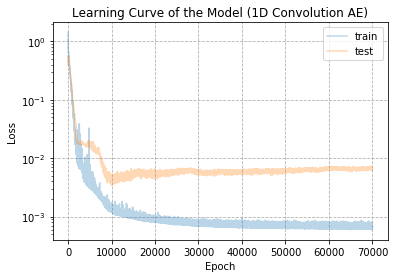

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(model.history.history['loss'], alpha = 0.3)
ax.plot(model.history.history['val_loss'], alpha = 0.3)
ax.legend(['train', 'test'], loc='upper right')
ax.set_yscale('log')
ax.grid(ls = '--')
plt.title('Learning Curve of the Model (1D Convolution AE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

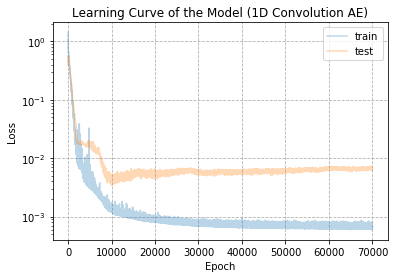

In [16]:
import pandas as pd
history = pd.DataFrame(model.history.history)
history.head()

fig, ax = plt.subplots(1,1)
ax.plot(history['loss'], alpha = 0.3)
ax.plot(history['val_loss'], alpha = 0.3)
ax.legend(['train', 'test'], loc='upper right')
ax.set_yscale('log')
ax.grid(ls = '--')
plt.title('Learning Curve of the Model (1D Convolution AE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [11]:
savepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Approach_VAE/Training Results/0714_results.h5'
model.save(savepath)

In [44]:
from numpy import savez
def SaveModel(filepath, model, hyperparameters):
    
    # Define subfunction that saves the model architecture and weights
    def SaveModelandWeights(savepath, model_name, model):
        weight_path = os.path.join(savepath, model_name+'_weights.h5')
        architecture_path = os.path.join(savepath, model_name+'_architecture.json')
        
        model.save_weights(weight_path)
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
    
    # Define subfunction that gets the list of all files in a given directory
    def GetAllFilepaths(directory):
        filepaths = []
        
        for root, _, files in os.walk(directory): 
            for filename in files: 
                filepath = os.path.join(root, filename) 
                filepaths.append(filepath) 
   
        return filepaths         
  
    base_dir = os.path.dirname(filepath)
    filename = os.path.basename(filepath).split('.')[0]
    
    # Create and save the files into the temporary directory
    temp_dir = os.path.join(base_dir, filename)
    if os.path.exists(temp_dir):
        raise Exception('The path of the temporary directory clashes with an existing one. Change the filename and try again')
    os.makedirs(temp_dir)
    
    SaveModelandWeights(temp_dir, 'encoder', model['encoder'])
    SaveModelandWeights(temp_dir, 'decoder', model['decoder'])
    SaveModelandWeights(temp_dir, 'autoencoder', model['model'])
    
    param_path = os.path.join(temp_dir, 'hyperparameters.npz')
    savez(param_path, **hyperparameters)
    
    # Now zip all the files in the temporary directory
    filepaths = GetAllFilepaths(temp_dir)
    
    with ZipFile(filepath, 'w') as zip: 
        for file in filepaths: 
            zip.write(file, os.path.basename(file))
    
    # Finally, delete the temporary directory and all its contents
    shutil.rmtree(temp_dir)
    
    print('Model saved successfully at %s' %(filepath))


In [45]:

savepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Approach_VAE/Training Results/0714_results.zip'
hyperparameters = {'learning_rate': 1e-3, 'dropout_rate': 0.0, 'batch_norm': True}
SaveModel(savepath, conv1d_ae, hyperparameters)

Model saved successfully at /home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Approach_VAE/Training Results/0714_results.zip


In [26]:
import os, shutil
from zipfile import ZipFile

def SaveModel(filepath, model, hyperparameters):
    
    # Define subfunction that saves the model architecture and weights
    def SaveModelandWeights(savepath, model_name, model):
        weight_path = os.path.join(savepath, model_name+'_weights.h5')
        architecture_path = os.path.join(savepath, model_name+'_architecture.json')
        
        model.save_weights(weight_path)
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
    
    # Define subfunction that gets the list of all files in a given directory
    def GetAllFilepaths(directory):
        filepaths = []
        
        for root, directories, files in os.walk(directory): 
            for filename in files: 
                filepath = os.path.join(root, filename) 
                filepaths.append(filepath) 
   
        return filepaths         
  
    base_dir = os.path.dirname(filepath)
    filename = os.path.basename(filepath).split('.')[0]
    
    # Create and save the files into the temporary directory
    temp_dir = os.path.join(base_dir, filename)
    if os.path.exists(temp_dir):
        raise Exception('The path of the temporary directory clashes with an existing one. Change the filename and try again')
    os.makedirs(temp_dir)
    
    SaveModelandWeights(temp_dir, 'encoder', model['encoder'])
    SaveModelandWeights(temp_dir, 'decoder', model['decoder'])
    SaveModelandWeights(temp_dir, 'autoencoder', model['autoencoder'])
    
    param_path = os.path.join(temp_dir, 'hyperparameters.npz')
    np.savez(param_path, **hyperparameters)
    
    # Now zip all the files in the temporary directory
    filepaths = GetAllFilepaths(temp_dir)
    
    with ZipFile(filepath, 'w') as zip: 
        for file in filepaths: 
            zip.write(file)
    
    # Finally, delete the temporary directory and all its contents
    shutil.rmtree(temp_dir)
    
    print('Model saved successfully at %s' %(filepath))

In [9]:
result = model.predict([test[:,:,1:3], test[:,:,3:]], batch_size = batch_size)
latent = encoder.predict([test[:,:,1:3], test[:,:,3:]], batch_size = batch_size)
print(result.shape)
print(latent.shape)

(31, 54, 2)
(31, 54, 1)


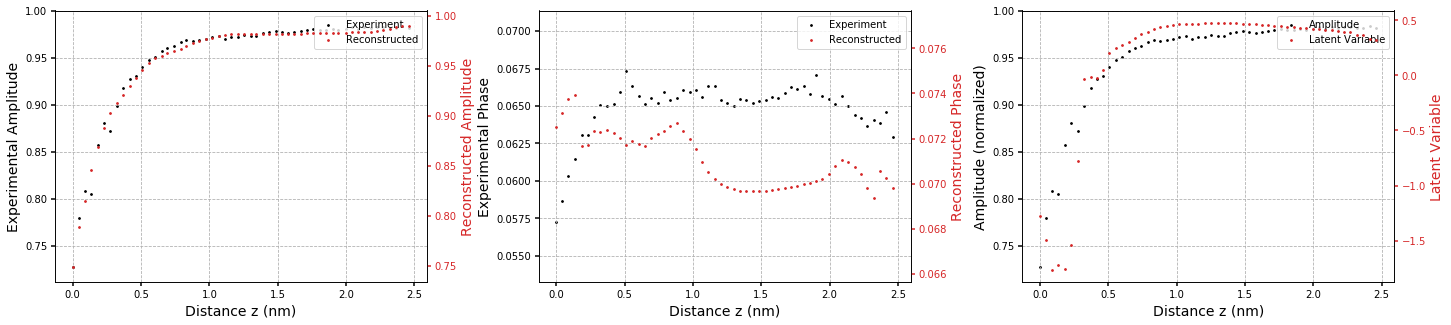

In [10]:
index_number = 20

fig = plt.figure(figsize = (24, 5))
ax_l1 = fig.add_subplot(131)
ax_m1 = fig.add_subplot(132)
ax_r1 = fig.add_subplot(133)
fig.subplots_adjust(wspace = 0.3)

ax_l2 = ax_l1.twinx()
ax_m2 = ax_m1.twinx()
ax_r2 = ax_r1.twinx()

# Plot the data
line_l1 = ax_l1.scatter(test[index_number,:,0], test[index_number,:,1], s = 3, color = 'black', label = 'Experiment')
line_l2 = ax_l2.scatter(test[index_number,:,0], result[index_number,:,0], s = 3, color = 'tab:red', label = 'Reconstructed')

line_m1 = ax_m1.scatter(test[index_number,:,0], test[index_number,:,2], s = 3, color = 'black', label = 'Experiment')
line_m2 = ax_m2.scatter(test[index_number,:,0], result[index_number,:,1], s = 3, color = 'tab:red', label = 'Reconstructed')

line_r1 = ax_r1.scatter(test[index_number,:,0], test[index_number,:,1], s = 3, color = 'black', label = 'Amplitude')
line_r2 = ax_r2.scatter(test[index_number,:,0], latent[index_number,:,0], s = 3, color = 'tab:red', label = 'Latent Variable')


# Set axis labels
fontsize = 14

ax_l1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_l1.set_ylabel('Experimental Amplitude', fontsize = fontsize)
ax_l2.set_ylabel('Reconstructed Amplitude', color = 'tab:red', fontsize = fontsize)

ax_m1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_m1.set_ylabel('Experimental Phase', fontsize = fontsize)
ax_m2.set_ylabel('Reconstructed Phase', color = 'tab:red', fontsize = fontsize)

ax_r1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_r1.set_ylabel('Amplitude (normalized)', fontsize = fontsize)
ax_r2.set_ylabel('Latent Variable', color = 'tab:red', fontsize = fontsize)

# Set axis color and size
ax_l2.yaxis.label.set_color('tab:red')
ax_m2.yaxis.label.set_color('tab:red')
ax_r2.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)

ax_l1.tick_params(axis='x', **tkw)
ax_l1.tick_params(axis='y', **tkw)
ax_l2.tick_params(axis='y', colors='tab:red', **tkw)

ax_m1.tick_params(axis='x', **tkw)
ax_m1.tick_params(axis='y', **tkw)
ax_m2.tick_params(axis='y', colors='tab:red', **tkw)

ax_r1.tick_params(axis='x', **tkw)
ax_r1.tick_params(axis='y', **tkw)
ax_r2.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines_l = [line_l1, line_l2]
labels_l = [l.get_label() for l in lines_l]
ax_l1.legend(lines_l, labels_l, loc = 'upper right')

lines_m = [line_m1, line_m2]
labels_m = [l.get_label() for l in lines_m]
ax_m1.legend(lines_m, labels_m, loc = 'upper right')

lines_r = [line_r1, line_r2]
labels_r = [l.get_label() for l in lines_r]
ax_r1.legend(lines_r, labels_r, loc = 'upper right')

ax_l1.grid(ls = '--')
ax_m1.grid(ls = '--')
ax_r1.grid(ls = '--')

**Analyze the trained results**

Text(0.5, 1.0, 'Predicted latent variables for the test dataset (31 approach curve)')

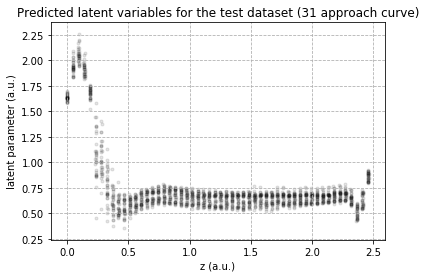

In [17]:
fig, ax = plt.subplots(1,1)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}
for i in range(test.shape[0]):
    ax.scatter(test[i,:,0], latent[i,:,0], **kwargs) 
    
ax.grid(ls = '--')
ax.set_xlabel('z (a.u.)')
ax.set_ylabel('latent parameter (a.u.)')
ax.set_title('Predicted latent variables for the test dataset (31 approach curve)')

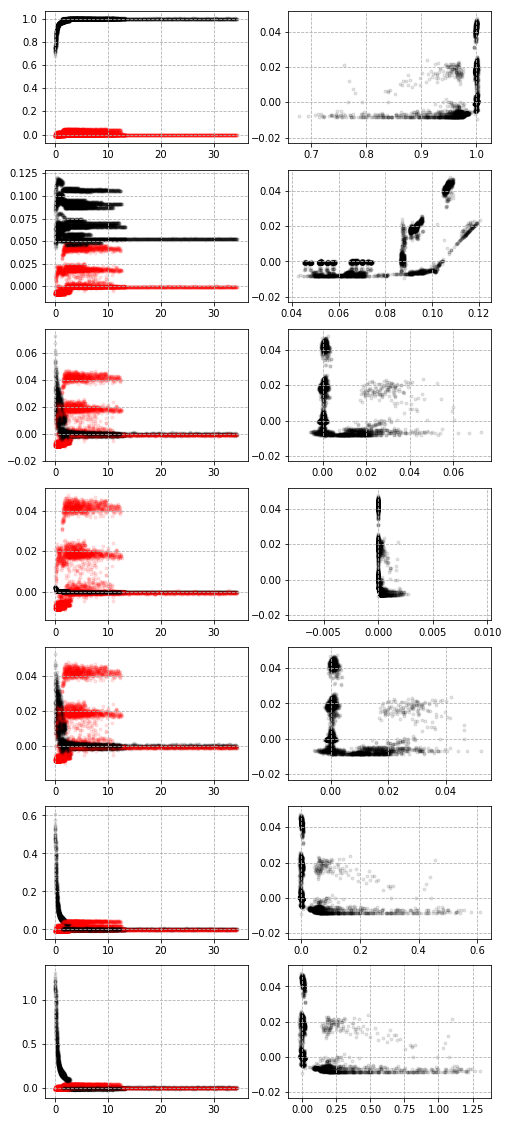

In [40]:
fig, axes = plt.subplots(7, 2, figsize = (8,20))
axes = axes.flatten()

for i in range(test_dataset['Q'].size):
    imin = test_dataset['imin'][i]
    plot_index = range(imin+1)
    
    mech = test_dataset['mech'][i][plot_index, :]
    k = test_dataset['kint'][i][plot_index]
    b = test_dataset['bint'][i][plot_index]
    E = test_dataset['E'][i][plot_index]
    Fk = test_dataset['Fk'][i][plot_index]
    Fb = test_dataset['Fb'][i][plot_index]

    ww0 = np.ones((imin+1, 1))*test_dataset['w'][i]/test_dataset['w0'][i]
    Q = np.ones((imin+1, 1))*test_dataset['Q'][i]
    
    latent = encoder.predict(mech[:, 1:], batch_size = batch_size)
    #latent = encoder.predict(np.c_[mech[:, 1:], ww0, Q], batch_size = batch_size)
    
    axes[0].scatter(mech[:,0], mech[:,1], c = 'k', marker = '.', alpha = 0.1) # plot amplitude
    axes[0].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[1].scatter(mech[:,1], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[1].plot(latent[0], latent[0], '--r')
    
    
    axes[2].scatter(mech[:,0], mech[:,2], c = 'k', marker = '.', alpha = 0.1) # plot phase
    axes[2].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[3].scatter(mech[:,2], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[3].plot(latent[0], latent[0], '--r')
    
    
    axes[4].scatter(mech[:,0], 10000*k, c = 'k', marker = '.', alpha = 0.1) # plot k
    axes[4].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[5].scatter(10000*k, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[5].plot(latent[0], latent[0], '--r')
    
    
    axes[6].scatter(mech[:,0], 1000000*b, c = 'k', marker = '.', alpha = 0.1) # plot b
    axes[6].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[7].scatter(1000000*b, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[7].plot(latent[0], latent[0], '--r')
    
    
    axes[8].scatter(mech[:,0], 10000*Fk, c = 'k', marker = '.', alpha = 0.1) # plot Fk
    axes[8].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[9].scatter(10000*Fk, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[9].plot(latent[0], latent[0], '--r')
    
    
    axes[10].scatter(mech[:,0], 10000*Fb, c = 'k', marker = '.', alpha = 0.1) # plot Fb
    axes[10].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[11].scatter(10000*Fb, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[11].plot(latent[0], latent[0], '--r')
    
    
    axes[12].scatter(mech[:,0], 10000*E, c = 'k', marker = '.', alpha = 0.1) # plot E
    axes[12].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[13].scatter(10000*E, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[13].plot(latent[0], latent[0], '--r')
    
for ax in axes:
    ax.grid(ls = '--')

31


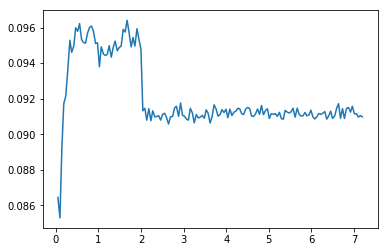

In [42]:
# Select particular approach curve
print(test_dataset['Q'].size)
trial_index = 5 # for anomaly, try 458
mech = test_dataset['mech'][trial_index]
imin = test_dataset['imin'][trial_index]
plot_index = range(imin)
plt.plot(mech[plot_index, 0], mech[plot_index, 2])
plt.show()

In [43]:
# calculate normalized k_int and b_int

k_i = test_dataset['kint'][trial_index][plot_index]
b_i = test_dataset['bint'][trial_index][plot_index]
E_i = test_dataset['E'][trial_index][plot_index]
Fk_i = test_dataset['Fk'][trial_index][plot_index]
Fb_i = test_dataset['Fb'][trial_index][plot_index]

ww0_i = np.ones((imin, 1))*test_dataset['w'][trial_index]/test_dataset['w0'][trial_index]
Q_i = np.ones((imin, 1))*test_dataset['Q'][trial_index]
#
#latent = encoder.predict(np.c_[mech[plot_index, 1:], ww0_i, Q_i], batch_size = batch_size)
latent = encoder.predict(mech[plot_index, 1:], batch_size = batch_size)

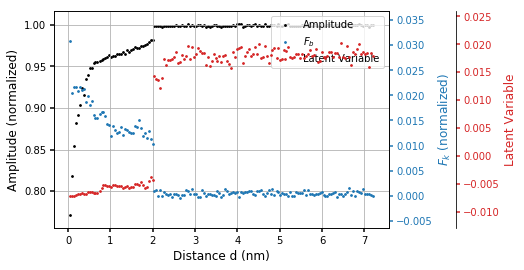

In [44]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# Offset the right spine of par2.  The ticks and label have already been placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, ax3 has its frame off, so the line of its detached spine is invisible.  
#First, activate the frame but make the patch and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)


# Plot the data
line1 = ax1.scatter(mech[plot_index, 0], mech[plot_index, 1], s = 3, color = 'black', label = 'Amplitude')
line2 = ax2.scatter(mech[plot_index, 0], 10000*Fk_i, s = 3, color = 'tab:blue', label = '$F_b$')
line3 = ax3.scatter(mech[plot_index, 0], latent[0], s = 3, color = 'tab:red', label = 'Latent Variable')

# Set axis labels
ax1.set_xlabel('Distance d (nm)', fontsize = 12)
ax1.set_ylabel('Amplitude (normalized)', fontsize = 12)
ax2.set_ylabel('$F_k$ (normalized)', color = 'tab:blue', fontsize = 12)
ax3.set_ylabel('Latent Variable', color = 'tab:red', fontsize = 12)

# Set axis color and size
ax2.yaxis.label.set_color('tab:blue')
ax3.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='y', colors='tab:blue', **tkw)
ax3.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc = 'upper right')

#ax1.axvline(trial[np.argmax(latent),0], color = 'red', alpha = 0.8)
#ax1.axvline(trial[np.argmax(E_i),0], color = 'blue', alpha = 0.8)
ax1.grid(True)


In [45]:
from scipy.stats.stats import pearsonr
amp = np.reshape(mech[plot_index, 1], mech[plot_index, 2].size)
phas = np.reshape(mech[plot_index, 2], mech[plot_index, 2].size)
latent_var = np.reshape(latent[0], mech[plot_index, 2].size)

pearsonr(amp, latent_var)
pearsonr(phas, latent_var)

(-0.7497092130818291, 3.160508236025604e-29)